# 準備

In [ ]:
!nvidia-smi
# 16280MiBじゃなかったら16epochで動かないので文字数を512から減らす処理が必要

Mon Oct 11 23:58:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.9 MB/s 
     |████████████████████████████████| 636 kB 57.7 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 59.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import sys
import math
from math import exp
import random
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification,AdamW
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from scipy.optimize import minimize, minimize_scalar

import nltk
nltk.download("punkt")
from nltk import word_tokenize
from nltk.corpus import stopwords 


import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
DATA_DIR = "Data/"
OUTPUT_DIR = "Output/"
LOG_DIR = "log/"
MODEL_DIR = "Model/"
Proba_DIR = 'Proba/'
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Signate論文コンペ

/content/drive/MyDrive/Colab Notebooks/Signate論文コンペ


In [ ]:
def init_logger(log_file=LOG_DIR + "BERT.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def seed_torch(seed = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 471
seed_torch(seed)

# データ処理関数の定義

In [ ]:
def get_train_data(train):
    # 交差検証用の番号を振ります。
    Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

In [ ]:
def covid(text):
  text = str.lower(text)
  text = text.replace("covid-19", "coronavirus")
  text = text.replace("covid19", "coronavirus")
  text = text.replace("covi19", "coronavirus")
  text = text.replace("sars-cov-2", "coronavirus")
  text = text.replace("covid", "coronavirus")
  text = text.replace("rt-pcr", "pcr")
  text = text.replace("rt-qpcr", "pcr")
  text = text.replace("jc virus", "polyomavirus")
  text = text.replace("c virus", "herpesvirus")

  return text

In [ ]:
import nltk
from nltk.corpus import stopwords 
nltk.download("stopwords")
nltk_stopwords=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download("stopwords")
nltk_stopwords = stopwords.words("english")

def stopword(text):
  # 不要な文字の削除
  text = re.findall('\W|\w+', text)
  text = ' '.join(text)
  text = text.replace('  ', ' ')
  text = re.sub(r"[0-9]", "",text)
  text = word_tokenize(text)

  stop_words = nltk_stopwords + ["(",")",">", "<","*", ":", ";","\\", "_", "%","Copyright",".","\"","'", "=", "?","!","a","l",",","-","@","&","^","/","%","[","]"]
  text = [t for t in text if t not in stop_words]
  text=" ".join(text)

  return text
  

def New_sep(text):
  # 文末のカンマのみをNEW_SEPに変えます
  text = text.replace(". ","[NEW_SEP]")
  
  return text


def New_sep_2(text):
  # 見栄えをよくします
  text = text.replace("new_sep","[NEW_SEP]")

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 前処理を少し詳しく
まず最初にNew_sep関数で文末のカンマのみを変更します。（数字間のピリオドなどを認識させないため）  
次に通常の前処理を行うと"[NEW_SEP]"がnew_sepになっています。  
最後にnew_sepを元に戻すNew_sep_2を行います。

# データの読み込み

In [ ]:
train_data = pd.read_csv(DATA_DIR+'train.csv', encoding='utf8')
test_data = pd.read_csv(DATA_DIR+'test.csv', encoding='utf8')

train_data['text'] = train_data['title'] + ' ' + train_data['abstract'].fillna('')
test_data['text'] = test_data['title'] + ' ' + test_data['abstract'].fillna('')

train = train_data.drop(columns=['title', 'abstract'])
test = test_data.drop(columns=['title', 'abstract'])

sub = pd.read_csv(DATA_DIR+"sample_submit.csv", header=None)
sub.columns = ["id","judgement"]

In [ ]:
# foldを振り分ける
train=get_train_data(train)

In [ ]:
train['fold'].value_counts().sort_index()

0    5429
1    5429
2    5429
3    5429
4    5429
Name: fold, dtype: int64

## BERTの種類
- SciBert … 科学論文に特化した単語で学習したBERTモデル 評価指標無し  
"allenai/scibert_scivocab_uncased"
- PubmedBert … Microsoftが作成した、生物医学論文のテキストを学習したBERTモデル 最高精度- LB:0.9114,CV 0.898 
 "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
- COVID-SciBert … SciBertをベースにコロナウイルスの医学論文テキストを学習させたBERTモデル 評価指標無し　  
"lordtt13/COVID-SciBERT"
-BioELECTRA…生物医学領域、Pubmedで事前学習している  
"kamalkraj/bioelectra-base-discriminator-pubmed"

# インプットする文字の長さ測定

In [ ]:
# train_data["text"] = train_data["text"].apply(New_sep)
# test_data["text"] = test_data["text"].apply(New_sep)
# train_data["text"] = train_data["text"].apply(covid)
# test_data["text"] = test_data["text"].apply(covid)
# train_data["text"] = train_data["text"].apply(stopword)
# test_data["text"] = test_data["text"].apply(stopword)
# train_data["text"] = train_data["text"].apply(New_sep_2)
# test_data["text"] = test_data["text"].apply(New_sep_2)

In [ ]:
#tokenを調べて出力したい
#tokenizer=AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
#tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)

#tokenリストを出力
#pd.DataFrame(tokenizer.vocab.keys(), columns=['token']).to_csv('Token/'+'BiomedNLP-PubMedBERT-base-uncased-abstract_token_list.csv')

In [ ]:
# max_lens_train=[]
# i=0
# j=0
# max_len=512 # 任意に設定

# for x in train_data["text"]:
#     max_lens_train.append(len(tokenizer.tokenize(x)))
#     max_lens=(len(tokenizer.tokenize(x)))
#     if max_lens >=max_len:
#         i+=1        
# max_lens_test=[]
# for x in test_data["text"]:
#     max_lens_test.append(len(tokenizer.tokenize(x)))
#     max_lens=(len(tokenizer.tokenize(x)))
#     if max_lens >=max_len:
#         j+=1
# print("トークンの最大値：{},trainの文字数{}オーバーは{}個です".format(max(max_lens_train),max_len,i))
# print("トークンの最大値：{},testの文字数{}オーバーは{}個です".format(max(max_lens_test),max_len,j))

In [ ]:
# # 分布を出力
# fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,7))

# sns.histplot(max_lens_train, ax = ax1, label = "train")
# ax1.legend(loc="lower right",fontsize=30)
# ax1.set_xlabel(xlabel="lens")
# ax1.grid()
# ax1.set_title("train",fontsize=10)
# ax1.set_xlim(1,800)
# ax1.legend(loc='upper right',fontsize=10)

# sns.histplot(max_lens_test, ax = ax2, label = "test")
# ax2.legend(loc="lower right",fontsize=20)
# ax2.set_xlabel(xlabel="lens")
# ax2.grid()
# ax2.set_title("train",fontsize=10)
# ax2.set_xlim(1,800)
# ax2.legend(loc='upper right',fontsize=10)

# BERTに使う関数・クラスの定義

## データセット定義

In [ ]:
class BaseDataset(Dataset):
    def __init__(self, df, model_name, include_labels=True):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)
        self.df = df
        self.include_labels = include_labels
        df["text"] = df["text"].apply(New_sep)
        df["text"] = df["text"].apply(covid)
        df["text"] = df["text"].apply(stopword)
        df["text"] = df["text"].apply(New_sep_2)
        self.text = df["text"].tolist()
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = "max_length",            
            max_length = 512,
            truncation = True,
            return_attention_mask = True,
            return_tensors = "pt"
        )
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoded['input_ids'][idx])
        attention_mask = torch.tensor(self.encoded['attention_mask'][idx])

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            return input_ids, attention_mask, label

        return input_ids, attention_mask

## モデル定義

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        num_labels = 1,
                                                                        output_hidden_states = True)
        self.model.resize_token_embeddings(len(tokenizer))

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask)        

        return outputs

## ツール

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
def bestFbeta(labels,preds):
  # bestFbetaとThresholdを抽出
  Threshold_list = []
  fbeta_score_list = []
  for i in range(1000):
      Threshold = i*0.0001
      predictions = np.where(preds < Threshold, 0, 1)
      Threshold_list.append(Threshold)
      fbeta_score_list.append(fbeta_score(labels, predictions, beta=7.0))
  for i,j in zip(Threshold_list, fbeta_score_list):
    if j == max(fbeta_score_list):
      return i,j
      break

## 学習補助関数

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    start = end = time.time()
    losses = AverageMeter()
    sigmoid = nn.Sigmoid()

    # embedding取得用
    vector_concat = np.array(range(0,768))
    vector_labels = np.array([])    

    # switch to train mode
    model.train()

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        outputs = model(input_ids, attention_mask)

        y_preds = sigmoid(outputs.logits).squeeze()

        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()

        optimizer.step()

        # ミニバッチ学習を128に変更する
        #if (step+1)%128==0:
        #  optimizer.step()
        #  optimizer.zero_grad()


        # embedding(最終層を確保するための3行)
        vector = outputs.hidden_states[-1][:,0,:].to('cpu').detach().numpy()
        vector_concat = np.vstack([vector_concat,vector])
        vector_labels = np.append(vector_labels,labels.to("cpu"))


        if step % 100 == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)-1}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )      

    # 確保した最終層を繋ぎ合わせる
    vector_concat = pd.DataFrame(vector_concat).drop(0,axis=0)
    vector_concat["label"] = vector_labels
    
    return losses.avg, vector_concat

## 検証補助関数

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
    start = end = time.time()
    losses = AverageMeter()
    sigmoid = nn.Sigmoid()

    # embedding取得用
    vector_concat = np.array(range(0,768))

    # switch to evaluation mode
    model.eval()
    preds = []

    for step, (input_ids, attention_mask, labels) in enumerate(valid_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        y_preds = sigmoid(outputs.logits).squeeze()

        if y_preds.size()==torch.Size([]):
          y_preds = y_preds.unsqueeze(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record score
        preds.append(y_preds.to("cpu").numpy())

        # embedding
        vector = outputs.hidden_states[-1][:,0,:].to('cpu').detach().numpy()
        vector_concat = np.vstack([vector_concat,vector])

        if step % 100 == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)-1}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    vector_concat = pd.DataFrame(vector_concat).drop(0,axis=0)
    predictions = np.concatenate(preds)

    return losses.avg, predictions, vector_concat

## 推論関数

In [ ]:
def inference():
    model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    predictions = []

    test_dataset = BaseDataset(test, model_name, include_labels=False)
    test_loader = DataLoader(test_dataset,
                             batch_size=16,
                             shuffle=False,
                             num_workers=4,
                             pin_memory=True)
    sigmoid = nn.Sigmoid()

    for fold in range(5):
        LOGGER.info(f"========== model {fold} inference ==========")
        model = BaseModel(model_name)
        model.to(device)
        model.load_state_dict(torch.load(MODEL_DIR + f"Pubmed_fold{fold}.pth")["model"])
        model.eval()
        preds = []

        # embedding取得用
        vector_concat = np.array(range(0,768))        

        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          with torch.no_grad():
              outputs = model(input_ids, attention_mask)
          y_preds = sigmoid(outputs.logits).squeeze()
          preds.append(y_preds.to("cpu").numpy())

          # embedding
          vector = outputs.hidden_states[-1][:,0,:].to('cpu').detach().numpy()
          vector_concat = np.vstack([vector_concat,vector])
        vector_concat = pd.DataFrame(vector_concat).drop(0,axis=0).astype("float32")
        vector_concat.to_csv(f"testvector_dataset_fold{fold}.csv")

        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

## 学習関数

In [ ]:
def train_loop(train, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    batch = 16
    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = train[train["fold"] != fold].index
    val_idx = train[train["fold"] == fold].index

    train_folds = train.loc[trn_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, model_name)
    valid_dataset = BaseDataset(valid_folds, model_name)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(model_name)
    model.to(device)
    criterion = nn.BCELoss()

    # ====================================================
    # Loop
    # ====================================================
    best_val_loss = 1
    best_loss = np.inf
    best_score = 0
    epochs = 3
    LR = 2e-5
    # LR = [2e-4, 2e-5, 2e-6]   #epoch毎に学習率を変化させる時に使う

    optimizer = AdamW(model.parameters(), lr=LR)

    #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1, eta_min=0, last_epoch=-1, verbose=False)   #schedulerを使う時に使用

    for epoch in range(epochs):
        #optimizer = AdamW(model.parameters(), lr=LR[epoch])   #epoch毎に学習率を変化させる時に使う
        start_time = time.time()
        # train
        avg_loss, train_vector = train_fn(train_loader, model, criterion, optimizer, epoch, device)

        # eval
        avg_val_loss, preds, valid_vector = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["judgement"].values
        valid_vector["label"] = valid_labels

        vector_dataset = pd.concat([train_vector,valid_vector],axis=0).astype("float32")

        # scoring
        bestThr,score = bestFbeta(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score} - Threshold:{bestThr:.4f} - val_loss{avg_val_loss:.4f}")

        if best_score < score:  # or (if avg_val_loss < best_val_loss:)
            best_score = score
            best_val_loss = avg_val_loss
            best_Threshold = bestThr 

            vector_dataset.to_csv(f"trainvector_dataset_fold{fold}.csv")

            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model - bestThr{best_Threshold:.5f} - val_loss{best_val_loss:.4f}")
            torch.save(
                {"model": model.state_dict(), "preds": preds, "Threshold":best_Threshold}, MODEL_DIR + f"Pubmed_fold{fold}.pth"
            )

        #scheduler.step()    #schedulerを使う時に使用

    check_point = torch.load(MODEL_DIR + f"Pubmed_fold{fold}.pth")

    valid_folds["preds"] = check_point["preds"]
    LOGGER.info(f"Bacthsize :{batch} - LearningRate :{LR}")
    return valid_folds, best_Threshold

In [ ]:
def get_result(result_df,best_threshold):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    score = fbeta_score(labels, preds >= best_threshold, beta=7)
    LOGGER.info(f"Score: {score:<.5f} - Threshold：{best_threshold:<.5f}")

## メイン（モデルのトレーニング〜testデータの予測）を行う関数

In [ ]:
def main():
    # Training
    LOGGER.info("BERT PubMed Abstract WordEmbedding取得 機械学習")
    oof_df = pd.DataFrame()
    Threshold_list=[]
    for fold in range(5):
        _oof_df, best_Threshold = train_loop(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df,best_Threshold)
        Threshold_list.append(best_Threshold)
        Threshold_mean = np.mean(Threshold_list)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df,Threshold_mean)
    
    # Save OOF result
    oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    # Inference
    predictions_sigmoid = inference()
    predictions = np.where(predictions_sigmoid < Threshold_mean, 0, 1)
    

    # submission
    sub["judgement"] = predictions
    sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
    LOGGER.info("==========CONPLETE==========")
    return predictions_sigmoid, predictions

## モデルのトレーニングのみを行う関数

In [ ]:
def trainning():
    # Training
    LOGGER.info("BERT PubMed Abstract WordEmbedding取得 機械学習")
    oof_df = pd.DataFrame()
    Threshold_list=[]
    for fold in range(5):
        _oof_df, best_Threshold = train_loop(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df,best_Threshold)
        Threshold_list.append(best_Threshold)
        Threshold_mean = np.mean(Threshold_list)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df,Threshold_mean)
    
    # Save OOF result
    oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

## testデータの予測を行う関数

In [ ]:
def inference_submit():
  # Inference
  predictions_sigmoid = inference()
  return predictions_sigmoid

# 実行

## mainを実行（モデルのトレーニング〜testデータの予測）

In [ ]:
if __name__ == "__main__":
    predictions_sigmoid,predictions = main()

#確率をファイルとして残す
pd.DataFrame(predictions_sigmoid, columns=['proba']).to_csv(Proba_DIR+'proba.csv')

BERT PubMed Abstract WordEmbedding取得 機械学習
========== fold: 0 training ==========


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

Epoch: [1][0/1356] Elapsed 0m 1s (remain 27m 15s) Loss: 0.6494 
Epoch: [1][100/1356] Elapsed 1m 26s (remain 17m 51s) Loss: 0.1371 
Epoch: [1][200/1356] Elapsed 2m 51s (remain 16m 26s) Loss: 0.1110 
Epoch: [1][300/1356] Elapsed 4m 17s (remain 15m 2s) Loss: 0.1011 
Epoch: [1][400/1356] Elapsed 5m 42s (remain 13m 37s) Loss: 0.0920 
Epoch: [1][500/1356] Elapsed 7m 8s (remain 12m 12s) Loss: 0.0862 
Epoch: [1][600/1356] Elapsed 8m 34s (remain 10m 47s) Loss: 0.0828 
Epoch: [1][700/1356] Elapsed 10m 0s (remain 9m 22s) Loss: 0.0779 
Epoch: [1][800/1356] Elapsed 11m 27s (remain 7m 57s) Loss: 0.0723 
Epoch: [1][900/1356] Elapsed 12m 54s (remain 6m 31s) Loss: 0.0721 
Epoch: [1][1000/1356] Elapsed 14m 21s (remain 5m 6s) Loss: 0.0693 
Epoch: [1][1100/1356] Elapsed 15m 47s (remain 3m 40s) Loss: 0.0679 
Epoch: [1][1200/1356] Elapsed 17m 14s (remain 2m 14s) Loss: 0.0664 
Epoch: [1][1300/1356] Elapsed 18m 42s (remain 0m 48s) Loss: 0.0643 
Epoch: [1][1356/1356] Elapsed 19m 31s (remain 0m 0s) Loss: 0.0630

Epoch 1 - avg_train_loss: 0.0630  avg_val_loss: 0.0474  time: 1273s
Epoch 1 - Score: 0.9168157423971377 - Threshold:0.0527 - val_loss0.0474
Epoch 1 - Save Best Score: 0.9168 Model - bestThr0.05270 - val_loss0.0474


Epoch: [2][0/1356] Elapsed 0m 1s (remain 25m 37s) Loss: 0.0165 
Epoch: [2][100/1356] Elapsed 1m 26s (remain 17m 50s) Loss: 0.0222 
Epoch: [2][200/1356] Elapsed 2m 51s (remain 16m 25s) Loss: 0.0273 
Epoch: [2][300/1356] Elapsed 4m 17s (remain 15m 1s) Loss: 0.0301 
Epoch: [2][400/1356] Elapsed 5m 42s (remain 13m 37s) Loss: 0.0301 
Epoch: [2][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.0304 
Epoch: [2][600/1356] Elapsed 8m 34s (remain 10m 47s) Loss: 0.0302 
Epoch: [2][700/1356] Elapsed 10m 1s (remain 9m 22s) Loss: 0.0326 
Epoch: [2][800/1356] Elapsed 11m 27s (remain 7m 57s) Loss: 0.0319 
Epoch: [2][900/1356] Elapsed 12m 54s (remain 6m 31s) Loss: 0.0332 
Epoch: [2][1000/1356] Elapsed 14m 20s (remain 5m 6s) Loss: 0.0322 
Epoch: [2][1100/1356] Elapsed 15m 48s (remain 3m 40s) Loss: 0.0332 
Epoch: [2][1200/1356] Elapsed 17m 15s (remain 2m 14s) Loss: 0.0333 
Epoch: [2][1300/1356] Elapsed 18m 43s (remain 0m 48s) Loss: 0.0324 
Epoch: [2][1356/1356] Elapsed 19m 32s (remain 0m 0s) Loss: 0.0335

Epoch 2 - avg_train_loss: 0.0335  avg_val_loss: 0.0422  time: 1274s
Epoch 2 - Score: 0.9078425389075374 - Threshold:0.0799 - val_loss0.0422


Epoch: [3][0/1356] Elapsed 0m 1s (remain 25m 31s) Loss: 0.0302 
Epoch: [3][100/1356] Elapsed 1m 26s (remain 17m 50s) Loss: 0.0174 
Epoch: [3][200/1356] Elapsed 2m 51s (remain 16m 26s) Loss: 0.0183 
Epoch: [3][300/1356] Elapsed 4m 17s (remain 15m 2s) Loss: 0.0174 
Epoch: [3][400/1356] Elapsed 5m 43s (remain 13m 38s) Loss: 0.0173 
Epoch: [3][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.0194 
Epoch: [3][600/1356] Elapsed 8m 35s (remain 10m 48s) Loss: 0.0214 
Epoch: [3][700/1356] Elapsed 10m 1s (remain 9m 23s) Loss: 0.0213 
Epoch: [3][800/1356] Elapsed 11m 28s (remain 7m 58s) Loss: 0.0209 
Epoch: [3][900/1356] Elapsed 12m 55s (remain 6m 32s) Loss: 0.0213 
Epoch: [3][1000/1356] Elapsed 14m 22s (remain 5m 6s) Loss: 0.0210 
Epoch: [3][1100/1356] Elapsed 15m 49s (remain 3m 40s) Loss: 0.0212 
Epoch: [3][1200/1356] Elapsed 17m 16s (remain 2m 14s) Loss: 0.0211 
Epoch: [3][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0210 
Epoch: [3][1356/1356] Elapsed 19m 33s (remain 0m 0s) Loss: 0.0210

Epoch 3 - avg_train_loss: 0.0210  avg_val_loss: 0.0575  time: 1275s
Epoch 3 - Score: 0.9014514896867838 - Threshold:0.0004 - val_loss0.0575
Bacthsize :16 - LearningRate :2e-05
========== fold: 0 result ==========
Score: 0.91682 - Threshold：0.05270
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

Epoch: [1][0/1356] Elapsed 0m 1s (remain 25m 12s) Loss: 0.8290 
Epoch: [1][100/1356] Elapsed 1m 26s (remain 17m 52s) Loss: 0.1450 
Epoch: [1][200/1356] Elapsed 2m 51s (remain 16m 26s) Loss: 0.1205 
Epoch: [1][300/1356] Elapsed 4m 17s (remain 15m 2s) Loss: 0.1106 
Epoch: [1][400/1356] Elapsed 5m 43s (remain 13m 38s) Loss: 0.1055 
Epoch: [1][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.1011 
Epoch: [1][600/1356] Elapsed 8m 35s (remain 10m 48s) Loss: 0.0928 
Epoch: [1][700/1356] Elapsed 10m 2s (remain 9m 23s) Loss: 0.0908 
Epoch: [1][800/1356] Elapsed 11m 28s (remain 7m 58s) Loss: 0.0881 
Epoch: [1][900/1356] Elapsed 12m 55s (remain 6m 32s) Loss: 0.0839 
Epoch: [1][1000/1356] Elapsed 14m 22s (remain 5m 6s) Loss: 0.0813 
Epoch: [1][1100/1356] Elapsed 15m 49s (remain 3m 40s) Loss: 0.0789 
Epoch: [1][1200/1356] Elapsed 17m 17s (remain 2m 14s) Loss: 0.0768 
Epoch: [1][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0754 
Epoch: [1][1356/1356] Elapsed 19m 33s (remain 0m 0s) Loss: 0.0743

Epoch 1 - avg_train_loss: 0.0743  avg_val_loss: 0.0490  time: 1275s
Epoch 1 - Score: 0.9161328765082676 - Threshold:0.0096 - val_loss0.0490
Epoch 1 - Save Best Score: 0.9161 Model - bestThr0.00960 - val_loss0.0490


Epoch: [2][0/1356] Elapsed 0m 1s (remain 26m 33s) Loss: 0.1254 
Epoch: [2][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.0491 
Epoch: [2][200/1356] Elapsed 2m 51s (remain 16m 28s) Loss: 0.0496 
Epoch: [2][300/1356] Elapsed 4m 17s (remain 15m 3s) Loss: 0.0478 
Epoch: [2][400/1356] Elapsed 5m 43s (remain 13m 39s) Loss: 0.0452 
Epoch: [2][500/1356] Elapsed 7m 9s (remain 12m 14s) Loss: 0.0464 
Epoch: [2][600/1356] Elapsed 8m 35s (remain 10m 49s) Loss: 0.0452 
Epoch: [2][700/1356] Elapsed 10m 2s (remain 9m 23s) Loss: 0.0434 
Epoch: [2][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0440 
Epoch: [2][900/1356] Elapsed 12m 56s (remain 6m 32s) Loss: 0.0441 
Epoch: [2][1000/1356] Elapsed 14m 23s (remain 5m 6s) Loss: 0.0435 
Epoch: [2][1100/1356] Elapsed 15m 50s (remain 3m 41s) Loss: 0.0430 
Epoch: [2][1200/1356] Elapsed 17m 18s (remain 2m 14s) Loss: 0.0423 
Epoch: [2][1300/1356] Elapsed 18m 45s (remain 0m 48s) Loss: 0.0438 
Epoch: [2][1356/1356] Elapsed 19m 35s (remain 0m 0s) Loss: 0.0442

Epoch 2 - avg_train_loss: 0.0442  avg_val_loss: 0.0518  time: 1277s
Epoch 2 - Score: 0.9210138520483347 - Threshold:0.0042 - val_loss0.0518
Epoch 2 - Save Best Score: 0.9210 Model - bestThr0.00420 - val_loss0.0518


Epoch: [3][0/1356] Elapsed 0m 1s (remain 25m 44s) Loss: 0.0213 
Epoch: [3][100/1356] Elapsed 1m 26s (remain 17m 54s) Loss: 0.0471 
Epoch: [3][200/1356] Elapsed 2m 51s (remain 16m 29s) Loss: 0.0470 
Epoch: [3][300/1356] Elapsed 4m 17s (remain 15m 4s) Loss: 0.0433 
Epoch: [3][400/1356] Elapsed 5m 44s (remain 13m 40s) Loss: 0.0428 
Epoch: [3][500/1356] Elapsed 7m 10s (remain 12m 15s) Loss: 0.0424 
Epoch: [3][600/1356] Elapsed 8m 36s (remain 10m 49s) Loss: 0.0423 
Epoch: [3][700/1356] Elapsed 10m 3s (remain 9m 24s) Loss: 0.0392 
Epoch: [3][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0375 
Epoch: [3][900/1356] Elapsed 12m 56s (remain 6m 33s) Loss: 0.0373 
Epoch: [3][1000/1356] Elapsed 14m 24s (remain 5m 7s) Loss: 0.0368 
Epoch: [3][1100/1356] Elapsed 15m 51s (remain 3m 41s) Loss: 0.0372 
Epoch: [3][1200/1356] Elapsed 17m 18s (remain 2m 14s) Loss: 0.0362 
Epoch: [3][1300/1356] Elapsed 18m 46s (remain 0m 48s) Loss: 0.0355 
Epoch: [3][1356/1356] Elapsed 19m 35s (remain 0m 0s) Loss: 0.035

Epoch 3 - avg_train_loss: 0.0356  avg_val_loss: 0.0354  time: 1278s
Epoch 3 - Score: 0.9355187876913562 - Threshold:0.0449 - val_loss0.0354
Epoch 3 - Save Best Score: 0.9355 Model - bestThr0.04490 - val_loss0.0354
Bacthsize :16 - LearningRate :2e-05
========== fold: 1 result ==========
Score: 0.93552 - Threshold：0.04490
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.

Epoch: [1][0/1356] Elapsed 0m 1s (remain 25m 33s) Loss: 0.4726 
Epoch: [1][100/1356] Elapsed 1m 26s (remain 17m 54s) Loss: 0.1267 
Epoch: [1][200/1356] Elapsed 2m 52s (remain 16m 29s) Loss: 0.1055 
Epoch: [1][300/1356] Elapsed 4m 17s (remain 15m 4s) Loss: 0.0996 
Epoch: [1][400/1356] Elapsed 5m 44s (remain 13m 40s) Loss: 0.0901 
Epoch: [1][500/1356] Elapsed 7m 10s (remain 12m 15s) Loss: 0.0854 
Epoch: [1][600/1356] Elapsed 8m 36s (remain 10m 49s) Loss: 0.0827 
Epoch: [1][700/1356] Elapsed 10m 3s (remain 9m 24s) Loss: 0.0791 
Epoch: [1][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0757 
Epoch: [1][900/1356] Elapsed 12m 56s (remain 6m 32s) Loss: 0.0722 
Epoch: [1][1000/1356] Elapsed 14m 23s (remain 5m 7s) Loss: 0.0703 
Epoch: [1][1100/1356] Elapsed 15m 50s (remain 3m 40s) Loss: 0.0682 
Epoch: [1][1200/1356] Elapsed 17m 17s (remain 2m 14s) Loss: 0.0671 
Epoch: [1][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0660 
Epoch: [1][1356/1356] Elapsed 19m 34s (remain 0m 0s) Loss: 0.065

Epoch 1 - avg_train_loss: 0.0658  avg_val_loss: 0.0392  time: 1276s
Epoch 1 - Score: 0.9169363538295578 - Threshold:0.0566 - val_loss0.0392
Epoch 1 - Save Best Score: 0.9169 Model - bestThr0.05660 - val_loss0.0392


Epoch: [2][0/1356] Elapsed 0m 1s (remain 26m 13s) Loss: 0.2234 
Epoch: [2][100/1356] Elapsed 1m 26s (remain 17m 54s) Loss: 0.0282 
Epoch: [2][200/1356] Elapsed 2m 52s (remain 16m 29s) Loss: 0.0339 
Epoch: [2][300/1356] Elapsed 4m 17s (remain 15m 4s) Loss: 0.0310 
Epoch: [2][400/1356] Elapsed 5m 43s (remain 13m 40s) Loss: 0.0302 
Epoch: [2][500/1356] Elapsed 7m 10s (remain 12m 15s) Loss: 0.0309 
Epoch: [2][600/1356] Elapsed 8m 36s (remain 10m 49s) Loss: 0.0297 
Epoch: [2][700/1356] Elapsed 10m 2s (remain 9m 24s) Loss: 0.0311 
Epoch: [2][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0311 
Epoch: [2][900/1356] Elapsed 12m 56s (remain 6m 32s) Loss: 0.0318 
Epoch: [2][1000/1356] Elapsed 14m 22s (remain 5m 6s) Loss: 0.0321 
Epoch: [2][1100/1356] Elapsed 15m 50s (remain 3m 40s) Loss: 0.0330 
Epoch: [2][1200/1356] Elapsed 17m 17s (remain 2m 14s) Loss: 0.0329 
Epoch: [2][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0333 
Epoch: [2][1356/1356] Elapsed 19m 34s (remain 0m 0s) Loss: 0.032

Epoch 2 - avg_train_loss: 0.0329  avg_val_loss: 0.0458  time: 1276s
Epoch 2 - Score: 0.9163889730384732 - Threshold:0.0230 - val_loss0.0458


Epoch: [3][0/1356] Elapsed 0m 1s (remain 25m 49s) Loss: 0.0519 
Epoch: [3][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.0075 
Epoch: [3][200/1356] Elapsed 2m 51s (remain 16m 28s) Loss: 0.0129 
Epoch: [3][300/1356] Elapsed 4m 17s (remain 15m 4s) Loss: 0.0137 
Epoch: [3][400/1356] Elapsed 5m 43s (remain 13m 39s) Loss: 0.0140 
Epoch: [3][500/1356] Elapsed 7m 9s (remain 12m 14s) Loss: 0.0153 
Epoch: [3][600/1356] Elapsed 8m 36s (remain 10m 49s) Loss: 0.0141 
Epoch: [3][700/1356] Elapsed 10m 2s (remain 9m 23s) Loss: 0.0169 
Epoch: [3][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0174 
Epoch: [3][900/1356] Elapsed 12m 55s (remain 6m 32s) Loss: 0.0194 
Epoch: [3][1000/1356] Elapsed 14m 22s (remain 5m 6s) Loss: 0.0196 
Epoch: [3][1100/1356] Elapsed 15m 49s (remain 3m 40s) Loss: 0.0202 
Epoch: [3][1200/1356] Elapsed 17m 17s (remain 2m 14s) Loss: 0.0203 
Epoch: [3][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0202 
Epoch: [3][1356/1356] Elapsed 19m 34s (remain 0m 0s) Loss: 0.0206

Epoch 3 - avg_train_loss: 0.0206  avg_val_loss: 0.0393  time: 1276s
Epoch 3 - Score: 0.9187123327943555 - Threshold:0.0066 - val_loss0.0393
Epoch 3 - Save Best Score: 0.9187 Model - bestThr0.00660 - val_loss0.0393
Bacthsize :16 - LearningRate :2e-05
========== fold: 2 result ==========
Score: 0.91871 - Threshold：0.00660
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.

Epoch: [1][0/1356] Elapsed 0m 1s (remain 25m 38s) Loss: 0.7418 
Epoch: [1][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.1428 
Epoch: [1][200/1356] Elapsed 2m 51s (remain 16m 29s) Loss: 0.1126 
Epoch: [1][300/1356] Elapsed 4m 17s (remain 15m 5s) Loss: 0.1124 
Epoch: [1][400/1356] Elapsed 5m 44s (remain 13m 40s) Loss: 0.1044 
Epoch: [1][500/1356] Elapsed 7m 10s (remain 12m 15s) Loss: 0.0954 
Epoch: [1][600/1356] Elapsed 8m 36s (remain 10m 50s) Loss: 0.0892 
Epoch: [1][700/1356] Elapsed 10m 3s (remain 9m 24s) Loss: 0.0843 
Epoch: [1][800/1356] Elapsed 11m 30s (remain 7m 59s) Loss: 0.0826 
Epoch: [1][900/1356] Elapsed 12m 57s (remain 6m 33s) Loss: 0.0793 
Epoch: [1][1000/1356] Elapsed 14m 24s (remain 5m 7s) Loss: 0.0760 
Epoch: [1][1100/1356] Elapsed 15m 51s (remain 3m 41s) Loss: 0.0743 
Epoch: [1][1200/1356] Elapsed 17m 18s (remain 2m 14s) Loss: 0.0717 
Epoch: [1][1300/1356] Elapsed 18m 46s (remain 0m 48s) Loss: 0.0694 
Epoch: [1][1356/1356] Elapsed 19m 35s (remain 0m 0s) Loss: 0.068

Epoch 1 - avg_train_loss: 0.0684  avg_val_loss: 0.0435  time: 1277s
Epoch 1 - Score: 0.8753353098969364 - Threshold:0.0083 - val_loss0.0435
Epoch 1 - Save Best Score: 0.8753 Model - bestThr0.00830 - val_loss0.0435


Epoch: [2][0/1356] Elapsed 0m 1s (remain 25m 54s) Loss: 0.0502 
Epoch: [2][100/1356] Elapsed 1m 26s (remain 17m 54s) Loss: 0.0256 
Epoch: [2][200/1356] Elapsed 2m 51s (remain 16m 28s) Loss: 0.0263 
Epoch: [2][300/1356] Elapsed 4m 17s (remain 15m 4s) Loss: 0.0286 
Epoch: [2][400/1356] Elapsed 5m 44s (remain 13m 40s) Loss: 0.0271 
Epoch: [2][500/1356] Elapsed 7m 10s (remain 12m 15s) Loss: 0.0295 
Epoch: [2][600/1356] Elapsed 8m 36s (remain 10m 49s) Loss: 0.0307 
Epoch: [2][700/1356] Elapsed 10m 2s (remain 9m 24s) Loss: 0.0320 
Epoch: [2][800/1356] Elapsed 11m 29s (remain 7m 58s) Loss: 0.0334 
Epoch: [2][900/1356] Elapsed 12m 56s (remain 6m 32s) Loss: 0.0326 
Epoch: [2][1000/1356] Elapsed 14m 23s (remain 5m 7s) Loss: 0.0333 
Epoch: [2][1100/1356] Elapsed 15m 50s (remain 3m 40s) Loss: 0.0334 
Epoch: [2][1200/1356] Elapsed 17m 17s (remain 2m 14s) Loss: 0.0342 
Epoch: [2][1300/1356] Elapsed 18m 45s (remain 0m 48s) Loss: 0.0334 
Epoch: [2][1356/1356] Elapsed 19m 34s (remain 0m 0s) Loss: 0.033

Epoch 2 - avg_train_loss: 0.0334  avg_val_loss: 0.0430  time: 1276s
Epoch 2 - Score: 0.8931229532598988 - Threshold:0.0078 - val_loss0.0430
Epoch 2 - Save Best Score: 0.8931 Model - bestThr0.00780 - val_loss0.0430


Epoch: [3][0/1356] Elapsed 0m 1s (remain 26m 20s) Loss: 0.0032 
Epoch: [3][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.0142 
Epoch: [3][200/1356] Elapsed 2m 51s (remain 16m 28s) Loss: 0.0144 
Epoch: [3][300/1356] Elapsed 4m 17s (remain 15m 3s) Loss: 0.0169 
Epoch: [3][400/1356] Elapsed 5m 43s (remain 13m 39s) Loss: 0.0211 
Epoch: [3][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.0198 
Epoch: [3][600/1356] Elapsed 8m 35s (remain 10m 48s) Loss: 0.0204 
Epoch: [3][700/1356] Elapsed 10m 1s (remain 9m 22s) Loss: 0.0208 
Epoch: [3][800/1356] Elapsed 11m 27s (remain 7m 57s) Loss: 0.0220 
Epoch: [3][900/1356] Elapsed 12m 54s (remain 6m 31s) Loss: 0.0218 
Epoch: [3][1000/1356] Elapsed 14m 20s (remain 5m 6s) Loss: 0.0218 
Epoch: [3][1100/1356] Elapsed 15m 47s (remain 3m 40s) Loss: 0.0215 
Epoch: [3][1200/1356] Elapsed 17m 14s (remain 2m 14s) Loss: 0.0213 
Epoch: [3][1300/1356] Elapsed 18m 42s (remain 0m 48s) Loss: 0.0223 
Epoch: [3][1356/1356] Elapsed 19m 31s (remain 0m 0s) Loss: 0.0218

Epoch 3 - avg_train_loss: 0.0218  avg_val_loss: 0.0538  time: 1273s
Epoch 3 - Score: 0.8842443729903536 - Threshold:0.0002 - val_loss0.0538
Bacthsize :16 - LearningRate :2e-05
========== fold: 3 result ==========
Score: 0.89312 - Threshold：0.00780
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

Epoch: [1][0/1356] Elapsed 0m 1s (remain 25m 32s) Loss: 0.4662 
Epoch: [1][100/1356] Elapsed 1m 26s (remain 17m 52s) Loss: 0.1226 
Epoch: [1][200/1356] Elapsed 2m 51s (remain 16m 26s) Loss: 0.1141 
Epoch: [1][300/1356] Elapsed 4m 17s (remain 15m 2s) Loss: 0.0992 
Epoch: [1][400/1356] Elapsed 5m 43s (remain 13m 38s) Loss: 0.0923 
Epoch: [1][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.0886 
Epoch: [1][600/1356] Elapsed 8m 35s (remain 10m 48s) Loss: 0.0868 
Epoch: [1][700/1356] Elapsed 10m 2s (remain 9m 23s) Loss: 0.0831 
Epoch: [1][800/1356] Elapsed 11m 28s (remain 7m 57s) Loss: 0.0804 
Epoch: [1][900/1356] Elapsed 12m 55s (remain 6m 32s) Loss: 0.0768 
Epoch: [1][1000/1356] Elapsed 14m 22s (remain 5m 6s) Loss: 0.0727 
Epoch: [1][1100/1356] Elapsed 15m 49s (remain 3m 40s) Loss: 0.0695 
Epoch: [1][1200/1356] Elapsed 17m 16s (remain 2m 14s) Loss: 0.0667 
Epoch: [1][1300/1356] Elapsed 18m 44s (remain 0m 48s) Loss: 0.0659 
Epoch: [1][1356/1356] Elapsed 19m 33s (remain 0m 0s) Loss: 0.0647

Epoch 1 - avg_train_loss: 0.0647  avg_val_loss: 0.0436  time: 1275s
Epoch 1 - Score: 0.9057437407952871 - Threshold:0.0073 - val_loss0.0436
Epoch 1 - Save Best Score: 0.9057 Model - bestThr0.00730 - val_loss0.0436


Epoch: [2][0/1356] Elapsed 0m 1s (remain 26m 21s) Loss: 0.0016 
Epoch: [2][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.0370 
Epoch: [2][200/1356] Elapsed 2m 51s (remain 16m 27s) Loss: 0.0294 
Epoch: [2][300/1356] Elapsed 4m 17s (remain 15m 2s) Loss: 0.0306 
Epoch: [2][400/1356] Elapsed 5m 43s (remain 13m 38s) Loss: 0.0326 
Epoch: [2][500/1356] Elapsed 7m 9s (remain 12m 13s) Loss: 0.0335 
Epoch: [2][600/1356] Elapsed 8m 34s (remain 10m 47s) Loss: 0.0344 
Epoch: [2][700/1356] Elapsed 10m 1s (remain 9m 22s) Loss: 0.0362 
Epoch: [2][800/1356] Elapsed 11m 27s (remain 7m 57s) Loss: 0.0345 
Epoch: [2][900/1356] Elapsed 12m 54s (remain 6m 31s) Loss: 0.0340 
Epoch: [2][1000/1356] Elapsed 14m 21s (remain 5m 6s) Loss: 0.0339 
Epoch: [2][1100/1356] Elapsed 15m 48s (remain 3m 40s) Loss: 0.0341 
Epoch: [2][1200/1356] Elapsed 17m 15s (remain 2m 14s) Loss: 0.0335 
Epoch: [2][1300/1356] Elapsed 18m 43s (remain 0m 48s) Loss: 0.0336 
Epoch: [2][1356/1356] Elapsed 19m 32s (remain 0m 0s) Loss: 0.0334

Epoch 2 - avg_train_loss: 0.0334  avg_val_loss: 0.0422  time: 1274s
Epoch 2 - Score: 0.9101760668457177 - Threshold:0.0037 - val_loss0.0422
Epoch 2 - Save Best Score: 0.9102 Model - bestThr0.00370 - val_loss0.0422


Epoch: [3][0/1356] Elapsed 0m 1s (remain 26m 5s) Loss: 0.1626 
Epoch: [3][100/1356] Elapsed 1m 26s (remain 17m 53s) Loss: 0.0245 
Epoch: [3][200/1356] Elapsed 2m 51s (remain 16m 26s) Loss: 0.0204 
Epoch: [3][300/1356] Elapsed 4m 17s (remain 15m 1s) Loss: 0.0216 
Epoch: [3][400/1356] Elapsed 5m 42s (remain 13m 37s) Loss: 0.0245 
Epoch: [3][500/1356] Elapsed 7m 8s (remain 12m 12s) Loss: 0.0240 
Epoch: [3][600/1356] Elapsed 8m 34s (remain 10m 47s) Loss: 0.0245 
Epoch: [3][700/1356] Elapsed 10m 1s (remain 9m 22s) Loss: 0.0236 
Epoch: [3][800/1356] Elapsed 11m 27s (remain 7m 57s) Loss: 0.0223 
Epoch: [3][900/1356] Elapsed 12m 54s (remain 6m 31s) Loss: 0.0223 
Epoch: [3][1000/1356] Elapsed 14m 21s (remain 5m 6s) Loss: 0.0222 
Epoch: [3][1100/1356] Elapsed 15m 48s (remain 3m 40s) Loss: 0.0219 
Epoch: [3][1200/1356] Elapsed 17m 16s (remain 2m 14s) Loss: 0.0217 
Epoch: [3][1300/1356] Elapsed 18m 43s (remain 0m 48s) Loss: 0.0217 
Epoch: [3][1356/1356] Elapsed 19m 33s (remain 0m 0s) Loss: 0.0215 

Epoch 3 - avg_train_loss: 0.0215  avg_val_loss: 0.0505  time: 1275s
Epoch 3 - Score: 0.9183980728696175 - Threshold:0.0014 - val_loss0.0505
Epoch 3 - Save Best Score: 0.9184 Model - bestThr0.00140 - val_loss0.0505
Bacthsize :16 - LearningRate :2e-05
========== fold: 4 result ==========
Score: 0.91840 - Threshold：0.00140
========== CV ==========
Score: 0.89610 - Threshold：0.02268
========== model 0 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a m

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 1 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 2 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 3 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 4 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

==========CONPLETE==========


## モデルのトレーニングのみ実行

In [ ]:
# if __name__ == "__main__":
#     trainning()

## testデータの予測のみ

In [ ]:
# # 学習済みモデルの予測のみ行う場合
# if __name__ == "__main__":
#     predictions_sigmoid = inference_submit()

# #確率をファイルとして残す
# pd.DataFrame(predictions_sigmoid, columns=['proba']).to_csv(Proba_DIR+'proba.csv')

# 提出前準備

In [ ]:
# ランタイムが切れた時用に読み込む
# predictions = pd.read_csv(Proba_DIR+'proba.csv').drop('Unnamed: 0', axis=1)

In [ ]:
  # submission、予測とシグモイド関数を得て、閾値を手動で調整できるようにする
  Best_Threshold = 0.02268
  predictions = np.where(predictions < Best_Threshold, 0, 1)
  sub["judgement"] = predictions
  sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)

# CVのベストな閾値探索
こちらの閾値と自動算出の閾値どちらがいいかはわかりませんが、汎化性能が高いのはたぶん自動算出

Best Threshold : 0.0083
Best F-Beta-Score : 0.8987532944416475


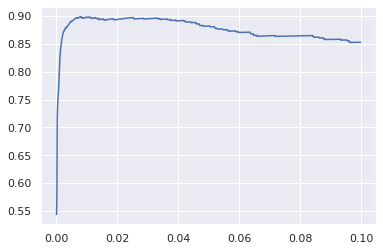

In [ ]:
DF = pd.read_csv(OUTPUT_DIR+"oof_df.csv")
#ベストな閾値を探す
Threshold_list = []
f_beta_score_list = []
for i in range(1000):
    Threshold = i*0.0001
    predictions = np.where(DF["preds"] < Threshold, 0, 1)
    Threshold_list.append(Threshold)
    f_beta_score_list.append(fbeta_score(DF["judgement"], predictions, beta=7.0))
sns.set()
plt.plot(Threshold_list, f_beta_score_list)
for i,j in zip(Threshold_list, f_beta_score_list):
    if j == max(f_beta_score_list):
        print('Best Threshold :', i)
        print('Best F-Beta-Score :', j)
        break

# 取得した最終層ベクトルを使って機械学習

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 209 kB 43.1 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 111 kB 64.6 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 144 kB 64.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=3d8084e8ccebb9b195269cf360c8eb230fab3bd6cfe894649de78d2cc4ca56ed
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
y_probList=[]
probList = []
Thres_avg = 0
score_avg = 0


for i in range(0,5):
  train_vec=pd.read_csv(f"trainvector_dataset_fold{i}.csv",index_col=["Unnamed: 0"])
  test_vec=pd.read_csv(f"testvector_dataset_fold{i}.csv",index_col=["Unnamed: 0"])
  X = train_vec.drop("label",axis=1)
  y = train_vec["label"]     
      
  from sklearn.model_selection import train_test_split
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,shuffle=False)
  X_val, X_eval, y_val, y_eval = train_test_split(X_val,y_val,test_size=0.5,shuffle=True)

  import optuna.integration.lightgbm as lgb
  dtrain = lgb.Dataset(X_train, label = y_train)
  dval = lgb.Dataset(X_val, label = y_val)

  param = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      "verbosity": -1,
      "boosting_type": "gbdt",    
  }
  best_params, history = {}, []

  gbm = lgb.train(param,
                  dtrain,
                  num_boost_round=200,
                  valid_sets=dval,
                  early_stopping_rounds=25
                )
  
  y_prob = gbm.predict(X_eval,num_iteration = gbm.best_iteration)
  Threshold,BestScore= bestFbeta(y_eval,y_prob)
  y_pred = np.where(y_prob>Threshold,0,1)
  Thres_avg += Threshold
  score_avg += BestScore
  
  predict = gbm.predict(test_vec,num_iteration = gbm.best_iteration)
  probList.append(predict)

score_avg = score_avg/5
Thres_avg = Thres_avg/5
print(f"CV:{score_avg} - Threshold:{Thres_avg}")
prob_mean = np.mean(probList,axis=0)
predict = pd.Series(np.where(prob_mean < Thres_avg, 0, 1))
predict.index=range(27145,67979)
predict.to_csv('submission_ML.csv',header=None)

[I 2021-10-12 00:23:56,963] A new study created in memory with name: no-name-496dad66-960d-4ace-943c-b3bef933ccb5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0778748
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0758928
[3]	valid_0's binary_logloss: 0.0744771
[4]	valid_0's binary_logloss: 0.0730771
[5]	valid_0's binary_logloss: 0.0718889
[6]	valid_0's binary_logloss: 0.0713827
[7]	valid_0's binary_logloss: 0.0704035
[8]	valid_0's binary_logloss: 0.0708134
[9]	valid_0's binary_logloss: 0.0698774
[10]	valid_0's binary_logloss: 0.0689466
[11]	valid_0's binary_logloss: 0.0689168
[12]	valid_0's binary_logloss: 0.0683921
[13]	valid_0's binary_logloss: 0.067861
[14]	valid_0's binary_logloss: 0.0674433
[15]	valid_0's binary_logloss: 0.0669879
[16]	valid_0's binary_logloss: 0.0668369
[17]	valid_0's binary_logloss: 0.0664216
[18]	valid_0's binary_logloss: 0.0666427
[19]	valid_0's binary_logloss: 0.0662141
[20]	valid_0's binary_logloss: 0.0658624
[21]	valid_0's binary_logloss: 0.065715
[22]	valid_0's binary_logloss: 0.0651831
[23]	valid_0's binary_logloss: 0.0645601
[24]	v

feature_fraction, val_score: 0.060527:  14%|#4        | 1/7 [00:11<01:06, 11.13s/it]

[95]	valid_0's binary_logloss: 0.0622288
[96]	valid_0's binary_logloss: 0.061753
[97]	valid_0's binary_logloss: 0.061787
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0605265
[1]	valid_0's binary_logloss: 0.0696516
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0677179
[3]	valid_0's binary_logloss: 0.0658138
[4]	valid_0's binary_logloss: 0.0650595
[5]	valid_0's binary_logloss: 0.0639064
[6]	valid_0's binary_logloss: 0.0631484
[7]	valid_0's binary_logloss: 0.0629397
[8]	valid_0's binary_logloss: 0.0621916
[9]	valid_0's binary_logloss: 0.0620082
[10]	valid_0's binary_logloss: 0.0620086
[11]	valid_0's binary_logloss: 0.0613214
[12]	valid_0's binary_logloss: 0.0606635
[13]	valid_0's binary_logloss: 0.0601749
[14]	valid_0's binary_logloss: 0.0599833
[15]	valid_0's binary_logloss: 0.0597925
[16]	valid_0's binary_logloss: 0.0597512
[17]	valid_0's binary_logloss: 0.0596168
[18]	valid_0's binary_logloss: 0.0590375
[19]	valid_0

feature_fraction, val_score: 0.057069:  29%|##8       | 2/7 [00:23<00:58, 11.64s/it]

[55]	valid_0's binary_logloss: 0.0587975
[56]	valid_0's binary_logloss: 0.0586115
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.057069
[1]	valid_0's binary_logloss: 0.0737721
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0719827
[3]	valid_0's binary_logloss: 0.0709578
[4]	valid_0's binary_logloss: 0.0698397
[5]	valid_0's binary_logloss: 0.0693751
[6]	valid_0's binary_logloss: 0.0693367
[7]	valid_0's binary_logloss: 0.0690648
[8]	valid_0's binary_logloss: 0.0684951
[9]	valid_0's binary_logloss: 0.0679126
[10]	valid_0's binary_logloss: 0.0675189
[11]	valid_0's binary_logloss: 0.0675322
[12]	valid_0's binary_logloss: 0.0674106
[13]	valid_0's binary_logloss: 0.0667546
[14]	valid_0's binary_logloss: 0.0668352
[15]	valid_0's binary_logloss: 0.0667608
[16]	valid_0's binary_logloss: 0.0671553
[17]	valid_0's binary_logloss: 0.0665828
[18]	valid_0's binary_logloss: 0.0658554
[19]	valid_0's binary_logloss: 0.0658669
[20]	valid_

feature_fraction, val_score: 0.057069:  43%|####2     | 3/7 [00:36<00:49, 12.30s/it]

[88]	valid_0's binary_logloss: 0.0636555
[89]	valid_0's binary_logloss: 0.0635901
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.0620399
[1]	valid_0's binary_logloss: 0.0743181
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0739762
[3]	valid_0's binary_logloss: 0.0728583
[4]	valid_0's binary_logloss: 0.0720629
[5]	valid_0's binary_logloss: 0.0714696
[6]	valid_0's binary_logloss: 0.0714304
[7]	valid_0's binary_logloss: 0.0714579
[8]	valid_0's binary_logloss: 0.0711227
[9]	valid_0's binary_logloss: 0.0708089
[10]	valid_0's binary_logloss: 0.0709516
[11]	valid_0's binary_logloss: 0.0713067
[12]	valid_0's binary_logloss: 0.0714374
[13]	valid_0's binary_logloss: 0.071279
[14]	valid_0's binary_logloss: 0.071058
[15]	valid_0's binary_logloss: 0.0712942
[16]	valid_0's binary_logloss: 0.0709226
[17]	valid_0's binary_logloss: 0.0709638
[18]	valid_0's binary_logloss: 0.0716652
[19]	valid_0's binary_logloss: 0.0715725
[20]	valid_0

feature_fraction, val_score: 0.057069:  57%|#####7    | 4/7 [00:45<00:33, 11.08s/it]

[61]	valid_0's binary_logloss: 0.0697471
[62]	valid_0's binary_logloss: 0.0697855
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.0693758
[1]	valid_0's binary_logloss: 0.0747206
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0729087
[3]	valid_0's binary_logloss: 0.0712742
[4]	valid_0's binary_logloss: 0.0701615
[5]	valid_0's binary_logloss: 0.0691863
[6]	valid_0's binary_logloss: 0.0680684
[7]	valid_0's binary_logloss: 0.0675799
[8]	valid_0's binary_logloss: 0.0669669
[9]	valid_0's binary_logloss: 0.0670013
[10]	valid_0's binary_logloss: 0.0659276
[11]	valid_0's binary_logloss: 0.0656254
[12]	valid_0's binary_logloss: 0.0657587
[13]	valid_0's binary_logloss: 0.0656199
[14]	valid_0's binary_logloss: 0.0656016
[15]	valid_0's binary_logloss: 0.0653113
[16]	valid_0's binary_logloss: 0.065004
[17]	valid_0's binary_logloss: 0.0647923
[18]	valid_0's binary_logloss: 0.0650222
[19]	valid_0's binary_logloss: 0.0652355
[20]	valid_

feature_fraction, val_score: 0.057069:  71%|#######1  | 5/7 [00:55<00:21, 10.67s/it]

[53]	valid_0's binary_logloss: 0.0673201
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.0635764
[1]	valid_0's binary_logloss: 0.0779694
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0750879
[3]	valid_0's binary_logloss: 0.0722364
[4]	valid_0's binary_logloss: 0.0701615
[5]	valid_0's binary_logloss: 0.0681964
[6]	valid_0's binary_logloss: 0.066393
[7]	valid_0's binary_logloss: 0.0656889
[8]	valid_0's binary_logloss: 0.0645752
[9]	valid_0's binary_logloss: 0.0633698
[10]	valid_0's binary_logloss: 0.0627999
[11]	valid_0's binary_logloss: 0.0622844
[12]	valid_0's binary_logloss: 0.0617779
[13]	valid_0's binary_logloss: 0.0613657
[14]	valid_0's binary_logloss: 0.0611545
[15]	valid_0's binary_logloss: 0.0609557
[16]	valid_0's binary_logloss: 0.0604167
[17]	valid_0's binary_logloss: 0.0600332
[18]	valid_0's binary_logloss: 0.0597878
[19]	valid_0's binary_logloss: 0.0597364
[20]	valid_0's binary_logloss: 0.0595682
[21]	valid_

feature_fraction, val_score: 0.056523:  86%|########5 | 6/7 [01:02<00:09,  9.52s/it]

[61]	valid_0's binary_logloss: 0.0587207
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.0565234
[1]	valid_0's binary_logloss: 0.071947
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0692267
[3]	valid_0's binary_logloss: 0.0666764
[4]	valid_0's binary_logloss: 0.0647492
[5]	valid_0's binary_logloss: 0.0627613
[6]	valid_0's binary_logloss: 0.061485
[7]	valid_0's binary_logloss: 0.0606922
[8]	valid_0's binary_logloss: 0.0597513
[9]	valid_0's binary_logloss: 0.0592992
[10]	valid_0's binary_logloss: 0.0583017
[11]	valid_0's binary_logloss: 0.0578763
[12]	valid_0's binary_logloss: 0.0574018
[13]	valid_0's binary_logloss: 0.0568821
[14]	valid_0's binary_logloss: 0.0564643
[15]	valid_0's binary_logloss: 0.0562164
[16]	valid_0's binary_logloss: 0.0554575
[17]	valid_0's binary_logloss: 0.0553066
[18]	valid_0's binary_logloss: 0.0547138
[19]	valid_0's binary_logloss: 0.0545806
[20]	valid_0's binary_logloss: 0.0545948
[21]	valid_0

feature_fraction, val_score: 0.051612: 100%|##########| 7/7 [01:16<00:00, 10.90s/it]


[73]	valid_0's binary_logloss: 0.0540222
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.0516124


num_leaves, val_score: 0.051612:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0725591
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0709346
[3]	valid_0's binary_logloss: 0.0682698
[4]	valid_0's binary_logloss: 0.0658965
[5]	valid_0's binary_logloss: 0.0643317
[6]	valid_0's binary_logloss: 0.062934
[7]	valid_0's binary_logloss: 0.0617147
[8]	valid_0's binary_logloss: 0.0613072
[9]	valid_0's binary_logloss: 0.0606736
[10]	valid_0's binary_logloss: 0.0601411
[11]	valid_0's binary_logloss: 0.0595207
[12]	valid_0's binary_logloss: 0.0592365
[13]	valid_0's binary_logloss: 0.0585408
[14]	valid_0's binary_logloss: 0.0580316
[15]	valid_0's binary_logloss: 0.0579769
[16]	valid_0's binary_logloss: 0.0580733
[17]	valid_0's binary_logloss: 0.0578164
[18]	valid_0's binary_logloss: 0.0580007
[19]	valid_0's binary_logloss: 0.0577859
[20]	valid_0's binary_logloss: 0.0573152
[21]	valid_0's binary_logloss: 0.0567272
[22]	valid_0's binary_logloss: 0.0564408
[23]	valid_0's binary_logloss: 0.0562917
[24]	

num_leaves, val_score: 0.051612:   5%|5         | 1/20 [00:16<05:09, 16.28s/it]

[55]	valid_0's binary_logloss: 0.0606781
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0559708
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704749
[3]	valid_0's binary_logloss: 0.0677771
[4]	valid_0's binary_logloss: 0.0660475
[5]	valid_0's binary_logloss: 0.0643138
[6]	valid_0's binary_logloss: 0.0628044
[7]	valid_0's binary_logloss: 0.0610384
[8]	valid_0's binary_logloss: 0.0602949
[9]	valid_0's binary_logloss: 0.0593139
[10]	valid_0's binary_logloss: 0.0583694
[11]	valid_0's binary_logloss: 0.0574237
[12]	valid_0's binary_logloss: 0.0566939
[13]	valid_0's binary_logloss: 0.0563953
[14]	valid_0's binary_logloss: 0.0556144
[15]	valid_0's binary_logloss: 0.0553527
[16]	valid_0's binary_logloss: 0.0552643
[17]	valid_0's binary_logloss: 0.055335
[18]	valid_0's binary_logloss: 0.0556223
[19]	valid_0's binary_logloss: 0.0554045
[20]	valid_0's binary_logloss: 0.0553378
[21]	valid_

num_leaves, val_score: 0.051612:  10%|#         | 2/20 [00:50<08:04, 26.94s/it]

[50]	valid_0's binary_logloss: 0.0589678
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0542801
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704748
[3]	valid_0's binary_logloss: 0.067777
[4]	valid_0's binary_logloss: 0.0660493
[5]	valid_0's binary_logloss: 0.0643152
[6]	valid_0's binary_logloss: 0.0628054
[7]	valid_0's binary_logloss: 0.0610394
[8]	valid_0's binary_logloss: 0.060294
[9]	valid_0's binary_logloss: 0.0593131
[10]	valid_0's binary_logloss: 0.0583686
[11]	valid_0's binary_logloss: 0.0574231
[12]	valid_0's binary_logloss: 0.0566982
[13]	valid_0's binary_logloss: 0.0563993
[14]	valid_0's binary_logloss: 0.0556176
[15]	valid_0's binary_logloss: 0.0553554
[16]	valid_0's binary_logloss: 0.0552683
[17]	valid_0's binary_logloss: 0.0553387
[18]	valid_0's binary_logloss: 0.0556171
[19]	valid_0's binary_logloss: 0.0553942
[20]	valid_0's binary_logloss: 0.0553292
[21]	valid_0

num_leaves, val_score: 0.051612:  15%|#5        | 3/20 [01:22<08:15, 29.13s/it]

[52]	valid_0's binary_logloss: 0.0616149
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.054286
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704747
[3]	valid_0's binary_logloss: 0.0677647
[4]	valid_0's binary_logloss: 0.066047
[5]	valid_0's binary_logloss: 0.0643262
[6]	valid_0's binary_logloss: 0.062813
[7]	valid_0's binary_logloss: 0.0611639
[8]	valid_0's binary_logloss: 0.0603886
[9]	valid_0's binary_logloss: 0.0594097
[10]	valid_0's binary_logloss: 0.0584175
[11]	valid_0's binary_logloss: 0.0572815
[12]	valid_0's binary_logloss: 0.0566513
[13]	valid_0's binary_logloss: 0.0561703
[14]	valid_0's binary_logloss: 0.0556534
[15]	valid_0's binary_logloss: 0.0556244
[16]	valid_0's binary_logloss: 0.0555406
[17]	valid_0's binary_logloss: 0.0554089
[18]	valid_0's binary_logloss: 0.0553303
[19]	valid_0's binary_logloss: 0.0551343
[20]	valid_0's binary_logloss: 0.0557012
[21]	valid_0'

num_leaves, val_score: 0.051612:  20%|##        | 4/20 [01:43<06:56, 26.03s/it]

[44]	valid_0's binary_logloss: 0.058418
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0551343
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704749
[3]	valid_0's binary_logloss: 0.067777
[4]	valid_0's binary_logloss: 0.0660493
[5]	valid_0's binary_logloss: 0.0643152
[6]	valid_0's binary_logloss: 0.0628055
[7]	valid_0's binary_logloss: 0.0610394
[8]	valid_0's binary_logloss: 0.0602941
[9]	valid_0's binary_logloss: 0.0593131
[10]	valid_0's binary_logloss: 0.0583687
[11]	valid_0's binary_logloss: 0.0574231
[12]	valid_0's binary_logloss: 0.0566983
[13]	valid_0's binary_logloss: 0.0563993
[14]	valid_0's binary_logloss: 0.0556176
[15]	valid_0's binary_logloss: 0.0553554
[16]	valid_0's binary_logloss: 0.0552682
[17]	valid_0's binary_logloss: 0.0553387
[18]	valid_0's binary_logloss: 0.0556171
[19]	valid_0's binary_logloss: 0.0553942
[20]	valid_0's binary_logloss: 0.0553292
[21]	valid_0

num_leaves, val_score: 0.051612:  25%|##5       | 5/20 [02:15<07:03, 28.23s/it]

[52]	valid_0's binary_logloss: 0.0593159
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.054286
[1]	valid_0's binary_logloss: 0.0726382
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0705189
[3]	valid_0's binary_logloss: 0.0682038
[4]	valid_0's binary_logloss: 0.0660873
[5]	valid_0's binary_logloss: 0.0648209
[6]	valid_0's binary_logloss: 0.0631333
[7]	valid_0's binary_logloss: 0.062296
[8]	valid_0's binary_logloss: 0.0619603
[9]	valid_0's binary_logloss: 0.0615168
[10]	valid_0's binary_logloss: 0.0609112
[11]	valid_0's binary_logloss: 0.0600253
[12]	valid_0's binary_logloss: 0.059257
[13]	valid_0's binary_logloss: 0.058881
[14]	valid_0's binary_logloss: 0.0584721
[15]	valid_0's binary_logloss: 0.0578441
[16]	valid_0's binary_logloss: 0.0574267
[17]	valid_0's binary_logloss: 0.0571965
[18]	valid_0's binary_logloss: 0.0566825
[19]	valid_0's binary_logloss: 0.0565081
[20]	valid_0's binary_logloss: 0.0559248
[21]	valid_0's

num_leaves, val_score: 0.051612:  30%|###       | 6/20 [02:29<05:27, 23.39s/it]

[61]	valid_0's binary_logloss: 0.0574558
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.0541786
[1]	valid_0's binary_logloss: 0.0725606
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0709428
[3]	valid_0's binary_logloss: 0.0682744
[4]	valid_0's binary_logloss: 0.0658639
[5]	valid_0's binary_logloss: 0.0639291
[6]	valid_0's binary_logloss: 0.0632717
[7]	valid_0's binary_logloss: 0.0613603
[8]	valid_0's binary_logloss: 0.0605574
[9]	valid_0's binary_logloss: 0.0602414
[10]	valid_0's binary_logloss: 0.059452
[11]	valid_0's binary_logloss: 0.058203
[12]	valid_0's binary_logloss: 0.0581596
[13]	valid_0's binary_logloss: 0.0580886
[14]	valid_0's binary_logloss: 0.0578362
[15]	valid_0's binary_logloss: 0.0580559
[16]	valid_0's binary_logloss: 0.0575811
[17]	valid_0's binary_logloss: 0.0575868
[18]	valid_0's binary_logloss: 0.0574755
[19]	valid_0's binary_logloss: 0.0573514
[20]	valid_0's binary_logloss: 0.0569482
[21]	valid_0

num_leaves, val_score: 0.051612:  35%|###5      | 7/20 [02:46<04:36, 21.25s/it]

[60]	valid_0's binary_logloss: 0.0591771
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0544411
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704748
[3]	valid_0's binary_logloss: 0.0677773
[4]	valid_0's binary_logloss: 0.0660589
[5]	valid_0's binary_logloss: 0.0643235
[6]	valid_0's binary_logloss: 0.062811
[7]	valid_0's binary_logloss: 0.0611987
[8]	valid_0's binary_logloss: 0.0604286
[9]	valid_0's binary_logloss: 0.0594489
[10]	valid_0's binary_logloss: 0.0584591
[11]	valid_0's binary_logloss: 0.0573192
[12]	valid_0's binary_logloss: 0.0569812
[13]	valid_0's binary_logloss: 0.0565118
[14]	valid_0's binary_logloss: 0.0559466
[15]	valid_0's binary_logloss: 0.0557271
[16]	valid_0's binary_logloss: 0.055618
[17]	valid_0's binary_logloss: 0.0555524
[18]	valid_0's binary_logloss: 0.0553734
[19]	valid_0's binary_logloss: 0.0554095
[20]	valid_0's binary_logloss: 0.0555965
[21]	valid_0

num_leaves, val_score: 0.051612:  40%|####      | 8/20 [03:14<04:39, 23.26s/it]

[52]	valid_0's binary_logloss: 0.0603129
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.0541478
[1]	valid_0's binary_logloss: 0.0730317
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.071063
[3]	valid_0's binary_logloss: 0.0682755
[4]	valid_0's binary_logloss: 0.0662199
[5]	valid_0's binary_logloss: 0.0643244
[6]	valid_0's binary_logloss: 0.0620705
[7]	valid_0's binary_logloss: 0.0601878
[8]	valid_0's binary_logloss: 0.0588553
[9]	valid_0's binary_logloss: 0.0579227
[10]	valid_0's binary_logloss: 0.0570888
[11]	valid_0's binary_logloss: 0.0561774
[12]	valid_0's binary_logloss: 0.0555014
[13]	valid_0's binary_logloss: 0.0552475
[14]	valid_0's binary_logloss: 0.054592
[15]	valid_0's binary_logloss: 0.0544918
[16]	valid_0's binary_logloss: 0.0543973
[17]	valid_0's binary_logloss: 0.0544117
[18]	valid_0's binary_logloss: 0.054354
[19]	valid_0's binary_logloss: 0.0543
[20]	valid_0's binary_logloss: 0.0539118
[21]	valid_0's b

num_leaves, val_score: 0.051612:  45%|####5     | 9/20 [03:31<03:54, 21.30s/it]

[49]	valid_0's binary_logloss: 0.057201
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0533188
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704704
[3]	valid_0's binary_logloss: 0.0677678
[4]	valid_0's binary_logloss: 0.0660446
[5]	valid_0's binary_logloss: 0.0642964
[6]	valid_0's binary_logloss: 0.0627651
[7]	valid_0's binary_logloss: 0.0610599
[8]	valid_0's binary_logloss: 0.0601986
[9]	valid_0's binary_logloss: 0.058977
[10]	valid_0's binary_logloss: 0.0584853
[11]	valid_0's binary_logloss: 0.0575432
[12]	valid_0's binary_logloss: 0.057108
[13]	valid_0's binary_logloss: 0.0566414
[14]	valid_0's binary_logloss: 0.0560032
[15]	valid_0's binary_logloss: 0.0560715
[16]	valid_0's binary_logloss: 0.055997
[17]	valid_0's binary_logloss: 0.0558557
[18]	valid_0's binary_logloss: 0.0557154
[19]	valid_0's binary_logloss: 0.055451
[20]	valid_0's binary_logloss: 0.0558263
[21]	valid_0's 

num_leaves, val_score: 0.051612:  50%|#####     | 10/20 [03:48<03:21, 20.11s/it]

[44]	valid_0's binary_logloss: 0.0594976
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.055451
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704841
[3]	valid_0's binary_logloss: 0.0677633
[4]	valid_0's binary_logloss: 0.0660435
[5]	valid_0's binary_logloss: 0.0643268
[6]	valid_0's binary_logloss: 0.0628091
[7]	valid_0's binary_logloss: 0.0616866
[8]	valid_0's binary_logloss: 0.0609496
[9]	valid_0's binary_logloss: 0.0596836
[10]	valid_0's binary_logloss: 0.0590055
[11]	valid_0's binary_logloss: 0.0578852
[12]	valid_0's binary_logloss: 0.0574194
[13]	valid_0's binary_logloss: 0.0570223
[14]	valid_0's binary_logloss: 0.0563441
[15]	valid_0's binary_logloss: 0.0564248
[16]	valid_0's binary_logloss: 0.0559857
[17]	valid_0's binary_logloss: 0.0556906
[18]	valid_0's binary_logloss: 0.0551638
[19]	valid_0's binary_logloss: 0.0550165
[20]	valid_0's binary_logloss: 0.0547355
[21]	valid_

num_leaves, val_score: 0.051612:  55%|#####5    | 11/20 [04:06<02:54, 19.43s/it]

[46]	valid_0's binary_logloss: 0.0595476
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0545053
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704747
[3]	valid_0's binary_logloss: 0.0677772
[4]	valid_0's binary_logloss: 0.0660582
[5]	valid_0's binary_logloss: 0.0643377
[6]	valid_0's binary_logloss: 0.0628235
[7]	valid_0's binary_logloss: 0.0612101
[8]	valid_0's binary_logloss: 0.0604383
[9]	valid_0's binary_logloss: 0.0594582
[10]	valid_0's binary_logloss: 0.0584621
[11]	valid_0's binary_logloss: 0.0573209
[12]	valid_0's binary_logloss: 0.0566644
[13]	valid_0's binary_logloss: 0.0560221
[14]	valid_0's binary_logloss: 0.0553231
[15]	valid_0's binary_logloss: 0.0550602
[16]	valid_0's binary_logloss: 0.054754
[17]	valid_0's binary_logloss: 0.0546678
[18]	valid_0's binary_logloss: 0.054773
[19]	valid_0's binary_logloss: 0.0546538
[20]	valid_0's binary_logloss: 0.0543377
[21]	valid_0

num_leaves, val_score: 0.051612:  60%|######    | 12/20 [04:29<02:44, 20.54s/it]

[45]	valid_0's binary_logloss: 0.0579805
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0543377
[1]	valid_0's binary_logloss: 0.0710615
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0670571
[3]	valid_0's binary_logloss: 0.06411
[4]	valid_0's binary_logloss: 0.0622536
[5]	valid_0's binary_logloss: 0.0609319
[6]	valid_0's binary_logloss: 0.0596546
[7]	valid_0's binary_logloss: 0.0589381
[8]	valid_0's binary_logloss: 0.058298
[9]	valid_0's binary_logloss: 0.057477
[10]	valid_0's binary_logloss: 0.05685
[11]	valid_0's binary_logloss: 0.0565211
[12]	valid_0's binary_logloss: 0.0562168
[13]	valid_0's binary_logloss: 0.0559632
[14]	valid_0's binary_logloss: 0.0554457
[15]	valid_0's binary_logloss: 0.0550508
[16]	valid_0's binary_logloss: 0.0547339
[17]	valid_0's binary_logloss: 0.0547409
[18]	valid_0's binary_logloss: 0.0546522
[19]	valid_0's binary_logloss: 0.054395
[20]	valid_0's binary_logloss: 0.0540089
[21]	valid_0's bi

num_leaves, val_score: 0.048035:  65%|######5   | 13/20 [04:38<01:59, 17.12s/it]

[195]	valid_0's binary_logloss: 0.0486976
[196]	valid_0's binary_logloss: 0.0487048
[197]	valid_0's binary_logloss: 0.0486289
[198]	valid_0's binary_logloss: 0.0487407
[199]	valid_0's binary_logloss: 0.0485447
[200]	valid_0's binary_logloss: 0.0485447
Did not meet early stopping. Best iteration is:
[181]	valid_0's binary_logloss: 0.0480348
[1]	valid_0's binary_logloss: 0.0695328
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660233
[3]	valid_0's binary_logloss: 0.0631882
[4]	valid_0's binary_logloss: 0.0608427
[5]	valid_0's binary_logloss: 0.0590363
[6]	valid_0's binary_logloss: 0.057857
[7]	valid_0's binary_logloss: 0.0565333
[8]	valid_0's binary_logloss: 0.0558169
[9]	valid_0's binary_logloss: 0.0549789
[10]	valid_0's binary_logloss: 0.0541719
[11]	valid_0's binary_logloss: 0.0533614
[12]	valid_0's binary_logloss: 0.0528634
[13]	valid_0's binary_logloss: 0.0523441
[14]	valid_0's binary_logloss: 0.0519175
[15]	valid_0's binary_logloss: 0

num_leaves, val_score: 0.047708:  70%|#######   | 14/20 [04:49<01:30, 15.10s/it]

[96]	valid_0's binary_logloss: 0.0494754
[97]	valid_0's binary_logloss: 0.0495187
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0477076
[1]	valid_0's binary_logloss: 0.0707879
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0663734
[3]	valid_0's binary_logloss: 0.0632839
[4]	valid_0's binary_logloss: 0.0610608
[5]	valid_0's binary_logloss: 0.059435
[6]	valid_0's binary_logloss: 0.058105
[7]	valid_0's binary_logloss: 0.0572389
[8]	valid_0's binary_logloss: 0.0564374
[9]	valid_0's binary_logloss: 0.0559404
[10]	valid_0's binary_logloss: 0.0553952
[11]	valid_0's binary_logloss: 0.0549137
[12]	valid_0's binary_logloss: 0.0546267
[13]	valid_0's binary_logloss: 0.0545612
[14]	valid_0's binary_logloss: 0.0539941
[15]	valid_0's binary_logloss: 0.0538488
[16]	valid_0's binary_logloss: 0.0535984
[17]	valid_0's binary_logloss: 0.053445
[18]	valid_0's binary_logloss: 0.0532992
[19]	valid_0's binary_logloss: 0.0532853
[20]	valid_0'

num_leaves, val_score: 0.047708:  75%|#######5  | 15/20 [04:55<01:02, 12.54s/it]

[115]	valid_0's binary_logloss: 0.0503048
[116]	valid_0's binary_logloss: 0.0502913
[117]	valid_0's binary_logloss: 0.0502563
[118]	valid_0's binary_logloss: 0.0500439
[119]	valid_0's binary_logloss: 0.0500612
[120]	valid_0's binary_logloss: 0.0500633
[121]	valid_0's binary_logloss: 0.0500384
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.0499947
[1]	valid_0's binary_logloss: 0.0724147
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.068497
[3]	valid_0's binary_logloss: 0.0659958
[4]	valid_0's binary_logloss: 0.0637272
[5]	valid_0's binary_logloss: 0.0618746
[6]	valid_0's binary_logloss: 0.0608539
[7]	valid_0's binary_logloss: 0.0598636
[8]	valid_0's binary_logloss: 0.0590632
[9]	valid_0's binary_logloss: 0.05818
[10]	valid_0's binary_logloss: 0.057608
[11]	valid_0's binary_logloss: 0.0571973
[12]	valid_0's binary_logloss: 0.0571254
[13]	valid_0's binary_logloss: 0.0567702
[14]	valid_0's binary_logloss: 0.0564639
[15]	va

num_leaves, val_score: 0.047708:  80%|########  | 16/20 [05:02<00:43, 10.83s/it]

[94]	valid_0's binary_logloss: 0.0518406
[95]	valid_0's binary_logloss: 0.0518349
[96]	valid_0's binary_logloss: 0.0518181
[97]	valid_0's binary_logloss: 0.0518018
[98]	valid_0's binary_logloss: 0.0518098
[99]	valid_0's binary_logloss: 0.0517324
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.051474
[1]	valid_0's binary_logloss: 0.0718302
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0688828
[3]	valid_0's binary_logloss: 0.0667428
[4]	valid_0's binary_logloss: 0.0642796
[5]	valid_0's binary_logloss: 0.0625354
[6]	valid_0's binary_logloss: 0.0612222
[7]	valid_0's binary_logloss: 0.0602048
[8]	valid_0's binary_logloss: 0.0597513
[9]	valid_0's binary_logloss: 0.0594186
[10]	valid_0's binary_logloss: 0.0587836
[11]	valid_0's binary_logloss: 0.0581998
[12]	valid_0's binary_logloss: 0.0575571
[13]	valid_0's binary_logloss: 0.0570496
[14]	valid_0's binary_logloss: 0.0564742
[15]	valid_0's binary_logloss: 0.0559727
[16]	valid_

num_leaves, val_score: 0.047708:  85%|########5 | 17/20 [05:15<00:33, 11.32s/it]

[77]	valid_0's binary_logloss: 0.0537621
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0525933
[1]	valid_0's binary_logloss: 0.0726258
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0706992
[3]	valid_0's binary_logloss: 0.0680514
[4]	valid_0's binary_logloss: 0.0659434
[5]	valid_0's binary_logloss: 0.0642515
[6]	valid_0's binary_logloss: 0.0628317
[7]	valid_0's binary_logloss: 0.0615728
[8]	valid_0's binary_logloss: 0.0608976
[9]	valid_0's binary_logloss: 0.0599369
[10]	valid_0's binary_logloss: 0.0592016
[11]	valid_0's binary_logloss: 0.0581477
[12]	valid_0's binary_logloss: 0.0575962
[13]	valid_0's binary_logloss: 0.0576171
[14]	valid_0's binary_logloss: 0.056315
[15]	valid_0's binary_logloss: 0.0559612
[16]	valid_0's binary_logloss: 0.0557485
[17]	valid_0's binary_logloss: 0.0553076
[18]	valid_0's binary_logloss: 0.0552215
[19]	valid_0's binary_logloss: 0.055027
[20]	valid_0's binary_logloss: 0.0546002
[21]	valid_0

num_leaves, val_score: 0.047708:  90%|######### | 18/20 [05:28<00:24, 12.03s/it]

[54]	valid_0's binary_logloss: 0.0574532
[55]	valid_0's binary_logloss: 0.057531
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0534669


[I 2021-10-12 00:30:42,195] Trial 24 finished with value: 0.05346689201882449 and parameters: {'num_leaves': 47}. Best is trial 20 with value: 0.04770762064888558.
num_leaves, val_score: 0.047708:  90%|######### | 18/20 [05:28<00:24, 12.03s/it]

[1]	valid_0's binary_logloss: 0.0712988
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0683639
[3]	valid_0's binary_logloss: 0.0660416
[4]	valid_0's binary_logloss: 0.0642165
[5]	valid_0's binary_logloss: 0.0627983
[6]	valid_0's binary_logloss: 0.061469
[7]	valid_0's binary_logloss: 0.06082
[8]	valid_0's binary_logloss: 0.0598599
[9]	valid_0's binary_logloss: 0.0591021
[10]	valid_0's binary_logloss: 0.0584028
[11]	valid_0's binary_logloss: 0.0579667
[12]	valid_0's binary_logloss: 0.0582394
[13]	valid_0's binary_logloss: 0.057994
[14]	valid_0's binary_logloss: 0.0576473
[15]	valid_0's binary_logloss: 0.0573583
[16]	valid_0's binary_logloss: 0.0571203
[17]	valid_0's binary_logloss: 0.0570676
[18]	valid_0's binary_logloss: 0.0566437
[19]	valid_0's binary_logloss: 0.0562317
[20]	valid_0's binary_logloss: 0.0561218
[21]	valid_0's binary_logloss: 0.0558225
[22]	valid_0's binary_logloss: 0.0556939
[23]	valid_0's binary_logloss: 0.0557198
[24]	val

num_leaves, val_score: 0.047708:  95%|#########5| 19/20 [05:40<00:11, 11.77s/it]

[64]	valid_0's binary_logloss: 0.0555252
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.0546366
[1]	valid_0's binary_logloss: 0.0729648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0704757
[3]	valid_0's binary_logloss: 0.0677827
[4]	valid_0's binary_logloss: 0.0660643
[5]	valid_0's binary_logloss: 0.0642397
[6]	valid_0's binary_logloss: 0.0627073
[7]	valid_0's binary_logloss: 0.0610562
[8]	valid_0's binary_logloss: 0.0600829
[9]	valid_0's binary_logloss: 0.0592502
[10]	valid_0's binary_logloss: 0.0583676
[11]	valid_0's binary_logloss: 0.0575229
[12]	valid_0's binary_logloss: 0.0568085
[13]	valid_0's binary_logloss: 0.0564509
[14]	valid_0's binary_logloss: 0.0565147
[15]	valid_0's binary_logloss: 0.0563815
[16]	valid_0's binary_logloss: 0.0563414
[17]	valid_0's binary_logloss: 0.0560687
[18]	valid_0's binary_logloss: 0.0557977
[19]	valid_0's binary_logloss: 0.0557576
[20]	valid_0's binary_logloss: 0.0555693
[21]	valid

num_leaves, val_score: 0.047708: 100%|##########| 20/20 [06:05<00:00, 18.25s/it]


[59]	valid_0's binary_logloss: 0.0609592
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.055421


bagging, val_score: 0.047708:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0738918
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0711913
[3]	valid_0's binary_logloss: 0.0694937
[4]	valid_0's binary_logloss: 0.0677366
[5]	valid_0's binary_logloss: 0.0660656
[6]	valid_0's binary_logloss: 0.0652411
[7]	valid_0's binary_logloss: 0.0643348
[8]	valid_0's binary_logloss: 0.0630722
[9]	valid_0's binary_logloss: 0.0625476
[10]	valid_0's binary_logloss: 0.0620533
[11]	valid_0's binary_logloss: 0.06148
[12]	valid_0's binary_logloss: 0.0609401
[13]	valid_0's binary_logloss: 0.0606362
[14]	valid_0's binary_logloss: 0.0603003
[15]	valid_0's binary_logloss: 0.0604783
[16]	valid_0's binary_logloss: 0.0602011
[17]	valid_0's binary_logloss: 0.0601033
[18]	valid_0's binary_logloss: 0.0598777
[19]	valid_0's binary_logloss: 0.0597297
[20]	valid_0's binary_logloss: 0.0597879
[21]	valid_0's binary_logloss: 0.0595966
[22]	valid_0's binary_logloss: 0.0593341
[23]	valid_0's binary_logloss: 0.0592718
[24]	v

bagging, val_score: 0.047708:  10%|#         | 1/10 [00:11<01:46, 11.83s/it]

[114]	valid_0's binary_logloss: 0.0548348
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.0541581
[1]	valid_0's binary_logloss: 0.0725077
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0701639
[3]	valid_0's binary_logloss: 0.068687
[4]	valid_0's binary_logloss: 0.067874
[5]	valid_0's binary_logloss: 0.067024
[6]	valid_0's binary_logloss: 0.0660538
[7]	valid_0's binary_logloss: 0.0656009
[8]	valid_0's binary_logloss: 0.0658436
[9]	valid_0's binary_logloss: 0.0646363
[10]	valid_0's binary_logloss: 0.0643881
[11]	valid_0's binary_logloss: 0.0636684
[12]	valid_0's binary_logloss: 0.0628418
[13]	valid_0's binary_logloss: 0.062731
[14]	valid_0's binary_logloss: 0.0625141
[15]	valid_0's binary_logloss: 0.0623326
[16]	valid_0's binary_logloss: 0.0614289
[17]	valid_0's binary_logloss: 0.0612616
[18]	valid_0's binary_logloss: 0.0611983
[19]	valid_0's binary_logloss: 0.060371
[20]	valid_0's binary_logloss: 0.0602878
[21]	valid_0's

bagging, val_score: 0.047708:  20%|##        | 2/10 [00:18<01:09,  8.65s/it]

[53]	valid_0's binary_logloss: 0.0613758
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.0595702
[1]	valid_0's binary_logloss: 0.0647673
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0628656
[3]	valid_0's binary_logloss: 0.0613595
[4]	valid_0's binary_logloss: 0.059356
[5]	valid_0's binary_logloss: 0.0579958
[6]	valid_0's binary_logloss: 0.0573262
[7]	valid_0's binary_logloss: 0.0570212
[8]	valid_0's binary_logloss: 0.057195
[9]	valid_0's binary_logloss: 0.0567648
[10]	valid_0's binary_logloss: 0.0569368
[11]	valid_0's binary_logloss: 0.0573636
[12]	valid_0's binary_logloss: 0.0573047
[13]	valid_0's binary_logloss: 0.0568858
[14]	valid_0's binary_logloss: 0.0567326
[15]	valid_0's binary_logloss: 0.0566686
[16]	valid_0's binary_logloss: 0.0564519
[17]	valid_0's binary_logloss: 0.0563611
[18]	valid_0's binary_logloss: 0.0563927
[19]	valid_0's binary_logloss: 0.0560527
[20]	valid_0's binary_logloss: 0.0557941
[21]	valid_0

bagging, val_score: 0.047708:  30%|###       | 3/10 [00:24<00:52,  7.50s/it]

[47]	valid_0's binary_logloss: 0.0571375
[48]	valid_0's binary_logloss: 0.057364
[49]	valid_0's binary_logloss: 0.0577971
[50]	valid_0's binary_logloss: 0.0581317
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0544079
[1]	valid_0's binary_logloss: 0.0713073
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.070238
[3]	valid_0's binary_logloss: 0.069727
[4]	valid_0's binary_logloss: 0.0684075
[5]	valid_0's binary_logloss: 0.0673872
[6]	valid_0's binary_logloss: 0.0669977
[7]	valid_0's binary_logloss: 0.0670206
[8]	valid_0's binary_logloss: 0.0668684
[9]	valid_0's binary_logloss: 0.0669436
[10]	valid_0's binary_logloss: 0.0670543
[11]	valid_0's binary_logloss: 0.0667627
[12]	valid_0's binary_logloss: 0.0666877
[13]	valid_0's binary_logloss: 0.0668437
[14]	valid_0's binary_logloss: 0.0669308
[15]	valid_0's binary_logloss: 0.0673036
[16]	valid_0's binary_logloss: 0.067318
[17]	valid_0's binary_logloss: 0.0680602
[18]	valid_0's

bagging, val_score: 0.047708:  40%|####      | 4/10 [00:30<00:40,  6.76s/it]

[36]	valid_0's binary_logloss: 0.0667752
[37]	valid_0's binary_logloss: 0.0671667
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.0666877
[1]	valid_0's binary_logloss: 0.0785109
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0751868
[3]	valid_0's binary_logloss: 0.0728086
[4]	valid_0's binary_logloss: 0.0711574
[5]	valid_0's binary_logloss: 0.0692483
[6]	valid_0's binary_logloss: 0.0679795
[7]	valid_0's binary_logloss: 0.0661727
[8]	valid_0's binary_logloss: 0.064798
[9]	valid_0's binary_logloss: 0.063569
[10]	valid_0's binary_logloss: 0.0630009
[11]	valid_0's binary_logloss: 0.0624912
[12]	valid_0's binary_logloss: 0.0616659
[13]	valid_0's binary_logloss: 0.0614131
[14]	valid_0's binary_logloss: 0.0605519
[15]	valid_0's binary_logloss: 0.0600575
[16]	valid_0's binary_logloss: 0.0596598
[17]	valid_0's binary_logloss: 0.059303
[18]	valid_0's binary_logloss: 0.0588177
[19]	valid_0's binary_logloss: 0.0584405
[20]	valid_0'

bagging, val_score: 0.047708:  50%|#####     | 5/10 [00:39<00:37,  7.60s/it]

[85]	valid_0's binary_logloss: 0.0628454
[86]	valid_0's binary_logloss: 0.0549111
[87]	valid_0's binary_logloss: 0.0675783
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0541894
[1]	valid_0's binary_logloss: 0.0789784
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0739196
[3]	valid_0's binary_logloss: 0.0713738
[4]	valid_0's binary_logloss: 0.0695712
[5]	valid_0's binary_logloss: 0.0678759
[6]	valid_0's binary_logloss: 0.0662966
[7]	valid_0's binary_logloss: 0.0650898
[8]	valid_0's binary_logloss: 0.0643143
[9]	valid_0's binary_logloss: 0.063199
[10]	valid_0's binary_logloss: 0.0625841
[11]	valid_0's binary_logloss: 0.0620537
[12]	valid_0's binary_logloss: 0.0619965
[13]	valid_0's binary_logloss: 0.0616101
[14]	valid_0's binary_logloss: 0.061424
[15]	valid_0's binary_logloss: 0.0610862
[16]	valid_0's binary_logloss: 0.0606706
[17]	valid_0's binary_logloss: 0.0601931
[18]	valid_0's binary_logloss: 0.0596295
[19]	valid_0

bagging, val_score: 0.047708:  60%|######    | 6/10 [00:47<00:31,  7.94s/it]

[68]	valid_0's binary_logloss: 0.0555984
[69]	valid_0's binary_logloss: 0.0555894
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.0553324
[1]	valid_0's binary_logloss: 0.0743635
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0714204
[3]	valid_0's binary_logloss: 0.0689303
[4]	valid_0's binary_logloss: 0.0673191
[5]	valid_0's binary_logloss: 0.0659183
[6]	valid_0's binary_logloss: 0.0645373
[7]	valid_0's binary_logloss: 0.0633822
[8]	valid_0's binary_logloss: 0.062909
[9]	valid_0's binary_logloss: 0.0619668
[10]	valid_0's binary_logloss: 0.0610573
[11]	valid_0's binary_logloss: 0.0607883
[12]	valid_0's binary_logloss: 0.0604231
[13]	valid_0's binary_logloss: 0.060113
[14]	valid_0's binary_logloss: 0.0598622
[15]	valid_0's binary_logloss: 0.0592432
[16]	valid_0's binary_logloss: 0.0588859
[17]	valid_0's binary_logloss: 0.0583802
[18]	valid_0's binary_logloss: 0.0584331
[19]	valid_0's binary_logloss: 0.058514
[20]	valid_0'

bagging, val_score: 0.047708:  70%|#######   | 7/10 [00:55<00:23,  7.82s/it]

[59]	valid_0's binary_logloss: 0.0564815
[60]	valid_0's binary_logloss: 0.056513
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0553693
[1]	valid_0's binary_logloss: 0.0707673
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0679578
[3]	valid_0's binary_logloss: 0.0659958
[4]	valid_0's binary_logloss: 0.0646911
[5]	valid_0's binary_logloss: 0.0642037
[6]	valid_0's binary_logloss: 0.0632721
[7]	valid_0's binary_logloss: 0.0631528
[8]	valid_0's binary_logloss: 0.0626842
[9]	valid_0's binary_logloss: 0.0625692
[10]	valid_0's binary_logloss: 0.0628913
[11]	valid_0's binary_logloss: 0.0631677
[12]	valid_0's binary_logloss: 0.0632655
[13]	valid_0's binary_logloss: 0.0633235
[14]	valid_0's binary_logloss: 0.0628824
[15]	valid_0's binary_logloss: 0.0625865
[16]	valid_0's binary_logloss: 0.0622019
[17]	valid_0's binary_logloss: 0.0613721
[18]	valid_0's binary_logloss: 0.0618442
[19]	valid_0's binary_logloss: 0.0620293
[20]	valid_

bagging, val_score: 0.047708:  80%|########  | 8/10 [01:07<00:18,  9.36s/it]

[130]	valid_0's binary_logloss: 0.0600307
[131]	valid_0's binary_logloss: 0.0600501
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.0581696
[1]	valid_0's binary_logloss: 0.0721809
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0703715
[3]	valid_0's binary_logloss: 0.0694732
[4]	valid_0's binary_logloss: 0.0688247
[5]	valid_0's binary_logloss: 0.0687099
[6]	valid_0's binary_logloss: 0.068844
[7]	valid_0's binary_logloss: 0.0687394
[8]	valid_0's binary_logloss: 0.0682125
[9]	valid_0's binary_logloss: 0.0673321
[10]	valid_0's binary_logloss: 0.0675508
[11]	valid_0's binary_logloss: 0.0673509
[12]	valid_0's binary_logloss: 0.0673719
[13]	valid_0's binary_logloss: 0.0673464
[14]	valid_0's binary_logloss: 0.0665454
[15]	valid_0's binary_logloss: 0.0664506
[16]	valid_0's binary_logloss: 0.0663396
[17]	valid_0's binary_logloss: 0.0662212
[18]	valid_0's binary_logloss: 0.0660331
[19]	valid_0's binary_logloss: 0.0651744
[20]	val

bagging, val_score: 0.047708:  90%|######### | 9/10 [01:18<00:09,  9.58s/it]

[91]	valid_0's binary_logloss: 0.0568784
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0560996
[1]	valid_0's binary_logloss: 0.074313
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0728845
[3]	valid_0's binary_logloss: 0.0713389
[4]	valid_0's binary_logloss: 0.0714734
[5]	valid_0's binary_logloss: 0.0715726
[6]	valid_0's binary_logloss: 0.0713573
[7]	valid_0's binary_logloss: 0.0713511
[8]	valid_0's binary_logloss: 0.0711479
[9]	valid_0's binary_logloss: 0.0709564
[10]	valid_0's binary_logloss: 0.070714
[11]	valid_0's binary_logloss: 0.0710131
[12]	valid_0's binary_logloss: 0.0710504
[13]	valid_0's binary_logloss: 0.0707769
[14]	valid_0's binary_logloss: 0.0703423
[15]	valid_0's binary_logloss: 0.0702154
[16]	valid_0's binary_logloss: 0.0698614
[17]	valid_0's binary_logloss: 0.06899
[18]	valid_0's binary_logloss: 0.0687658
[19]	valid_0's binary_logloss: 0.0678076
[20]	valid_0's binary_logloss: 0.0679508
[21]	valid_0's

bagging, val_score: 0.047708: 100%|##########| 10/10 [01:24<00:00,  8.44s/it]


[50]	valid_0's binary_logloss: 0.0679847
[51]	valid_0's binary_logloss: 0.0672712
[52]	valid_0's binary_logloss: 0.0669579
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.0657356


feature_fraction_stage2, val_score: 0.047708:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0737835
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.070599
[3]	valid_0's binary_logloss: 0.0681714
[4]	valid_0's binary_logloss: 0.0659475
[5]	valid_0's binary_logloss: 0.0643922
[6]	valid_0's binary_logloss: 0.0634094
[7]	valid_0's binary_logloss: 0.0628581
[8]	valid_0's binary_logloss: 0.0619199
[9]	valid_0's binary_logloss: 0.0613157
[10]	valid_0's binary_logloss: 0.0604121
[11]	valid_0's binary_logloss: 0.0603886
[12]	valid_0's binary_logloss: 0.0599298
[13]	valid_0's binary_logloss: 0.0598996
[14]	valid_0's binary_logloss: 0.0595097
[15]	valid_0's binary_logloss: 0.0592704
[16]	valid_0's binary_logloss: 0.0591906
[17]	valid_0's binary_logloss: 0.058974
[18]	valid_0's binary_logloss: 0.0590586
[19]	valid_0's binary_logloss: 0.0589468
[20]	valid_0's binary_logloss: 0.0589837
[21]	valid_0's binary_logloss: 0.0587957
[22]	valid_0's binary_logloss: 0.0585509
[23]	valid_0's binary_logloss: 0.0583784
[24]	v

feature_fraction_stage2, val_score: 0.047708:  17%|#6        | 1/6 [00:09<00:49,  9.88s/it]

[90]	valid_0's binary_logloss: 0.0565419
[91]	valid_0's binary_logloss: 0.0565282
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0552882
[1]	valid_0's binary_logloss: 0.0743031
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0714342
[3]	valid_0's binary_logloss: 0.0696753
[4]	valid_0's binary_logloss: 0.0681539
[5]	valid_0's binary_logloss: 0.0668816
[6]	valid_0's binary_logloss: 0.065933
[7]	valid_0's binary_logloss: 0.0652087
[8]	valid_0's binary_logloss: 0.0645046
[9]	valid_0's binary_logloss: 0.0638058
[10]	valid_0's binary_logloss: 0.0632551
[11]	valid_0's binary_logloss: 0.0628546
[12]	valid_0's binary_logloss: 0.062366
[13]	valid_0's binary_logloss: 0.0618863
[14]	valid_0's binary_logloss: 0.0616106
[15]	valid_0's binary_logloss: 0.061333
[16]	valid_0's binary_logloss: 0.0618026
[17]	valid_0's binary_logloss: 0.061517
[18]	valid_0's binary_logloss: 0.0614856
[19]	valid_0's binary_logloss: 0.0614798
[20]	valid_0's

feature_fraction_stage2, val_score: 0.047708:  33%|###3      | 2/6 [00:19<00:38,  9.67s/it]

[87]	valid_0's binary_logloss: 0.0585806
[88]	valid_0's binary_logloss: 0.0585643
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0583008
[1]	valid_0's binary_logloss: 0.0731883
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0701237
[3]	valid_0's binary_logloss: 0.0681379
[4]	valid_0's binary_logloss: 0.0665135
[5]	valid_0's binary_logloss: 0.0652613
[6]	valid_0's binary_logloss: 0.0640579
[7]	valid_0's binary_logloss: 0.0629064
[8]	valid_0's binary_logloss: 0.0625367
[9]	valid_0's binary_logloss: 0.0619755
[10]	valid_0's binary_logloss: 0.0612679
[11]	valid_0's binary_logloss: 0.0603519
[12]	valid_0's binary_logloss: 0.059916
[13]	valid_0's binary_logloss: 0.05971
[14]	valid_0's binary_logloss: 0.0595294
[15]	valid_0's binary_logloss: 0.0591648
[16]	valid_0's binary_logloss: 0.0588116
[17]	valid_0's binary_logloss: 0.058301
[18]	valid_0's binary_logloss: 0.0578939
[19]	valid_0's binary_logloss: 0.0577175
[20]	valid_0's

feature_fraction_stage2, val_score: 0.047708:  50%|#####     | 3/6 [00:32<00:33, 11.15s/it]

[117]	valid_0's binary_logloss: 0.0541614
[118]	valid_0's binary_logloss: 0.0543568
[119]	valid_0's binary_logloss: 0.0543468
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0531713
[1]	valid_0's binary_logloss: 0.0733404
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0699457
[3]	valid_0's binary_logloss: 0.0678221
[4]	valid_0's binary_logloss: 0.0660291
[5]	valid_0's binary_logloss: 0.0645355
[6]	valid_0's binary_logloss: 0.0630972
[7]	valid_0's binary_logloss: 0.0619336
[8]	valid_0's binary_logloss: 0.0613426
[9]	valid_0's binary_logloss: 0.0608116
[10]	valid_0's binary_logloss: 0.0601805
[11]	valid_0's binary_logloss: 0.0596725
[12]	valid_0's binary_logloss: 0.0591086
[13]	valid_0's binary_logloss: 0.0587114
[14]	valid_0's binary_logloss: 0.0582246
[15]	valid_0's binary_logloss: 0.0578181
[16]	valid_0's binary_logloss: 0.0575262
[17]	valid_0's binary_logloss: 0.0569081
[18]	valid_0's binary_logloss: 0.0567893
[19]	va

feature_fraction_stage2, val_score: 0.047708:  67%|######6   | 4/6 [00:42<00:21, 10.77s/it]

[88]	valid_0's binary_logloss: 0.0526728
[89]	valid_0's binary_logloss: 0.0528865
[90]	valid_0's binary_logloss: 0.0530117
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.0520709
[1]	valid_0's binary_logloss: 0.0743031
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0714342
[3]	valid_0's binary_logloss: 0.0697003
[4]	valid_0's binary_logloss: 0.0681395
[5]	valid_0's binary_logloss: 0.0663668
[6]	valid_0's binary_logloss: 0.0655088
[7]	valid_0's binary_logloss: 0.0645055
[8]	valid_0's binary_logloss: 0.0639187
[9]	valid_0's binary_logloss: 0.0634138
[10]	valid_0's binary_logloss: 0.0629211
[11]	valid_0's binary_logloss: 0.0625404
[12]	valid_0's binary_logloss: 0.0621275
[13]	valid_0's binary_logloss: 0.0618383
[14]	valid_0's binary_logloss: 0.0614603
[15]	valid_0's binary_logloss: 0.0614051
[16]	valid_0's binary_logloss: 0.0611796
[17]	valid_0's binary_logloss: 0.0613186
[18]	valid_0's binary_logloss: 0.0611191
[19]	valid

feature_fraction_stage2, val_score: 0.047708:  83%|########3 | 5/6 [00:52<00:10, 10.43s/it]

[93]	valid_0's binary_logloss: 0.0600022
[94]	valid_0's binary_logloss: 0.0599715
[95]	valid_0's binary_logloss: 0.0600934
[96]	valid_0's binary_logloss: 0.0602888
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0587872
[1]	valid_0's binary_logloss: 0.0744473
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0706193
[3]	valid_0's binary_logloss: 0.0681134
[4]	valid_0's binary_logloss: 0.0658922
[5]	valid_0's binary_logloss: 0.0643856
[6]	valid_0's binary_logloss: 0.0633409
[7]	valid_0's binary_logloss: 0.0620901
[8]	valid_0's binary_logloss: 0.0611484
[9]	valid_0's binary_logloss: 0.0602174
[10]	valid_0's binary_logloss: 0.059602
[11]	valid_0's binary_logloss: 0.0589576
[12]	valid_0's binary_logloss: 0.0588513
[13]	valid_0's binary_logloss: 0.0581616
[14]	valid_0's binary_logloss: 0.0579374
[15]	valid_0's binary_logloss: 0.0577279
[16]	valid_0's binary_logloss: 0.057339
[17]	valid_0's binary_logloss: 0.0569965
[18]	valid_0

feature_fraction_stage2, val_score: 0.047708: 100%|##########| 6/6 [01:01<00:00, 10.33s/it]


[81]	valid_0's binary_logloss: 0.053965
[82]	valid_0's binary_logloss: 0.0542626
[83]	valid_0's binary_logloss: 0.0541082
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.0521588


regularization_factors, val_score: 0.047708:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0695329
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660234
[3]	valid_0's binary_logloss: 0.0631883
[4]	valid_0's binary_logloss: 0.0608428
[5]	valid_0's binary_logloss: 0.0590363
[6]	valid_0's binary_logloss: 0.057857
[7]	valid_0's binary_logloss: 0.0565333
[8]	valid_0's binary_logloss: 0.0558169
[9]	valid_0's binary_logloss: 0.0549789
[10]	valid_0's binary_logloss: 0.0541719
[11]	valid_0's binary_logloss: 0.0533614
[12]	valid_0's binary_logloss: 0.0528635
[13]	valid_0's binary_logloss: 0.0523441
[14]	valid_0's binary_logloss: 0.0519175
[15]	valid_0's binary_logloss: 0.0515502
[16]	valid_0's binary_logloss: 0.0515222
[17]	valid_0's binary_logloss: 0.0514037
[18]	valid_0's binary_logloss: 0.051385
[19]	valid_0's binary_logloss: 0.0511939
[20]	valid_0's binary_logloss: 0.0509487
[21]	valid_0's binary_logloss: 0.0509011
[22]	valid_0's binary_logloss: 0.0507866
[23]	valid_0's binary_logloss: 0.0508114
[24]	v

regularization_factors, val_score: 0.047708:   5%|5         | 1/20 [00:10<03:19, 10.52s/it]

[95]	valid_0's binary_logloss: 0.0492794
[96]	valid_0's binary_logloss: 0.0494754
[97]	valid_0's binary_logloss: 0.0495186
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0477076
[1]	valid_0's binary_logloss: 0.0695329
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660234
[3]	valid_0's binary_logloss: 0.0631882
[4]	valid_0's binary_logloss: 0.0608427
[5]	valid_0's binary_logloss: 0.0590363
[6]	valid_0's binary_logloss: 0.057857
[7]	valid_0's binary_logloss: 0.0565333
[8]	valid_0's binary_logloss: 0.0558169
[9]	valid_0's binary_logloss: 0.0549789
[10]	valid_0's binary_logloss: 0.0541719
[11]	valid_0's binary_logloss: 0.0533614
[12]	valid_0's binary_logloss: 0.0528634
[13]	valid_0's binary_logloss: 0.0523441
[14]	valid_0's binary_logloss: 0.0519175
[15]	valid_0's binary_logloss: 0.0515502
[16]	valid_0's binary_logloss: 0.0515222
[17]	valid_0's binary_logloss: 0.0514037
[18]	valid_0's binary_logloss: 0.051385
[19]	valid_0

regularization_factors, val_score: 0.047708:  10%|#         | 2/20 [00:21<03:09, 10.53s/it]

[96]	valid_0's binary_logloss: 0.0494754
[97]	valid_0's binary_logloss: 0.0495187
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0477076
[1]	valid_0's binary_logloss: 0.0874769
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0791073
[3]	valid_0's binary_logloss: 0.0736579
[4]	valid_0's binary_logloss: 0.069661
[5]	valid_0's binary_logloss: 0.0668994
[6]	valid_0's binary_logloss: 0.0645709
[7]	valid_0's binary_logloss: 0.0628891
[8]	valid_0's binary_logloss: 0.0617208
[9]	valid_0's binary_logloss: 0.0605033
[10]	valid_0's binary_logloss: 0.0596161
[11]	valid_0's binary_logloss: 0.0587235
[12]	valid_0's binary_logloss: 0.0580063
[13]	valid_0's binary_logloss: 0.0574306
[14]	valid_0's binary_logloss: 0.0569544
[15]	valid_0's binary_logloss: 0.0567807
[16]	valid_0's binary_logloss: 0.0564454
[17]	valid_0's binary_logloss: 0.0563494
[18]	valid_0's binary_logloss: 0.0563841
[19]	valid_0's binary_logloss: 0.056369
[20]	valid_0

regularization_factors, val_score: 0.047708:  15%|#5        | 3/20 [00:31<02:57, 10.44s/it]

[82]	valid_0's binary_logloss: 0.054982
[83]	valid_0's binary_logloss: 0.0547984
[84]	valid_0's binary_logloss: 0.0549708
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0536809
[1]	valid_0's binary_logloss: 0.0695452
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660324
[3]	valid_0's binary_logloss: 0.0631954
[4]	valid_0's binary_logloss: 0.0608482
[5]	valid_0's binary_logloss: 0.0590404
[6]	valid_0's binary_logloss: 0.05786
[7]	valid_0's binary_logloss: 0.0565356
[8]	valid_0's binary_logloss: 0.0558186
[9]	valid_0's binary_logloss: 0.0549801
[10]	valid_0's binary_logloss: 0.0541728
[11]	valid_0's binary_logloss: 0.053362
[12]	valid_0's binary_logloss: 0.0528637
[13]	valid_0's binary_logloss: 0.0523444
[14]	valid_0's binary_logloss: 0.0519176
[15]	valid_0's binary_logloss: 0.0515503
[16]	valid_0's binary_logloss: 0.0515222
[17]	valid_0's binary_logloss: 0.0514036
[18]	valid_0's binary_logloss: 0.0513848
[19]	valid_0's

regularization_factors, val_score: 0.047708:  20%|##        | 4/20 [00:40<02:41, 10.09s/it]

[82]	valid_0's binary_logloss: 0.0495019
[83]	valid_0's binary_logloss: 0.0496406
[84]	valid_0's binary_logloss: 0.0496328
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0478684
[1]	valid_0's binary_logloss: 0.069587
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660626
[3]	valid_0's binary_logloss: 0.0632198
[4]	valid_0's binary_logloss: 0.0608672
[5]	valid_0's binary_logloss: 0.0590548
[6]	valid_0's binary_logloss: 0.0578703
[7]	valid_0's binary_logloss: 0.056773
[8]	valid_0's binary_logloss: 0.0557483
[9]	valid_0's binary_logloss: 0.0549113
[10]	valid_0's binary_logloss: 0.0540104
[11]	valid_0's binary_logloss: 0.0533409
[12]	valid_0's binary_logloss: 0.0527921
[13]	valid_0's binary_logloss: 0.0523698
[14]	valid_0's binary_logloss: 0.0519627
[15]	valid_0's binary_logloss: 0.0516619
[16]	valid_0's binary_logloss: 0.051319
[17]	valid_0's binary_logloss: 0.0511637
[18]	valid_0's binary_logloss: 0.0508579
[19]	valid_0'

regularization_factors, val_score: 0.046118:  25%|##5       | 5/20 [00:51<02:33, 10.21s/it]

[91]	valid_0's binary_logloss: 0.0467834
[92]	valid_0's binary_logloss: 0.0472591
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0461181
[1]	valid_0's binary_logloss: 0.0767173
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0730179
[3]	valid_0's binary_logloss: 0.0702389
[4]	valid_0's binary_logloss: 0.0675485
[5]	valid_0's binary_logloss: 0.065959
[6]	valid_0's binary_logloss: 0.0645261
[7]	valid_0's binary_logloss: 0.0635981
[8]	valid_0's binary_logloss: 0.0626354
[9]	valid_0's binary_logloss: 0.0618843
[10]	valid_0's binary_logloss: 0.0611145
[11]	valid_0's binary_logloss: 0.0604704
[12]	valid_0's binary_logloss: 0.0597818
[13]	valid_0's binary_logloss: 0.0594894
[14]	valid_0's binary_logloss: 0.0587705
[15]	valid_0's binary_logloss: 0.0586545
[16]	valid_0's binary_logloss: 0.0583938
[17]	valid_0's binary_logloss: 0.0584085
[18]	valid_0's binary_logloss: 0.0578789
[19]	valid_0's binary_logloss: 0.0574954
[20]	valid_

regularization_factors, val_score: 0.046118:  30%|###       | 6/20 [01:00<02:15,  9.69s/it]

[69]	valid_0's binary_logloss: 0.0555048
[70]	valid_0's binary_logloss: 0.0555435
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0539786
[1]	valid_0's binary_logloss: 0.0761529
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0716779
[3]	valid_0's binary_logloss: 0.0689023
[4]	valid_0's binary_logloss: 0.0666159
[5]	valid_0's binary_logloss: 0.0644477
[6]	valid_0's binary_logloss: 0.0625594
[7]	valid_0's binary_logloss: 0.0612315
[8]	valid_0's binary_logloss: 0.0605212
[9]	valid_0's binary_logloss: 0.0596849
[10]	valid_0's binary_logloss: 0.0591223
[11]	valid_0's binary_logloss: 0.0582938
[12]	valid_0's binary_logloss: 0.0577854
[13]	valid_0's binary_logloss: 0.0573273
[14]	valid_0's binary_logloss: 0.0568909
[15]	valid_0's binary_logloss: 0.0563171
[16]	valid_0's binary_logloss: 0.0560398
[17]	valid_0's binary_logloss: 0.0558293
[18]	valid_0's binary_logloss: 0.0554936
[19]	valid_0's binary_logloss: 0.0553202
[20]	valid

regularization_factors, val_score: 0.046118:  35%|###5      | 7/20 [01:09<02:05,  9.67s/it]

[79]	valid_0's binary_logloss: 0.0534815
[80]	valid_0's binary_logloss: 0.053386
[81]	valid_0's binary_logloss: 0.0535236
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.0521228
[1]	valid_0's binary_logloss: 0.0734949
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0701398
[3]	valid_0's binary_logloss: 0.0669684
[4]	valid_0's binary_logloss: 0.0650975
[5]	valid_0's binary_logloss: 0.0632771
[6]	valid_0's binary_logloss: 0.0621098
[7]	valid_0's binary_logloss: 0.060822
[8]	valid_0's binary_logloss: 0.0597193
[9]	valid_0's binary_logloss: 0.0588576
[10]	valid_0's binary_logloss: 0.0580382
[11]	valid_0's binary_logloss: 0.0574208
[12]	valid_0's binary_logloss: 0.0570834
[13]	valid_0's binary_logloss: 0.0567987
[14]	valid_0's binary_logloss: 0.0563338
[15]	valid_0's binary_logloss: 0.0559416
[16]	valid_0's binary_logloss: 0.0557391
[17]	valid_0's binary_logloss: 0.0557807
[18]	valid_0's binary_logloss: 0.0554271
[19]	valid_0

regularization_factors, val_score: 0.046118:  40%|####      | 8/20 [01:21<02:04, 10.38s/it]

[114]	valid_0's binary_logloss: 0.052283
[115]	valid_0's binary_logloss: 0.0522536
[116]	valid_0's binary_logloss: 0.0520833
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0519556
[1]	valid_0's binary_logloss: 0.0776602
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0738319
[3]	valid_0's binary_logloss: 0.0707574
[4]	valid_0's binary_logloss: 0.0682588
[5]	valid_0's binary_logloss: 0.066158
[6]	valid_0's binary_logloss: 0.0648244
[7]	valid_0's binary_logloss: 0.0635046
[8]	valid_0's binary_logloss: 0.0627777
[9]	valid_0's binary_logloss: 0.0619087
[10]	valid_0's binary_logloss: 0.0611185
[11]	valid_0's binary_logloss: 0.0602206
[12]	valid_0's binary_logloss: 0.0602426
[13]	valid_0's binary_logloss: 0.0597989
[14]	valid_0's binary_logloss: 0.0593378
[15]	valid_0's binary_logloss: 0.0586338
[16]	valid_0's binary_logloss: 0.0580239
[17]	valid_0's binary_logloss: 0.0578852
[18]	valid_0's binary_logloss: 0.0576323
[19]	vali

regularization_factors, val_score: 0.046118:  45%|####5     | 9/20 [01:31<01:52, 10.23s/it]

[87]	valid_0's binary_logloss: 0.0553986
[88]	valid_0's binary_logloss: 0.0553958
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0551058
[1]	valid_0's binary_logloss: 0.0756138
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.071884
[3]	valid_0's binary_logloss: 0.069947
[4]	valid_0's binary_logloss: 0.0674407
[5]	valid_0's binary_logloss: 0.065323
[6]	valid_0's binary_logloss: 0.0638911
[7]	valid_0's binary_logloss: 0.063107
[8]	valid_0's binary_logloss: 0.0624307
[9]	valid_0's binary_logloss: 0.0614325
[10]	valid_0's binary_logloss: 0.0608885
[11]	valid_0's binary_logloss: 0.0603179
[12]	valid_0's binary_logloss: 0.0596722
[13]	valid_0's binary_logloss: 0.0590655
[14]	valid_0's binary_logloss: 0.0584327
[15]	valid_0's binary_logloss: 0.0579529
[16]	valid_0's binary_logloss: 0.0577438
[17]	valid_0's binary_logloss: 0.0574903
[18]	valid_0's binary_logloss: 0.057225
[19]	valid_0's binary_logloss: 0.0567493
[20]	valid_0's 

regularization_factors, val_score: 0.046118:  50%|#####     | 10/20 [01:41<01:41, 10.13s/it]

[92]	valid_0's binary_logloss: 0.0547982
[93]	valid_0's binary_logloss: 0.0548738
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.0532463
[1]	valid_0's binary_logloss: 0.0695564
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660404
[3]	valid_0's binary_logloss: 0.063202
[4]	valid_0's binary_logloss: 0.0608533
[5]	valid_0's binary_logloss: 0.0590443
[6]	valid_0's binary_logloss: 0.0578628
[7]	valid_0's binary_logloss: 0.0565378
[8]	valid_0's binary_logloss: 0.0558198
[9]	valid_0's binary_logloss: 0.0549813
[10]	valid_0's binary_logloss: 0.0541744
[11]	valid_0's binary_logloss: 0.0533638
[12]	valid_0's binary_logloss: 0.0528656
[13]	valid_0's binary_logloss: 0.0523474
[14]	valid_0's binary_logloss: 0.0519205
[15]	valid_0's binary_logloss: 0.0515534
[16]	valid_0's binary_logloss: 0.0515252
[17]	valid_0's binary_logloss: 0.0514066
[18]	valid_0's binary_logloss: 0.0513873
[19]	valid_0's binary_logloss: 0.0511962
[20]	valid_

regularization_factors, val_score: 0.046118:  55%|#####5    | 11/20 [01:51<01:31, 10.14s/it]

[90]	valid_0's binary_logloss: 0.048307
[91]	valid_0's binary_logloss: 0.0485031
[92]	valid_0's binary_logloss: 0.0484268
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0478844
[1]	valid_0's binary_logloss: 0.0695419
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660299
[3]	valid_0's binary_logloss: 0.0631935
[4]	valid_0's binary_logloss: 0.0608468
[5]	valid_0's binary_logloss: 0.0590394
[6]	valid_0's binary_logloss: 0.0578592
[7]	valid_0's binary_logloss: 0.056535
[8]	valid_0's binary_logloss: 0.055818
[9]	valid_0's binary_logloss: 0.0549798
[10]	valid_0's binary_logloss: 0.0541729
[11]	valid_0's binary_logloss: 0.0533623
[12]	valid_0's binary_logloss: 0.0528643
[13]	valid_0's binary_logloss: 0.0523454
[14]	valid_0's binary_logloss: 0.0519187
[15]	valid_0's binary_logloss: 0.0515514
[16]	valid_0's binary_logloss: 0.0515234
[17]	valid_0's binary_logloss: 0.0514048
[18]	valid_0's binary_logloss: 0.0513859
[19]	valid_0'

regularization_factors, val_score: 0.046118:  60%|######    | 12/20 [02:04<01:27, 10.99s/it]

[127]	valid_0's binary_logloss: 0.0491666
[128]	valid_0's binary_logloss: 0.0491879
[129]	valid_0's binary_logloss: 0.0493226
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.0471361
[1]	valid_0's binary_logloss: 0.0695463
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660331
[3]	valid_0's binary_logloss: 0.0631961
[4]	valid_0's binary_logloss: 0.0608488
[5]	valid_0's binary_logloss: 0.0590409
[6]	valid_0's binary_logloss: 0.0578603
[7]	valid_0's binary_logloss: 0.0565359
[8]	valid_0's binary_logloss: 0.0558185
[9]	valid_0's binary_logloss: 0.0549803
[10]	valid_0's binary_logloss: 0.0541733
[11]	valid_0's binary_logloss: 0.0533628
[12]	valid_0's binary_logloss: 0.0528647
[13]	valid_0's binary_logloss: 0.052346
[14]	valid_0's binary_logloss: 0.0519192
[15]	valid_0's binary_logloss: 0.051552
[16]	valid_0's binary_logloss: 0.0515239
[17]	valid_0's binary_logloss: 0.0514054
[18]	valid_0's binary_logloss: 0.0513863
[19]	val

regularization_factors, val_score: 0.046118:  65%|######5   | 13/20 [02:14<01:15, 10.84s/it]

[94]	valid_0's binary_logloss: 0.049403
[95]	valid_0's binary_logloss: 0.0494185
[96]	valid_0's binary_logloss: 0.0494602
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0480477
[1]	valid_0's binary_logloss: 0.069564
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660459
[3]	valid_0's binary_logloss: 0.0632064
[4]	valid_0's binary_logloss: 0.0608568
[5]	valid_0's binary_logloss: 0.0590469
[6]	valid_0's binary_logloss: 0.0578647
[7]	valid_0's binary_logloss: 0.056769
[8]	valid_0's binary_logloss: 0.0557448
[9]	valid_0's binary_logloss: 0.0549083
[10]	valid_0's binary_logloss: 0.0540075
[11]	valid_0's binary_logloss: 0.0533103
[12]	valid_0's binary_logloss: 0.0527709
[13]	valid_0's binary_logloss: 0.0522698
[14]	valid_0's binary_logloss: 0.0520468
[15]	valid_0's binary_logloss: 0.0517102
[16]	valid_0's binary_logloss: 0.0516927
[17]	valid_0's binary_logloss: 0.0513838
[18]	valid_0's binary_logloss: 0.0512026
[19]	valid_0'

regularization_factors, val_score: 0.046118:  70%|#######   | 14/20 [02:23<01:00, 10.09s/it]

[66]	valid_0's binary_logloss: 0.0494313
[67]	valid_0's binary_logloss: 0.049268
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.0482205
[1]	valid_0's binary_logloss: 0.0697123
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.066154
[3]	valid_0's binary_logloss: 0.0632931
[4]	valid_0's binary_logloss: 0.0609137
[5]	valid_0's binary_logloss: 0.0592309
[6]	valid_0's binary_logloss: 0.0580463
[7]	valid_0's binary_logloss: 0.0569358
[8]	valid_0's binary_logloss: 0.0561789
[9]	valid_0's binary_logloss: 0.0552758
[10]	valid_0's binary_logloss: 0.0546705
[11]	valid_0's binary_logloss: 0.0538561
[12]	valid_0's binary_logloss: 0.0536632
[13]	valid_0's binary_logloss: 0.0531084
[14]	valid_0's binary_logloss: 0.0525685
[15]	valid_0's binary_logloss: 0.0521134
[16]	valid_0's binary_logloss: 0.0520265
[17]	valid_0's binary_logloss: 0.0518919
[18]	valid_0's binary_logloss: 0.05181
[19]	valid_0's binary_logloss: 0.0515922
[20]	valid_0's

regularization_factors, val_score: 0.046118:  75%|#######5  | 15/20 [02:33<00:50, 10.06s/it]

[85]	valid_0's binary_logloss: 0.0499429
[86]	valid_0's binary_logloss: 0.0503253
[87]	valid_0's binary_logloss: 0.0507321
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0490775
[1]	valid_0's binary_logloss: 0.0695458
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660329
[3]	valid_0's binary_logloss: 0.0631957
[4]	valid_0's binary_logloss: 0.0608484
[5]	valid_0's binary_logloss: 0.0590406
[6]	valid_0's binary_logloss: 0.0578602
[7]	valid_0's binary_logloss: 0.0565357
[8]	valid_0's binary_logloss: 0.0558186
[9]	valid_0's binary_logloss: 0.0549802
[10]	valid_0's binary_logloss: 0.0541729
[11]	valid_0's binary_logloss: 0.053362
[12]	valid_0's binary_logloss: 0.0528637
[13]	valid_0's binary_logloss: 0.0523445
[14]	valid_0's binary_logloss: 0.0519177
[15]	valid_0's binary_logloss: 0.0515504
[16]	valid_0's binary_logloss: 0.0515223
[17]	valid_0's binary_logloss: 0.0514037
[18]	valid_0's binary_logloss: 0.0513849
[19]	valid_

regularization_factors, val_score: 0.046118:  80%|########  | 16/20 [02:42<00:39,  9.91s/it]

[84]	valid_0's binary_logloss: 0.0496324
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0478685
[1]	valid_0's binary_logloss: 0.0695337
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.066024
[3]	valid_0's binary_logloss: 0.0631888
[4]	valid_0's binary_logloss: 0.0608431
[5]	valid_0's binary_logloss: 0.0590366
[6]	valid_0's binary_logloss: 0.0578572
[7]	valid_0's binary_logloss: 0.0565334
[8]	valid_0's binary_logloss: 0.055817
[9]	valid_0's binary_logloss: 0.054979
[10]	valid_0's binary_logloss: 0.054172
[11]	valid_0's binary_logloss: 0.0533615
[12]	valid_0's binary_logloss: 0.0528635
[13]	valid_0's binary_logloss: 0.0523442
[14]	valid_0's binary_logloss: 0.0519176
[15]	valid_0's binary_logloss: 0.0515503
[16]	valid_0's binary_logloss: 0.0515223
[17]	valid_0's binary_logloss: 0.0514038
[18]	valid_0's binary_logloss: 0.0513851
[19]	valid_0's binary_logloss: 0.0511939
[20]	valid_0's binary_logloss: 0.0509488
[21]	valid_0's

regularization_factors, val_score: 0.046118:  85%|########5 | 17/20 [02:52<00:29,  9.88s/it]

[1]	valid_0's binary_logloss: 0.0695333
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0660237
[3]	valid_0's binary_logloss: 0.0631885
[4]	valid_0's binary_logloss: 0.0608429
[5]	valid_0's binary_logloss: 0.0590364
[6]	valid_0's binary_logloss: 0.0578571
[7]	valid_0's binary_logloss: 0.0565334
[8]	valid_0's binary_logloss: 0.055817
[9]	valid_0's binary_logloss: 0.0549789
[10]	valid_0's binary_logloss: 0.054172
[11]	valid_0's binary_logloss: 0.0533614
[12]	valid_0's binary_logloss: 0.0528635
[13]	valid_0's binary_logloss: 0.0523442
[14]	valid_0's binary_logloss: 0.0519175
[15]	valid_0's binary_logloss: 0.0515502
[16]	valid_0's binary_logloss: 0.0515223
[17]	valid_0's binary_logloss: 0.0514038
[18]	valid_0's binary_logloss: 0.0513851
[19]	valid_0's binary_logloss: 0.0511939
[20]	valid_0's binary_logloss: 0.0509488
[21]	valid_0's binary_logloss: 0.0509011
[22]	valid_0's binary_logloss: 0.0507867
[23]	valid_0's binary_logloss: 0.0508115
[24]	v

regularization_factors, val_score: 0.046118:  90%|######### | 18/20 [03:03<00:20, 10.07s/it]

[97]	valid_0's binary_logloss: 0.0495184
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0477076
[1]	valid_0's binary_logloss: 0.0731472
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0698679
[3]	valid_0's binary_logloss: 0.0667326
[4]	valid_0's binary_logloss: 0.0648722
[5]	valid_0's binary_logloss: 0.0630844
[6]	valid_0's binary_logloss: 0.0618452
[7]	valid_0's binary_logloss: 0.0604465
[8]	valid_0's binary_logloss: 0.0596987
[9]	valid_0's binary_logloss: 0.058787
[10]	valid_0's binary_logloss: 0.0580803
[11]	valid_0's binary_logloss: 0.0575027
[12]	valid_0's binary_logloss: 0.0570809
[13]	valid_0's binary_logloss: 0.0566602
[14]	valid_0's binary_logloss: 0.0565402
[15]	valid_0's binary_logloss: 0.0562357
[16]	valid_0's binary_logloss: 0.0561341
[17]	valid_0's binary_logloss: 0.056269
[18]	valid_0's binary_logloss: 0.0563191
[19]	valid_0's binary_logloss: 0.0561488
[20]	valid_0's binary_logloss: 0.056319
[21]	valid_0'

regularization_factors, val_score: 0.046118:  95%|#########5| 19/20 [03:12<00:09,  9.97s/it]

[82]	valid_0's binary_logloss: 0.0540264
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.0522017
[1]	valid_0's binary_logloss: 0.0697005
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0661466
[3]	valid_0's binary_logloss: 0.0632851
[4]	valid_0's binary_logloss: 0.0609167
[5]	valid_0's binary_logloss: 0.0590928
[6]	valid_0's binary_logloss: 0.0578988
[7]	valid_0's binary_logloss: 0.0567948
[8]	valid_0's binary_logloss: 0.0557634
[9]	valid_0's binary_logloss: 0.0549218
[10]	valid_0's binary_logloss: 0.0540026
[11]	valid_0's binary_logloss: 0.0533107
[12]	valid_0's binary_logloss: 0.0529325
[13]	valid_0's binary_logloss: 0.0524201
[14]	valid_0's binary_logloss: 0.0522048
[15]	valid_0's binary_logloss: 0.0517772
[16]	valid_0's binary_logloss: 0.0515483
[17]	valid_0's binary_logloss: 0.0512996
[18]	valid_0's binary_logloss: 0.0509755
[19]	valid_0's binary_logloss: 0.050799
[20]	valid_0's binary_logloss: 0.0505896
[21]	valid_

regularization_factors, val_score: 0.045551: 100%|##########| 20/20 [03:23<00:00, 10.17s/it]


[95]	valid_0's binary_logloss: 0.046481
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0455512


min_data_in_leaf, val_score: 0.045551:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.068799
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0658701
[3]	valid_0's binary_logloss: 0.0640011
[4]	valid_0's binary_logloss: 0.0623163
[5]	valid_0's binary_logloss: 0.0611507
[6]	valid_0's binary_logloss: 0.0599349
[7]	valid_0's binary_logloss: 0.0588624
[8]	valid_0's binary_logloss: 0.0579123
[9]	valid_0's binary_logloss: 0.0572932
[10]	valid_0's binary_logloss: 0.0567315
[11]	valid_0's binary_logloss: 0.056048
[12]	valid_0's binary_logloss: 0.0557319
[13]	valid_0's binary_logloss: 0.0555188
[14]	valid_0's binary_logloss: 0.0550827
[15]	valid_0's binary_logloss: 0.0548739
[16]	valid_0's binary_logloss: 0.0545328
[17]	valid_0's binary_logloss: 0.054315
[18]	valid_0's binary_logloss: 0.0541783
[19]	valid_0's binary_logloss: 0.0540047
[20]	valid_0's binary_logloss: 0.0537541
[21]	valid_0's binary_logloss: 0.0534904
[22]	valid_0's binary_logloss: 0.0533762
[23]	valid_0's binary_logloss: 0.0533183
[24]	va

min_data_in_leaf, val_score: 0.045551:  20%|##        | 1/5 [00:09<00:36,  9.15s/it]

[72]	valid_0's binary_logloss: 0.0526203
[73]	valid_0's binary_logloss: 0.0528022
[74]	valid_0's binary_logloss: 0.052741
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.0520298
[1]	valid_0's binary_logloss: 0.0744748
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0707306
[3]	valid_0's binary_logloss: 0.0677681
[4]	valid_0's binary_logloss: 0.0653035
[5]	valid_0's binary_logloss: 0.0638234
[6]	valid_0's binary_logloss: 0.0622363
[7]	valid_0's binary_logloss: 0.0618791
[8]	valid_0's binary_logloss: 0.060989
[9]	valid_0's binary_logloss: 0.0602474
[10]	valid_0's binary_logloss: 0.0590477
[11]	valid_0's binary_logloss: 0.0582315
[12]	valid_0's binary_logloss: 0.0577055
[13]	valid_0's binary_logloss: 0.0570698
[14]	valid_0's binary_logloss: 0.0563146
[15]	valid_0's binary_logloss: 0.0559312
[16]	valid_0's binary_logloss: 0.0556869
[17]	valid_0's binary_logloss: 0.055309
[18]	valid_0's binary_logloss: 0.0549121
[19]	valid_0'

min_data_in_leaf, val_score: 0.045551:  40%|####      | 2/5 [00:21<00:33, 11.08s/it]

[128]	valid_0's binary_logloss: 0.0508276
[129]	valid_0's binary_logloss: 0.0511723
[130]	valid_0's binary_logloss: 0.051237
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0499106
[1]	valid_0's binary_logloss: 0.0733175
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0707324
[3]	valid_0's binary_logloss: 0.0688549
[4]	valid_0's binary_logloss: 0.0670986
[5]	valid_0's binary_logloss: 0.0661843
[6]	valid_0's binary_logloss: 0.064924
[7]	valid_0's binary_logloss: 0.0640421
[8]	valid_0's binary_logloss: 0.0635571
[9]	valid_0's binary_logloss: 0.0629319
[10]	valid_0's binary_logloss: 0.0624035
[11]	valid_0's binary_logloss: 0.0623457
[12]	valid_0's binary_logloss: 0.0619981
[13]	valid_0's binary_logloss: 0.0618755
[14]	valid_0's binary_logloss: 0.0614282
[15]	valid_0's binary_logloss: 0.0613055
[16]	valid_0's binary_logloss: 0.0613155
[17]	valid_0's binary_logloss: 0.0612556
[18]	valid_0's binary_logloss: 0.0611614
[19]	val

min_data_in_leaf, val_score: 0.045551:  60%|######    | 3/5 [00:33<00:22, 11.36s/it]

[114]	valid_0's binary_logloss: 0.0604042
[115]	valid_0's binary_logloss: 0.0608703
[116]	valid_0's binary_logloss: 0.0608423
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0581489
[1]	valid_0's binary_logloss: 0.0714436
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0683404
[3]	valid_0's binary_logloss: 0.0671843
[4]	valid_0's binary_logloss: 0.0651312
[5]	valid_0's binary_logloss: 0.0636408
[6]	valid_0's binary_logloss: 0.0624857
[7]	valid_0's binary_logloss: 0.061229
[8]	valid_0's binary_logloss: 0.0600549
[9]	valid_0's binary_logloss: 0.0592439
[10]	valid_0's binary_logloss: 0.0587324
[11]	valid_0's binary_logloss: 0.0580927
[12]	valid_0's binary_logloss: 0.0576691
[13]	valid_0's binary_logloss: 0.0568777
[14]	valid_0's binary_logloss: 0.0567496
[15]	valid_0's binary_logloss: 0.0563309
[16]	valid_0's binary_logloss: 0.0561664
[17]	valid_0's binary_logloss: 0.0559113
[18]	valid_0's binary_logloss: 0.0550236
[19]	val

min_data_in_leaf, val_score: 0.045551:  80%|########  | 4/5 [00:43<00:10, 10.81s/it]

[82]	valid_0's binary_logloss: 0.0504721
[83]	valid_0's binary_logloss: 0.0507318
[84]	valid_0's binary_logloss: 0.0507952
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.049689
[1]	valid_0's binary_logloss: 0.0771122
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0731263
[3]	valid_0's binary_logloss: 0.0704354
[4]	valid_0's binary_logloss: 0.0670155
[5]	valid_0's binary_logloss: 0.0647219
[6]	valid_0's binary_logloss: 0.0633163
[7]	valid_0's binary_logloss: 0.0623228
[8]	valid_0's binary_logloss: 0.0612966
[9]	valid_0's binary_logloss: 0.0603915
[10]	valid_0's binary_logloss: 0.0595344
[11]	valid_0's binary_logloss: 0.0588906
[12]	valid_0's binary_logloss: 0.0587645
[13]	valid_0's binary_logloss: 0.0581257
[14]	valid_0's binary_logloss: 0.0579541
[15]	valid_0's binary_logloss: 0.0576078
[16]	valid_0's binary_logloss: 0.0570085
[17]	valid_0's binary_logloss: 0.0566089
[18]	valid_0's binary_logloss: 0.0567037
[19]	valid_

min_data_in_leaf, val_score: 0.045551: 100%|##########| 5/5 [00:52<00:00, 10.52s/it]

[84]	valid_0's binary_logloss: 0.0519232
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0517002



[I 2021-10-12 00:38:16,608] A new study created in memory with name: no-name-77204cab-8fcb-49fd-b12d-efb4e3602b2b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0660967
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.060596
[3]	valid_0's binary_logloss: 0.0572138
[4]	valid_0's binary_logloss: 0.0538676
[5]	valid_0's binary_logloss: 0.0506389
[6]	valid_0's binary_logloss: 0.0482671
[7]	valid_0's binary_logloss: 0.0464097
[8]	valid_0's binary_logloss: 0.0444474
[9]	valid_0's binary_logloss: 0.0430706
[10]	valid_0's binary_logloss: 0.0424094
[11]	valid_0's binary_logloss: 0.0416981
[12]	valid_0's binary_logloss: 0.0406201
[13]	valid_0's binary_logloss: 0.0400999
[14]	valid_0's binary_logloss: 0.0391247
[15]	valid_0's binary_logloss: 0.0382908
[16]	valid_0's binary_logloss: 0.0375233
[17]	valid_0's binary_logloss: 0.0369023
[18]	valid_0's binary_logloss: 0.0361545
[19]	valid_0's binary_logloss: 0.035704
[20]	valid_0's binary_logloss: 0.0353715
[21]	valid_0's binary_logloss: 0.0349765
[22]	valid_0's binary_logloss: 0.0345428
[23]	valid_0's binary_logloss: 0.0342381
[24]	v

feature_fraction, val_score: 0.031683:  14%|#4        | 1/7 [00:08<00:50,  8.44s/it]

[66]	valid_0's binary_logloss: 0.0328481
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.031683
[1]	valid_0's binary_logloss: 0.0669407
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617502
[3]	valid_0's binary_logloss: 0.0584773
[4]	valid_0's binary_logloss: 0.0557314
[5]	valid_0's binary_logloss: 0.052955
[6]	valid_0's binary_logloss: 0.0507938
[7]	valid_0's binary_logloss: 0.0484367
[8]	valid_0's binary_logloss: 0.046533
[9]	valid_0's binary_logloss: 0.0443792
[10]	valid_0's binary_logloss: 0.0431006
[11]	valid_0's binary_logloss: 0.0418193
[12]	valid_0's binary_logloss: 0.0408618
[13]	valid_0's binary_logloss: 0.0401161
[14]	valid_0's binary_logloss: 0.0393904
[15]	valid_0's binary_logloss: 0.038477
[16]	valid_0's binary_logloss: 0.0379341
[17]	valid_0's binary_logloss: 0.0373094
[18]	valid_0's binary_logloss: 0.0367142
[19]	valid_0's binary_logloss: 0.0364357
[20]	valid_0's binary_logloss: 0.036045
[21]	valid_0's 

feature_fraction, val_score: 0.031683:  29%|##8       | 2/7 [00:16<00:40,  8.07s/it]

[66]	valid_0's binary_logloss: 0.0342878
[67]	valid_0's binary_logloss: 0.0342507
[68]	valid_0's binary_logloss: 0.0341105
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0334398
[1]	valid_0's binary_logloss: 0.0656677
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0606214
[3]	valid_0's binary_logloss: 0.0568171
[4]	valid_0's binary_logloss: 0.0540769
[5]	valid_0's binary_logloss: 0.0512986
[6]	valid_0's binary_logloss: 0.0493988
[7]	valid_0's binary_logloss: 0.0476468
[8]	valid_0's binary_logloss: 0.0460567
[9]	valid_0's binary_logloss: 0.0445949
[10]	valid_0's binary_logloss: 0.0434694
[11]	valid_0's binary_logloss: 0.0423749
[12]	valid_0's binary_logloss: 0.0415655
[13]	valid_0's binary_logloss: 0.0409993
[14]	valid_0's binary_logloss: 0.04008
[15]	valid_0's binary_logloss: 0.0393327
[16]	valid_0's binary_logloss: 0.0388259
[17]	valid_0's binary_logloss: 0.0382223
[18]	valid_0's binary_logloss: 0.037818
[19]	valid_0'

feature_fraction, val_score: 0.031683:  43%|####2     | 3/7 [00:23<00:31,  7.76s/it]

[76]	valid_0's binary_logloss: 0.0365345
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0345145
[1]	valid_0's binary_logloss: 0.0731952
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0684309
[3]	valid_0's binary_logloss: 0.0654256
[4]	valid_0's binary_logloss: 0.0627729
[5]	valid_0's binary_logloss: 0.0611238
[6]	valid_0's binary_logloss: 0.0582844
[7]	valid_0's binary_logloss: 0.0554038
[8]	valid_0's binary_logloss: 0.0529791
[9]	valid_0's binary_logloss: 0.0510742
[10]	valid_0's binary_logloss: 0.0505599
[11]	valid_0's binary_logloss: 0.0491629
[12]	valid_0's binary_logloss: 0.0475677
[13]	valid_0's binary_logloss: 0.0461181
[14]	valid_0's binary_logloss: 0.0451006
[15]	valid_0's binary_logloss: 0.0439517
[16]	valid_0's binary_logloss: 0.0429026
[17]	valid_0's binary_logloss: 0.0421102
[18]	valid_0's binary_logloss: 0.0410502
[19]	valid_0's binary_logloss: 0.0407784
[20]	valid_0's binary_logloss: 0.040324
[21]	valid_

feature_fraction, val_score: 0.031683:  57%|#####7    | 4/7 [00:32<00:24,  8.18s/it]

[1]	valid_0's binary_logloss: 0.074065
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0671617
[3]	valid_0's binary_logloss: 0.0612179
[4]	valid_0's binary_logloss: 0.0590252
[5]	valid_0's binary_logloss: 0.0555192
[6]	valid_0's binary_logloss: 0.0533322
[7]	valid_0's binary_logloss: 0.0506498
[8]	valid_0's binary_logloss: 0.0484287
[9]	valid_0's binary_logloss: 0.0464015
[10]	valid_0's binary_logloss: 0.0451555
[11]	valid_0's binary_logloss: 0.0436839
[12]	valid_0's binary_logloss: 0.0428112
[13]	valid_0's binary_logloss: 0.0416947
[14]	valid_0's binary_logloss: 0.0408136
[15]	valid_0's binary_logloss: 0.0399378
[16]	valid_0's binary_logloss: 0.0390446
[17]	valid_0's binary_logloss: 0.0385963
[18]	valid_0's binary_logloss: 0.0377841
[19]	valid_0's binary_logloss: 0.0373345
[20]	valid_0's binary_logloss: 0.0370753
[21]	valid_0's binary_logloss: 0.0366954
[22]	valid_0's binary_logloss: 0.0361038
[23]	valid_0's binary_logloss: 0.0358462
[24]	

feature_fraction, val_score: 0.031683:  71%|#######1  | 5/7 [00:42<00:17,  8.97s/it]

[61]	valid_0's binary_logloss: 0.033733
[62]	valid_0's binary_logloss: 0.0338518
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.0332377
[1]	valid_0's binary_logloss: 0.0551899
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0518346
[3]	valid_0's binary_logloss: 0.0490542
[4]	valid_0's binary_logloss: 0.0470554
[5]	valid_0's binary_logloss: 0.0457266
[6]	valid_0's binary_logloss: 0.0437544
[7]	valid_0's binary_logloss: 0.0423009
[8]	valid_0's binary_logloss: 0.0407794
[9]	valid_0's binary_logloss: 0.0397602
[10]	valid_0's binary_logloss: 0.0395243
[11]	valid_0's binary_logloss: 0.0386629
[12]	valid_0's binary_logloss: 0.0385683
[13]	valid_0's binary_logloss: 0.0376255
[14]	valid_0's binary_logloss: 0.0370372
[15]	valid_0's binary_logloss: 0.0366988
[16]	valid_0's binary_logloss: 0.0358296
[17]	valid_0's binary_logloss: 0.0354571
[18]	valid_0's binary_logloss: 0.0352227
[19]	valid_0's binary_logloss: 0.0348667
[20]	valid_

feature_fraction, val_score: 0.031683:  86%|########5 | 6/7 [00:53<00:09,  9.58s/it]

[72]	valid_0's binary_logloss: 0.0332332
[73]	valid_0's binary_logloss: 0.033359
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.0316833
[1]	valid_0's binary_logloss: 0.0743898
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.069889
[3]	valid_0's binary_logloss: 0.0654356
[4]	valid_0's binary_logloss: 0.0607257
[5]	valid_0's binary_logloss: 0.057441
[6]	valid_0's binary_logloss: 0.0541889
[7]	valid_0's binary_logloss: 0.0521632
[8]	valid_0's binary_logloss: 0.0497017
[9]	valid_0's binary_logloss: 0.0479188
[10]	valid_0's binary_logloss: 0.0460845
[11]	valid_0's binary_logloss: 0.0453769
[12]	valid_0's binary_logloss: 0.0439988
[13]	valid_0's binary_logloss: 0.0428566
[14]	valid_0's binary_logloss: 0.0417662
[15]	valid_0's binary_logloss: 0.0410875
[16]	valid_0's binary_logloss: 0.0402758
[17]	valid_0's binary_logloss: 0.0399914
[18]	valid_0's binary_logloss: 0.0395333
[19]	valid_0's binary_logloss: 0.0389467
[20]	valid_0'

feature_fraction, val_score: 0.031683: 100%|##########| 7/7 [01:08<00:00,  9.82s/it]


[90]	valid_0's binary_logloss: 0.0368321
[91]	valid_0's binary_logloss: 0.0370448
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0352293


num_leaves, val_score: 0.031683:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514044
[6]	valid_0's binary_logloss: 0.0501117
[7]	valid_0's binary_logloss: 0.0483904
[8]	valid_0's binary_logloss: 0.046365
[9]	valid_0's binary_logloss: 0.0444581
[10]	valid_0's binary_logloss: 0.0435143
[11]	valid_0's binary_logloss: 0.042574
[12]	valid_0's binary_logloss: 0.0414563
[13]	valid_0's binary_logloss: 0.040317
[14]	valid_0's binary_logloss: 0.0396018
[15]	valid_0's binary_logloss: 0.0393647
[16]	valid_0's binary_logloss: 0.0386391
[17]	valid_0's binary_logloss: 0.0383562
[18]	valid_0's binary_logloss: 0.0378889
[19]	valid_0's binary_logloss: 0.0376544
[20]	valid_0's binary_logloss: 0.0376668
[21]	valid_0's binary_logloss: 0.0374926
[22]	valid_0's binary_logloss: 0.0372277
[23]	valid_0's binary_logloss: 0.0368594
[24]	va

num_leaves, val_score: 0.031683:   5%|5         | 1/20 [00:29<09:11, 29.03s/it]

[71]	valid_0's binary_logloss: 0.0383277
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.0356013
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514043
[6]	valid_0's binary_logloss: 0.0501117
[7]	valid_0's binary_logloss: 0.0483903
[8]	valid_0's binary_logloss: 0.0463648
[9]	valid_0's binary_logloss: 0.044458
[10]	valid_0's binary_logloss: 0.0435142
[11]	valid_0's binary_logloss: 0.0425738
[12]	valid_0's binary_logloss: 0.0414561
[13]	valid_0's binary_logloss: 0.0403168
[14]	valid_0's binary_logloss: 0.0396016
[15]	valid_0's binary_logloss: 0.0393646
[16]	valid_0's binary_logloss: 0.038639
[17]	valid_0's binary_logloss: 0.0383561
[18]	valid_0's binary_logloss: 0.0378889
[19]	valid_0's binary_logloss: 0.0376543
[20]	valid_0's binary_logloss: 0.0376667
[21]	valid_0

num_leaves, val_score: 0.031683:  10%|#         | 2/20 [00:51<07:37, 25.44s/it]

[63]	valid_0's binary_logloss: 0.0390897
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.0352879
[1]	valid_0's binary_logloss: 0.0658973
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0619601
[3]	valid_0's binary_logloss: 0.0583745
[4]	valid_0's binary_logloss: 0.0545199
[5]	valid_0's binary_logloss: 0.0511271
[6]	valid_0's binary_logloss: 0.0490959
[7]	valid_0's binary_logloss: 0.0475202
[8]	valid_0's binary_logloss: 0.0453558
[9]	valid_0's binary_logloss: 0.0436897
[10]	valid_0's binary_logloss: 0.042869
[11]	valid_0's binary_logloss: 0.0416654
[12]	valid_0's binary_logloss: 0.0407286
[13]	valid_0's binary_logloss: 0.0401904
[14]	valid_0's binary_logloss: 0.039385
[15]	valid_0's binary_logloss: 0.0386122
[16]	valid_0's binary_logloss: 0.0382032
[17]	valid_0's binary_logloss: 0.0378317
[18]	valid_0's binary_logloss: 0.0375104
[19]	valid_0's binary_logloss: 0.0370882
[20]	valid_0's binary_logloss: 0.0369219
[21]	valid_0

num_leaves, val_score: 0.031683:  15%|#5        | 3/20 [01:00<05:02, 17.82s/it]

[59]	valid_0's binary_logloss: 0.0370816
[60]	valid_0's binary_logloss: 0.0371747
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0353705
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514042
[6]	valid_0's binary_logloss: 0.0501116
[7]	valid_0's binary_logloss: 0.0483902
[8]	valid_0's binary_logloss: 0.0463647
[9]	valid_0's binary_logloss: 0.0444579
[10]	valid_0's binary_logloss: 0.043514
[11]	valid_0's binary_logloss: 0.0425736
[12]	valid_0's binary_logloss: 0.0414559
[13]	valid_0's binary_logloss: 0.0402289
[14]	valid_0's binary_logloss: 0.0395127
[15]	valid_0's binary_logloss: 0.0392755
[16]	valid_0's binary_logloss: 0.0385514
[17]	valid_0's binary_logloss: 0.0382701
[18]	valid_0's binary_logloss: 0.0378047
[19]	valid_0's binary_logloss: 0.037556
[20]	valid_0

num_leaves, val_score: 0.031683:  20%|##        | 4/20 [01:19<04:48, 18.02s/it]

[60]	valid_0's binary_logloss: 0.038664
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0355652
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514044
[6]	valid_0's binary_logloss: 0.0501117
[7]	valid_0's binary_logloss: 0.0483904
[8]	valid_0's binary_logloss: 0.0463649
[9]	valid_0's binary_logloss: 0.0444581
[10]	valid_0's binary_logloss: 0.0435143
[11]	valid_0's binary_logloss: 0.042574
[12]	valid_0's binary_logloss: 0.0414563
[13]	valid_0's binary_logloss: 0.040317
[14]	valid_0's binary_logloss: 0.0396017
[15]	valid_0's binary_logloss: 0.0393647
[16]	valid_0's binary_logloss: 0.0386391
[17]	valid_0's binary_logloss: 0.0383562
[18]	valid_0's binary_logloss: 0.0378889
[19]	valid_0's binary_logloss: 0.0376543
[20]	valid_0's binary_logloss: 0.0376668
[21]	valid_0'

num_leaves, val_score: 0.031683:  25%|##5       | 5/20 [01:47<05:25, 21.73s/it]

[71]	valid_0's binary_logloss: 0.0377463
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.035601
[1]	valid_0's binary_logloss: 0.0708234
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0634406
[3]	valid_0's binary_logloss: 0.0595718
[4]	valid_0's binary_logloss: 0.0564662
[5]	valid_0's binary_logloss: 0.0536645
[6]	valid_0's binary_logloss: 0.0513079
[7]	valid_0's binary_logloss: 0.0491746
[8]	valid_0's binary_logloss: 0.0472519
[9]	valid_0's binary_logloss: 0.045681
[10]	valid_0's binary_logloss: 0.0441553
[11]	valid_0's binary_logloss: 0.0429452
[12]	valid_0's binary_logloss: 0.0418862
[13]	valid_0's binary_logloss: 0.0409945
[14]	valid_0's binary_logloss: 0.0402206
[15]	valid_0's binary_logloss: 0.03918
[16]	valid_0's binary_logloss: 0.0386089
[17]	valid_0's binary_logloss: 0.0380504
[18]	valid_0's binary_logloss: 0.0375484
[19]	valid_0's binary_logloss: 0.0370889
[20]	valid_0's binary_logloss: 0.0364888
[21]	valid_0's

num_leaves, val_score: 0.031683:  30%|###       | 6/20 [01:54<03:54, 16.77s/it]

[150]	valid_0's binary_logloss: 0.0324754
[151]	valid_0's binary_logloss: 0.0325223
[152]	valid_0's binary_logloss: 0.0324995
[153]	valid_0's binary_logloss: 0.032416
[154]	valid_0's binary_logloss: 0.0324832
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0319578
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582441
[4]	valid_0's binary_logloss: 0.0543883
[5]	valid_0's binary_logloss: 0.051404
[6]	valid_0's binary_logloss: 0.0501112
[7]	valid_0's binary_logloss: 0.0483898
[8]	valid_0's binary_logloss: 0.0463639
[9]	valid_0's binary_logloss: 0.0444571
[10]	valid_0's binary_logloss: 0.0435113
[11]	valid_0's binary_logloss: 0.042571
[12]	valid_0's binary_logloss: 0.0414535
[13]	valid_0's binary_logloss: 0.0403142
[14]	valid_0's binary_logloss: 0.0393924
[15]	valid_0's binary_logloss: 0.0388383
[16]	valid_0's binary_logloss: 0.0378951
[17]	va

num_leaves, val_score: 0.031683:  35%|###5      | 7/20 [02:09<03:28, 16.05s/it]

[65]	valid_0's binary_logloss: 0.0348318
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.0327477
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514043
[6]	valid_0's binary_logloss: 0.0501116
[7]	valid_0's binary_logloss: 0.0483902
[8]	valid_0's binary_logloss: 0.0463648
[9]	valid_0's binary_logloss: 0.0444579
[10]	valid_0's binary_logloss: 0.0435141
[11]	valid_0's binary_logloss: 0.0425737
[12]	valid_0's binary_logloss: 0.041456
[13]	valid_0's binary_logloss: 0.0403167
[14]	valid_0's binary_logloss: 0.0396015
[15]	valid_0's binary_logloss: 0.0393645
[16]	valid_0's binary_logloss: 0.0386389
[17]	valid_0's binary_logloss: 0.0383559
[18]	valid_0's binary_logloss: 0.0378887
[19]	valid_0's binary_logloss: 0.0376541
[20]	valid_0's binary_logloss: 0.0376665
[21]	valid_

num_leaves, val_score: 0.031683:  40%|####      | 8/20 [02:29<03:28, 17.40s/it]

[63]	valid_0's binary_logloss: 0.0388356
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.0352874
[1]	valid_0's binary_logloss: 0.0656718
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0614363
[3]	valid_0's binary_logloss: 0.0581955
[4]	valid_0's binary_logloss: 0.05527
[5]	valid_0's binary_logloss: 0.0522266
[6]	valid_0's binary_logloss: 0.0499285
[7]	valid_0's binary_logloss: 0.0484701
[8]	valid_0's binary_logloss: 0.046586
[9]	valid_0's binary_logloss: 0.0451595
[10]	valid_0's binary_logloss: 0.043453
[11]	valid_0's binary_logloss: 0.04258
[12]	valid_0's binary_logloss: 0.0415156
[13]	valid_0's binary_logloss: 0.0405329
[14]	valid_0's binary_logloss: 0.039659
[15]	valid_0's binary_logloss: 0.0390005
[16]	valid_0's binary_logloss: 0.0382036
[17]	valid_0's binary_logloss: 0.0376639
[18]	valid_0's binary_logloss: 0.0368112
[19]	valid_0's binary_logloss: 0.0363114
[20]	valid_0's binary_logloss: 0.0363294
[21]	valid_0's bi

num_leaves, val_score: 0.031683:  45%|####5     | 9/20 [02:37<02:40, 14.58s/it]

[68]	valid_0's binary_logloss: 0.034619
[69]	valid_0's binary_logloss: 0.034925
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.0331847
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582442
[4]	valid_0's binary_logloss: 0.0543885
[5]	valid_0's binary_logloss: 0.0514042
[6]	valid_0's binary_logloss: 0.0501116
[7]	valid_0's binary_logloss: 0.0483902
[8]	valid_0's binary_logloss: 0.0463647
[9]	valid_0's binary_logloss: 0.0444579
[10]	valid_0's binary_logloss: 0.043514
[11]	valid_0's binary_logloss: 0.0425737
[12]	valid_0's binary_logloss: 0.041456
[13]	valid_0's binary_logloss: 0.0402289
[14]	valid_0's binary_logloss: 0.0395127
[15]	valid_0's binary_logloss: 0.0392755
[16]	valid_0's binary_logloss: 0.0385514
[17]	valid_0's binary_logloss: 0.0382701
[18]	valid_0's binary_logloss: 0.0378047
[19]	valid_0's binary_logloss: 0.037556
[20]	valid_0's 

num_leaves, val_score: 0.031683:  50%|#####     | 10/20 [02:56<02:38, 15.80s/it]

[60]	valid_0's binary_logloss: 0.038664
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0355652
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617775
[3]	valid_0's binary_logloss: 0.0582436
[4]	valid_0's binary_logloss: 0.0543877
[5]	valid_0's binary_logloss: 0.0514031
[6]	valid_0's binary_logloss: 0.0501087
[7]	valid_0's binary_logloss: 0.0483872
[8]	valid_0's binary_logloss: 0.0463613
[9]	valid_0's binary_logloss: 0.0444549
[10]	valid_0's binary_logloss: 0.0435068
[11]	valid_0's binary_logloss: 0.0425664
[12]	valid_0's binary_logloss: 0.0414492
[13]	valid_0's binary_logloss: 0.0403102
[14]	valid_0's binary_logloss: 0.0393886
[15]	valid_0's binary_logloss: 0.0388347
[16]	valid_0's binary_logloss: 0.0378918
[17]	valid_0's binary_logloss: 0.0374022
[18]	valid_0's binary_logloss: 0.03709
[19]	valid_0's binary_logloss: 0.0364522
[20]	valid_0's binary_logloss: 0.0357464
[21]	valid_0'

num_leaves, val_score: 0.031683:  55%|#####5    | 11/20 [03:07<02:08, 14.31s/it]

[59]	valid_0's binary_logloss: 0.0353276
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0336425
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617778
[3]	valid_0's binary_logloss: 0.058244
[4]	valid_0's binary_logloss: 0.0543882
[5]	valid_0's binary_logloss: 0.0514038
[6]	valid_0's binary_logloss: 0.0501096
[7]	valid_0's binary_logloss: 0.0483882
[8]	valid_0's binary_logloss: 0.0463624
[9]	valid_0's binary_logloss: 0.0444557
[10]	valid_0's binary_logloss: 0.0435076
[11]	valid_0's binary_logloss: 0.0425676
[12]	valid_0's binary_logloss: 0.0414504
[13]	valid_0's binary_logloss: 0.0403112
[14]	valid_0's binary_logloss: 0.0393897
[15]	valid_0's binary_logloss: 0.0388355
[16]	valid_0's binary_logloss: 0.0378939
[17]	valid_0's binary_logloss: 0.0374042
[18]	valid_0's binary_logloss: 0.0371752
[19]	valid_0's binary_logloss: 0.0365385
[20]	valid_0's binary_logloss: 0.0358329
[21]	valid_

num_leaves, val_score: 0.031683:  60%|######    | 12/20 [03:18<01:48, 13.53s/it]

[55]	valid_0's binary_logloss: 0.0363696
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0344392
[1]	valid_0's binary_logloss: 0.0686566
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062902
[3]	valid_0's binary_logloss: 0.059167
[4]	valid_0's binary_logloss: 0.0560165
[5]	valid_0's binary_logloss: 0.0533226
[6]	valid_0's binary_logloss: 0.0506368
[7]	valid_0's binary_logloss: 0.0484974
[8]	valid_0's binary_logloss: 0.0468711
[9]	valid_0's binary_logloss: 0.0452442
[10]	valid_0's binary_logloss: 0.0439704
[11]	valid_0's binary_logloss: 0.0428151
[12]	valid_0's binary_logloss: 0.041676
[13]	valid_0's binary_logloss: 0.040902
[14]	valid_0's binary_logloss: 0.0400984
[15]	valid_0's binary_logloss: 0.0392673
[16]	valid_0's binary_logloss: 0.0386479
[17]	valid_0's binary_logloss: 0.038052
[18]	valid_0's binary_logloss: 0.0375592
[19]	valid_0's binary_logloss: 0.0370644
[20]	valid_0's binary_logloss: 0.0367784
[21]	valid_0's 

num_leaves, val_score: 0.031683:  65%|######5   | 13/20 [03:24<01:17, 11.13s/it]

[77]	valid_0's binary_logloss: 0.0340303
[78]	valid_0's binary_logloss: 0.0339911
[79]	valid_0's binary_logloss: 0.0339652
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.0328752
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.058244
[4]	valid_0's binary_logloss: 0.0543882
[5]	valid_0's binary_logloss: 0.0514039
[6]	valid_0's binary_logloss: 0.0501111
[7]	valid_0's binary_logloss: 0.0483896
[8]	valid_0's binary_logloss: 0.0463641
[9]	valid_0's binary_logloss: 0.0444571
[10]	valid_0's binary_logloss: 0.0435132
[11]	valid_0's binary_logloss: 0.0425729
[12]	valid_0's binary_logloss: 0.0414552
[13]	valid_0's binary_logloss: 0.0403158
[14]	valid_0's binary_logloss: 0.0396028
[15]	valid_0's binary_logloss: 0.0393657
[16]	valid_0's binary_logloss: 0.0386399
[17]	valid_0's binary_logloss: 0.0383568
[18]	valid_0's binary_logloss: 0.0380619
[19]	valid_

num_leaves, val_score: 0.031683:  70%|#######   | 14/20 [03:38<01:11, 11.91s/it]

[65]	valid_0's binary_logloss: 0.0381467
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.0355522
[1]	valid_0's binary_logloss: 0.0658376
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617981
[3]	valid_0's binary_logloss: 0.0582683
[4]	valid_0's binary_logloss: 0.0544134
[5]	valid_0's binary_logloss: 0.0514422
[6]	valid_0's binary_logloss: 0.0501397
[7]	valid_0's binary_logloss: 0.0481705
[8]	valid_0's binary_logloss: 0.0458022
[9]	valid_0's binary_logloss: 0.0445601
[10]	valid_0's binary_logloss: 0.0439849
[11]	valid_0's binary_logloss: 0.0437705
[12]	valid_0's binary_logloss: 0.0426781
[13]	valid_0's binary_logloss: 0.0416891
[14]	valid_0's binary_logloss: 0.0408426
[15]	valid_0's binary_logloss: 0.0405289
[16]	valid_0's binary_logloss: 0.0396231
[17]	valid_0's binary_logloss: 0.0390659
[18]	valid_0's binary_logloss: 0.0389013
[19]	valid_0's binary_logloss: 0.038629
[20]	valid_0's binary_logloss: 0.0379785
[21]	valid_

num_leaves, val_score: 0.031683:  75%|#######5  | 15/20 [03:49<00:58, 11.71s/it]

[71]	valid_0's binary_logloss: 0.0376558
[72]	valid_0's binary_logloss: 0.0378907
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.0350256
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617779
[3]	valid_0's binary_logloss: 0.0582441
[4]	valid_0's binary_logloss: 0.0543884
[5]	valid_0's binary_logloss: 0.051404
[6]	valid_0's binary_logloss: 0.0501113
[7]	valid_0's binary_logloss: 0.0483898
[8]	valid_0's binary_logloss: 0.0463643
[9]	valid_0's binary_logloss: 0.0444575
[10]	valid_0's binary_logloss: 0.0435136
[11]	valid_0's binary_logloss: 0.0425733
[12]	valid_0's binary_logloss: 0.0414556
[13]	valid_0's binary_logloss: 0.0403161
[14]	valid_0's binary_logloss: 0.0396011
[15]	valid_0's binary_logloss: 0.0393642
[16]	valid_0's binary_logloss: 0.0386398
[17]	valid_0's binary_logloss: 0.0383569
[18]	valid_0's binary_logloss: 0.0380621
[19]	valid_0's binary_logloss: 0.0378266
[20]	valid_

num_leaves, val_score: 0.031683:  80%|########  | 16/20 [04:04<00:50, 12.63s/it]

[1]	valid_0's binary_logloss: 0.0708234
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0634406
[3]	valid_0's binary_logloss: 0.0595718
[4]	valid_0's binary_logloss: 0.0564662
[5]	valid_0's binary_logloss: 0.0536645
[6]	valid_0's binary_logloss: 0.0513079
[7]	valid_0's binary_logloss: 0.0491746
[8]	valid_0's binary_logloss: 0.0472519
[9]	valid_0's binary_logloss: 0.045681
[10]	valid_0's binary_logloss: 0.0441553
[11]	valid_0's binary_logloss: 0.0429452
[12]	valid_0's binary_logloss: 0.0418862
[13]	valid_0's binary_logloss: 0.0409945
[14]	valid_0's binary_logloss: 0.0402206
[15]	valid_0's binary_logloss: 0.03918
[16]	valid_0's binary_logloss: 0.0386089
[17]	valid_0's binary_logloss: 0.0380504
[18]	valid_0's binary_logloss: 0.0375484
[19]	valid_0's binary_logloss: 0.0370889
[20]	valid_0's binary_logloss: 0.0364888
[21]	valid_0's binary_logloss: 0.036035
[22]	valid_0's binary_logloss: 0.035629
[23]	valid_0's binary_logloss: 0.0353497
[24]	vali

num_leaves, val_score: 0.031683:  85%|########5 | 17/20 [04:11<00:32, 10.96s/it]

[154]	valid_0's binary_logloss: 0.0324832
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0319578
[1]	valid_0's binary_logloss: 0.071617
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0647483
[3]	valid_0's binary_logloss: 0.0606348
[4]	valid_0's binary_logloss: 0.0573841
[5]	valid_0's binary_logloss: 0.0543717
[6]	valid_0's binary_logloss: 0.0519497
[7]	valid_0's binary_logloss: 0.0497638
[8]	valid_0's binary_logloss: 0.047948
[9]	valid_0's binary_logloss: 0.0462594
[10]	valid_0's binary_logloss: 0.0448204
[11]	valid_0's binary_logloss: 0.043564
[12]	valid_0's binary_logloss: 0.0424059
[13]	valid_0's binary_logloss: 0.041334
[14]	valid_0's binary_logloss: 0.0404469
[15]	valid_0's binary_logloss: 0.039355
[16]	valid_0's binary_logloss: 0.0386587
[17]	valid_0's binary_logloss: 0.0380045
[18]	valid_0's binary_logloss: 0.0374836
[19]	valid_0's binary_logloss: 0.0369335
[20]	valid_0's binary_logloss: 0.0364953
[21]	valid_0'

num_leaves, val_score: 0.031683:  90%|######### | 18/20 [04:16<00:18,  9.28s/it]

[85]	valid_0's binary_logloss: 0.0320541
[86]	valid_0's binary_logloss: 0.0320554
[87]	valid_0's binary_logloss: 0.03193
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0317714
[1]	valid_0's binary_logloss: 0.0659058
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0619678
[3]	valid_0's binary_logloss: 0.0582917
[4]	valid_0's binary_logloss: 0.0544933
[5]	valid_0's binary_logloss: 0.0511027
[6]	valid_0's binary_logloss: 0.0490402
[7]	valid_0's binary_logloss: 0.0477151
[8]	valid_0's binary_logloss: 0.0459569
[9]	valid_0's binary_logloss: 0.0446384
[10]	valid_0's binary_logloss: 0.0438699
[11]	valid_0's binary_logloss: 0.0424378
[12]	valid_0's binary_logloss: 0.0417701
[13]	valid_0's binary_logloss: 0.0410394
[14]	valid_0's binary_logloss: 0.0401285
[15]	valid_0's binary_logloss: 0.0394935
[16]	valid_0's binary_logloss: 0.0389703
[17]	valid_0's binary_logloss: 0.0385151
[18]	valid_0's binary_logloss: 0.0380871
[19]	valid_0

num_leaves, val_score: 0.031683:  95%|#########5| 19/20 [04:25<00:09,  9.24s/it]

[63]	valid_0's binary_logloss: 0.0374382
[64]	valid_0's binary_logloss: 0.0373926
[65]	valid_0's binary_logloss: 0.0373189
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.0352186
[1]	valid_0's binary_logloss: 0.0658319
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617816
[3]	valid_0's binary_logloss: 0.0582465
[4]	valid_0's binary_logloss: 0.0543873
[5]	valid_0's binary_logloss: 0.0514172
[6]	valid_0's binary_logloss: 0.0501226
[7]	valid_0's binary_logloss: 0.0483985
[8]	valid_0's binary_logloss: 0.0463702
[9]	valid_0's binary_logloss: 0.0449075
[10]	valid_0's binary_logloss: 0.0441949
[11]	valid_0's binary_logloss: 0.0426906
[12]	valid_0's binary_logloss: 0.0415865
[13]	valid_0's binary_logloss: 0.0403325
[14]	valid_0's binary_logloss: 0.0394506
[15]	valid_0's binary_logloss: 0.0391706
[16]	valid_0's binary_logloss: 0.038292
[17]	valid_0's binary_logloss: 0.0377185
[18]	valid_0's binary_logloss: 0.0372935
[19]	valid_

num_leaves, val_score: 0.031683: 100%|##########| 20/20 [04:36<00:00, 13.85s/it]


[67]	valid_0's binary_logloss: 0.0367191
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.034435


bagging, val_score: 0.031683:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0626216
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0583922
[3]	valid_0's binary_logloss: 0.0560966
[4]	valid_0's binary_logloss: 0.0533215
[5]	valid_0's binary_logloss: 0.0508191
[6]	valid_0's binary_logloss: 0.0484065
[7]	valid_0's binary_logloss: 0.0463764
[8]	valid_0's binary_logloss: 0.0453814
[9]	valid_0's binary_logloss: 0.0442446
[10]	valid_0's binary_logloss: 0.043261
[11]	valid_0's binary_logloss: 0.0422894
[12]	valid_0's binary_logloss: 0.0411068
[13]	valid_0's binary_logloss: 0.0401214
[14]	valid_0's binary_logloss: 0.0394232
[15]	valid_0's binary_logloss: 0.0388566
[16]	valid_0's binary_logloss: 0.0384312
[17]	valid_0's binary_logloss: 0.0377794
[18]	valid_0's binary_logloss: 0.0371644
[19]	valid_0's binary_logloss: 0.0366929
[20]	valid_0's binary_logloss: 0.0362112
[21]	valid_0's binary_logloss: 0.0360967
[22]	valid_0's binary_logloss: 0.035572
[23]	valid_0's binary_logloss: 0.0350476
[24]	v

bagging, val_score: 0.031683:  10%|#         | 1/10 [00:08<01:14,  8.27s/it]

[64]	valid_0's binary_logloss: 0.0334932
[65]	valid_0's binary_logloss: 0.0334932
[66]	valid_0's binary_logloss: 0.0333467
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.0325461
[1]	valid_0's binary_logloss: 0.0660937
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.06089
[3]	valid_0's binary_logloss: 0.058342
[4]	valid_0's binary_logloss: 0.0563342
[5]	valid_0's binary_logloss: 0.0542871
[6]	valid_0's binary_logloss: 0.0523679
[7]	valid_0's binary_logloss: 0.0503893
[8]	valid_0's binary_logloss: 0.0489991
[9]	valid_0's binary_logloss: 0.0479888
[10]	valid_0's binary_logloss: 0.046701
[11]	valid_0's binary_logloss: 0.0458463
[12]	valid_0's binary_logloss: 0.0446748
[13]	valid_0's binary_logloss: 0.0439879
[14]	valid_0's binary_logloss: 0.0439882
[15]	valid_0's binary_logloss: 0.0434272
[16]	valid_0's binary_logloss: 0.0427765
[17]	valid_0's binary_logloss: 0.0423312
[18]	valid_0's binary_logloss: 0.0417916
[19]	valid_0's

bagging, val_score: 0.031683:  20%|##        | 2/10 [00:16<01:05,  8.21s/it]

[63]	valid_0's binary_logloss: 0.040267
[64]	valid_0's binary_logloss: 0.040596
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.0390718
[1]	valid_0's binary_logloss: 0.068138
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0621164
[3]	valid_0's binary_logloss: 0.0570109
[4]	valid_0's binary_logloss: 0.0541164
[5]	valid_0's binary_logloss: 0.0497972
[6]	valid_0's binary_logloss: 0.046183
[7]	valid_0's binary_logloss: 0.0448458
[8]	valid_0's binary_logloss: 0.0434751
[9]	valid_0's binary_logloss: 0.0422239
[10]	valid_0's binary_logloss: 0.0414282
[11]	valid_0's binary_logloss: 0.0406194
[12]	valid_0's binary_logloss: 0.0401594
[13]	valid_0's binary_logloss: 0.038717
[14]	valid_0's binary_logloss: 0.0386038
[15]	valid_0's binary_logloss: 0.0380948
[16]	valid_0's binary_logloss: 0.0377769
[17]	valid_0's binary_logloss: 0.0372845
[18]	valid_0's binary_logloss: 0.0371423
[19]	valid_0's binary_logloss: 0.0361272
[20]	valid_0's 

bagging, val_score: 0.031589:  30%|###       | 3/10 [00:23<00:54,  7.78s/it]

[61]	valid_0's binary_logloss: 0.0344282
[62]	valid_0's binary_logloss: 0.0342164
[63]	valid_0's binary_logloss: 0.0344131
[64]	valid_0's binary_logloss: 0.0345212
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.0315888
[1]	valid_0's binary_logloss: 0.0666961
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0611815
[3]	valid_0's binary_logloss: 0.0576039
[4]	valid_0's binary_logloss: 0.0547729
[5]	valid_0's binary_logloss: 0.0524195
[6]	valid_0's binary_logloss: 0.049759
[7]	valid_0's binary_logloss: 0.0477157
[8]	valid_0's binary_logloss: 0.0459098
[9]	valid_0's binary_logloss: 0.0447171
[10]	valid_0's binary_logloss: 0.0440461
[11]	valid_0's binary_logloss: 0.0426955
[12]	valid_0's binary_logloss: 0.0413552
[13]	valid_0's binary_logloss: 0.040989
[14]	valid_0's binary_logloss: 0.0400122
[15]	valid_0's binary_logloss: 0.0388319
[16]	valid_0's binary_logloss: 0.0375971
[17]	valid_0's binary_logloss: 0.0369565
[18]	valid_0

bagging, val_score: 0.031589:  40%|####      | 4/10 [00:31<00:46,  7.79s/it]

[58]	valid_0's binary_logloss: 0.0332908
[59]	valid_0's binary_logloss: 0.0333193
[60]	valid_0's binary_logloss: 0.0333656
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0325488
[1]	valid_0's binary_logloss: 0.0601491
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0567391
[3]	valid_0's binary_logloss: 0.0540669
[4]	valid_0's binary_logloss: 0.051751
[5]	valid_0's binary_logloss: 0.0492546
[6]	valid_0's binary_logloss: 0.0472635
[7]	valid_0's binary_logloss: 0.0466445
[8]	valid_0's binary_logloss: 0.0451277
[9]	valid_0's binary_logloss: 0.0441835
[10]	valid_0's binary_logloss: 0.0434357
[11]	valid_0's binary_logloss: 0.0425635
[12]	valid_0's binary_logloss: 0.0420114
[13]	valid_0's binary_logloss: 0.0411953
[14]	valid_0's binary_logloss: 0.0407376
[15]	valid_0's binary_logloss: 0.0398625
[16]	valid_0's binary_logloss: 0.0391005
[17]	valid_0's binary_logloss: 0.0387252
[18]	valid_0's binary_logloss: 0.0383507
[19]	valid_

bagging, val_score: 0.031589:  50%|#####     | 5/10 [00:40<00:40,  8.05s/it]

[68]	valid_0's binary_logloss: 0.0368762
[69]	valid_0's binary_logloss: 0.0372333
[70]	valid_0's binary_logloss: 0.0373716
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0354896
[1]	valid_0's binary_logloss: 0.0824515
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0779843
[3]	valid_0's binary_logloss: 0.0749859
[4]	valid_0's binary_logloss: 0.0703758
[5]	valid_0's binary_logloss: 0.0652568
[6]	valid_0's binary_logloss: 0.062288
[7]	valid_0's binary_logloss: 0.0589436
[8]	valid_0's binary_logloss: 0.0558472
[9]	valid_0's binary_logloss: 0.0531529
[10]	valid_0's binary_logloss: 0.0513783
[11]	valid_0's binary_logloss: 0.0503612
[12]	valid_0's binary_logloss: 0.0485148
[13]	valid_0's binary_logloss: 0.0465764
[14]	valid_0's binary_logloss: 0.0459667
[15]	valid_0's binary_logloss: 0.0447154
[16]	valid_0's binary_logloss: 0.0433172
[17]	valid_0's binary_logloss: 0.0421011
[18]	valid_0's binary_logloss: 0.0418494
[19]	valid_

bagging, val_score: 0.031589:  60%|######    | 6/10 [00:47<00:32,  8.01s/it]

[65]	valid_0's binary_logloss: 0.037807
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.0363636
[1]	valid_0's binary_logloss: 0.0813649
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0759984
[3]	valid_0's binary_logloss: 0.068743
[4]	valid_0's binary_logloss: 0.0625915
[5]	valid_0's binary_logloss: 0.0594237
[6]	valid_0's binary_logloss: 0.0561288
[7]	valid_0's binary_logloss: 0.0518276
[8]	valid_0's binary_logloss: 0.0499174
[9]	valid_0's binary_logloss: 0.047054
[10]	valid_0's binary_logloss: 0.0435641
[11]	valid_0's binary_logloss: 0.0424114
[12]	valid_0's binary_logloss: 0.0411907
[13]	valid_0's binary_logloss: 0.0406349
[14]	valid_0's binary_logloss: 0.0396282
[15]	valid_0's binary_logloss: 0.0380498
[16]	valid_0's binary_logloss: 0.0375558
[17]	valid_0's binary_logloss: 0.036578
[18]	valid_0's binary_logloss: 0.0359336
[19]	valid_0's binary_logloss: 0.0353567
[20]	valid_0's binary_logloss: 0.0351628
[21]	valid_0's

bagging, val_score: 0.031589:  70%|#######   | 7/10 [00:54<00:22,  7.49s/it]

[49]	valid_0's binary_logloss: 0.0352632
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0329151
[1]	valid_0's binary_logloss: 0.0646156
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.06154
[3]	valid_0's binary_logloss: 0.0578093
[4]	valid_0's binary_logloss: 0.0549704
[5]	valid_0's binary_logloss: 0.0524661
[6]	valid_0's binary_logloss: 0.0492287
[7]	valid_0's binary_logloss: 0.0480793
[8]	valid_0's binary_logloss: 0.0462898
[9]	valid_0's binary_logloss: 0.0444208
[10]	valid_0's binary_logloss: 0.0432178
[11]	valid_0's binary_logloss: 0.0420789
[12]	valid_0's binary_logloss: 0.0412968
[13]	valid_0's binary_logloss: 0.0399498
[14]	valid_0's binary_logloss: 0.0389823
[15]	valid_0's binary_logloss: 0.0382838
[16]	valid_0's binary_logloss: 0.0375097
[17]	valid_0's binary_logloss: 0.0369004
[18]	valid_0's binary_logloss: 0.0365558
[19]	valid_0's binary_logloss: 0.0362377
[20]	valid_0's binary_logloss: 0.0358253
[21]	valid_0

bagging, val_score: 0.031589:  80%|########  | 8/10 [01:03<00:16,  8.09s/it]

[79]	valid_0's binary_logloss: 0.0336026
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.0319548
[1]	valid_0's binary_logloss: 0.0834189
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0776998
[3]	valid_0's binary_logloss: 0.0717033
[4]	valid_0's binary_logloss: 0.068486
[5]	valid_0's binary_logloss: 0.0653988
[6]	valid_0's binary_logloss: 0.0617659
[7]	valid_0's binary_logloss: 0.0562956
[8]	valid_0's binary_logloss: 0.0533344
[9]	valid_0's binary_logloss: 0.0509849
[10]	valid_0's binary_logloss: 0.0495732
[11]	valid_0's binary_logloss: 0.0497086
[12]	valid_0's binary_logloss: 0.0469299
[13]	valid_0's binary_logloss: 0.0448784
[14]	valid_0's binary_logloss: 0.0436991
[15]	valid_0's binary_logloss: 0.0421692
[16]	valid_0's binary_logloss: 0.0405153
[17]	valid_0's binary_logloss: 0.0396957
[18]	valid_0's binary_logloss: 0.0389232
[19]	valid_0's binary_logloss: 0.038175
[20]	valid_0's binary_logloss: 0.0374529
[21]	valid_0

bagging, val_score: 0.031589:  90%|######### | 9/10 [01:11<00:08,  8.05s/it]

[69]	valid_0's binary_logloss: 0.0359738
[70]	valid_0's binary_logloss: 0.0355924
[71]	valid_0's binary_logloss: 0.0355991
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.0339832
[1]	valid_0's binary_logloss: 0.0680104
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0632723
[3]	valid_0's binary_logloss: 0.05966
[4]	valid_0's binary_logloss: 0.0560091
[5]	valid_0's binary_logloss: 0.053316
[6]	valid_0's binary_logloss: 0.0515402
[7]	valid_0's binary_logloss: 0.049748
[8]	valid_0's binary_logloss: 0.0478392
[9]	valid_0's binary_logloss: 0.0464881
[10]	valid_0's binary_logloss: 0.046062
[11]	valid_0's binary_logloss: 0.0449897
[12]	valid_0's binary_logloss: 0.0440225
[13]	valid_0's binary_logloss: 0.043209
[14]	valid_0's binary_logloss: 0.0425818
[15]	valid_0's binary_logloss: 0.0423112
[16]	valid_0's binary_logloss: 0.0414265
[17]	valid_0's binary_logloss: 0.0406685
[18]	valid_0's binary_logloss: 0.0402012
[19]	valid_0's b

bagging, val_score: 0.031589: 100%|##########| 10/10 [01:19<00:00,  7.98s/it]


[60]	valid_0's binary_logloss: 0.0385312
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0371926


feature_fraction_stage2, val_score: 0.031589:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0694722
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0642544
[3]	valid_0's binary_logloss: 0.0579798
[4]	valid_0's binary_logloss: 0.0548156
[5]	valid_0's binary_logloss: 0.0519362
[6]	valid_0's binary_logloss: 0.0492282
[7]	valid_0's binary_logloss: 0.0475745
[8]	valid_0's binary_logloss: 0.0450081
[9]	valid_0's binary_logloss: 0.0437377
[10]	valid_0's binary_logloss: 0.0429398
[11]	valid_0's binary_logloss: 0.0426391
[12]	valid_0's binary_logloss: 0.0418746
[13]	valid_0's binary_logloss: 0.0405768
[14]	valid_0's binary_logloss: 0.0392301
[15]	valid_0's binary_logloss: 0.0385679
[16]	valid_0's binary_logloss: 0.0376927
[17]	valid_0's binary_logloss: 0.0375408
[18]	valid_0's binary_logloss: 0.0374476
[19]	valid_0's binary_logloss: 0.0373989
[20]	valid_0's binary_logloss: 0.0373324
[21]	valid_0's binary_logloss: 0.036679
[22]	valid_0's binary_logloss: 0.0360492
[23]	valid_0's binary_logloss: 0.0361754
[24]	

feature_fraction_stage2, val_score: 0.031589:  17%|#6        | 1/6 [00:07<00:35,  7.18s/it]

[48]	valid_0's binary_logloss: 0.0373746
[49]	valid_0's binary_logloss: 0.0376586
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.035693
[1]	valid_0's binary_logloss: 0.0685524
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615859
[3]	valid_0's binary_logloss: 0.0553841
[4]	valid_0's binary_logloss: 0.0512418
[5]	valid_0's binary_logloss: 0.0486538
[6]	valid_0's binary_logloss: 0.0450426
[7]	valid_0's binary_logloss: 0.0430033
[8]	valid_0's binary_logloss: 0.0398009
[9]	valid_0's binary_logloss: 0.0386869
[10]	valid_0's binary_logloss: 0.0382785
[11]	valid_0's binary_logloss: 0.0378548
[12]	valid_0's binary_logloss: 0.0369204
[13]	valid_0's binary_logloss: 0.0359062
[14]	valid_0's binary_logloss: 0.0348321
[15]	valid_0's binary_logloss: 0.0342767
[16]	valid_0's binary_logloss: 0.0338621
[17]	valid_0's binary_logloss: 0.0331949
[18]	valid_0's binary_logloss: 0.0333319
[19]	valid_0's binary_logloss: 0.0330736
[20]	valid_

feature_fraction_stage2, val_score: 0.029718:  33%|###3      | 2/6 [00:14<00:28,  7.17s/it]

[62]	valid_0's binary_logloss: 0.0323496
[63]	valid_0's binary_logloss: 0.0322868
[64]	valid_0's binary_logloss: 0.0323708
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.0297178
[1]	valid_0's binary_logloss: 0.0694722
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0642544
[3]	valid_0's binary_logloss: 0.0579798
[4]	valid_0's binary_logloss: 0.0551801
[5]	valid_0's binary_logloss: 0.0522615
[6]	valid_0's binary_logloss: 0.0486345
[7]	valid_0's binary_logloss: 0.0467761
[8]	valid_0's binary_logloss: 0.0447763
[9]	valid_0's binary_logloss: 0.0441449
[10]	valid_0's binary_logloss: 0.0429859
[11]	valid_0's binary_logloss: 0.0416043
[12]	valid_0's binary_logloss: 0.0403803
[13]	valid_0's binary_logloss: 0.0400904
[14]	valid_0's binary_logloss: 0.0386356
[15]	valid_0's binary_logloss: 0.0375436
[16]	valid_0's binary_logloss: 0.0368918
[17]	valid_0's binary_logloss: 0.0367966
[18]	valid_0's binary_logloss: 0.036268
[19]	valid_

feature_fraction_stage2, val_score: 0.029718:  50%|#####     | 3/6 [00:21<00:20,  6.99s/it]

[50]	valid_0's binary_logloss: 0.0354045
[51]	valid_0's binary_logloss: 0.0353271
[52]	valid_0's binary_logloss: 0.035576
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.0334705
[1]	valid_0's binary_logloss: 0.0694722
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0631364
[3]	valid_0's binary_logloss: 0.0598521
[4]	valid_0's binary_logloss: 0.0554687
[5]	valid_0's binary_logloss: 0.0530613
[6]	valid_0's binary_logloss: 0.0504927
[7]	valid_0's binary_logloss: 0.0480818
[8]	valid_0's binary_logloss: 0.045857
[9]	valid_0's binary_logloss: 0.0447024
[10]	valid_0's binary_logloss: 0.0434764
[11]	valid_0's binary_logloss: 0.042171
[12]	valid_0's binary_logloss: 0.0412294
[13]	valid_0's binary_logloss: 0.0404477
[14]	valid_0's binary_logloss: 0.0397457
[15]	valid_0's binary_logloss: 0.0388022
[16]	valid_0's binary_logloss: 0.0382568
[17]	valid_0's binary_logloss: 0.0376609
[18]	valid_0's binary_logloss: 0.0372267
[19]	valid_0'

feature_fraction_stage2, val_score: 0.029718:  67%|######6   | 4/6 [00:28<00:14,  7.15s/it]

[55]	valid_0's binary_logloss: 0.0360585
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0339851
[1]	valid_0's binary_logloss: 0.0723706
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0673355
[3]	valid_0's binary_logloss: 0.0638891
[4]	valid_0's binary_logloss: 0.0614437
[5]	valid_0's binary_logloss: 0.0578646
[6]	valid_0's binary_logloss: 0.0522242
[7]	valid_0's binary_logloss: 0.0463348
[8]	valid_0's binary_logloss: 0.0438733
[9]	valid_0's binary_logloss: 0.0436698
[10]	valid_0's binary_logloss: 0.0438594
[11]	valid_0's binary_logloss: 0.0437456
[12]	valid_0's binary_logloss: 0.043024
[13]	valid_0's binary_logloss: 0.0421354
[14]	valid_0's binary_logloss: 0.0402942
[15]	valid_0's binary_logloss: 0.0391726
[16]	valid_0's binary_logloss: 0.0388506
[17]	valid_0's binary_logloss: 0.0390215
[18]	valid_0's binary_logloss: 0.0389628
[19]	valid_0's binary_logloss: 0.0383123
[20]	valid_0's binary_logloss: 0.0374351
[21]	valid_

feature_fraction_stage2, val_score: 0.029718:  83%|########3 | 5/6 [00:35<00:07,  7.17s/it]

[62]	valid_0's binary_logloss: 0.0348297
[63]	valid_0's binary_logloss: 0.0344497
[64]	valid_0's binary_logloss: 0.0344456
[65]	valid_0's binary_logloss: 0.0342724
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.0325757
[1]	valid_0's binary_logloss: 0.068138
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0621164
[3]	valid_0's binary_logloss: 0.0585262
[4]	valid_0's binary_logloss: 0.055716
[5]	valid_0's binary_logloss: 0.0527014
[6]	valid_0's binary_logloss: 0.0501291
[7]	valid_0's binary_logloss: 0.0480069
[8]	valid_0's binary_logloss: 0.0461661
[9]	valid_0's binary_logloss: 0.0452358
[10]	valid_0's binary_logloss: 0.0442953
[11]	valid_0's binary_logloss: 0.0440327
[12]	valid_0's binary_logloss: 0.0431968
[13]	valid_0's binary_logloss: 0.0419191
[14]	valid_0's binary_logloss: 0.0401252
[15]	valid_0's binary_logloss: 0.038601
[16]	valid_0's binary_logloss: 0.0379208
[17]	valid_0's binary_logloss: 0.036951
[18]	valid_0's

feature_fraction_stage2, val_score: 0.029718: 100%|##########| 6/6 [00:43<00:00,  7.21s/it]


[65]	valid_0's binary_logloss: 0.0360799
[66]	valid_0's binary_logloss: 0.0358479
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.0333686


regularization_factors, val_score: 0.029718:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0685524
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615859
[3]	valid_0's binary_logloss: 0.0553841
[4]	valid_0's binary_logloss: 0.0512418
[5]	valid_0's binary_logloss: 0.0486538
[6]	valid_0's binary_logloss: 0.0450426
[7]	valid_0's binary_logloss: 0.0430033
[8]	valid_0's binary_logloss: 0.0398009
[9]	valid_0's binary_logloss: 0.0386869
[10]	valid_0's binary_logloss: 0.0382785
[11]	valid_0's binary_logloss: 0.0378548
[12]	valid_0's binary_logloss: 0.0369204
[13]	valid_0's binary_logloss: 0.0359338
[14]	valid_0's binary_logloss: 0.0348602
[15]	valid_0's binary_logloss: 0.0343055
[16]	valid_0's binary_logloss: 0.0338901
[17]	valid_0's binary_logloss: 0.0332231
[18]	valid_0's binary_logloss: 0.0333607
[19]	valid_0's binary_logloss: 0.0331025
[20]	valid_0's binary_logloss: 0.0323373
[21]	valid_0's binary_logloss: 0.031674
[22]	valid_0's binary_logloss: 0.0315477
[23]	valid_0's binary_logloss: 0.0310404
[24]	

regularization_factors, val_score: 0.029481:   5%|5         | 1/20 [00:06<02:09,  6.83s/it]

[57]	valid_0's binary_logloss: 0.0309912
[58]	valid_0's binary_logloss: 0.0310306
[59]	valid_0's binary_logloss: 0.0309422
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0294808
[1]	valid_0's binary_logloss: 0.0721134
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0665016
[3]	valid_0's binary_logloss: 0.0607564
[4]	valid_0's binary_logloss: 0.054727
[5]	valid_0's binary_logloss: 0.0512794
[6]	valid_0's binary_logloss: 0.046666
[7]	valid_0's binary_logloss: 0.0443672
[8]	valid_0's binary_logloss: 0.0429094
[9]	valid_0's binary_logloss: 0.0419001
[10]	valid_0's binary_logloss: 0.0410244
[11]	valid_0's binary_logloss: 0.040045
[12]	valid_0's binary_logloss: 0.0384822
[13]	valid_0's binary_logloss: 0.0370765
[14]	valid_0's binary_logloss: 0.0361608
[15]	valid_0's binary_logloss: 0.0353333
[16]	valid_0's binary_logloss: 0.0346044
[17]	valid_0's binary_logloss: 0.0345259
[18]	valid_0's binary_logloss: 0.0339864
[19]	valid_0'

regularization_factors, val_score: 0.029481:  10%|#         | 2/20 [00:13<01:56,  6.46s/it]

[65]	valid_0's binary_logloss: 0.0314898
[66]	valid_0's binary_logloss: 0.0315733
[67]	valid_0's binary_logloss: 0.0318031
[68]	valid_0's binary_logloss: 0.0317731
[69]	valid_0's binary_logloss: 0.0318299
[70]	valid_0's binary_logloss: 0.0319305
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0305418
[1]	valid_0's binary_logloss: 0.0685648
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615941
[3]	valid_0's binary_logloss: 0.05539
[4]	valid_0's binary_logloss: 0.0512461
[5]	valid_0's binary_logloss: 0.0486572
[6]	valid_0's binary_logloss: 0.0450452
[7]	valid_0's binary_logloss: 0.0430054
[8]	valid_0's binary_logloss: 0.0398018
[9]	valid_0's binary_logloss: 0.0386875
[10]	valid_0's binary_logloss: 0.0382787
[11]	valid_0's binary_logloss: 0.0378549
[12]	valid_0's binary_logloss: 0.0369201
[13]	valid_0's binary_logloss: 0.0359317
[14]	valid_0's binary_logloss: 0.0349049
[15]	valid_0's binary_logloss: 0.0341766
[16]	valid_0

regularization_factors, val_score: 0.028166:  15%|#5        | 3/20 [00:21<02:02,  7.21s/it]

[82]	valid_0's binary_logloss: 0.0309483
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.0281661
[1]	valid_0's binary_logloss: 0.0764762
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0710018
[3]	valid_0's binary_logloss: 0.0635117
[4]	valid_0's binary_logloss: 0.059229
[5]	valid_0's binary_logloss: 0.0551397
[6]	valid_0's binary_logloss: 0.0520103
[7]	valid_0's binary_logloss: 0.0484485
[8]	valid_0's binary_logloss: 0.0456253
[9]	valid_0's binary_logloss: 0.0446649
[10]	valid_0's binary_logloss: 0.0438301
[11]	valid_0's binary_logloss: 0.0422205
[12]	valid_0's binary_logloss: 0.0412487
[13]	valid_0's binary_logloss: 0.0396974
[14]	valid_0's binary_logloss: 0.0381043
[15]	valid_0's binary_logloss: 0.0374581
[16]	valid_0's binary_logloss: 0.0362618
[17]	valid_0's binary_logloss: 0.0359574
[18]	valid_0's binary_logloss: 0.0355583
[19]	valid_0's binary_logloss: 0.0350204
[20]	valid_0's binary_logloss: 0.0346772
[21]	valid_

regularization_factors, val_score: 0.028166:  20%|##        | 4/20 [00:26<01:42,  6.42s/it]

[93]	valid_0's binary_logloss: 0.0305511
[94]	valid_0's binary_logloss: 0.0305427
[95]	valid_0's binary_logloss: 0.0305545
[96]	valid_0's binary_logloss: 0.0305369
[97]	valid_0's binary_logloss: 0.0305523
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0304532
[1]	valid_0's binary_logloss: 0.0752362
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0700993
[3]	valid_0's binary_logloss: 0.0615889
[4]	valid_0's binary_logloss: 0.0572709
[5]	valid_0's binary_logloss: 0.0541718
[6]	valid_0's binary_logloss: 0.05096
[7]	valid_0's binary_logloss: 0.0490871
[8]	valid_0's binary_logloss: 0.0461144
[9]	valid_0's binary_logloss: 0.0452379
[10]	valid_0's binary_logloss: 0.044726
[11]	valid_0's binary_logloss: 0.0442637
[12]	valid_0's binary_logloss: 0.0434798
[13]	valid_0's binary_logloss: 0.042126
[14]	valid_0's binary_logloss: 0.0411352
[15]	valid_0's binary_logloss: 0.0401013
[16]	valid_0's binary_logloss: 0.0392024
[17]	valid_0's

regularization_factors, val_score: 0.028166:  25%|##5       | 5/20 [00:32<01:35,  6.35s/it]

[63]	valid_0's binary_logloss: 0.0365212
[64]	valid_0's binary_logloss: 0.0365595
[65]	valid_0's binary_logloss: 0.0367232
[66]	valid_0's binary_logloss: 0.036685
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.0356278
[1]	valid_0's binary_logloss: 0.0685532
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061586
[3]	valid_0's binary_logloss: 0.0553841
[4]	valid_0's binary_logloss: 0.0512415
[5]	valid_0's binary_logloss: 0.0486533
[6]	valid_0's binary_logloss: 0.045042
[7]	valid_0's binary_logloss: 0.0430027
[8]	valid_0's binary_logloss: 0.0398002
[9]	valid_0's binary_logloss: 0.0386856
[10]	valid_0's binary_logloss: 0.0382764
[11]	valid_0's binary_logloss: 0.0378528
[12]	valid_0's binary_logloss: 0.0369184
[13]	valid_0's binary_logloss: 0.0359294
[14]	valid_0's binary_logloss: 0.034856
[15]	valid_0's binary_logloss: 0.0343081
[16]	valid_0's binary_logloss: 0.0338942
[17]	valid_0's binary_logloss: 0.03335
[18]	valid_0's b

regularization_factors, val_score: 0.028166:  30%|###       | 6/20 [00:39<01:30,  6.47s/it]

[59]	valid_0's binary_logloss: 0.0309019
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0285917
[1]	valid_0's binary_logloss: 0.06859
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0616222
[3]	valid_0's binary_logloss: 0.0554101
[4]	valid_0's binary_logloss: 0.0512627
[5]	valid_0's binary_logloss: 0.048669
[6]	valid_0's binary_logloss: 0.0449187
[7]	valid_0's binary_logloss: 0.0428665
[8]	valid_0's binary_logloss: 0.0411353
[9]	valid_0's binary_logloss: 0.0401081
[10]	valid_0's binary_logloss: 0.0397453
[11]	valid_0's binary_logloss: 0.0393435
[12]	valid_0's binary_logloss: 0.0387463
[13]	valid_0's binary_logloss: 0.0377185
[14]	valid_0's binary_logloss: 0.0358766
[15]	valid_0's binary_logloss: 0.0350593
[16]	valid_0's binary_logloss: 0.0352293
[17]	valid_0's binary_logloss: 0.0350535
[18]	valid_0's binary_logloss: 0.0349714
[19]	valid_0's binary_logloss: 0.0342947
[20]	valid_0's binary_logloss: 0.0337117
[21]	valid_0'

regularization_factors, val_score: 0.028166:  35%|###5      | 7/20 [00:46<01:27,  6.71s/it]

[68]	valid_0's binary_logloss: 0.0311824
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0296994
[1]	valid_0's binary_logloss: 0.0685525
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061586
[3]	valid_0's binary_logloss: 0.0553842
[4]	valid_0's binary_logloss: 0.0512423
[5]	valid_0's binary_logloss: 0.0486543
[6]	valid_0's binary_logloss: 0.045043
[7]	valid_0's binary_logloss: 0.0430038
[8]	valid_0's binary_logloss: 0.0398013
[9]	valid_0's binary_logloss: 0.0386874
[10]	valid_0's binary_logloss: 0.0382789
[11]	valid_0's binary_logloss: 0.0378553
[12]	valid_0's binary_logloss: 0.0369209
[13]	valid_0's binary_logloss: 0.0359344
[14]	valid_0's binary_logloss: 0.0348607
[15]	valid_0's binary_logloss: 0.0343127
[16]	valid_0's binary_logloss: 0.0338987
[17]	valid_0's binary_logloss: 0.033357
[18]	valid_0's binary_logloss: 0.0335072
[19]	valid_0's binary_logloss: 0.0333395
[20]	valid_0's binary_logloss: 0.0324729
[21]	valid_0'

regularization_factors, val_score: 0.028166:  40%|####      | 8/20 [00:54<01:24,  7.04s/it]

[74]	valid_0's binary_logloss: 0.0330784
[75]	valid_0's binary_logloss: 0.0333874
[76]	valid_0's binary_logloss: 0.0333732
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0293684
[1]	valid_0's binary_logloss: 0.0740764
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0667381
[3]	valid_0's binary_logloss: 0.060136
[4]	valid_0's binary_logloss: 0.0553326
[5]	valid_0's binary_logloss: 0.051955
[6]	valid_0's binary_logloss: 0.0489637
[7]	valid_0's binary_logloss: 0.0462907
[8]	valid_0's binary_logloss: 0.0441315
[9]	valid_0's binary_logloss: 0.0432281
[10]	valid_0's binary_logloss: 0.0423046
[11]	valid_0's binary_logloss: 0.0410314
[12]	valid_0's binary_logloss: 0.0393162
[13]	valid_0's binary_logloss: 0.0380313
[14]	valid_0's binary_logloss: 0.0372376
[15]	valid_0's binary_logloss: 0.0370327
[16]	valid_0's binary_logloss: 0.0359701
[17]	valid_0's binary_logloss: 0.0351403
[18]	valid_0's binary_logloss: 0.0349853
[19]	valid_0

regularization_factors, val_score: 0.028166:  45%|####5     | 9/20 [01:00<01:14,  6.76s/it]

[57]	valid_0's binary_logloss: 0.0334426
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0319208
[1]	valid_0's binary_logloss: 0.089739
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0802849
[3]	valid_0's binary_logloss: 0.0711627
[4]	valid_0's binary_logloss: 0.0645897
[5]	valid_0's binary_logloss: 0.0594093
[6]	valid_0's binary_logloss: 0.0555995
[7]	valid_0's binary_logloss: 0.0513832
[8]	valid_0's binary_logloss: 0.0490439
[9]	valid_0's binary_logloss: 0.0477672
[10]	valid_0's binary_logloss: 0.046237
[11]	valid_0's binary_logloss: 0.0445437
[12]	valid_0's binary_logloss: 0.0432352
[13]	valid_0's binary_logloss: 0.041553
[14]	valid_0's binary_logloss: 0.0407143
[15]	valid_0's binary_logloss: 0.0394803
[16]	valid_0's binary_logloss: 0.0386679
[17]	valid_0's binary_logloss: 0.037969
[18]	valid_0's binary_logloss: 0.0375296
[19]	valid_0's binary_logloss: 0.0370219
[20]	valid_0's binary_logloss: 0.0358936
[21]	valid_0's

regularization_factors, val_score: 0.028166:  50%|#####     | 10/20 [01:06<01:05,  6.52s/it]

[72]	valid_0's binary_logloss: 0.0332515
[73]	valid_0's binary_logloss: 0.0333322
[74]	valid_0's binary_logloss: 0.0332751
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.0327376
[1]	valid_0's binary_logloss: 0.0685743
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0616005
[3]	valid_0's binary_logloss: 0.0553948
[4]	valid_0's binary_logloss: 0.0512488
[5]	valid_0's binary_logloss: 0.0486592
[6]	valid_0's binary_logloss: 0.0450467
[7]	valid_0's binary_logloss: 0.0430064
[8]	valid_0's binary_logloss: 0.039802
[9]	valid_0's binary_logloss: 0.0386872
[10]	valid_0's binary_logloss: 0.0382774
[11]	valid_0's binary_logloss: 0.0378537
[12]	valid_0's binary_logloss: 0.0369187
[13]	valid_0's binary_logloss: 0.0359295
[14]	valid_0's binary_logloss: 0.0348556
[15]	valid_0's binary_logloss: 0.034301
[16]	valid_0's binary_logloss: 0.0338855
[17]	valid_0's binary_logloss: 0.0332188
[18]	valid_0's binary_logloss: 0.0333874
[19]	valid_0

regularization_factors, val_score: 0.028166:  55%|#####5    | 11/20 [01:13<01:00,  6.70s/it]

[64]	valid_0's binary_logloss: 0.0322741
[65]	valid_0's binary_logloss: 0.0325025
[66]	valid_0's binary_logloss: 0.0325045
[67]	valid_0's binary_logloss: 0.0328255
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.0299664
[1]	valid_0's binary_logloss: 0.0685552
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061588
[3]	valid_0's binary_logloss: 0.0553861
[4]	valid_0's binary_logloss: 0.0512435
[5]	valid_0's binary_logloss: 0.048613
[6]	valid_0's binary_logloss: 0.0448663
[7]	valid_0's binary_logloss: 0.0428174
[8]	valid_0's binary_logloss: 0.0393301
[9]	valid_0's binary_logloss: 0.0385152
[10]	valid_0's binary_logloss: 0.0380984
[11]	valid_0's binary_logloss: 0.0374431
[12]	valid_0's binary_logloss: 0.0366757
[13]	valid_0's binary_logloss: 0.0351831
[14]	valid_0's binary_logloss: 0.033987
[15]	valid_0's binary_logloss: 0.0336209
[16]	valid_0's binary_logloss: 0.033066
[17]	valid_0's binary_logloss: 0.0328307
[18]	valid_0's

regularization_factors, val_score: 0.028166:  60%|######    | 12/20 [01:20<00:53,  6.68s/it]

[55]	valid_0's binary_logloss: 0.030093
[56]	valid_0's binary_logloss: 0.0303875
[57]	valid_0's binary_logloss: 0.0304186
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0285312
[1]	valid_0's binary_logloss: 0.0685554
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615879
[3]	valid_0's binary_logloss: 0.055386
[4]	valid_0's binary_logloss: 0.0512433
[5]	valid_0's binary_logloss: 0.0486129
[6]	valid_0's binary_logloss: 0.0448662
[7]	valid_0's binary_logloss: 0.0428173
[8]	valid_0's binary_logloss: 0.03933
[9]	valid_0's binary_logloss: 0.0385155
[10]	valid_0's binary_logloss: 0.0380989
[11]	valid_0's binary_logloss: 0.0374434
[12]	valid_0's binary_logloss: 0.036676
[13]	valid_0's binary_logloss: 0.0351836
[14]	valid_0's binary_logloss: 0.0339877
[15]	valid_0's binary_logloss: 0.0336217
[16]	valid_0's binary_logloss: 0.0330669
[17]	valid_0's binary_logloss: 0.0328316
[18]	valid_0's binary_logloss: 0.0326763
[19]	valid_0's 

regularization_factors, val_score: 0.028166:  65%|######5   | 13/20 [01:26<00:46,  6.63s/it]

[55]	valid_0's binary_logloss: 0.0296503
[56]	valid_0's binary_logloss: 0.0297123
[57]	valid_0's binary_logloss: 0.0297059
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.028531
[1]	valid_0's binary_logloss: 0.068554
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061587
[3]	valid_0's binary_logloss: 0.055385
[4]	valid_0's binary_logloss: 0.0512425
[5]	valid_0's binary_logloss: 0.0486544
[6]	valid_0's binary_logloss: 0.0450431
[7]	valid_0's binary_logloss: 0.0430038
[8]	valid_0's binary_logloss: 0.0398012
[9]	valid_0's binary_logloss: 0.0386872
[10]	valid_0's binary_logloss: 0.0382786
[11]	valid_0's binary_logloss: 0.037855
[12]	valid_0's binary_logloss: 0.0369207
[13]	valid_0's binary_logloss: 0.0359341
[14]	valid_0's binary_logloss: 0.0348603
[15]	valid_0's binary_logloss: 0.0343124
[16]	valid_0's binary_logloss: 0.0338983
[17]	valid_0's binary_logloss: 0.0333566
[18]	valid_0's binary_logloss: 0.0335069
[19]	valid_0's 

regularization_factors, val_score: 0.028166:  70%|#######   | 14/20 [01:33<00:40,  6.74s/it]

[62]	valid_0's binary_logloss: 0.0331853
[63]	valid_0's binary_logloss: 0.033404
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.0302607
[1]	valid_0's binary_logloss: 0.069028
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0623696
[3]	valid_0's binary_logloss: 0.057185
[4]	valid_0's binary_logloss: 0.0533653
[5]	valid_0's binary_logloss: 0.0510464
[6]	valid_0's binary_logloss: 0.0501621
[7]	valid_0's binary_logloss: 0.047591
[8]	valid_0's binary_logloss: 0.0452994
[9]	valid_0's binary_logloss: 0.0445093
[10]	valid_0's binary_logloss: 0.0436974
[11]	valid_0's binary_logloss: 0.0426161
[12]	valid_0's binary_logloss: 0.0415847
[13]	valid_0's binary_logloss: 0.040504
[14]	valid_0's binary_logloss: 0.039295
[15]	valid_0's binary_logloss: 0.0381369
[16]	valid_0's binary_logloss: 0.037845
[17]	valid_0's binary_logloss: 0.037635
[18]	valid_0's binary_logloss: 0.0374311
[19]	valid_0's binary_logloss: 0.0364903
[20]	valid_0's bin

regularization_factors, val_score: 0.028166:  75%|#######5  | 15/20 [01:40<00:33,  6.73s/it]

[56]	valid_0's binary_logloss: 0.0350465
[57]	valid_0's binary_logloss: 0.0353818
[58]	valid_0's binary_logloss: 0.0354655
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.0336942
[1]	valid_0's binary_logloss: 0.0685655
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061598
[3]	valid_0's binary_logloss: 0.0553951
[4]	valid_0's binary_logloss: 0.0512503
[5]	valid_0's binary_logloss: 0.0486183
[6]	valid_0's binary_logloss: 0.04487
[7]	valid_0's binary_logloss: 0.0428199
[8]	valid_0's binary_logloss: 0.0393315
[9]	valid_0's binary_logloss: 0.0385153
[10]	valid_0's binary_logloss: 0.0380977
[11]	valid_0's binary_logloss: 0.0374418
[12]	valid_0's binary_logloss: 0.0366738
[13]	valid_0's binary_logloss: 0.03518
[14]	valid_0's binary_logloss: 0.0339864
[15]	valid_0's binary_logloss: 0.0336132
[16]	valid_0's binary_logloss: 0.0330578
[17]	valid_0's binary_logloss: 0.0328538
[18]	valid_0's binary_logloss: 0.0325103
[19]	valid_0's 

regularization_factors, val_score: 0.028166:  80%|########  | 16/20 [01:47<00:26,  6.72s/it]

[56]	valid_0's binary_logloss: 0.0301133
[57]	valid_0's binary_logloss: 0.0300058
[58]	valid_0's binary_logloss: 0.0297436
[59]	valid_0's binary_logloss: 0.0298869
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0292856
[1]	valid_0's binary_logloss: 0.0686916
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061683
[3]	valid_0's binary_logloss: 0.0564629
[4]	valid_0's binary_logloss: 0.052783
[5]	valid_0's binary_logloss: 0.0499111
[6]	valid_0's binary_logloss: 0.0474598
[7]	valid_0's binary_logloss: 0.0442686
[8]	valid_0's binary_logloss: 0.0414939
[9]	valid_0's binary_logloss: 0.0404406
[10]	valid_0's binary_logloss: 0.0400267
[11]	valid_0's binary_logloss: 0.0395195
[12]	valid_0's binary_logloss: 0.0389577
[13]	valid_0's binary_logloss: 0.0380277
[14]	valid_0's binary_logloss: 0.0368748
[15]	valid_0's binary_logloss: 0.036871
[16]	valid_0's binary_logloss: 0.0373558
[17]	valid_0's binary_logloss: 0.0366105
[18]	valid_0'

regularization_factors, val_score: 0.028166:  85%|########5 | 17/20 [01:55<00:21,  7.11s/it]

[78]	valid_0's binary_logloss: 0.0367549
[79]	valid_0's binary_logloss: 0.0367703
[80]	valid_0's binary_logloss: 0.036919
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0321231
[1]	valid_0's binary_logloss: 0.0688585
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0628589
[3]	valid_0's binary_logloss: 0.0563971
[4]	valid_0's binary_logloss: 0.0532489
[5]	valid_0's binary_logloss: 0.0503073
[6]	valid_0's binary_logloss: 0.0474079
[7]	valid_0's binary_logloss: 0.0462198
[8]	valid_0's binary_logloss: 0.0438749
[9]	valid_0's binary_logloss: 0.042642
[10]	valid_0's binary_logloss: 0.042267
[11]	valid_0's binary_logloss: 0.0405863
[12]	valid_0's binary_logloss: 0.0402023
[13]	valid_0's binary_logloss: 0.039816
[14]	valid_0's binary_logloss: 0.0381861
[15]	valid_0's binary_logloss: 0.0371236
[16]	valid_0's binary_logloss: 0.0369971
[17]	valid_0's binary_logloss: 0.037013
[18]	valid_0's binary_logloss: 0.0367048
[19]	valid_0's 

regularization_factors, val_score: 0.028166:  90%|######### | 18/20 [02:02<00:14,  7.12s/it]

[67]	valid_0's binary_logloss: 0.0336122
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.0306405
[1]	valid_0's binary_logloss: 0.0685592
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615907
[3]	valid_0's binary_logloss: 0.0553877
[4]	valid_0's binary_logloss: 0.0512446
[5]	valid_0's binary_logloss: 0.0486561
[6]	valid_0's binary_logloss: 0.0450445
[7]	valid_0's binary_logloss: 0.0430049
[8]	valid_0's binary_logloss: 0.0398018
[9]	valid_0's binary_logloss: 0.0386877
[10]	valid_0's binary_logloss: 0.038279
[11]	valid_0's binary_logloss: 0.0378552
[12]	valid_0's binary_logloss: 0.0369205
[13]	valid_0's binary_logloss: 0.0359323
[14]	valid_0's binary_logloss: 0.0348588
[15]	valid_0's binary_logloss: 0.0343041
[16]	valid_0's binary_logloss: 0.0338892
[17]	valid_0's binary_logloss: 0.0332225
[18]	valid_0's binary_logloss: 0.0333909
[19]	valid_0's binary_logloss: 0.0331267
[20]	valid_0's binary_logloss: 0.0322103
[21]	valid_

regularization_factors, val_score: 0.028166:  95%|#########5| 19/20 [02:08<00:06,  6.93s/it]

[52]	valid_0's binary_logloss: 0.0301715
[53]	valid_0's binary_logloss: 0.0303021
[54]	valid_0's binary_logloss: 0.0302243
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0301334
[1]	valid_0's binary_logloss: 0.0685686
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0616006
[3]	valid_0's binary_logloss: 0.0553977
[4]	valid_0's binary_logloss: 0.0512526
[5]	valid_0's binary_logloss: 0.04862
[6]	valid_0's binary_logloss: 0.0448716
[7]	valid_0's binary_logloss: 0.0428213
[8]	valid_0's binary_logloss: 0.0393357
[9]	valid_0's binary_logloss: 0.038503
[10]	valid_0's binary_logloss: 0.0380852
[11]	valid_0's binary_logloss: 0.0373938
[12]	valid_0's binary_logloss: 0.0363243
[13]	valid_0's binary_logloss: 0.0348959
[14]	valid_0's binary_logloss: 0.0341319
[15]	valid_0's binary_logloss: 0.0329857
[16]	valid_0's binary_logloss: 0.032889
[17]	valid_0's binary_logloss: 0.032858
[18]	valid_0's binary_logloss: 0.0327715
[19]	valid_0's 

regularization_factors, val_score: 0.028166: 100%|##########| 20/20 [02:15<00:00,  6.77s/it]


[55]	valid_0's binary_logloss: 0.0308115
[56]	valid_0's binary_logloss: 0.0310618
[57]	valid_0's binary_logloss: 0.0310289
[58]	valid_0's binary_logloss: 0.0311894
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.0292055


min_data_in_leaf, val_score: 0.028166:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0730792
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0687572
[3]	valid_0's binary_logloss: 0.060854
[4]	valid_0's binary_logloss: 0.057337
[5]	valid_0's binary_logloss: 0.0517932
[6]	valid_0's binary_logloss: 0.048621
[7]	valid_0's binary_logloss: 0.0461952
[8]	valid_0's binary_logloss: 0.0436795
[9]	valid_0's binary_logloss: 0.0431073
[10]	valid_0's binary_logloss: 0.0424672
[11]	valid_0's binary_logloss: 0.042153
[12]	valid_0's binary_logloss: 0.0405363
[13]	valid_0's binary_logloss: 0.0389079
[14]	valid_0's binary_logloss: 0.037769
[15]	valid_0's binary_logloss: 0.0365185
[16]	valid_0's binary_logloss: 0.0361232
[17]	valid_0's binary_logloss: 0.0361104
[18]	valid_0's binary_logloss: 0.0358257
[19]	valid_0's binary_logloss: 0.0357031
[20]	valid_0's binary_logloss: 0.0352379
[21]	valid_0's binary_logloss: 0.0354139
[22]	valid_0's binary_logloss: 0.0349064
[23]	valid_0's binary_logloss: 0.0354493
[24]	vali

min_data_in_leaf, val_score: 0.028166:  20%|##        | 1/5 [00:06<00:26,  6.52s/it]

[55]	valid_0's binary_logloss: 0.0364603
[56]	valid_0's binary_logloss: 0.0370182
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.0338613
[1]	valid_0's binary_logloss: 0.0682587
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615698
[3]	valid_0's binary_logloss: 0.0557981
[4]	valid_0's binary_logloss: 0.0519026
[5]	valid_0's binary_logloss: 0.0496821
[6]	valid_0's binary_logloss: 0.0472203
[7]	valid_0's binary_logloss: 0.044561
[8]	valid_0's binary_logloss: 0.0419696
[9]	valid_0's binary_logloss: 0.0399539
[10]	valid_0's binary_logloss: 0.0389028
[11]	valid_0's binary_logloss: 0.0378199
[12]	valid_0's binary_logloss: 0.036677
[13]	valid_0's binary_logloss: 0.0356968
[14]	valid_0's binary_logloss: 0.0345688
[15]	valid_0's binary_logloss: 0.0341441
[16]	valid_0's binary_logloss: 0.0333152
[17]	valid_0's binary_logloss: 0.0328673
[18]	valid_0's binary_logloss: 0.0326503
[19]	valid_0's binary_logloss: 0.032108
[20]	valid_0'

min_data_in_leaf, val_score: 0.027913:  40%|####      | 2/5 [00:12<00:18,  6.29s/it]

[64]	valid_0's binary_logloss: 0.0289779
[65]	valid_0's binary_logloss: 0.0289855
[66]	valid_0's binary_logloss: 0.0289337
[67]	valid_0's binary_logloss: 0.0290034
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.027913
[1]	valid_0's binary_logloss: 0.0780585
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0756367
[3]	valid_0's binary_logloss: 0.0619063
[4]	valid_0's binary_logloss: 0.0595787
[5]	valid_0's binary_logloss: 0.0581093
[6]	valid_0's binary_logloss: 0.0580227
[7]	valid_0's binary_logloss: 0.0567481
[8]	valid_0's binary_logloss: 0.0547899
[9]	valid_0's binary_logloss: 0.0535825
[10]	valid_0's binary_logloss: 0.0525906
[11]	valid_0's binary_logloss: 0.0519397
[12]	valid_0's binary_logloss: 0.0517378
[13]	valid_0's binary_logloss: 0.0515072
[14]	valid_0's binary_logloss: 0.0502501
[15]	valid_0's binary_logloss: 0.0493968
[16]	valid_0's binary_logloss: 0.0486113
[17]	valid_0's binary_logloss: 0.047775
[18]	valid_0

min_data_in_leaf, val_score: 0.027913:  60%|######    | 3/5 [00:20<00:14,  7.14s/it]

[1]	valid_0's binary_logloss: 0.0758251
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0712797
[3]	valid_0's binary_logloss: 0.0651368
[4]	valid_0's binary_logloss: 0.0591352
[5]	valid_0's binary_logloss: 0.0559902
[6]	valid_0's binary_logloss: 0.0526837
[7]	valid_0's binary_logloss: 0.0497403
[8]	valid_0's binary_logloss: 0.0483435
[9]	valid_0's binary_logloss: 0.0466036
[10]	valid_0's binary_logloss: 0.0447071
[11]	valid_0's binary_logloss: 0.0433963
[12]	valid_0's binary_logloss: 0.0426514
[13]	valid_0's binary_logloss: 0.0410434
[14]	valid_0's binary_logloss: 0.0396072
[15]	valid_0's binary_logloss: 0.0395239
[16]	valid_0's binary_logloss: 0.0390385
[17]	valid_0's binary_logloss: 0.0388056
[18]	valid_0's binary_logloss: 0.0382483
[19]	valid_0's binary_logloss: 0.0376833
[20]	valid_0's binary_logloss: 0.0365554
[21]	valid_0's binary_logloss: 0.0358302
[22]	valid_0's binary_logloss: 0.0355114
[23]	valid_0's binary_logloss: 0.0351977
[24]

min_data_in_leaf, val_score: 0.027913:  80%|########  | 4/5 [00:27<00:06,  6.83s/it]

[61]	valid_0's binary_logloss: 0.0350229
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.0334178
[1]	valid_0's binary_logloss: 0.0668032
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0641746
[3]	valid_0's binary_logloss: 0.0590788
[4]	valid_0's binary_logloss: 0.0559267
[5]	valid_0's binary_logloss: 0.0537947
[6]	valid_0's binary_logloss: 0.0500335
[7]	valid_0's binary_logloss: 0.0485864
[8]	valid_0's binary_logloss: 0.0467578
[9]	valid_0's binary_logloss: 0.0457495
[10]	valid_0's binary_logloss: 0.0455583
[11]	valid_0's binary_logloss: 0.0447777
[12]	valid_0's binary_logloss: 0.0438091
[13]	valid_0's binary_logloss: 0.0428514
[14]	valid_0's binary_logloss: 0.0418549
[15]	valid_0's binary_logloss: 0.0419202
[16]	valid_0's binary_logloss: 0.0412854
[17]	valid_0's binary_logloss: 0.0409791
[18]	valid_0's binary_logloss: 0.0404409
[19]	valid_0's binary_logloss: 0.0405049
[20]	valid_0's binary_logloss: 0.0402767
[21]	valid

min_data_in_leaf, val_score: 0.027913: 100%|##########| 5/5 [00:34<00:00,  6.95s/it]

[67]	valid_0's binary_logloss: 0.0403625
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.0378775



[I 2021-10-12 00:49:11,004] A new study created in memory with name: no-name-4417378d-19f0-4b61-bc13-1a9c5f12e9dc
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0710844
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0679894
[3]	valid_0's binary_logloss: 0.0655064
[4]	valid_0's binary_logloss: 0.0632105
[5]	valid_0's binary_logloss: 0.0613703
[6]	valid_0's binary_logloss: 0.0594737
[7]	valid_0's binary_logloss: 0.0585815
[8]	valid_0's binary_logloss: 0.0574301
[9]	valid_0's binary_logloss: 0.0562521
[10]	valid_0's binary_logloss: 0.0552497
[11]	valid_0's binary_logloss: 0.0544295
[12]	valid_0's binary_logloss: 0.0541847
[13]	valid_0's binary_logloss: 0.0537326
[14]	valid_0's binary_logloss: 0.0533666
[15]	valid_0's binary_logloss: 0.052869
[16]	valid_0's binary_logloss: 0.0526761
[17]	valid_0's binary_logloss: 0.0528258
[18]	valid_0's binary_logloss: 0.0529313
[19]	valid_0's binary_logloss: 0.0523328
[20]	valid_0's binary_logloss: 0.0524317
[21]	valid_0's binary_logloss: 0.0523954
[22]	valid_0's binary_logloss: 0.0526935
[23]	valid_0's binary_logloss: 0.0526279
[24]	

feature_fraction, val_score: 0.052333:  14%|#4        | 1/7 [00:08<00:47,  7.99s/it]

[44]	valid_0's binary_logloss: 0.0590645
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0523328
[1]	valid_0's binary_logloss: 0.0676437
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0645495
[3]	valid_0's binary_logloss: 0.0616967
[4]	valid_0's binary_logloss: 0.0591884
[5]	valid_0's binary_logloss: 0.0576438
[6]	valid_0's binary_logloss: 0.055681
[7]	valid_0's binary_logloss: 0.0546646
[8]	valid_0's binary_logloss: 0.0536795
[9]	valid_0's binary_logloss: 0.0528648
[10]	valid_0's binary_logloss: 0.0520532
[11]	valid_0's binary_logloss: 0.0513493
[12]	valid_0's binary_logloss: 0.0508479
[13]	valid_0's binary_logloss: 0.0500269
[14]	valid_0's binary_logloss: 0.0491745
[15]	valid_0's binary_logloss: 0.0489849
[16]	valid_0's binary_logloss: 0.0485379
[17]	valid_0's binary_logloss: 0.0484724
[18]	valid_0's binary_logloss: 0.0488326
[19]	valid_0's binary_logloss: 0.0485729
[20]	valid_0's binary_logloss: 0.0485486
[21]	valid_

feature_fraction, val_score: 0.048472:  29%|##8       | 2/7 [00:14<00:35,  7.03s/it]

[40]	valid_0's binary_logloss: 0.054683
[41]	valid_0's binary_logloss: 0.0552232
[42]	valid_0's binary_logloss: 0.0556396
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0484724
[1]	valid_0's binary_logloss: 0.071102
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0684615
[3]	valid_0's binary_logloss: 0.0660625
[4]	valid_0's binary_logloss: 0.0632195
[5]	valid_0's binary_logloss: 0.0617995
[6]	valid_0's binary_logloss: 0.0601282
[7]	valid_0's binary_logloss: 0.0594047
[8]	valid_0's binary_logloss: 0.0588498
[9]	valid_0's binary_logloss: 0.0574312
[10]	valid_0's binary_logloss: 0.0569677
[11]	valid_0's binary_logloss: 0.0565822
[12]	valid_0's binary_logloss: 0.0559411
[13]	valid_0's binary_logloss: 0.055442
[14]	valid_0's binary_logloss: 0.0546866
[15]	valid_0's binary_logloss: 0.0540515
[16]	valid_0's binary_logloss: 0.0533569
[17]	valid_0's binary_logloss: 0.0531881
[18]	valid_0's binary_logloss: 0.0530037
[19]	valid_0'

feature_fraction, val_score: 0.048472:  43%|####2     | 3/7 [00:23<00:31,  7.90s/it]

[47]	valid_0's binary_logloss: 0.062171
[48]	valid_0's binary_logloss: 0.0625429
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0526975
[1]	valid_0's binary_logloss: 0.0683839
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0656055
[3]	valid_0's binary_logloss: 0.063069
[4]	valid_0's binary_logloss: 0.0605375
[5]	valid_0's binary_logloss: 0.059403
[6]	valid_0's binary_logloss: 0.0581884
[7]	valid_0's binary_logloss: 0.0575512
[8]	valid_0's binary_logloss: 0.0566347
[9]	valid_0's binary_logloss: 0.0558105
[10]	valid_0's binary_logloss: 0.0552041
[11]	valid_0's binary_logloss: 0.0546556
[12]	valid_0's binary_logloss: 0.0542319
[13]	valid_0's binary_logloss: 0.0537791
[14]	valid_0's binary_logloss: 0.0529794
[15]	valid_0's binary_logloss: 0.0529245
[16]	valid_0's binary_logloss: 0.0528583
[17]	valid_0's binary_logloss: 0.0523071
[18]	valid_0's binary_logloss: 0.0522115
[19]	valid_0's binary_logloss: 0.0524522
[20]	valid_0'

feature_fraction, val_score: 0.048472:  57%|#####7    | 4/7 [00:29<00:21,  7.16s/it]

[43]	valid_0's binary_logloss: 0.0607246
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0522115
[1]	valid_0's binary_logloss: 0.0698355
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0669117
[3]	valid_0's binary_logloss: 0.0645352
[4]	valid_0's binary_logloss: 0.062484
[5]	valid_0's binary_logloss: 0.0598723
[6]	valid_0's binary_logloss: 0.0579628
[7]	valid_0's binary_logloss: 0.0564586
[8]	valid_0's binary_logloss: 0.0552675
[9]	valid_0's binary_logloss: 0.0539239
[10]	valid_0's binary_logloss: 0.0530677
[11]	valid_0's binary_logloss: 0.0523777
[12]	valid_0's binary_logloss: 0.0519332
[13]	valid_0's binary_logloss: 0.0517462
[14]	valid_0's binary_logloss: 0.0512902
[15]	valid_0's binary_logloss: 0.0511813
[16]	valid_0's binary_logloss: 0.0508559
[17]	valid_0's binary_logloss: 0.0507817
[18]	valid_0's binary_logloss: 0.0505177
[19]	valid_0's binary_logloss: 0.0503711
[20]	valid_0's binary_logloss: 0.0501768
[21]	valid_

feature_fraction, val_score: 0.048472:  71%|#######1  | 5/7 [00:36<00:14,  7.14s/it]

[45]	valid_0's binary_logloss: 0.059309
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0501768
[1]	valid_0's binary_logloss: 0.0694419
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0663671
[3]	valid_0's binary_logloss: 0.0637454
[4]	valid_0's binary_logloss: 0.0611241
[5]	valid_0's binary_logloss: 0.0590132
[6]	valid_0's binary_logloss: 0.0570706
[7]	valid_0's binary_logloss: 0.055644
[8]	valid_0's binary_logloss: 0.0544175
[9]	valid_0's binary_logloss: 0.0533186
[10]	valid_0's binary_logloss: 0.0523027
[11]	valid_0's binary_logloss: 0.0516833
[12]	valid_0's binary_logloss: 0.0512064
[13]	valid_0's binary_logloss: 0.050837
[14]	valid_0's binary_logloss: 0.0510107
[15]	valid_0's binary_logloss: 0.0509262
[16]	valid_0's binary_logloss: 0.0512481
[17]	valid_0's binary_logloss: 0.0513447
[18]	valid_0's binary_logloss: 0.0512407
[19]	valid_0's binary_logloss: 0.0512095
[20]	valid_0's binary_logloss: 0.0509116
[21]	valid_0'

feature_fraction, val_score: 0.048472:  71%|#######1  | 5/7 [00:44<00:14,  7.14s/it]

[46]	valid_0's binary_logloss: 0.0590002
[47]	valid_0's binary_logloss: 0.0594705
[48]	valid_0's binary_logloss: 0.060044
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0504892


feature_fraction, val_score: 0.048472:  86%|########5 | 6/7 [00:44<00:07,  7.36s/it]

[1]	valid_0's binary_logloss: 0.0702729
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0681535
[3]	valid_0's binary_logloss: 0.0661016
[4]	valid_0's binary_logloss: 0.0642869
[5]	valid_0's binary_logloss: 0.0631751
[6]	valid_0's binary_logloss: 0.0618702
[7]	valid_0's binary_logloss: 0.0609477
[8]	valid_0's binary_logloss: 0.0599665
[9]	valid_0's binary_logloss: 0.0588373
[10]	valid_0's binary_logloss: 0.0582795
[11]	valid_0's binary_logloss: 0.0578715
[12]	valid_0's binary_logloss: 0.057486
[13]	valid_0's binary_logloss: 0.0572185
[14]	valid_0's binary_logloss: 0.0565506
[15]	valid_0's binary_logloss: 0.0563942
[16]	valid_0's binary_logloss: 0.0558277
[17]	valid_0's binary_logloss: 0.0562004
[18]	valid_0's binary_logloss: 0.0561523
[19]	valid_0's binary_logloss: 0.0557299
[20]	valid_0's binary_logloss: 0.0560931
[21]	valid_0's binary_logloss: 0.0562261
[22]	valid_0's binary_logloss: 0.0564483
[23]	valid_0's binary_logloss: 0.056498
[24]	v

feature_fraction, val_score: 0.048472: 100%|##########| 7/7 [00:49<00:00,  7.10s/it]


[42]	valid_0's binary_logloss: 0.0632638
[43]	valid_0's binary_logloss: 0.0636888
[44]	valid_0's binary_logloss: 0.0639294
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0557299


num_leaves, val_score: 0.048472:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484137
[21]	valid_0's binary_logloss: 0.0485797
[22]	valid_0's binary_logloss: 0.0486635
[23]	valid_0's binary_logloss: 0.0489966
[24]

num_leaves, val_score: 0.048414:   5%|5         | 1/20 [00:14<04:44, 14.96s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484137
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid

num_leaves, val_score: 0.048414:  10%|#         | 2/20 [00:32<04:59, 16.65s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid

num_leaves, val_score: 0.048414:  15%|#5        | 3/20 [00:50<04:47, 16.92s/it]

[45]	valid_0's binary_logloss: 0.0577861
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid

num_leaves, val_score: 0.048414:  20%|##        | 4/20 [01:06<04:27, 16.73s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid

num_leaves, val_score: 0.048414:  25%|##5       | 5/20 [01:23<04:10, 16.72s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646328
[3]	valid_0's binary_logloss: 0.0617608
[4]	valid_0's binary_logloss: 0.0593034
[5]	valid_0's binary_logloss: 0.0576702
[6]	valid_0's binary_logloss: 0.0556894
[7]	valid_0's binary_logloss: 0.0544168
[8]	valid_0's binary_logloss: 0.0528618
[9]	valid_0's binary_logloss: 0.0521882
[10]	valid_0's binary_logloss: 0.0513936
[11]	valid_0's binary_logloss: 0.0505994
[12]	valid_0's binary_logloss: 0.0502142
[13]	valid_0's binary_logloss: 0.0494838
[14]	valid_0's binary_logloss: 0.0491685
[15]	valid_0's binary_logloss: 0.048862
[16]	valid_0's binary_logloss: 0.0485205
[17]	valid_0's binary_logloss: 0.0483538
[18]	valid_0's binary_logloss: 0.0484672
[19]	valid_0's binary_logloss: 0.0484357
[20]	valid_0's binary_logloss: 0.0483588
[21]	valid_

num_leaves, val_score: 0.048354:  30%|###       | 6/20 [01:30<03:10, 13.61s/it][I 2021-10-12 00:51:31,483] Trial 12 finished with value: 0.048353816509610695 and parameters: {'num_leaves': 56}. Best is trial 12 with value: 0.048353816509610695.


[40]	valid_0's binary_logloss: 0.0553549
[41]	valid_0's binary_logloss: 0.0559432
[42]	valid_0's binary_logloss: 0.0566632
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0483538


num_leaves, val_score: 0.048354:  30%|###       | 6/20 [01:30<03:10, 13.61s/it]

[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid_0's binary_logloss: 0.0485797
[22]	valid_0's binary_logloss: 0.0486635
[23]	valid_0's binary_logloss: 0.0489966
[24]

num_leaves, val_score: 0.048354:  35%|###5      | 7/20 [01:47<03:10, 14.69s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514004
[11]	valid_0's binary_logloss: 0.0506062
[12]	valid_0's binary_logloss: 0.0502205
[13]	valid_0's binary_logloss: 0.0494908
[14]	valid_0's binary_logloss: 0.0491752
[15]	valid_0's binary_logloss: 0.0489628
[16]	valid_0's binary_logloss: 0.0487516
[17]	valid_0's binary_logloss: 0.0485868
[18]	valid_0's binary_logloss: 0.0487021
[19]	valid_0's binary_logloss: 0.0486603
[20]	valid_0's binary_logloss: 0.0484137
[21]	valid

num_leaves, val_score: 0.048354:  40%|####      | 8/20 [02:01<02:53, 14.45s/it]

[45]	valid_0's binary_logloss: 0.0577861
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484137
[1]	valid_0's binary_logloss: 0.0676169
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0645283
[3]	valid_0's binary_logloss: 0.0616758
[4]	valid_0's binary_logloss: 0.0591733
[5]	valid_0's binary_logloss: 0.0578843
[6]	valid_0's binary_logloss: 0.0559406
[7]	valid_0's binary_logloss: 0.0547297
[8]	valid_0's binary_logloss: 0.0537795
[9]	valid_0's binary_logloss: 0.052874
[10]	valid_0's binary_logloss: 0.0520712
[11]	valid_0's binary_logloss: 0.0512665
[12]	valid_0's binary_logloss: 0.0506765
[13]	valid_0's binary_logloss: 0.0499701
[14]	valid_0's binary_logloss: 0.0494034
[15]	valid_0's binary_logloss: 0.0489258
[16]	valid_0's binary_logloss: 0.0487636
[17]	valid_0's binary_logloss: 0.0485927
[18]	valid_0's binary_logloss: 0.0482639
[19]	valid_0's binary_logloss: 0.048183
[20]	valid_0's binary_logloss: 0.0481828
[21]	valid_0

num_leaves, val_score: 0.048183:  45%|####5     | 9/20 [02:08<02:11, 11.99s/it]

[44]	valid_0's binary_logloss: 0.0564603
[45]	valid_0's binary_logloss: 0.0571885
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0481828
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.0485869
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid

num_leaves, val_score: 0.048183:  50%|#####     | 10/20 [02:23<02:10, 13.09s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0797807
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0758738
[3]	valid_0's binary_logloss: 0.072614
[4]	valid_0's binary_logloss: 0.0698593
[5]	valid_0's binary_logloss: 0.0672701
[6]	valid_0's binary_logloss: 0.0651526
[7]	valid_0's binary_logloss: 0.0634039
[8]	valid_0's binary_logloss: 0.061754
[9]	valid_0's binary_logloss: 0.0602368
[10]	valid_0's binary_logloss: 0.0589858
[11]	valid_0's binary_logloss: 0.0577571
[12]	valid_0's binary_logloss: 0.0568897
[13]	valid_0's binary_logloss: 0.0559392
[14]	valid_0's binary_logloss: 0.0551707
[15]	valid_0's binary_logloss: 0.0544843
[16]	valid_0's binary_logloss: 0.0539416
[17]	valid_0's binary_logloss: 0.0533548
[18]	valid_0's binary_logloss: 0.0528915
[19]	valid_0's binary_logloss: 0.0524843
[20]	valid_0's binary_logloss: 0.052275
[21]	valid_0'

num_leaves, val_score: 0.048183:  55%|#####5    | 11/20 [02:27<01:33, 10.38s/it]

[39]	valid_0's binary_logloss: 0.0512496
[40]	valid_0's binary_logloss: 0.0512611
[41]	valid_0's binary_logloss: 0.0512539
[42]	valid_0's binary_logloss: 0.0512992
[43]	valid_0's binary_logloss: 0.0512457
[44]	valid_0's binary_logloss: 0.0512362
[45]	valid_0's binary_logloss: 0.0512008
[46]	valid_0's binary_logloss: 0.0512416
[47]	valid_0's binary_logloss: 0.051257
[48]	valid_0's binary_logloss: 0.0512484
[49]	valid_0's binary_logloss: 0.0512643
[50]	valid_0's binary_logloss: 0.0513107
[51]	valid_0's binary_logloss: 0.0512818
[52]	valid_0's binary_logloss: 0.0512438
[53]	valid_0's binary_logloss: 0.0512362
[54]	valid_0's binary_logloss: 0.0512523
[55]	valid_0's binary_logloss: 0.0513219
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0509655
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646316
[3]	valid_0's binary_logloss: 0.0617529
[4]	valid_0's binary_logloss: 0.059289
[5]	val

num_leaves, val_score: 0.048183:  60%|######    | 12/20 [02:34<01:14,  9.29s/it]

[40]	valid_0's binary_logloss: 0.0572894
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0495224
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617666
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556943
[7]	valid_0's binary_logloss: 0.0544222
[8]	valid_0's binary_logloss: 0.0528673
[9]	valid_0's binary_logloss: 0.0521932
[10]	valid_0's binary_logloss: 0.0513996
[11]	valid_0's binary_logloss: 0.0506053
[12]	valid_0's binary_logloss: 0.0502195
[13]	valid_0's binary_logloss: 0.0494897
[14]	valid_0's binary_logloss: 0.049174
[15]	valid_0's binary_logloss: 0.0489615
[16]	valid_0's binary_logloss: 0.0487504
[17]	valid_0's binary_logloss: 0.0485853
[18]	valid_0's binary_logloss: 0.0487003
[19]	valid_0's binary_logloss: 0.0486585
[20]	valid_0's binary_logloss: 0.0484119
[21]	valid_

num_leaves, val_score: 0.048183:  65%|######5   | 13/20 [02:44<01:05,  9.30s/it]

[45]	valid_0's binary_logloss: 0.0577835
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484119
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556946
[7]	valid_0's binary_logloss: 0.0544225
[8]	valid_0's binary_logloss: 0.0528677
[9]	valid_0's binary_logloss: 0.0521937
[10]	valid_0's binary_logloss: 0.0514001
[11]	valid_0's binary_logloss: 0.0506058
[12]	valid_0's binary_logloss: 0.05022
[13]	valid_0's binary_logloss: 0.0494902
[14]	valid_0's binary_logloss: 0.0491746
[15]	valid_0's binary_logloss: 0.0489621
[16]	valid_0's binary_logloss: 0.0487509
[17]	valid_0's binary_logloss: 0.0485862
[18]	valid_0's binary_logloss: 0.0487014
[19]	valid_0's binary_logloss: 0.0486596
[20]	valid_0's binary_logloss: 0.048413
[21]	valid_0'

num_leaves, val_score: 0.048183:  70%|#######   | 14/20 [02:54<00:58,  9.72s/it]

[45]	valid_0's binary_logloss: 0.0577854
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.048413
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556947
[7]	valid_0's binary_logloss: 0.0544227
[8]	valid_0's binary_logloss: 0.0528681
[9]	valid_0's binary_logloss: 0.0521941
[10]	valid_0's binary_logloss: 0.0514005
[11]	valid_0's binary_logloss: 0.0506063
[12]	valid_0's binary_logloss: 0.0502206
[13]	valid_0's binary_logloss: 0.0494909
[14]	valid_0's binary_logloss: 0.0491753
[15]	valid_0's binary_logloss: 0.0489629
[16]	valid_0's binary_logloss: 0.0487517
[17]	valid_0's binary_logloss: 0.048587
[18]	valid_0's binary_logloss: 0.0487022
[19]	valid_0's binary_logloss: 0.0486604
[20]	valid_0's binary_logloss: 0.0484138
[21]	valid_0

num_leaves, val_score: 0.048183:  75%|#######5  | 15/20 [03:16<01:06, 13.20s/it]

[45]	valid_0's binary_logloss: 0.0577862
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484138
[1]	valid_0's binary_logloss: 0.0712943
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0685869
[3]	valid_0's binary_logloss: 0.0660295
[4]	valid_0's binary_logloss: 0.0638825
[5]	valid_0's binary_logloss: 0.0617878
[6]	valid_0's binary_logloss: 0.0597791
[7]	valid_0's binary_logloss: 0.0584983
[8]	valid_0's binary_logloss: 0.0572289
[9]	valid_0's binary_logloss: 0.0561137
[10]	valid_0's binary_logloss: 0.0548744
[11]	valid_0's binary_logloss: 0.0541216
[12]	valid_0's binary_logloss: 0.0534857
[13]	valid_0's binary_logloss: 0.0527179
[14]	valid_0's binary_logloss: 0.0523815
[15]	valid_0's binary_logloss: 0.0523509
[16]	valid_0's binary_logloss: 0.0518574
[17]	valid_0's binary_logloss: 0.0516009
[18]	valid_0's binary_logloss: 0.0514342
[19]	valid_0's binary_logloss: 0.0511533
[20]	valid_0's binary_logloss: 0.0508556
[21]	valid

num_leaves, val_score: 0.048183:  80%|########  | 16/20 [03:20<00:42, 10.67s/it]

[47]	valid_0's binary_logloss: 0.0518819
[48]	valid_0's binary_logloss: 0.0519237
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0506157
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646316
[3]	valid_0's binary_logloss: 0.0617529
[4]	valid_0's binary_logloss: 0.059289
[5]	valid_0's binary_logloss: 0.0579396
[6]	valid_0's binary_logloss: 0.0559549
[7]	valid_0's binary_logloss: 0.0547123
[8]	valid_0's binary_logloss: 0.0531562
[9]	valid_0's binary_logloss: 0.0524796
[10]	valid_0's binary_logloss: 0.0516757
[11]	valid_0's binary_logloss: 0.0509401
[12]	valid_0's binary_logloss: 0.0503917
[13]	valid_0's binary_logloss: 0.050086
[14]	valid_0's binary_logloss: 0.049561
[15]	valid_0's binary_logloss: 0.0495224
[16]	valid_0's binary_logloss: 0.0496698
[17]	valid_0's binary_logloss: 0.049827
[18]	valid_0's binary_logloss: 0.0498224
[19]	valid_0's binary_logloss: 0.0498828
[20]	valid_0's

num_leaves, val_score: 0.048183:  85%|########5 | 17/20 [03:27<00:28,  9.52s/it]

[40]	valid_0's binary_logloss: 0.0572894
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0495224
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646338
[3]	valid_0's binary_logloss: 0.0617665
[4]	valid_0's binary_logloss: 0.0593093
[5]	valid_0's binary_logloss: 0.0576756
[6]	valid_0's binary_logloss: 0.0556946
[7]	valid_0's binary_logloss: 0.0544226
[8]	valid_0's binary_logloss: 0.0528679
[9]	valid_0's binary_logloss: 0.0521933
[10]	valid_0's binary_logloss: 0.0513997
[11]	valid_0's binary_logloss: 0.0506056
[12]	valid_0's binary_logloss: 0.0502199
[13]	valid_0's binary_logloss: 0.0494901
[14]	valid_0's binary_logloss: 0.0491745
[15]	valid_0's binary_logloss: 0.048962
[16]	valid_0's binary_logloss: 0.0487508
[17]	valid_0's binary_logloss: 0.048586
[18]	valid_0's binary_logloss: 0.0487013
[19]	valid_0's binary_logloss: 0.0486595
[20]	valid_0's binary_logloss: 0.0484129
[21]	valid_0

num_leaves, val_score: 0.048183:  90%|######### | 18/20 [03:38<00:20, 10.04s/it]

[45]	valid_0's binary_logloss: 0.0577852
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0484129
[1]	valid_0's binary_logloss: 0.0677969
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646334
[3]	valid_0's binary_logloss: 0.0617719
[4]	valid_0's binary_logloss: 0.059314
[5]	valid_0's binary_logloss: 0.0576797
[6]	valid_0's binary_logloss: 0.055698
[7]	valid_0's binary_logloss: 0.0544237
[8]	valid_0's binary_logloss: 0.052868
[9]	valid_0's binary_logloss: 0.0521923
[10]	valid_0's binary_logloss: 0.0513836
[11]	valid_0's binary_logloss: 0.050586
[12]	valid_0's binary_logloss: 0.0499474
[13]	valid_0's binary_logloss: 0.0493355
[14]	valid_0's binary_logloss: 0.0489366
[15]	valid_0's binary_logloss: 0.0491335
[16]	valid_0's binary_logloss: 0.049342
[17]	valid_0's binary_logloss: 0.0495478
[18]	valid_0's binary_logloss: 0.0497286
[19]	valid_0's binary_logloss: 0.049825
[20]	valid_0's binary_logloss: 0.0499928
[21]	valid_0's b

num_leaves, val_score: 0.048183:  95%|#########5| 19/20 [03:45<00:09,  9.13s/it]

[37]	valid_0's binary_logloss: 0.0557638
[38]	valid_0's binary_logloss: 0.0562697
[39]	valid_0's binary_logloss: 0.056862
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0489366
[1]	valid_0's binary_logloss: 0.0676978
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.064544
[3]	valid_0's binary_logloss: 0.0616125
[4]	valid_0's binary_logloss: 0.0590953
[5]	valid_0's binary_logloss: 0.0578591
[6]	valid_0's binary_logloss: 0.0559376
[7]	valid_0's binary_logloss: 0.0548174
[8]	valid_0's binary_logloss: 0.0534206
[9]	valid_0's binary_logloss: 0.0528016
[10]	valid_0's binary_logloss: 0.0518103
[11]	valid_0's binary_logloss: 0.0507606
[12]	valid_0's binary_logloss: 0.0507198
[13]	valid_0's binary_logloss: 0.0497521
[14]	valid_0's binary_logloss: 0.048934
[15]	valid_0's binary_logloss: 0.0489552
[16]	valid_0's binary_logloss: 0.0490059
[17]	valid_0's binary_logloss: 0.0489291
[18]	valid_0's binary_logloss: 0.0489358
[19]	valid_0'

num_leaves, val_score: 0.048183: 100%|##########| 20/20 [03:52<00:00, 11.61s/it]


[43]	valid_0's binary_logloss: 0.0553779
[44]	valid_0's binary_logloss: 0.0557155
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0488948


bagging, val_score: 0.048183:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0681379
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0652677
[3]	valid_0's binary_logloss: 0.0635073
[4]	valid_0's binary_logloss: 0.0617937
[5]	valid_0's binary_logloss: 0.0603606
[6]	valid_0's binary_logloss: 0.0583264
[7]	valid_0's binary_logloss: 0.0572441
[8]	valid_0's binary_logloss: 0.0560216
[9]	valid_0's binary_logloss: 0.0553613
[10]	valid_0's binary_logloss: 0.054156
[11]	valid_0's binary_logloss: 0.0531318
[12]	valid_0's binary_logloss: 0.0525955
[13]	valid_0's binary_logloss: 0.0528693
[14]	valid_0's binary_logloss: 0.0527357
[15]	valid_0's binary_logloss: 0.0526884
[16]	valid_0's binary_logloss: 0.0523663
[17]	valid_0's binary_logloss: 0.0525939
[18]	valid_0's binary_logloss: 0.0529177
[19]	valid_0's binary_logloss: 0.0528795
[20]	valid_0's binary_logloss: 0.0529815
[21]	valid_0's binary_logloss: 0.0532452
[22]	valid_0's binary_logloss: 0.0533574
[23]	valid_0's binary_logloss: 0.0536593
[24]	

bagging, val_score: 0.048183:  10%|#         | 1/10 [00:06<00:54,  6.01s/it]

[41]	valid_0's binary_logloss: 0.0597284
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0523663
[1]	valid_0's binary_logloss: 0.0660183
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0628043
[3]	valid_0's binary_logloss: 0.0607167
[4]	valid_0's binary_logloss: 0.058681
[5]	valid_0's binary_logloss: 0.0571207
[6]	valid_0's binary_logloss: 0.0558444
[7]	valid_0's binary_logloss: 0.0547391
[8]	valid_0's binary_logloss: 0.0535018
[9]	valid_0's binary_logloss: 0.0526017
[10]	valid_0's binary_logloss: 0.0519446
[11]	valid_0's binary_logloss: 0.0512272
[12]	valid_0's binary_logloss: 0.051061
[13]	valid_0's binary_logloss: 0.0506872
[14]	valid_0's binary_logloss: 0.0504303
[15]	valid_0's binary_logloss: 0.0502257
[16]	valid_0's binary_logloss: 0.0501692
[17]	valid_0's binary_logloss: 0.0502636
[18]	valid_0's binary_logloss: 0.0506301
[19]	valid_0's binary_logloss: 0.0510833
[20]	valid_0's binary_logloss: 0.0514886
[21]	valid_0

bagging, val_score: 0.048183:  20%|##        | 2/10 [00:12<00:48,  6.04s/it]

[1]	valid_0's binary_logloss: 0.0736692
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0713496
[3]	valid_0's binary_logloss: 0.0687832
[4]	valid_0's binary_logloss: 0.0667177
[5]	valid_0's binary_logloss: 0.0643178
[6]	valid_0's binary_logloss: 0.0625603
[7]	valid_0's binary_logloss: 0.0611173
[8]	valid_0's binary_logloss: 0.0601269
[9]	valid_0's binary_logloss: 0.0590847
[10]	valid_0's binary_logloss: 0.0584551
[11]	valid_0's binary_logloss: 0.0580183
[12]	valid_0's binary_logloss: 0.0572121
[13]	valid_0's binary_logloss: 0.0564624
[14]	valid_0's binary_logloss: 0.0557932
[15]	valid_0's binary_logloss: 0.0553822
[16]	valid_0's binary_logloss: 0.0546729
[17]	valid_0's binary_logloss: 0.0547673
[18]	valid_0's binary_logloss: 0.0542931
[19]	valid_0's binary_logloss: 0.0540672
[20]	valid_0's binary_logloss: 0.0541881
[21]	valid_0's binary_logloss: 0.0542386
[22]	valid_0's binary_logloss: 0.0543646
[23]	valid_0's binary_logloss: 0.0544423
[24]

bagging, val_score: 0.048183:  30%|###       | 3/10 [00:18<00:44,  6.32s/it]

[42]	valid_0's binary_logloss: 0.0606009
[43]	valid_0's binary_logloss: 0.0610457
[44]	valid_0's binary_logloss: 0.0612832
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0540672
[1]	valid_0's binary_logloss: 0.0696983
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0653556
[3]	valid_0's binary_logloss: 0.0616943
[4]	valid_0's binary_logloss: 0.0590669
[5]	valid_0's binary_logloss: 0.0571452
[6]	valid_0's binary_logloss: 0.0558912
[7]	valid_0's binary_logloss: 0.0544171
[8]	valid_0's binary_logloss: 0.053538
[9]	valid_0's binary_logloss: 0.0526153
[10]	valid_0's binary_logloss: 0.0514037
[11]	valid_0's binary_logloss: 0.0508942
[12]	valid_0's binary_logloss: 0.0507655
[13]	valid_0's binary_logloss: 0.0504827
[14]	valid_0's binary_logloss: 0.0505389
[15]	valid_0's binary_logloss: 0.0504526
[16]	valid_0's binary_logloss: 0.0506082
[17]	valid_0's binary_logloss: 0.0501775
[18]	valid_0's binary_logloss: 0.050411
[19]	valid_0

bagging, val_score: 0.048183:  40%|####      | 4/10 [00:24<00:37,  6.26s/it]

[45]	valid_0's binary_logloss: 0.0590573
[46]	valid_0's binary_logloss: 0.0593425
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0501448
[1]	valid_0's binary_logloss: 0.0678229
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0642219
[3]	valid_0's binary_logloss: 0.0612016
[4]	valid_0's binary_logloss: 0.058945
[5]	valid_0's binary_logloss: 0.0574991
[6]	valid_0's binary_logloss: 0.0555642
[7]	valid_0's binary_logloss: 0.0547398
[8]	valid_0's binary_logloss: 0.0541587
[9]	valid_0's binary_logloss: 0.0535164
[10]	valid_0's binary_logloss: 0.052652
[11]	valid_0's binary_logloss: 0.0519708
[12]	valid_0's binary_logloss: 0.0514988
[13]	valid_0's binary_logloss: 0.0513305
[14]	valid_0's binary_logloss: 0.0512318
[15]	valid_0's binary_logloss: 0.0514612
[16]	valid_0's binary_logloss: 0.0509553
[17]	valid_0's binary_logloss: 0.0507484
[18]	valid_0's binary_logloss: 0.0505339
[19]	valid_0's binary_logloss: 0.0504077
[20]	valid_0

bagging, val_score: 0.048183:  50%|#####     | 5/10 [00:31<00:31,  6.24s/it]

[42]	valid_0's binary_logloss: 0.0574893
[43]	valid_0's binary_logloss: 0.0580907
[44]	valid_0's binary_logloss: 0.0584658
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0504077
[1]	valid_0's binary_logloss: 0.069401
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0662407
[3]	valid_0's binary_logloss: 0.0625388
[4]	valid_0's binary_logloss: 0.0591206
[5]	valid_0's binary_logloss: 0.0566004
[6]	valid_0's binary_logloss: 0.0556347
[7]	valid_0's binary_logloss: 0.0540538
[8]	valid_0's binary_logloss: 0.0531378
[9]	valid_0's binary_logloss: 0.0524345
[10]	valid_0's binary_logloss: 0.0515463
[11]	valid_0's binary_logloss: 0.0507315
[12]	valid_0's binary_logloss: 0.0499155
[13]	valid_0's binary_logloss: 0.0499605
[14]	valid_0's binary_logloss: 0.0496719
[15]	valid_0's binary_logloss: 0.0500001
[16]	valid_0's binary_logloss: 0.0503242
[17]	valid_0's binary_logloss: 0.0497469
[18]	valid_0's binary_logloss: 0.0502009
[19]	valid_

bagging, val_score: 0.048183:  60%|######    | 6/10 [00:36<00:24,  6.06s/it]

[38]	valid_0's binary_logloss: 0.0534845
[39]	valid_0's binary_logloss: 0.0537967
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0496719
[1]	valid_0's binary_logloss: 0.0692864
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646627
[3]	valid_0's binary_logloss: 0.0622455
[4]	valid_0's binary_logloss: 0.0603084
[5]	valid_0's binary_logloss: 0.0580237
[6]	valid_0's binary_logloss: 0.0560361
[7]	valid_0's binary_logloss: 0.0543945
[8]	valid_0's binary_logloss: 0.0525385
[9]	valid_0's binary_logloss: 0.0518153
[10]	valid_0's binary_logloss: 0.0512343
[11]	valid_0's binary_logloss: 0.0507841
[12]	valid_0's binary_logloss: 0.0497761
[13]	valid_0's binary_logloss: 0.0498503
[14]	valid_0's binary_logloss: 0.0497458
[15]	valid_0's binary_logloss: 0.0500157
[16]	valid_0's binary_logloss: 0.0502586
[17]	valid_0's binary_logloss: 0.0501026
[18]	valid_0's binary_logloss: 0.0501698
[19]	valid_0's binary_logloss: 0.0503397
[20]	valid

bagging, val_score: 0.048183:  70%|#######   | 7/10 [00:42<00:17,  5.94s/it]

[37]	valid_0's binary_logloss: 0.0543598
[38]	valid_0's binary_logloss: 0.0544163
[39]	valid_0's binary_logloss: 0.0548503
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0497458
[1]	valid_0's binary_logloss: 0.064381
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061366
[3]	valid_0's binary_logloss: 0.05884
[4]	valid_0's binary_logloss: 0.0569761
[5]	valid_0's binary_logloss: 0.0556891
[6]	valid_0's binary_logloss: 0.0537599
[7]	valid_0's binary_logloss: 0.0522384
[8]	valid_0's binary_logloss: 0.0511294
[9]	valid_0's binary_logloss: 0.0500591
[10]	valid_0's binary_logloss: 0.0494314
[11]	valid_0's binary_logloss: 0.0489406
[12]	valid_0's binary_logloss: 0.0487608
[13]	valid_0's binary_logloss: 0.048124
[14]	valid_0's binary_logloss: 0.0474857
[15]	valid_0's binary_logloss: 0.047065
[16]	valid_0's binary_logloss: 0.0470889
[17]	valid_0's binary_logloss: 0.0469274
[18]	valid_0's binary_logloss: 0.046847
[19]	valid_0's bi

bagging, val_score: 0.046540:  80%|########  | 8/10 [00:49<00:12,  6.17s/it]

[44]	valid_0's binary_logloss: 0.0546637
[45]	valid_0's binary_logloss: 0.0547555
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0465399
[1]	valid_0's binary_logloss: 0.0630517
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0603471
[3]	valid_0's binary_logloss: 0.0576782
[4]	valid_0's binary_logloss: 0.0555345
[5]	valid_0's binary_logloss: 0.054059
[6]	valid_0's binary_logloss: 0.0528537
[7]	valid_0's binary_logloss: 0.0517559
[8]	valid_0's binary_logloss: 0.0504536
[9]	valid_0's binary_logloss: 0.0496913
[10]	valid_0's binary_logloss: 0.0489719
[11]	valid_0's binary_logloss: 0.0487318
[12]	valid_0's binary_logloss: 0.0483251
[13]	valid_0's binary_logloss: 0.0483016
[14]	valid_0's binary_logloss: 0.0483564
[15]	valid_0's binary_logloss: 0.0484848
[16]	valid_0's binary_logloss: 0.0481962
[17]	valid_0's binary_logloss: 0.0476185
[18]	valid_0's binary_logloss: 0.0472705
[19]	valid_0's binary_logloss: 0.047375
[20]	valid_0

bagging, val_score: 0.046540:  90%|######### | 9/10 [00:55<00:06,  6.15s/it]

[41]	valid_0's binary_logloss: 0.0533581
[42]	valid_0's binary_logloss: 0.0537259
[43]	valid_0's binary_logloss: 0.0543979
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0472705
[1]	valid_0's binary_logloss: 0.0688325
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0653642
[3]	valid_0's binary_logloss: 0.0626974
[4]	valid_0's binary_logloss: 0.0613275
[5]	valid_0's binary_logloss: 0.0594406
[6]	valid_0's binary_logloss: 0.0575584
[7]	valid_0's binary_logloss: 0.0564246
[8]	valid_0's binary_logloss: 0.0550938
[9]	valid_0's binary_logloss: 0.0544299
[10]	valid_0's binary_logloss: 0.0536297
[11]	valid_0's binary_logloss: 0.0529725
[12]	valid_0's binary_logloss: 0.0522555
[13]	valid_0's binary_logloss: 0.0515663
[14]	valid_0's binary_logloss: 0.0513345
[15]	valid_0's binary_logloss: 0.0514028
[16]	valid_0's binary_logloss: 0.0515307
[17]	valid_0's binary_logloss: 0.0515864
[18]	valid_0's binary_logloss: 0.0514628
[19]	valid

bagging, val_score: 0.046540: 100%|##########| 10/10 [01:01<00:00,  6.15s/it]


[42]	valid_0's binary_logloss: 0.0593437
[43]	valid_0's binary_logloss: 0.0602495
[44]	valid_0's binary_logloss: 0.0608807
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0508201


feature_fraction_stage2, val_score: 0.046540:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0735833
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0700302
[3]	valid_0's binary_logloss: 0.0676949
[4]	valid_0's binary_logloss: 0.0652219
[5]	valid_0's binary_logloss: 0.0633497
[6]	valid_0's binary_logloss: 0.0611137
[7]	valid_0's binary_logloss: 0.059551
[8]	valid_0's binary_logloss: 0.0584412
[9]	valid_0's binary_logloss: 0.0581105
[10]	valid_0's binary_logloss: 0.057376
[11]	valid_0's binary_logloss: 0.056497
[12]	valid_0's binary_logloss: 0.0562002
[13]	valid_0's binary_logloss: 0.0557953
[14]	valid_0's binary_logloss: 0.0557705
[15]	valid_0's binary_logloss: 0.0553348
[16]	valid_0's binary_logloss: 0.054894
[17]	valid_0's binary_logloss: 0.055001
[18]	valid_0's binary_logloss: 0.0547042
[19]	valid_0's binary_logloss: 0.0547667
[20]	valid_0's binary_logloss: 0.0545273
[21]	valid_0's binary_logloss: 0.0545679
[22]	valid_0's binary_logloss: 0.054817
[23]	valid_0's binary_logloss: 0.0552076
[24]	valid

feature_fraction_stage2, val_score: 0.046540:   0%|          | 0/6 [00:06<?, ?it/s]

[42]	valid_0's binary_logloss: 0.0602884
[43]	valid_0's binary_logloss: 0.0607599
[44]	valid_0's binary_logloss: 0.0613601
[45]	valid_0's binary_logloss: 0.0616529
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0545273


feature_fraction_stage2, val_score: 0.046540:  17%|#6        | 1/6 [00:06<00:31,  6.34s/it]

[1]	valid_0's binary_logloss: 0.0643702
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613184
[3]	valid_0's binary_logloss: 0.0591484
[4]	valid_0's binary_logloss: 0.0571581
[5]	valid_0's binary_logloss: 0.0559204
[6]	valid_0's binary_logloss: 0.0544164
[7]	valid_0's binary_logloss: 0.0535781
[8]	valid_0's binary_logloss: 0.0523881
[9]	valid_0's binary_logloss: 0.0519736
[10]	valid_0's binary_logloss: 0.0509179
[11]	valid_0's binary_logloss: 0.0503982
[12]	valid_0's binary_logloss: 0.049871
[13]	valid_0's binary_logloss: 0.0492742
[14]	valid_0's binary_logloss: 0.0489476
[15]	valid_0's binary_logloss: 0.0485271
[16]	valid_0's binary_logloss: 0.0482732
[17]	valid_0's binary_logloss: 0.0483069
[18]	valid_0's binary_logloss: 0.0484411
[19]	valid_0's binary_logloss: 0.0485181
[20]	valid_0's binary_logloss: 0.0486512
[21]	valid_0's binary_logloss: 0.0489124
[22]	valid_0's binary_logloss: 0.0488039
[23]	valid_0's binary_logloss: 0.0489197
[24]	

feature_fraction_stage2, val_score: 0.046540:  33%|###3      | 2/6 [00:13<00:26,  6.63s/it]

[41]	valid_0's binary_logloss: 0.0561038
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0482732
[1]	valid_0's binary_logloss: 0.0735833
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0700181
[3]	valid_0's binary_logloss: 0.0677919
[4]	valid_0's binary_logloss: 0.0654174
[5]	valid_0's binary_logloss: 0.0628692
[6]	valid_0's binary_logloss: 0.0612434
[7]	valid_0's binary_logloss: 0.0598537
[8]	valid_0's binary_logloss: 0.0588456
[9]	valid_0's binary_logloss: 0.0581375
[10]	valid_0's binary_logloss: 0.0573686
[11]	valid_0's binary_logloss: 0.0567015
[12]	valid_0's binary_logloss: 0.0562083
[13]	valid_0's binary_logloss: 0.0558845
[14]	valid_0's binary_logloss: 0.0554284
[15]	valid_0's binary_logloss: 0.0549408
[16]	valid_0's binary_logloss: 0.054951
[17]	valid_0's binary_logloss: 0.0548591
[18]	valid_0's binary_logloss: 0.0546683
[19]	valid_0's binary_logloss: 0.054541
[20]	valid_0's binary_logloss: 0.0549333
[21]	valid_0

feature_fraction_stage2, val_score: 0.046540:  50%|#####     | 3/6 [00:19<00:19,  6.51s/it]

[42]	valid_0's binary_logloss: 0.0602976
[43]	valid_0's binary_logloss: 0.0606622
[44]	valid_0's binary_logloss: 0.060832
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.054541
[1]	valid_0's binary_logloss: 0.0643055
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613874
[3]	valid_0's binary_logloss: 0.0590531
[4]	valid_0's binary_logloss: 0.0568391
[5]	valid_0's binary_logloss: 0.0550824
[6]	valid_0's binary_logloss: 0.053606
[7]	valid_0's binary_logloss: 0.0527173
[8]	valid_0's binary_logloss: 0.0514763
[9]	valid_0's binary_logloss: 0.0506827
[10]	valid_0's binary_logloss: 0.0500517
[11]	valid_0's binary_logloss: 0.0495442
[12]	valid_0's binary_logloss: 0.0487059
[13]	valid_0's binary_logloss: 0.0481284
[14]	valid_0's binary_logloss: 0.0473413
[15]	valid_0's binary_logloss: 0.0471278
[16]	valid_0's binary_logloss: 0.0470424
[17]	valid_0's binary_logloss: 0.047006
[18]	valid_0's binary_logloss: 0.0466998
[19]	valid_0's

feature_fraction_stage2, val_score: 0.046540:  67%|######6   | 4/6 [00:26<00:13,  6.64s/it]

[43]	valid_0's binary_logloss: 0.0527982
[44]	valid_0's binary_logloss: 0.0533352
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0466864
[1]	valid_0's binary_logloss: 0.064381
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061366
[3]	valid_0's binary_logloss: 0.0588816
[4]	valid_0's binary_logloss: 0.0570257
[5]	valid_0's binary_logloss: 0.0556531
[6]	valid_0's binary_logloss: 0.0536929
[7]	valid_0's binary_logloss: 0.0524028
[8]	valid_0's binary_logloss: 0.0514464
[9]	valid_0's binary_logloss: 0.0502796
[10]	valid_0's binary_logloss: 0.0493265
[11]	valid_0's binary_logloss: 0.0484141
[12]	valid_0's binary_logloss: 0.048163
[13]	valid_0's binary_logloss: 0.0479189
[14]	valid_0's binary_logloss: 0.0473279
[15]	valid_0's binary_logloss: 0.0472518
[16]	valid_0's binary_logloss: 0.0473767
[17]	valid_0's binary_logloss: 0.0470666
[18]	valid_0's binary_logloss: 0.0468975
[19]	valid_0's binary_logloss: 0.0471692
[20]	valid_0'

feature_fraction_stage2, val_score: 0.046540:  83%|########3 | 5/6 [00:32<00:06,  6.61s/it]

[43]	valid_0's binary_logloss: 0.0556323
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0468975
[1]	valid_0's binary_logloss: 0.0653129
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0627604
[3]	valid_0's binary_logloss: 0.0600884
[4]	valid_0's binary_logloss: 0.0578512
[5]	valid_0's binary_logloss: 0.0561578
[6]	valid_0's binary_logloss: 0.0545075
[7]	valid_0's binary_logloss: 0.0530722
[8]	valid_0's binary_logloss: 0.0520592
[9]	valid_0's binary_logloss: 0.0511392
[10]	valid_0's binary_logloss: 0.0502436
[11]	valid_0's binary_logloss: 0.049386
[12]	valid_0's binary_logloss: 0.0490112
[13]	valid_0's binary_logloss: 0.0480988
[14]	valid_0's binary_logloss: 0.0474945
[15]	valid_0's binary_logloss: 0.0472076
[16]	valid_0's binary_logloss: 0.0471045
[17]	valid_0's binary_logloss: 0.0466229
[18]	valid_0's binary_logloss: 0.0469008
[19]	valid_0's binary_logloss: 0.0471393
[20]	valid_0's binary_logloss: 0.0470559
[21]	valid_

feature_fraction_stage2, val_score: 0.046540: 100%|##########| 6/6 [00:39<00:00,  6.56s/it]


[41]	valid_0's binary_logloss: 0.0532579
[42]	valid_0's binary_logloss: 0.0539924
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0466229


regularization_factors, val_score: 0.046540:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0650839
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0617258
[3]	valid_0's binary_logloss: 0.0589875
[4]	valid_0's binary_logloss: 0.0570775
[5]	valid_0's binary_logloss: 0.0552372
[6]	valid_0's binary_logloss: 0.0538316
[7]	valid_0's binary_logloss: 0.0524473
[8]	valid_0's binary_logloss: 0.0513375
[9]	valid_0's binary_logloss: 0.0502998
[10]	valid_0's binary_logloss: 0.0497324
[11]	valid_0's binary_logloss: 0.0490627
[12]	valid_0's binary_logloss: 0.0487146
[13]	valid_0's binary_logloss: 0.0483664
[14]	valid_0's binary_logloss: 0.048105
[15]	valid_0's binary_logloss: 0.0480582
[16]	valid_0's binary_logloss: 0.0479731
[17]	valid_0's binary_logloss: 0.0476558
[18]	valid_0's binary_logloss: 0.0479179
[19]	valid_0's binary_logloss: 0.0479305
[20]	valid_0's binary_logloss: 0.0479783
[21]	valid_0's binary_logloss: 0.0481587
[22]	valid_0's binary_logloss: 0.0484417
[23]	valid_0's binary_logloss: 0.0483658
[24]	

regularization_factors, val_score: 0.046540:   5%|5         | 1/20 [00:06<02:03,  6.51s/it]

[40]	valid_0's binary_logloss: 0.0523242
[41]	valid_0's binary_logloss: 0.0527956
[42]	valid_0's binary_logloss: 0.0533741
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0476558
[1]	valid_0's binary_logloss: 0.0690217
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0656103
[3]	valid_0's binary_logloss: 0.0626554
[4]	valid_0's binary_logloss: 0.0600633
[5]	valid_0's binary_logloss: 0.0576126
[6]	valid_0's binary_logloss: 0.0559687
[7]	valid_0's binary_logloss: 0.0544467
[8]	valid_0's binary_logloss: 0.0530836
[9]	valid_0's binary_logloss: 0.0517527
[10]	valid_0's binary_logloss: 0.0510302
[11]	valid_0's binary_logloss: 0.0502959
[12]	valid_0's binary_logloss: 0.0496687
[13]	valid_0's binary_logloss: 0.0493516
[14]	valid_0's binary_logloss: 0.0488263
[15]	valid_0's binary_logloss: 0.048609
[16]	valid_0's binary_logloss: 0.0481855
[17]	valid_0's binary_logloss: 0.0481864
[18]	valid_0's binary_logloss: 0.0477827
[19]	valid_

regularization_factors, val_score: 0.046540:  10%|#         | 2/20 [00:13<01:59,  6.63s/it]

[45]	valid_0's binary_logloss: 0.0542897
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0474672
[1]	valid_0's binary_logloss: 0.0710225
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0670202
[3]	valid_0's binary_logloss: 0.0632766
[4]	valid_0's binary_logloss: 0.0608887
[5]	valid_0's binary_logloss: 0.0588557
[6]	valid_0's binary_logloss: 0.0569965
[7]	valid_0's binary_logloss: 0.055555
[8]	valid_0's binary_logloss: 0.0541852
[9]	valid_0's binary_logloss: 0.0530837
[10]	valid_0's binary_logloss: 0.0522468
[11]	valid_0's binary_logloss: 0.0518539
[12]	valid_0's binary_logloss: 0.0513275
[13]	valid_0's binary_logloss: 0.0506989
[14]	valid_0's binary_logloss: 0.0501373
[15]	valid_0's binary_logloss: 0.0501018
[16]	valid_0's binary_logloss: 0.0498718
[17]	valid_0's binary_logloss: 0.0499641
[18]	valid_0's binary_logloss: 0.0499573
[19]	valid_0's binary_logloss: 0.0500846
[20]	valid_0's binary_logloss: 0.0503535
[21]	valid_

regularization_factors, val_score: 0.046540:  15%|#5        | 3/20 [00:19<01:47,  6.30s/it]

[40]	valid_0's binary_logloss: 0.0536332
[41]	valid_0's binary_logloss: 0.0538803
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0498718
[1]	valid_0's binary_logloss: 0.0643805
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613661
[3]	valid_0's binary_logloss: 0.0591429
[4]	valid_0's binary_logloss: 0.0572868
[5]	valid_0's binary_logloss: 0.0558582
[6]	valid_0's binary_logloss: 0.054114
[7]	valid_0's binary_logloss: 0.052406
[8]	valid_0's binary_logloss: 0.0514136
[9]	valid_0's binary_logloss: 0.0504027
[10]	valid_0's binary_logloss: 0.049475
[11]	valid_0's binary_logloss: 0.048794
[12]	valid_0's binary_logloss: 0.0482381
[13]	valid_0's binary_logloss: 0.0480472
[14]	valid_0's binary_logloss: 0.0474594
[15]	valid_0's binary_logloss: 0.0471296
[16]	valid_0's binary_logloss: 0.0471114
[17]	valid_0's binary_logloss: 0.0469066
[18]	valid_0's binary_logloss: 0.046979
[19]	valid_0's binary_logloss: 0.0468861
[20]	valid_0's 

regularization_factors, val_score: 0.046540:  20%|##        | 4/20 [00:25<01:42,  6.41s/it]

[44]	valid_0's binary_logloss: 0.0545838
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0468861
[1]	valid_0's binary_logloss: 0.0687238
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0649305
[3]	valid_0's binary_logloss: 0.0619233
[4]	valid_0's binary_logloss: 0.0594163
[5]	valid_0's binary_logloss: 0.0576678
[6]	valid_0's binary_logloss: 0.0556571
[7]	valid_0's binary_logloss: 0.05403
[8]	valid_0's binary_logloss: 0.0530361
[9]	valid_0's binary_logloss: 0.0520676
[10]	valid_0's binary_logloss: 0.0510618
[11]	valid_0's binary_logloss: 0.0503002
[12]	valid_0's binary_logloss: 0.0494068
[13]	valid_0's binary_logloss: 0.0487787
[14]	valid_0's binary_logloss: 0.0484248
[15]	valid_0's binary_logloss: 0.0483015
[16]	valid_0's binary_logloss: 0.0485983
[17]	valid_0's binary_logloss: 0.0485025
[18]	valid_0's binary_logloss: 0.0484218
[19]	valid_0's binary_logloss: 0.0486894
[20]	valid_0's binary_logloss: 0.0486489
[21]	valid_0

regularization_factors, val_score: 0.046540:  25%|##5       | 5/20 [00:31<01:32,  6.14s/it]

[39]	valid_0's binary_logloss: 0.0519868
[40]	valid_0's binary_logloss: 0.0520914
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0483015
[1]	valid_0's binary_logloss: 0.0701465
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.066291
[3]	valid_0's binary_logloss: 0.0629536
[4]	valid_0's binary_logloss: 0.0607714
[5]	valid_0's binary_logloss: 0.0590106
[6]	valid_0's binary_logloss: 0.0573557
[7]	valid_0's binary_logloss: 0.0557694
[8]	valid_0's binary_logloss: 0.0548406
[9]	valid_0's binary_logloss: 0.0533363
[10]	valid_0's binary_logloss: 0.0524475
[11]	valid_0's binary_logloss: 0.0517919
[12]	valid_0's binary_logloss: 0.0515015
[13]	valid_0's binary_logloss: 0.0513366
[14]	valid_0's binary_logloss: 0.0508761
[15]	valid_0's binary_logloss: 0.0506832
[16]	valid_0's binary_logloss: 0.0504534
[17]	valid_0's binary_logloss: 0.0504518
[18]	valid_0's binary_logloss: 0.0501094
[19]	valid_0's binary_logloss: 0.0501276
[20]	valid_

regularization_factors, val_score: 0.046540:  30%|###       | 6/20 [00:37<01:28,  6.29s/it]

[43]	valid_0's binary_logloss: 0.0585709
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0501094
[1]	valid_0's binary_logloss: 0.0704449
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0673298
[3]	valid_0's binary_logloss: 0.0645705
[4]	valid_0's binary_logloss: 0.0619009
[5]	valid_0's binary_logloss: 0.0598256
[6]	valid_0's binary_logloss: 0.0582429
[7]	valid_0's binary_logloss: 0.0566911
[8]	valid_0's binary_logloss: 0.0554429
[9]	valid_0's binary_logloss: 0.054312
[10]	valid_0's binary_logloss: 0.0531816
[11]	valid_0's binary_logloss: 0.0528665
[12]	valid_0's binary_logloss: 0.0524909
[13]	valid_0's binary_logloss: 0.051747
[14]	valid_0's binary_logloss: 0.0512599
[15]	valid_0's binary_logloss: 0.0511451
[16]	valid_0's binary_logloss: 0.0508337
[17]	valid_0's binary_logloss: 0.0507491
[18]	valid_0's binary_logloss: 0.0507545
[19]	valid_0's binary_logloss: 0.0509435
[20]	valid_0's binary_logloss: 0.0508342
[21]	valid_0

regularization_factors, val_score: 0.046540:  35%|###5      | 7/20 [00:44<01:21,  6.27s/it]

[42]	valid_0's binary_logloss: 0.0570519
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0507491
[1]	valid_0's binary_logloss: 0.0684894
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0648265
[3]	valid_0's binary_logloss: 0.0609666
[4]	valid_0's binary_logloss: 0.057985
[5]	valid_0's binary_logloss: 0.0559557
[6]	valid_0's binary_logloss: 0.054396
[7]	valid_0's binary_logloss: 0.0527976
[8]	valid_0's binary_logloss: 0.0511916
[9]	valid_0's binary_logloss: 0.0501226
[10]	valid_0's binary_logloss: 0.0494257
[11]	valid_0's binary_logloss: 0.0487881
[12]	valid_0's binary_logloss: 0.0482903
[13]	valid_0's binary_logloss: 0.0478066
[14]	valid_0's binary_logloss: 0.0471829
[15]	valid_0's binary_logloss: 0.0470857
[16]	valid_0's binary_logloss: 0.0467908
[17]	valid_0's binary_logloss: 0.0468254
[18]	valid_0's binary_logloss: 0.0468504
[19]	valid_0's binary_logloss: 0.0468609
[20]	valid_0's binary_logloss: 0.0467185
[21]	valid_0

regularization_factors, val_score: 0.046540:  40%|####      | 8/20 [00:49<01:11,  5.98s/it]

[43]	valid_0's binary_logloss: 0.0496405
[44]	valid_0's binary_logloss: 0.049638
[45]	valid_0's binary_logloss: 0.0497287
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0467185
[1]	valid_0's binary_logloss: 0.0644108
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613936
[3]	valid_0's binary_logloss: 0.0589528
[4]	valid_0's binary_logloss: 0.0571009
[5]	valid_0's binary_logloss: 0.0556351
[6]	valid_0's binary_logloss: 0.053857
[7]	valid_0's binary_logloss: 0.0520272
[8]	valid_0's binary_logloss: 0.0510452
[9]	valid_0's binary_logloss: 0.0502602
[10]	valid_0's binary_logloss: 0.0495963
[11]	valid_0's binary_logloss: 0.0489174
[12]	valid_0's binary_logloss: 0.0485959
[13]	valid_0's binary_logloss: 0.0480307
[14]	valid_0's binary_logloss: 0.0478424
[15]	valid_0's binary_logloss: 0.0476454
[16]	valid_0's binary_logloss: 0.0474399
[17]	valid_0's binary_logloss: 0.0470288
[18]	valid_0's binary_logloss: 0.0472742
[19]	valid_0

regularization_factors, val_score: 0.046540:  45%|####5     | 9/20 [00:55<01:07,  6.12s/it]

[41]	valid_0's binary_logloss: 0.0523723
[42]	valid_0's binary_logloss: 0.0527522
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0470288
[1]	valid_0's binary_logloss: 0.0644567
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0611714
[3]	valid_0's binary_logloss: 0.0589655
[4]	valid_0's binary_logloss: 0.057234
[5]	valid_0's binary_logloss: 0.0557872
[6]	valid_0's binary_logloss: 0.0540343
[7]	valid_0's binary_logloss: 0.0527692
[8]	valid_0's binary_logloss: 0.0515744
[9]	valid_0's binary_logloss: 0.050634
[10]	valid_0's binary_logloss: 0.0499856
[11]	valid_0's binary_logloss: 0.0494267
[12]	valid_0's binary_logloss: 0.0487362
[13]	valid_0's binary_logloss: 0.0487204
[14]	valid_0's binary_logloss: 0.0481892
[15]	valid_0's binary_logloss: 0.0481146
[16]	valid_0's binary_logloss: 0.0480468
[17]	valid_0's binary_logloss: 0.0478183
[18]	valid_0's binary_logloss: 0.0475409
[19]	valid_0's binary_logloss: 0.0474129
[20]	valid_0

regularization_factors, val_score: 0.046540:  50%|#####     | 10/20 [01:02<01:03,  6.37s/it]

[48]	valid_0's binary_logloss: 0.0564419
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0474067
[1]	valid_0's binary_logloss: 0.0816073
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.072364
[3]	valid_0's binary_logloss: 0.0664617
[4]	valid_0's binary_logloss: 0.0620092
[5]	valid_0's binary_logloss: 0.0584982
[6]	valid_0's binary_logloss: 0.0555864
[7]	valid_0's binary_logloss: 0.0533664
[8]	valid_0's binary_logloss: 0.0516532
[9]	valid_0's binary_logloss: 0.0502825
[10]	valid_0's binary_logloss: 0.0489398
[11]	valid_0's binary_logloss: 0.0478468
[12]	valid_0's binary_logloss: 0.0470985
[13]	valid_0's binary_logloss: 0.0465668
[14]	valid_0's binary_logloss: 0.0460161
[15]	valid_0's binary_logloss: 0.0455113
[16]	valid_0's binary_logloss: 0.0451214
[17]	valid_0's binary_logloss: 0.0448071
[18]	valid_0's binary_logloss: 0.0447667
[19]	valid_0's binary_logloss: 0.0446121
[20]	valid_0's binary_logloss: 0.0445324
[21]	valid_

regularization_factors, val_score: 0.044412:  55%|#####5    | 11/20 [01:08<00:55,  6.15s/it]

[46]	valid_0's binary_logloss: 0.0467213
[47]	valid_0's binary_logloss: 0.0467231
[48]	valid_0's binary_logloss: 0.0468706
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0444117
[1]	valid_0's binary_logloss: 0.0799962
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.07144
[3]	valid_0's binary_logloss: 0.0658563
[4]	valid_0's binary_logloss: 0.0616339
[5]	valid_0's binary_logloss: 0.0585609
[6]	valid_0's binary_logloss: 0.0556252
[7]	valid_0's binary_logloss: 0.0535108
[8]	valid_0's binary_logloss: 0.0518225
[9]	valid_0's binary_logloss: 0.0504556
[10]	valid_0's binary_logloss: 0.049215
[11]	valid_0's binary_logloss: 0.0481541
[12]	valid_0's binary_logloss: 0.0475115
[13]	valid_0's binary_logloss: 0.0468302
[14]	valid_0's binary_logloss: 0.0463088
[15]	valid_0's binary_logloss: 0.0457609
[16]	valid_0's binary_logloss: 0.045206
[17]	valid_0's binary_logloss: 0.0449989
[18]	valid_0's binary_logloss: 0.0448887
[19]	valid_0's

regularization_factors, val_score: 0.044412:  60%|######    | 12/20 [01:13<00:46,  5.87s/it]

[44]	valid_0's binary_logloss: 0.0467537
[45]	valid_0's binary_logloss: 0.0469183
[46]	valid_0's binary_logloss: 0.0469815
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0447198
[1]	valid_0's binary_logloss: 0.0793097
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0725316
[3]	valid_0's binary_logloss: 0.0671334
[4]	valid_0's binary_logloss: 0.0632778
[5]	valid_0's binary_logloss: 0.0601501
[6]	valid_0's binary_logloss: 0.0573264
[7]	valid_0's binary_logloss: 0.055424
[8]	valid_0's binary_logloss: 0.0537726
[9]	valid_0's binary_logloss: 0.0524902
[10]	valid_0's binary_logloss: 0.0511997
[11]	valid_0's binary_logloss: 0.0504148
[12]	valid_0's binary_logloss: 0.0496808
[13]	valid_0's binary_logloss: 0.0490124
[14]	valid_0's binary_logloss: 0.0485555
[15]	valid_0's binary_logloss: 0.0480834
[16]	valid_0's binary_logloss: 0.0479554
[17]	valid_0's binary_logloss: 0.0474684
[18]	valid_0's binary_logloss: 0.0472825
[19]	valid_

regularization_factors, val_score: 0.044412:  65%|######5   | 13/20 [01:19<00:41,  5.87s/it]

[46]	valid_0's binary_logloss: 0.0507331
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0468878
[1]	valid_0's binary_logloss: 0.0820711
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0726185
[3]	valid_0's binary_logloss: 0.0664362
[4]	valid_0's binary_logloss: 0.0620403
[5]	valid_0's binary_logloss: 0.0585906
[6]	valid_0's binary_logloss: 0.0556334
[7]	valid_0's binary_logloss: 0.0535002
[8]	valid_0's binary_logloss: 0.0519848
[9]	valid_0's binary_logloss: 0.0504981
[10]	valid_0's binary_logloss: 0.0493639
[11]	valid_0's binary_logloss: 0.0483273
[12]	valid_0's binary_logloss: 0.0476062
[13]	valid_0's binary_logloss: 0.0468694
[14]	valid_0's binary_logloss: 0.0463135
[15]	valid_0's binary_logloss: 0.0459243
[16]	valid_0's binary_logloss: 0.0455933
[17]	valid_0's binary_logloss: 0.0453882
[18]	valid_0's binary_logloss: 0.0453906
[19]	valid_0's binary_logloss: 0.0453261
[20]	valid_0's binary_logloss: 0.0452052
[21]	valid

regularization_factors, val_score: 0.044412:  70%|#######   | 14/20 [01:25<00:35,  5.87s/it]

[47]	valid_0's binary_logloss: 0.0486503
[48]	valid_0's binary_logloss: 0.0487733
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0448972
[1]	valid_0's binary_logloss: 0.0717922
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0683441
[3]	valid_0's binary_logloss: 0.0638078
[4]	valid_0's binary_logloss: 0.060656
[5]	valid_0's binary_logloss: 0.0588862
[6]	valid_0's binary_logloss: 0.0569465
[7]	valid_0's binary_logloss: 0.0552652
[8]	valid_0's binary_logloss: 0.0539617
[9]	valid_0's binary_logloss: 0.0528509
[10]	valid_0's binary_logloss: 0.0518206
[11]	valid_0's binary_logloss: 0.0509612
[12]	valid_0's binary_logloss: 0.0505553
[13]	valid_0's binary_logloss: 0.0500177
[14]	valid_0's binary_logloss: 0.0496321
[15]	valid_0's binary_logloss: 0.0489737
[16]	valid_0's binary_logloss: 0.0484052
[17]	valid_0's binary_logloss: 0.0479367
[18]	valid_0's binary_logloss: 0.0477766
[19]	valid_0's binary_logloss: 0.047493
[20]	valid_0

regularization_factors, val_score: 0.044412:  75%|#######5  | 15/20 [01:30<00:28,  5.66s/it]

[47]	valid_0's binary_logloss: 0.0485873
[48]	valid_0's binary_logloss: 0.0485971
[49]	valid_0's binary_logloss: 0.0486853
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0470023
[1]	valid_0's binary_logloss: 0.0682727
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062666
[3]	valid_0's binary_logloss: 0.0594484
[4]	valid_0's binary_logloss: 0.0569709
[5]	valid_0's binary_logloss: 0.0550115
[6]	valid_0's binary_logloss: 0.0533256
[7]	valid_0's binary_logloss: 0.0517969
[8]	valid_0's binary_logloss: 0.0507052
[9]	valid_0's binary_logloss: 0.049648
[10]	valid_0's binary_logloss: 0.0490186
[11]	valid_0's binary_logloss: 0.0486457
[12]	valid_0's binary_logloss: 0.0478766
[13]	valid_0's binary_logloss: 0.04761
[14]	valid_0's binary_logloss: 0.0473841
[15]	valid_0's binary_logloss: 0.0473412
[16]	valid_0's binary_logloss: 0.0471229
[17]	valid_0's binary_logloss: 0.0471563
[18]	valid_0's binary_logloss: 0.047397
[19]	valid_0's 

regularization_factors, val_score: 0.044412:  80%|########  | 16/20 [01:36<00:22,  5.71s/it]

[38]	valid_0's binary_logloss: 0.0507844
[39]	valid_0's binary_logloss: 0.0511081
[40]	valid_0's binary_logloss: 0.0510542
[41]	valid_0's binary_logloss: 0.0513396
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0471229


[I 2021-10-12 00:57:10,243] Trial 58 finished with value: 0.047122879347959126 and parameters: {'lambda_l1': 0.2426603119093397, 'lambda_l2': 0.8633980701893447}. Best is trial 53 with value: 0.04441172917905888.
regularization_factors, val_score: 0.044412:  80%|########  | 16/20 [01:36<00:22,  5.71s/it]

[1]	valid_0's binary_logloss: 0.0686963
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0651623
[3]	valid_0's binary_logloss: 0.0632654
[4]	valid_0's binary_logloss: 0.0608378
[5]	valid_0's binary_logloss: 0.0585764
[6]	valid_0's binary_logloss: 0.0567489
[7]	valid_0's binary_logloss: 0.0552563
[8]	valid_0's binary_logloss: 0.0539408
[9]	valid_0's binary_logloss: 0.0527565
[10]	valid_0's binary_logloss: 0.051929
[11]	valid_0's binary_logloss: 0.0511139
[12]	valid_0's binary_logloss: 0.0509854
[13]	valid_0's binary_logloss: 0.0508359
[14]	valid_0's binary_logloss: 0.0507064
[15]	valid_0's binary_logloss: 0.0504433
[16]	valid_0's binary_logloss: 0.0501757
[17]	valid_0's binary_logloss: 0.0499282
[18]	valid_0's binary_logloss: 0.0498256
[19]	valid_0's binary_logloss: 0.0498787
[20]	valid_0's binary_logloss: 0.0498703
[21]	valid_0's binary_logloss: 0.0499416
[22]	valid_0's binary_logloss: 0.0505386
[23]	valid_0's binary_logloss: 0.0508713
[24]	

regularization_factors, val_score: 0.044412:  85%|########5 | 17/20 [01:43<00:18,  6.00s/it]

[41]	valid_0's binary_logloss: 0.0563133
[42]	valid_0's binary_logloss: 0.0568196
[43]	valid_0's binary_logloss: 0.0570704
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0498256
[1]	valid_0's binary_logloss: 0.0688564
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0658693
[3]	valid_0's binary_logloss: 0.0631942
[4]	valid_0's binary_logloss: 0.0608805
[5]	valid_0's binary_logloss: 0.0588209
[6]	valid_0's binary_logloss: 0.056855
[7]	valid_0's binary_logloss: 0.0555434
[8]	valid_0's binary_logloss: 0.0544146
[9]	valid_0's binary_logloss: 0.0532224
[10]	valid_0's binary_logloss: 0.0524932
[11]	valid_0's binary_logloss: 0.0517897
[12]	valid_0's binary_logloss: 0.05118
[13]	valid_0's binary_logloss: 0.0507355
[14]	valid_0's binary_logloss: 0.0503518
[15]	valid_0's binary_logloss: 0.0497873
[16]	valid_0's binary_logloss: 0.0497189
[17]	valid_0's binary_logloss: 0.0492408
[18]	valid_0's binary_logloss: 0.0491169
[19]	valid_0'

regularization_factors, val_score: 0.044412:  90%|######### | 18/20 [01:49<00:11,  5.96s/it]

[44]	valid_0's binary_logloss: 0.0525307
[45]	valid_0's binary_logloss: 0.0527238
[46]	valid_0's binary_logloss: 0.0528891
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0484881
[1]	valid_0's binary_logloss: 0.0649448
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0616144
[3]	valid_0's binary_logloss: 0.0588427
[4]	valid_0's binary_logloss: 0.0570766
[5]	valid_0's binary_logloss: 0.055413
[6]	valid_0's binary_logloss: 0.0537456
[7]	valid_0's binary_logloss: 0.0524614
[8]	valid_0's binary_logloss: 0.0511684
[9]	valid_0's binary_logloss: 0.0501792
[10]	valid_0's binary_logloss: 0.0497017
[11]	valid_0's binary_logloss: 0.0492447
[12]	valid_0's binary_logloss: 0.0488791
[13]	valid_0's binary_logloss: 0.0485866
[14]	valid_0's binary_logloss: 0.0477428
[15]	valid_0's binary_logloss: 0.047513
[16]	valid_0's binary_logloss: 0.0474379
[17]	valid_0's binary_logloss: 0.0474339
[18]	valid_0's binary_logloss: 0.0471784
[19]	valid_0

regularization_factors, val_score: 0.044412:  95%|#########5| 19/20 [01:55<00:06,  6.22s/it]

[46]	valid_0's binary_logloss: 0.0553675
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0469862
[1]	valid_0's binary_logloss: 0.0736758
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0695228
[3]	valid_0's binary_logloss: 0.0655368
[4]	valid_0's binary_logloss: 0.0628156
[5]	valid_0's binary_logloss: 0.0596451
[6]	valid_0's binary_logloss: 0.0573683
[7]	valid_0's binary_logloss: 0.0561874
[8]	valid_0's binary_logloss: 0.0547318
[9]	valid_0's binary_logloss: 0.0535544
[10]	valid_0's binary_logloss: 0.0526346
[11]	valid_0's binary_logloss: 0.0518935
[12]	valid_0's binary_logloss: 0.0511863
[13]	valid_0's binary_logloss: 0.0505136
[14]	valid_0's binary_logloss: 0.049697
[15]	valid_0's binary_logloss: 0.0494685
[16]	valid_0's binary_logloss: 0.049039
[17]	valid_0's binary_logloss: 0.0487138
[18]	valid_0's binary_logloss: 0.0487725
[19]	valid_0's binary_logloss: 0.0489851
[20]	valid_0's binary_logloss: 0.0490942
[21]	valid_0

regularization_factors, val_score: 0.044412: 100%|##########| 20/20 [02:01<00:00,  6.11s/it]

[39]	valid_0's binary_logloss: 0.0524334
[40]	valid_0's binary_logloss: 0.0525847
[41]	valid_0's binary_logloss: 0.0528049
[42]	valid_0's binary_logloss: 0.0528904
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0487138


[I 2021-10-12 00:57:35,457] Trial 62 finished with value: 0.04871380044370156 and parameters: {'lambda_l1': 0.0003650848417796252, 'lambda_l2': 1.8791991559218024}. Best is trial 53 with value: 0.04441172917905888.
min_data_in_leaf, val_score: 0.044412:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.085975
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0770628
[3]	valid_0's binary_logloss: 0.0711147
[4]	valid_0's binary_logloss: 0.0665662
[5]	valid_0's binary_logloss: 0.0630506
[6]	valid_0's binary_logloss: 0.0599875
[7]	valid_0's binary_logloss: 0.0576618
[8]	valid_0's binary_logloss: 0.055715
[9]	valid_0's binary_logloss: 0.0542893
[10]	valid_0's binary_logloss: 0.0529099
[11]	valid_0's binary_logloss: 0.0518226
[12]	valid_0's binary_logloss: 0.05106
[13]	valid_0's binary_logloss: 0.0504535
[14]	valid_0's binary_logloss: 0.049717
[15]	valid_0's binary_logloss: 0.0491049
[16]	valid_0's binary_logloss: 0.0484414
[17]	valid_0's binary_logloss: 0.0480571
[18]	valid_0's binary_logloss: 0.0478349
[19]	valid_0's binary_logloss: 0.0475561
[20]	valid_0's binary_logloss: 0.0473621
[21]	valid_0's binary_logloss: 0.0473049
[22]	valid_0's binary_logloss: 0.0473549
[23]	valid_0's binary_logloss: 0.0471018
[24]	vali

min_data_in_leaf, val_score: 0.044412:  20%|##        | 1/5 [00:06<00:24,  6.16s/it]

[47]	valid_0's binary_logloss: 0.0485676
[48]	valid_0's binary_logloss: 0.0486171
[49]	valid_0's binary_logloss: 0.0485667
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0470659
[1]	valid_0's binary_logloss: 0.0853547
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0761133
[3]	valid_0's binary_logloss: 0.0698739
[4]	valid_0's binary_logloss: 0.065297
[5]	valid_0's binary_logloss: 0.0618365
[6]	valid_0's binary_logloss: 0.058711
[7]	valid_0's binary_logloss: 0.0565795
[8]	valid_0's binary_logloss: 0.0545882
[9]	valid_0's binary_logloss: 0.0531971
[10]	valid_0's binary_logloss: 0.0517156
[11]	valid_0's binary_logloss: 0.0507154
[12]	valid_0's binary_logloss: 0.04992
[13]	valid_0's binary_logloss: 0.0492411
[14]	valid_0's binary_logloss: 0.0486301
[15]	valid_0's binary_logloss: 0.048111
[16]	valid_0's binary_logloss: 0.0476825
[17]	valid_0's binary_logloss: 0.0472237
[18]	valid_0's binary_logloss: 0.0470556
[19]	valid_0's 

min_data_in_leaf, val_score: 0.044412:  40%|####      | 2/5 [00:12<00:18,  6.01s/it]

[46]	valid_0's binary_logloss: 0.0500693
[47]	valid_0's binary_logloss: 0.0501334
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.046544
[1]	valid_0's binary_logloss: 0.0825126
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0727034
[3]	valid_0's binary_logloss: 0.0669536
[4]	valid_0's binary_logloss: 0.0625423
[5]	valid_0's binary_logloss: 0.0590246
[6]	valid_0's binary_logloss: 0.0561135
[7]	valid_0's binary_logloss: 0.0537043
[8]	valid_0's binary_logloss: 0.0518457
[9]	valid_0's binary_logloss: 0.0502985
[10]	valid_0's binary_logloss: 0.049305
[11]	valid_0's binary_logloss: 0.0482059
[12]	valid_0's binary_logloss: 0.0473689
[13]	valid_0's binary_logloss: 0.0466363
[14]	valid_0's binary_logloss: 0.0460028
[15]	valid_0's binary_logloss: 0.0454321
[16]	valid_0's binary_logloss: 0.0449611
[17]	valid_0's binary_logloss: 0.0447439
[18]	valid_0's binary_logloss: 0.0445323
[19]	valid_0's binary_logloss: 0.0442479
[20]	valid_0

min_data_in_leaf, val_score: 0.043522:  60%|######    | 3/5 [00:17<00:11,  5.72s/it]

[50]	valid_0's binary_logloss: 0.0450447
[51]	valid_0's binary_logloss: 0.0450069
[52]	valid_0's binary_logloss: 0.0450641
[53]	valid_0's binary_logloss: 0.0451458
[54]	valid_0's binary_logloss: 0.0451268
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0435216
[1]	valid_0's binary_logloss: 0.0828874
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0735461
[3]	valid_0's binary_logloss: 0.0675699
[4]	valid_0's binary_logloss: 0.0628873
[5]	valid_0's binary_logloss: 0.0596023
[6]	valid_0's binary_logloss: 0.0567925
[7]	valid_0's binary_logloss: 0.0545325
[8]	valid_0's binary_logloss: 0.0527232
[9]	valid_0's binary_logloss: 0.0512252
[10]	valid_0's binary_logloss: 0.050082
[11]	valid_0's binary_logloss: 0.0494461
[12]	valid_0's binary_logloss: 0.0485852
[13]	valid_0's binary_logloss: 0.0479076
[14]	valid_0's binary_logloss: 0.0472883
[15]	valid_0's binary_logloss: 0.0467658
[16]	valid_0's binary_logloss: 0.0464951
[17]	valid_

min_data_in_leaf, val_score: 0.043522:  80%|########  | 4/5 [00:22<00:05,  5.54s/it]

[46]	valid_0's binary_logloss: 0.0473087
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0456548
[1]	valid_0's binary_logloss: 0.0819131
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0725859
[3]	valid_0's binary_logloss: 0.0672122
[4]	valid_0's binary_logloss: 0.0627017
[5]	valid_0's binary_logloss: 0.0590391
[6]	valid_0's binary_logloss: 0.0562103
[7]	valid_0's binary_logloss: 0.0542667
[8]	valid_0's binary_logloss: 0.0526746
[9]	valid_0's binary_logloss: 0.0511376
[10]	valid_0's binary_logloss: 0.0497584
[11]	valid_0's binary_logloss: 0.0486783
[12]	valid_0's binary_logloss: 0.0480497
[13]	valid_0's binary_logloss: 0.0473109
[14]	valid_0's binary_logloss: 0.046666
[15]	valid_0's binary_logloss: 0.0460938
[16]	valid_0's binary_logloss: 0.0455556
[17]	valid_0's binary_logloss: 0.045256
[18]	valid_0's binary_logloss: 0.0450709
[19]	valid_0's binary_logloss: 0.0447598
[20]	valid_0's binary_logloss: 0.044546
[21]	valid_0'

min_data_in_leaf, val_score: 0.043522: 100%|##########| 5/5 [00:28<00:00,  5.66s/it]

[47]	valid_0's binary_logloss: 0.0480077
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.0443077



[I 2021-10-12 00:58:19,481] A new study created in memory with name: no-name-b948c840-782e-4e0e-8f5e-1a64c1eb1317
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0613193
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0595559
[3]	valid_0's binary_logloss: 0.0573881
[4]	valid_0's binary_logloss: 0.0552024
[5]	valid_0's binary_logloss: 0.0536692
[6]	valid_0's binary_logloss: 0.0524576
[7]	valid_0's binary_logloss: 0.0512623
[8]	valid_0's binary_logloss: 0.0501172
[9]	valid_0's binary_logloss: 0.0494603
[10]	valid_0's binary_logloss: 0.0487579
[11]	valid_0's binary_logloss: 0.0481749
[12]	valid_0's binary_logloss: 0.0478817
[13]	valid_0's binary_logloss: 0.0477624
[14]	valid_0's binary_logloss: 0.0473277
[15]	valid_0's binary_logloss: 0.0469631
[16]	valid_0's binary_logloss: 0.0467719
[17]	valid_0's binary_logloss: 0.0465444
[18]	valid_0's binary_logloss: 0.0464955
[19]	valid_0's binary_logloss: 0.0462006
[20]	valid_0's binary_logloss: 0.0461921
[21]	valid_0's binary_logloss: 0.0461228
[22]	valid_0's binary_logloss: 0.0462547
[23]	valid_0's binary_logloss: 0.046577
[24]	

feature_fraction, val_score: 0.046123:  14%|#4        | 1/7 [00:08<00:51,  8.60s/it]

[46]	valid_0's binary_logloss: 0.0511222
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0461228
[1]	valid_0's binary_logloss: 0.0644672
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0622024
[3]	valid_0's binary_logloss: 0.0597448
[4]	valid_0's binary_logloss: 0.0580086
[5]	valid_0's binary_logloss: 0.0563524
[6]	valid_0's binary_logloss: 0.0549101
[7]	valid_0's binary_logloss: 0.0536887
[8]	valid_0's binary_logloss: 0.0524381
[9]	valid_0's binary_logloss: 0.0518063
[10]	valid_0's binary_logloss: 0.0510831
[11]	valid_0's binary_logloss: 0.0504894
[12]	valid_0's binary_logloss: 0.0500538
[13]	valid_0's binary_logloss: 0.0495606
[14]	valid_0's binary_logloss: 0.0490183
[15]	valid_0's binary_logloss: 0.0484162
[16]	valid_0's binary_logloss: 0.0480184
[17]	valid_0's binary_logloss: 0.0480169
[18]	valid_0's binary_logloss: 0.0480112
[19]	valid_0's binary_logloss: 0.0477763
[20]	valid_0's binary_logloss: 0.0477362
[21]	valid

feature_fraction, val_score: 0.046123:  29%|##8       | 2/7 [00:16<00:40,  8.04s/it]

[47]	valid_0's binary_logloss: 0.0515792
[48]	valid_0's binary_logloss: 0.0518819
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0474415
[1]	valid_0's binary_logloss: 0.0633629
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0609448
[3]	valid_0's binary_logloss: 0.0583523
[4]	valid_0's binary_logloss: 0.05635
[5]	valid_0's binary_logloss: 0.0546154
[6]	valid_0's binary_logloss: 0.0531926
[7]	valid_0's binary_logloss: 0.0519175
[8]	valid_0's binary_logloss: 0.0509373
[9]	valid_0's binary_logloss: 0.0503435
[10]	valid_0's binary_logloss: 0.0496652
[11]	valid_0's binary_logloss: 0.0494436
[12]	valid_0's binary_logloss: 0.0486565
[13]	valid_0's binary_logloss: 0.0484036
[14]	valid_0's binary_logloss: 0.0482475
[15]	valid_0's binary_logloss: 0.0480466
[16]	valid_0's binary_logloss: 0.0479098
[17]	valid_0's binary_logloss: 0.0475785
[18]	valid_0's binary_logloss: 0.0473124
[19]	valid_0's binary_logloss: 0.0471728
[20]	valid_0

feature_fraction, val_score: 0.046123:  43%|####2     | 3/7 [00:22<00:29,  7.29s/it]

[46]	valid_0's binary_logloss: 0.0507378
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0471268
[1]	valid_0's binary_logloss: 0.0677831
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0647068
[3]	valid_0's binary_logloss: 0.0626923
[4]	valid_0's binary_logloss: 0.0605143
[5]	valid_0's binary_logloss: 0.0586265
[6]	valid_0's binary_logloss: 0.0570569
[7]	valid_0's binary_logloss: 0.0555769
[8]	valid_0's binary_logloss: 0.0539835
[9]	valid_0's binary_logloss: 0.0531896
[10]	valid_0's binary_logloss: 0.0522178
[11]	valid_0's binary_logloss: 0.0511717
[12]	valid_0's binary_logloss: 0.0507305
[13]	valid_0's binary_logloss: 0.0500419
[14]	valid_0's binary_logloss: 0.0494281
[15]	valid_0's binary_logloss: 0.0489875
[16]	valid_0's binary_logloss: 0.0486839
[17]	valid_0's binary_logloss: 0.0483824
[18]	valid_0's binary_logloss: 0.0482328
[19]	valid_0's binary_logloss: 0.047929
[20]	valid_0's binary_logloss: 0.0476002
[21]	valid_

feature_fraction, val_score: 0.046123:  57%|#####7    | 4/7 [00:32<00:24,  8.27s/it]

[50]	valid_0's binary_logloss: 0.0521359
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0473128
[1]	valid_0's binary_logloss: 0.0645462
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0618307
[3]	valid_0's binary_logloss: 0.0602734
[4]	valid_0's binary_logloss: 0.0584595
[5]	valid_0's binary_logloss: 0.0571387
[6]	valid_0's binary_logloss: 0.0560382
[7]	valid_0's binary_logloss: 0.054464
[8]	valid_0's binary_logloss: 0.0537511
[9]	valid_0's binary_logloss: 0.0528244
[10]	valid_0's binary_logloss: 0.0521923
[11]	valid_0's binary_logloss: 0.0517211
[12]	valid_0's binary_logloss: 0.0509293
[13]	valid_0's binary_logloss: 0.0508485
[14]	valid_0's binary_logloss: 0.0505599
[15]	valid_0's binary_logloss: 0.0503906
[16]	valid_0's binary_logloss: 0.0500439
[17]	valid_0's binary_logloss: 0.049768
[18]	valid_0's binary_logloss: 0.0493163
[19]	valid_0's binary_logloss: 0.0492815
[20]	valid_0's binary_logloss: 0.0492914
[21]	valid_0

feature_fraction, val_score: 0.046123:  71%|#######1  | 5/7 [00:40<00:16,  8.04s/it]

[52]	valid_0's binary_logloss: 0.0548173
[53]	valid_0's binary_logloss: 0.0552187
[54]	valid_0's binary_logloss: 0.0553189
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0489963
[1]	valid_0's binary_logloss: 0.0660501
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0630056
[3]	valid_0's binary_logloss: 0.0606278
[4]	valid_0's binary_logloss: 0.0582439
[5]	valid_0's binary_logloss: 0.0561825
[6]	valid_0's binary_logloss: 0.0548358
[7]	valid_0's binary_logloss: 0.052736
[8]	valid_0's binary_logloss: 0.0514828
[9]	valid_0's binary_logloss: 0.050275
[10]	valid_0's binary_logloss: 0.049481
[11]	valid_0's binary_logloss: 0.048758
[12]	valid_0's binary_logloss: 0.0483392
[13]	valid_0's binary_logloss: 0.0481485
[14]	valid_0's binary_logloss: 0.0475338
[15]	valid_0's binary_logloss: 0.0469779
[16]	valid_0's binary_logloss: 0.0465112
[17]	valid_0's binary_logloss: 0.0461054
[18]	valid_0's binary_logloss: 0.0459216
[19]	valid_0's

feature_fraction, val_score: 0.045115:  86%|########5 | 6/7 [00:46<00:07,  7.37s/it]

[47]	valid_0's binary_logloss: 0.048865
[48]	valid_0's binary_logloss: 0.0491812
[49]	valid_0's binary_logloss: 0.0493549
[50]	valid_0's binary_logloss: 0.0497231
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0451151
[1]	valid_0's binary_logloss: 0.0641709
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0615512
[3]	valid_0's binary_logloss: 0.0590864
[4]	valid_0's binary_logloss: 0.0570821
[5]	valid_0's binary_logloss: 0.0555847
[6]	valid_0's binary_logloss: 0.0543874
[7]	valid_0's binary_logloss: 0.0533492
[8]	valid_0's binary_logloss: 0.0524925
[9]	valid_0's binary_logloss: 0.0516286
[10]	valid_0's binary_logloss: 0.0509234
[11]	valid_0's binary_logloss: 0.0504148
[12]	valid_0's binary_logloss: 0.0498197
[13]	valid_0's binary_logloss: 0.0495807
[14]	valid_0's binary_logloss: 0.0489771
[15]	valid_0's binary_logloss: 0.0488035
[16]	valid_0's binary_logloss: 0.0484718
[17]	valid_0's binary_logloss: 0.0482101
[18]	valid_

feature_fraction, val_score: 0.045115: 100%|##########| 7/7 [00:54<00:00,  7.79s/it]


[49]	valid_0's binary_logloss: 0.0502965
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.0462497


num_leaves, val_score: 0.045115:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600267
[4]	valid_0's binary_logloss: 0.0578219
[5]	valid_0's binary_logloss: 0.0559681
[6]	valid_0's binary_logloss: 0.0539269
[7]	valid_0's binary_logloss: 0.0526742
[8]	valid_0's binary_logloss: 0.0516454
[9]	valid_0's binary_logloss: 0.0505525
[10]	valid_0's binary_logloss: 0.049438
[11]	valid_0's binary_logloss: 0.0486599
[12]	valid_0's binary_logloss: 0.0480527
[13]	valid_0's binary_logloss: 0.0473788
[14]	valid_0's binary_logloss: 0.0469095
[15]	valid_0's binary_logloss: 0.0466548
[16]	valid_0's binary_logloss: 0.0464547
[17]	valid_0's binary_logloss: 0.0459603
[18]	valid_0's binary_logloss: 0.046021
[19]	valid_0's binary_logloss: 0.0459271
[20]	valid_0's binary_logloss: 0.0457913
[21]	valid_0's binary_logloss: 0.0457999
[22]	valid_0's binary_logloss: 0.0459441
[23]	valid_0's binary_logloss: 0.0461171
[24]	va

num_leaves, val_score: 0.045115:   5%|5         | 1/20 [00:09<02:53,  9.11s/it]

[45]	valid_0's binary_logloss: 0.0516654
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0457913
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.057822
[5]	valid_0's binary_logloss: 0.0559705
[6]	valid_0's binary_logloss: 0.0539294
[7]	valid_0's binary_logloss: 0.0526771
[8]	valid_0's binary_logloss: 0.0516483
[9]	valid_0's binary_logloss: 0.050555
[10]	valid_0's binary_logloss: 0.0494404
[11]	valid_0's binary_logloss: 0.0486647
[12]	valid_0's binary_logloss: 0.048057
[13]	valid_0's binary_logloss: 0.0473825
[14]	valid_0's binary_logloss: 0.046908
[15]	valid_0's binary_logloss: 0.0466532
[16]	valid_0's binary_logloss: 0.046447
[17]	valid_0's binary_logloss: 0.045945
[18]	valid_0's binary_logloss: 0.0460064
[19]	valid_0's binary_logloss: 0.0459133
[20]	valid_0's binary_logloss: 0.0457793
[21]	valid_0's bi

num_leaves, val_score: 0.045115:  10%|#         | 2/20 [00:22<03:29, 11.64s/it]

[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.0578219
[5]	valid_0's binary_logloss: 0.0559705
[6]	valid_0's binary_logloss: 0.0539294
[7]	valid_0's binary_logloss: 0.0526771
[8]	valid_0's binary_logloss: 0.0516482
[9]	valid_0's binary_logloss: 0.0505549
[10]	valid_0's binary_logloss: 0.0494402
[11]	valid_0's binary_logloss: 0.0486645
[12]	valid_0's binary_logloss: 0.0480568
[13]	valid_0's binary_logloss: 0.0473822
[14]	valid_0's binary_logloss: 0.0469077
[15]	valid_0's binary_logloss: 0.0466529
[16]	valid_0's binary_logloss: 0.0464467
[17]	valid_0's binary_logloss: 0.0459447
[18]	valid_0's binary_logloss: 0.0460062
[19]	valid_0's binary_logloss: 0.045913
[20]	valid_0's binary_logloss: 0.0457791
[21]	valid_0's binary_logloss: 0.0457686
[22]	valid_0's binary_logloss: 0.0459432
[23]	valid_0's binary_logloss: 0.0459554
[24]	v

num_leaves, val_score: 0.045115:  15%|#5        | 3/20 [00:34<03:18, 11.67s/it]

[1]	valid_0's binary_logloss: 0.0644923
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613292
[3]	valid_0's binary_logloss: 0.0591791
[4]	valid_0's binary_logloss: 0.0569134
[5]	valid_0's binary_logloss: 0.0552531
[6]	valid_0's binary_logloss: 0.0537366
[7]	valid_0's binary_logloss: 0.0524847
[8]	valid_0's binary_logloss: 0.0511537
[9]	valid_0's binary_logloss: 0.050287
[10]	valid_0's binary_logloss: 0.0494788
[11]	valid_0's binary_logloss: 0.048747
[12]	valid_0's binary_logloss: 0.0480111
[13]	valid_0's binary_logloss: 0.0474968
[14]	valid_0's binary_logloss: 0.0470385
[15]	valid_0's binary_logloss: 0.0465474
[16]	valid_0's binary_logloss: 0.0462234
[17]	valid_0's binary_logloss: 0.0458845
[18]	valid_0's binary_logloss: 0.0457841
[19]	valid_0's binary_logloss: 0.0456396
[20]	valid_0's binary_logloss: 0.0453629
[21]	valid_0's binary_logloss: 0.0452241
[22]	valid_0's binary_logloss: 0.0451867
[23]	valid_0's binary_logloss: 0.0450545
[24]	v

num_leaves, val_score: 0.044884:  20%|##        | 4/20 [00:38<02:20,  8.80s/it]

[50]	valid_0's binary_logloss: 0.0457294
[51]	valid_0's binary_logloss: 0.045767
[52]	valid_0's binary_logloss: 0.0458761
[53]	valid_0's binary_logloss: 0.0458994
[54]	valid_0's binary_logloss: 0.0459573
[55]	valid_0's binary_logloss: 0.0459425
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0448836
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.057822
[5]	valid_0's binary_logloss: 0.0559705
[6]	valid_0's binary_logloss: 0.0539294
[7]	valid_0's binary_logloss: 0.0526771
[8]	valid_0's binary_logloss: 0.0516483
[9]	valid_0's binary_logloss: 0.050555
[10]	valid_0's binary_logloss: 0.0494403
[11]	valid_0's binary_logloss: 0.0486646
[12]	valid_0's binary_logloss: 0.0480569
[13]	valid_0's binary_logloss: 0.0473823
[14]	valid_0's binary_logloss: 0.0469078
[15]	valid_0's binary_logloss: 0.046653
[16]	valid_0's 

num_leaves, val_score: 0.044884:  25%|##5       | 5/20 [00:50<02:29,  9.99s/it]

[1]	valid_0's binary_logloss: 0.0644923
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0613292
[3]	valid_0's binary_logloss: 0.0591791
[4]	valid_0's binary_logloss: 0.0569134
[5]	valid_0's binary_logloss: 0.0552531
[6]	valid_0's binary_logloss: 0.0537366
[7]	valid_0's binary_logloss: 0.0524847
[8]	valid_0's binary_logloss: 0.0511537
[9]	valid_0's binary_logloss: 0.050287
[10]	valid_0's binary_logloss: 0.0494788
[11]	valid_0's binary_logloss: 0.048747
[12]	valid_0's binary_logloss: 0.0480111
[13]	valid_0's binary_logloss: 0.0474968
[14]	valid_0's binary_logloss: 0.0470385
[15]	valid_0's binary_logloss: 0.0465474
[16]	valid_0's binary_logloss: 0.0462234
[17]	valid_0's binary_logloss: 0.0458845
[18]	valid_0's binary_logloss: 0.0457841
[19]	valid_0's binary_logloss: 0.0456396
[20]	valid_0's binary_logloss: 0.0453629
[21]	valid_0's binary_logloss: 0.0452241
[22]	valid_0's binary_logloss: 0.0451867
[23]	valid_0's binary_logloss: 0.0450545
[24]	v

num_leaves, val_score: 0.044884:  30%|###       | 6/20 [00:55<01:53,  8.09s/it]

[49]	valid_0's binary_logloss: 0.0458627
[50]	valid_0's binary_logloss: 0.0457294
[51]	valid_0's binary_logloss: 0.045767
[52]	valid_0's binary_logloss: 0.0458761
[53]	valid_0's binary_logloss: 0.0458994
[54]	valid_0's binary_logloss: 0.0459573
[55]	valid_0's binary_logloss: 0.0459425
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0448836
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0623516
[3]	valid_0's binary_logloss: 0.0600256
[4]	valid_0's binary_logloss: 0.0578227
[5]	valid_0's binary_logloss: 0.0559693
[6]	valid_0's binary_logloss: 0.0538998
[7]	valid_0's binary_logloss: 0.0528339
[8]	valid_0's binary_logloss: 0.0514099
[9]	valid_0's binary_logloss: 0.0503663
[10]	valid_0's binary_logloss: 0.0491162
[11]	valid_0's binary_logloss: 0.0484934
[12]	valid_0's binary_logloss: 0.0479122
[13]	valid_0's binary_logloss: 0.0474946
[14]	valid_0's binary_logloss: 0.0471817
[15]	valid_

num_leaves, val_score: 0.044884:  35%|###5      | 7/20 [01:02<01:41,  7.84s/it]

[49]	valid_0's binary_logloss: 0.0529758
[50]	valid_0's binary_logloss: 0.0533826
[51]	valid_0's binary_logloss: 0.0537166
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.045563
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600267
[4]	valid_0's binary_logloss: 0.0578219
[5]	valid_0's binary_logloss: 0.0559704
[6]	valid_0's binary_logloss: 0.0539293
[7]	valid_0's binary_logloss: 0.052677
[8]	valid_0's binary_logloss: 0.0516482
[9]	valid_0's binary_logloss: 0.0505549
[10]	valid_0's binary_logloss: 0.0494401
[11]	valid_0's binary_logloss: 0.0486644
[12]	valid_0's binary_logloss: 0.0480567
[13]	valid_0's binary_logloss: 0.0473821
[14]	valid_0's binary_logloss: 0.0469077
[15]	valid_0's binary_logloss: 0.0466531
[16]	valid_0's binary_logloss: 0.046447
[17]	valid_0's binary_logloss: 0.045945
[18]	valid_0's binary_logloss: 0.0460064
[19]	valid_0's 

num_leaves, val_score: 0.044884:  40%|####      | 8/20 [01:13<01:45,  8.76s/it]

[45]	valid_0's binary_logloss: 0.0521129
[46]	valid_0's binary_logloss: 0.0524054
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0457689
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.057822
[5]	valid_0's binary_logloss: 0.0559705
[6]	valid_0's binary_logloss: 0.0539294
[7]	valid_0's binary_logloss: 0.0526772
[8]	valid_0's binary_logloss: 0.0516483
[9]	valid_0's binary_logloss: 0.0505551
[10]	valid_0's binary_logloss: 0.0494404
[11]	valid_0's binary_logloss: 0.0486648
[12]	valid_0's binary_logloss: 0.0480571
[13]	valid_0's binary_logloss: 0.0473826
[14]	valid_0's binary_logloss: 0.0469081
[15]	valid_0's binary_logloss: 0.0466533
[16]	valid_0's binary_logloss: 0.0464471
[17]	valid_0's binary_logloss: 0.0459451
[18]	valid_0's binary_logloss: 0.0460065
[19]	valid_0's binary_logloss: 0.0459133
[20]	valid_0

num_leaves, val_score: 0.044884:  45%|####5     | 9/20 [01:29<02:00, 10.99s/it]

[46]	valid_0's binary_logloss: 0.052406
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.045769
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.057822
[5]	valid_0's binary_logloss: 0.0559705
[6]	valid_0's binary_logloss: 0.0539294
[7]	valid_0's binary_logloss: 0.0526772
[8]	valid_0's binary_logloss: 0.0516483
[9]	valid_0's binary_logloss: 0.0505551
[10]	valid_0's binary_logloss: 0.0494404
[11]	valid_0's binary_logloss: 0.0486648
[12]	valid_0's binary_logloss: 0.0480571
[13]	valid_0's binary_logloss: 0.0473825
[14]	valid_0's binary_logloss: 0.0469081
[15]	valid_0's binary_logloss: 0.0466533
[16]	valid_0's binary_logloss: 0.0464471
[17]	valid_0's binary_logloss: 0.045945
[18]	valid_0's binary_logloss: 0.0460065
[19]	valid_0's binary_logloss: 0.0459133
[20]	valid_0's binary_logloss: 0.0457794
[21]	valid_0's 

num_leaves, val_score: 0.044884:  50%|#####     | 10/20 [01:44<02:02, 12.24s/it]

[46]	valid_0's binary_logloss: 0.0524054
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.045769
[1]	valid_0's binary_logloss: 0.0643217
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061186
[3]	valid_0's binary_logloss: 0.0589624
[4]	valid_0's binary_logloss: 0.0565962
[5]	valid_0's binary_logloss: 0.0547381
[6]	valid_0's binary_logloss: 0.0528841
[7]	valid_0's binary_logloss: 0.05131
[8]	valid_0's binary_logloss: 0.0499009
[9]	valid_0's binary_logloss: 0.0488895
[10]	valid_0's binary_logloss: 0.0482701
[11]	valid_0's binary_logloss: 0.0475443
[12]	valid_0's binary_logloss: 0.0471439
[13]	valid_0's binary_logloss: 0.0465438
[14]	valid_0's binary_logloss: 0.0461741
[15]	valid_0's binary_logloss: 0.0456462
[16]	valid_0's binary_logloss: 0.045278
[17]	valid_0's binary_logloss: 0.0449291
[18]	valid_0's binary_logloss: 0.0445656
[19]	valid_0's binary_logloss: 0.0443655
[20]	valid_0's binary_logloss: 0.0440788
[21]	valid_0's 

num_leaves, val_score: 0.043373:  55%|#####5    | 11/20 [01:48<01:28,  9.88s/it]

[56]	valid_0's binary_logloss: 0.0439423
[57]	valid_0's binary_logloss: 0.0439396
[58]	valid_0's binary_logloss: 0.0441375
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.0433725
[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.0575014
[4]	valid_0's binary_logloss: 0.0548182
[5]	valid_0's binary_logloss: 0.0532107
[6]	valid_0's binary_logloss: 0.0514488
[7]	valid_0's binary_logloss: 0.0500406
[8]	valid_0's binary_logloss: 0.0491872
[9]	valid_0's binary_logloss: 0.048386
[10]	valid_0's binary_logloss: 0.0477032
[11]	valid_0's binary_logloss: 0.047031
[12]	valid_0's binary_logloss: 0.0461539
[13]	valid_0's binary_logloss: 0.0454537
[14]	valid_0's binary_logloss: 0.0450179
[15]	valid_0's binary_logloss: 0.0445066
[16]	valid_0's binary_logloss: 0.0441669
[17]	valid_0's binary_logloss: 0.0439635
[18]	valid_0's binary_logloss: 0.0435498
[19]	valid_0

num_leaves, val_score: 0.042680:  60%|######    | 12/20 [01:53<01:06,  8.37s/it]

[45]	valid_0's binary_logloss: 0.0435664
[46]	valid_0's binary_logloss: 0.0436906
[47]	valid_0's binary_logloss: 0.044002
[48]	valid_0's binary_logloss: 0.043961
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0426798
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0623483
[3]	valid_0's binary_logloss: 0.0600191
[4]	valid_0's binary_logloss: 0.0578147
[5]	valid_0's binary_logloss: 0.0559596
[6]	valid_0's binary_logloss: 0.0539166
[7]	valid_0's binary_logloss: 0.0525788
[8]	valid_0's binary_logloss: 0.0517539
[9]	valid_0's binary_logloss: 0.0509893
[10]	valid_0's binary_logloss: 0.0498978
[11]	valid_0's binary_logloss: 0.0494309
[12]	valid_0's binary_logloss: 0.0489273
[13]	valid_0's binary_logloss: 0.0482373
[14]	valid_0's binary_logloss: 0.0477004
[15]	valid_0's binary_logloss: 0.0474553
[16]	valid_0's binary_logloss: 0.0473089
[17]	valid_0's binary_logloss: 0.0469998
[18]	valid_0

num_leaves, val_score: 0.042680:  65%|######5   | 13/20 [02:00<00:55,  7.96s/it]

[44]	valid_0's binary_logloss: 0.0511414
[45]	valid_0's binary_logloss: 0.0513599
[46]	valid_0's binary_logloss: 0.0515157
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0464734
[1]	valid_0's binary_logloss: 0.0664874
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0623258
[3]	valid_0's binary_logloss: 0.0595189
[4]	valid_0's binary_logloss: 0.0577947
[5]	valid_0's binary_logloss: 0.0560337
[6]	valid_0's binary_logloss: 0.0541972
[7]	valid_0's binary_logloss: 0.0525946
[8]	valid_0's binary_logloss: 0.0514067
[9]	valid_0's binary_logloss: 0.0505736
[10]	valid_0's binary_logloss: 0.0495389
[11]	valid_0's binary_logloss: 0.0492265
[12]	valid_0's binary_logloss: 0.0487598
[13]	valid_0's binary_logloss: 0.0483179
[14]	valid_0's binary_logloss: 0.0478081
[15]	valid_0's binary_logloss: 0.0472879
[16]	valid_0's binary_logloss: 0.046883
[17]	valid_0's binary_logloss: 0.046599
[18]	valid_0's binary_logloss: 0.0466917
[19]	valid_0

num_leaves, val_score: 0.042680:  70%|#######   | 14/20 [02:07<00:45,  7.53s/it]

[44]	valid_0's binary_logloss: 0.0508975
[45]	valid_0's binary_logloss: 0.0510481
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0464644
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600267
[4]	valid_0's binary_logloss: 0.0578219
[5]	valid_0's binary_logloss: 0.0559682
[6]	valid_0's binary_logloss: 0.0539269
[7]	valid_0's binary_logloss: 0.0526742
[8]	valid_0's binary_logloss: 0.0516454
[9]	valid_0's binary_logloss: 0.0505525
[10]	valid_0's binary_logloss: 0.049438
[11]	valid_0's binary_logloss: 0.0486598
[12]	valid_0's binary_logloss: 0.0480526
[13]	valid_0's binary_logloss: 0.0473786
[14]	valid_0's binary_logloss: 0.0469093
[15]	valid_0's binary_logloss: 0.0466548
[16]	valid_0's binary_logloss: 0.0464545
[17]	valid_0's binary_logloss: 0.0459601
[18]	valid_0's binary_logloss: 0.0460209
[19]	valid_0's binary_logloss: 0.0459269
[20]	valid_0

num_leaves, val_score: 0.042680:  75%|#######5  | 15/20 [02:15<00:39,  7.90s/it]

[45]	valid_0's binary_logloss: 0.0516695
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0457912
[1]	valid_0's binary_logloss: 0.0662643
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0624495
[3]	valid_0's binary_logloss: 0.0601256
[4]	valid_0's binary_logloss: 0.0579673
[5]	valid_0's binary_logloss: 0.0566855
[6]	valid_0's binary_logloss: 0.0552553
[7]	valid_0's binary_logloss: 0.053524
[8]	valid_0's binary_logloss: 0.0523389
[9]	valid_0's binary_logloss: 0.0516381
[10]	valid_0's binary_logloss: 0.0505907
[11]	valid_0's binary_logloss: 0.0501321
[12]	valid_0's binary_logloss: 0.0498165
[13]	valid_0's binary_logloss: 0.0495595
[14]	valid_0's binary_logloss: 0.0489269
[15]	valid_0's binary_logloss: 0.048149
[16]	valid_0's binary_logloss: 0.0477318
[17]	valid_0's binary_logloss: 0.0474152
[18]	valid_0's binary_logloss: 0.0468004
[19]	valid_0's binary_logloss: 0.0463446
[20]	valid_0's binary_logloss: 0.0463115
[21]	valid_0

num_leaves, val_score: 0.042680:  80%|########  | 16/20 [02:22<00:29,  7.38s/it]

[45]	valid_0's binary_logloss: 0.0489514
[46]	valid_0's binary_logloss: 0.0492537
[47]	valid_0's binary_logloss: 0.0496129
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.0460229
[1]	valid_0's binary_logloss: 0.0665264
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0632002
[3]	valid_0's binary_logloss: 0.0605383
[4]	valid_0's binary_logloss: 0.0585982
[5]	valid_0's binary_logloss: 0.0564656
[6]	valid_0's binary_logloss: 0.0543302
[7]	valid_0's binary_logloss: 0.0530928
[8]	valid_0's binary_logloss: 0.0521124
[9]	valid_0's binary_logloss: 0.0510292
[10]	valid_0's binary_logloss: 0.0499569
[11]	valid_0's binary_logloss: 0.0491747
[12]	valid_0's binary_logloss: 0.0486854
[13]	valid_0's binary_logloss: 0.0483966
[14]	valid_0's binary_logloss: 0.047467
[15]	valid_0's binary_logloss: 0.0469171
[16]	valid_0's binary_logloss: 0.0466067
[17]	valid_0's binary_logloss: 0.0464373
[18]	valid_0's binary_logloss: 0.0461066
[19]	valid_

num_leaves, val_score: 0.042680:  85%|########5 | 17/20 [02:27<00:20,  6.93s/it]

[48]	valid_0's binary_logloss: 0.0464129
[49]	valid_0's binary_logloss: 0.0463646
[50]	valid_0's binary_logloss: 0.0466391
[51]	valid_0's binary_logloss: 0.0468353
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0449999
[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.062354
[3]	valid_0's binary_logloss: 0.0600268
[4]	valid_0's binary_logloss: 0.057822
[5]	valid_0's binary_logloss: 0.0559615
[6]	valid_0's binary_logloss: 0.0539205
[7]	valid_0's binary_logloss: 0.0526646
[8]	valid_0's binary_logloss: 0.051636
[9]	valid_0's binary_logloss: 0.0505438
[10]	valid_0's binary_logloss: 0.0494303
[11]	valid_0's binary_logloss: 0.0486534
[12]	valid_0's binary_logloss: 0.0480463
[13]	valid_0's binary_logloss: 0.0473726
[14]	valid_0's binary_logloss: 0.0468985
[15]	valid_0's binary_logloss: 0.0466479
[16]	valid_0's binary_logloss: 0.0463372
[17]	valid_0's binary_logloss: 0.045802
[18]	valid_0's

num_leaves, val_score: 0.042680:  90%|######### | 18/20 [02:36<00:14,  7.33s/it]

[1]	valid_0's binary_logloss: 0.0664901
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0623541
[3]	valid_0's binary_logloss: 0.060027
[4]	valid_0's binary_logloss: 0.0578223
[5]	valid_0's binary_logloss: 0.0559675
[6]	valid_0's binary_logloss: 0.0539262
[7]	valid_0's binary_logloss: 0.0526735
[8]	valid_0's binary_logloss: 0.0516504
[9]	valid_0's binary_logloss: 0.0505572
[10]	valid_0's binary_logloss: 0.0494396
[11]	valid_0's binary_logloss: 0.0486638
[12]	valid_0's binary_logloss: 0.0480573
[13]	valid_0's binary_logloss: 0.0473827
[14]	valid_0's binary_logloss: 0.0469128
[15]	valid_0's binary_logloss: 0.0466573
[16]	valid_0's binary_logloss: 0.0464574
[17]	valid_0's binary_logloss: 0.0460802
[18]	valid_0's binary_logloss: 0.0461421
[19]	valid_0's binary_logloss: 0.0460024
[20]	valid_0's binary_logloss: 0.0459511
[21]	valid_0's binary_logloss: 0.0459716
[22]	valid_0's binary_logloss: 0.0461239
[23]	valid_0's binary_logloss: 0.0461381
[24]	

num_leaves, val_score: 0.042680:  95%|#########5| 19/20 [02:44<00:07,  7.49s/it][I 2021-10-12 01:01:58,132] Trial 25 finished with value: 0.04595105672542355 and parameters: {'num_leaves': 87}. Best is trial 18 with value: 0.04267981259903841.


[43]	valid_0's binary_logloss: 0.0496718
[44]	valid_0's binary_logloss: 0.0500124
[45]	valid_0's binary_logloss: 0.0504631
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0459511


num_leaves, val_score: 0.042680:  95%|#########5| 19/20 [02:44<00:07,  7.49s/it]

[1]	valid_0's binary_logloss: 0.0661854
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.063272
[3]	valid_0's binary_logloss: 0.0612063
[4]	valid_0's binary_logloss: 0.0589087
[5]	valid_0's binary_logloss: 0.0571974
[6]	valid_0's binary_logloss: 0.0554615
[7]	valid_0's binary_logloss: 0.054353
[8]	valid_0's binary_logloss: 0.0528756
[9]	valid_0's binary_logloss: 0.0519558
[10]	valid_0's binary_logloss: 0.0510076
[11]	valid_0's binary_logloss: 0.0502102
[12]	valid_0's binary_logloss: 0.0495696
[13]	valid_0's binary_logloss: 0.0489961
[14]	valid_0's binary_logloss: 0.0486584
[15]	valid_0's binary_logloss: 0.0480791
[16]	valid_0's binary_logloss: 0.0474542
[17]	valid_0's binary_logloss: 0.047293
[18]	valid_0's binary_logloss: 0.0472447
[19]	valid_0's binary_logloss: 0.0469681
[20]	valid_0's binary_logloss: 0.0464677
[21]	valid_0's binary_logloss: 0.046457
[22]	valid_0's binary_logloss: 0.0462481
[23]	valid_0's binary_logloss: 0.0461503
[24]	val

num_leaves, val_score: 0.042680: 100%|##########| 20/20 [02:50<00:00,  8.50s/it]


[48]	valid_0's binary_logloss: 0.0490022
[49]	valid_0's binary_logloss: 0.049274
[50]	valid_0's binary_logloss: 0.0496271
[51]	valid_0's binary_logloss: 0.0499718
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0460752


bagging, val_score: 0.042680:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0714818
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0687009
[3]	valid_0's binary_logloss: 0.0655898
[4]	valid_0's binary_logloss: 0.063144
[5]	valid_0's binary_logloss: 0.0610175
[6]	valid_0's binary_logloss: 0.0586995
[7]	valid_0's binary_logloss: 0.05735
[8]	valid_0's binary_logloss: 0.0562361
[9]	valid_0's binary_logloss: 0.0550075
[10]	valid_0's binary_logloss: 0.0542754
[11]	valid_0's binary_logloss: 0.053625
[12]	valid_0's binary_logloss: 0.0532893
[13]	valid_0's binary_logloss: 0.0527934
[14]	valid_0's binary_logloss: 0.0523578
[15]	valid_0's binary_logloss: 0.0512923
[16]	valid_0's binary_logloss: 0.0508134
[17]	valid_0's binary_logloss: 0.0508138
[18]	valid_0's binary_logloss: 0.0507154
[19]	valid_0's binary_logloss: 0.0506867
[20]	valid_0's binary_logloss: 0.0502482
[21]	valid_0's binary_logloss: 0.0500325
[22]	valid_0's binary_logloss: 0.0498721
[23]	valid_0's binary_logloss: 0.04962
[24]	valid

bagging, val_score: 0.042680:  10%|#         | 1/10 [00:04<00:43,  4.84s/it]

[49]	valid_0's binary_logloss: 0.0505174
[50]	valid_0's binary_logloss: 0.0506244
[51]	valid_0's binary_logloss: 0.0507891
[52]	valid_0's binary_logloss: 0.050908
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.048032
[1]	valid_0's binary_logloss: 0.0647952
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0618884
[3]	valid_0's binary_logloss: 0.0605239
[4]	valid_0's binary_logloss: 0.0580332
[5]	valid_0's binary_logloss: 0.0560757
[6]	valid_0's binary_logloss: 0.0545801
[7]	valid_0's binary_logloss: 0.0529163
[8]	valid_0's binary_logloss: 0.0517561
[9]	valid_0's binary_logloss: 0.0506245
[10]	valid_0's binary_logloss: 0.0498698
[11]	valid_0's binary_logloss: 0.0492583
[12]	valid_0's binary_logloss: 0.0489115
[13]	valid_0's binary_logloss: 0.0482266
[14]	valid_0's binary_logloss: 0.0476424
[15]	valid_0's binary_logloss: 0.0472128
[16]	valid_0's binary_logloss: 0.0469992
[17]	valid_0's binary_logloss: 0.0469471
[18]	valid_0

bagging, val_score: 0.042680:  20%|##        | 2/10 [00:09<00:37,  4.73s/it]

[40]	valid_0's binary_logloss: 0.0465539
[41]	valid_0's binary_logloss: 0.0466572
[42]	valid_0's binary_logloss: 0.046661
[43]	valid_0's binary_logloss: 0.0468552
[44]	valid_0's binary_logloss: 0.0471524
[45]	valid_0's binary_logloss: 0.0470707
[46]	valid_0's binary_logloss: 0.0472563
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0458544
[1]	valid_0's binary_logloss: 0.0653167
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0616309
[3]	valid_0's binary_logloss: 0.0592899
[4]	valid_0's binary_logloss: 0.0576867
[5]	valid_0's binary_logloss: 0.0559573
[6]	valid_0's binary_logloss: 0.0545761
[7]	valid_0's binary_logloss: 0.0534404
[8]	valid_0's binary_logloss: 0.052564
[9]	valid_0's binary_logloss: 0.0520822
[10]	valid_0's binary_logloss: 0.0517433
[11]	valid_0's binary_logloss: 0.0511055
[12]	valid_0's binary_logloss: 0.0505269
[13]	valid_0's binary_logloss: 0.0496732
[14]	valid_0's binary_logloss: 0.0492052
[15]	valid_0

bagging, val_score: 0.042680:  30%|###       | 3/10 [00:14<00:33,  4.75s/it]

[52]	valid_0's binary_logloss: 0.0490177
[53]	valid_0's binary_logloss: 0.0492918
[54]	valid_0's binary_logloss: 0.0496228
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0464727
[1]	valid_0's binary_logloss: 0.063668
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0603614
[3]	valid_0's binary_logloss: 0.0575717
[4]	valid_0's binary_logloss: 0.0556068
[5]	valid_0's binary_logloss: 0.0539671
[6]	valid_0's binary_logloss: 0.0522871
[7]	valid_0's binary_logloss: 0.0509637
[8]	valid_0's binary_logloss: 0.0500099
[9]	valid_0's binary_logloss: 0.0490529
[10]	valid_0's binary_logloss: 0.0483721
[11]	valid_0's binary_logloss: 0.0476391
[12]	valid_0's binary_logloss: 0.0466259
[13]	valid_0's binary_logloss: 0.0462579
[14]	valid_0's binary_logloss: 0.0457129
[15]	valid_0's binary_logloss: 0.0451148
[16]	valid_0's binary_logloss: 0.0448066
[17]	valid_0's binary_logloss: 0.0445234
[18]	valid_0's binary_logloss: 0.0443234
[19]	valid_

bagging, val_score: 0.042680:  40%|####      | 4/10 [00:19<00:29,  4.92s/it]

[1]	valid_0's binary_logloss: 0.0637577
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0614103
[3]	valid_0's binary_logloss: 0.0592247
[4]	valid_0's binary_logloss: 0.0574719
[5]	valid_0's binary_logloss: 0.0561831
[6]	valid_0's binary_logloss: 0.054693
[7]	valid_0's binary_logloss: 0.0529107
[8]	valid_0's binary_logloss: 0.0524293
[9]	valid_0's binary_logloss: 0.0516317
[10]	valid_0's binary_logloss: 0.0510191
[11]	valid_0's binary_logloss: 0.0500941
[12]	valid_0's binary_logloss: 0.0489399
[13]	valid_0's binary_logloss: 0.0475342
[14]	valid_0's binary_logloss: 0.0469014
[15]	valid_0's binary_logloss: 0.04655
[16]	valid_0's binary_logloss: 0.046261
[17]	valid_0's binary_logloss: 0.0461664
[18]	valid_0's binary_logloss: 0.0458808
[19]	valid_0's binary_logloss: 0.0461185
[20]	valid_0's binary_logloss: 0.0456279
[21]	valid_0's binary_logloss: 0.0456729
[22]	valid_0's binary_logloss: 0.0456959
[23]	valid_0's binary_logloss: 0.0456358
[24]	val

bagging, val_score: 0.042680:  50%|#####     | 5/10 [00:24<00:24,  4.95s/it]

[66]	valid_0's binary_logloss: 0.0580579
[67]	valid_0's binary_logloss: 0.06455
[68]	valid_0's binary_logloss: 0.0644469
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.04491
[1]	valid_0's binary_logloss: 0.0645041
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0618131
[3]	valid_0's binary_logloss: 0.0590519
[4]	valid_0's binary_logloss: 0.0574611
[5]	valid_0's binary_logloss: 0.0558669
[6]	valid_0's binary_logloss: 0.0541999
[7]	valid_0's binary_logloss: 0.0531661
[8]	valid_0's binary_logloss: 0.05235
[9]	valid_0's binary_logloss: 0.0515495
[10]	valid_0's binary_logloss: 0.0504089
[11]	valid_0's binary_logloss: 0.0498796
[12]	valid_0's binary_logloss: 0.0493881
[13]	valid_0's binary_logloss: 0.0490885
[14]	valid_0's binary_logloss: 0.04875
[15]	valid_0's binary_logloss: 0.0482503
[16]	valid_0's binary_logloss: 0.0480419
[17]	valid_0's binary_logloss: 0.0476438
[18]	valid_0's binary_logloss: 0.047349
[19]	valid_0's bina

bagging, val_score: 0.042680:  60%|######    | 6/10 [00:29<00:20,  5.06s/it]

[60]	valid_0's binary_logloss: 0.048408
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.0460604
[1]	valid_0's binary_logloss: 0.0634827
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0608902
[3]	valid_0's binary_logloss: 0.0582898
[4]	valid_0's binary_logloss: 0.0560741
[5]	valid_0's binary_logloss: 0.0546756
[6]	valid_0's binary_logloss: 0.0530313
[7]	valid_0's binary_logloss: 0.0513708
[8]	valid_0's binary_logloss: 0.0503764
[9]	valid_0's binary_logloss: 0.049546
[10]	valid_0's binary_logloss: 0.0490129
[11]	valid_0's binary_logloss: 0.0486277
[12]	valid_0's binary_logloss: 0.0479081
[13]	valid_0's binary_logloss: 0.0472328
[14]	valid_0's binary_logloss: 0.0468142
[15]	valid_0's binary_logloss: 0.0467146
[16]	valid_0's binary_logloss: 0.0463599
[17]	valid_0's binary_logloss: 0.0460957
[18]	valid_0's binary_logloss: 0.0458588
[19]	valid_0's binary_logloss: 0.0454809
[20]	valid_0's binary_logloss: 0.0453056
[21]	valid_0

bagging, val_score: 0.042680:  70%|#######   | 7/10 [00:34<00:15,  5.10s/it]

[1]	valid_0's binary_logloss: 0.0651719
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0624681
[3]	valid_0's binary_logloss: 0.0605166
[4]	valid_0's binary_logloss: 0.0586954
[5]	valid_0's binary_logloss: 0.0571412
[6]	valid_0's binary_logloss: 0.0554812
[7]	valid_0's binary_logloss: 0.0537001
[8]	valid_0's binary_logloss: 0.0526018
[9]	valid_0's binary_logloss: 0.0516397
[10]	valid_0's binary_logloss: 0.050714
[11]	valid_0's binary_logloss: 0.0497004
[12]	valid_0's binary_logloss: 0.0492422
[13]	valid_0's binary_logloss: 0.0486489
[14]	valid_0's binary_logloss: 0.048101
[15]	valid_0's binary_logloss: 0.0476925
[16]	valid_0's binary_logloss: 0.0473895
[17]	valid_0's binary_logloss: 0.0474103
[18]	valid_0's binary_logloss: 0.0470217
[19]	valid_0's binary_logloss: 0.0465663
[20]	valid_0's binary_logloss: 0.0466155
[21]	valid_0's binary_logloss: 0.0463729
[22]	valid_0's binary_logloss: 0.0460653
[23]	valid_0's binary_logloss: 0.0458409
[24]	v

bagging, val_score: 0.042680:  80%|########  | 8/10 [00:39<00:10,  5.02s/it]

[47]	valid_0's binary_logloss: 0.0473193
[48]	valid_0's binary_logloss: 0.0473123
[49]	valid_0's binary_logloss: 0.0474616
[50]	valid_0's binary_logloss: 0.0475357
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0457878
[1]	valid_0's binary_logloss: 0.0644498
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0614288
[3]	valid_0's binary_logloss: 0.0589664
[4]	valid_0's binary_logloss: 0.0571507
[5]	valid_0's binary_logloss: 0.0556654
[6]	valid_0's binary_logloss: 0.0538866
[7]	valid_0's binary_logloss: 0.0529348
[8]	valid_0's binary_logloss: 0.0521978
[9]	valid_0's binary_logloss: 0.0513174
[10]	valid_0's binary_logloss: 0.0506075
[11]	valid_0's binary_logloss: 0.0496263
[12]	valid_0's binary_logloss: 0.0488503
[13]	valid_0's binary_logloss: 0.0482581
[14]	valid_0's binary_logloss: 0.0477362
[15]	valid_0's binary_logloss: 0.0474586
[16]	valid_0's binary_logloss: 0.0470237
[17]	valid_0's binary_logloss: 0.0468478
[18]	valid

bagging, val_score: 0.042680:  90%|######### | 9/10 [00:44<00:05,  5.06s/it]

[48]	valid_0's binary_logloss: 0.0465744
[49]	valid_0's binary_logloss: 0.0467678
[50]	valid_0's binary_logloss: 0.0468862
[51]	valid_0's binary_logloss: 0.0470246
[52]	valid_0's binary_logloss: 0.0471813
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.0454143
[1]	valid_0's binary_logloss: 0.0682242
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0646839
[3]	valid_0's binary_logloss: 0.0618856
[4]	valid_0's binary_logloss: 0.059745
[5]	valid_0's binary_logloss: 0.0577118
[6]	valid_0's binary_logloss: 0.055999
[7]	valid_0's binary_logloss: 0.0546737
[8]	valid_0's binary_logloss: 0.0542214
[9]	valid_0's binary_logloss: 0.0531859
[10]	valid_0's binary_logloss: 0.0524956
[11]	valid_0's binary_logloss: 0.051845
[12]	valid_0's binary_logloss: 0.0511693
[13]	valid_0's binary_logloss: 0.0505565
[14]	valid_0's binary_logloss: 0.0499111
[15]	valid_0's binary_logloss: 0.0492479
[16]	valid_0's binary_logloss: 0.0490999
[17]	valid_0'

bagging, val_score: 0.042680: 100%|##########| 10/10 [00:50<00:00,  5.00s/it]


[54]	valid_0's binary_logloss: 0.0489688
[55]	valid_0's binary_logloss: 0.0490193
[56]	valid_0's binary_logloss: 0.0495191
[57]	valid_0's binary_logloss: 0.0494463
[58]	valid_0's binary_logloss: 0.0495616
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.047219


feature_fraction_stage2, val_score: 0.042680:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549115
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.048181
[10]	valid_0's binary_logloss: 0.0475461
[11]	valid_0's binary_logloss: 0.0469221
[12]	valid_0's binary_logloss: 0.0463786
[13]	valid_0's binary_logloss: 0.0458173
[14]	valid_0's binary_logloss: 0.0454197
[15]	valid_0's binary_logloss: 0.0449545
[16]	valid_0's binary_logloss: 0.0445121
[17]	valid_0's binary_logloss: 0.0439046
[18]	valid_0's binary_logloss: 0.043659
[19]	valid_0's binary_logloss: 0.0434785
[20]	valid_0's binary_logloss: 0.0431655
[21]	valid_0's binary_logloss: 0.0430329
[22]	valid_0's binary_logloss: 0.042694
[23]	valid_0's binary_logloss: 0.042583
[24]	valid

feature_fraction_stage2, val_score: 0.041586:  33%|###3      | 1/3 [00:05<00:10,  5.12s/it]

[51]	valid_0's binary_logloss: 0.0436508
[52]	valid_0's binary_logloss: 0.0436145
[53]	valid_0's binary_logloss: 0.0437493
[54]	valid_0's binary_logloss: 0.0440076
[55]	valid_0's binary_logloss: 0.0441775
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415863
[1]	valid_0's binary_logloss: 0.0656262
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0625657
[3]	valid_0's binary_logloss: 0.0596404
[4]	valid_0's binary_logloss: 0.0575636
[5]	valid_0's binary_logloss: 0.055816
[6]	valid_0's binary_logloss: 0.0542543
[7]	valid_0's binary_logloss: 0.0529326
[8]	valid_0's binary_logloss: 0.0517975
[9]	valid_0's binary_logloss: 0.0509731
[10]	valid_0's binary_logloss: 0.0501487
[11]	valid_0's binary_logloss: 0.0492334
[12]	valid_0's binary_logloss: 0.0484346
[13]	valid_0's binary_logloss: 0.0477407
[14]	valid_0's binary_logloss: 0.0472689
[15]	valid_0's binary_logloss: 0.0470303
[16]	valid_0's binary_logloss: 0.0466095
[17]	valid_

feature_fraction_stage2, val_score: 0.041586:  67%|######6   | 2/3 [00:10<00:05,  5.16s/it]

[54]	valid_0's binary_logloss: 0.0459616
[55]	valid_0's binary_logloss: 0.0461106
[56]	valid_0's binary_logloss: 0.0464515
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.0441036
[1]	valid_0's binary_logloss: 0.0650208
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0627047
[3]	valid_0's binary_logloss: 0.0604787
[4]	valid_0's binary_logloss: 0.0580009
[5]	valid_0's binary_logloss: 0.0564068
[6]	valid_0's binary_logloss: 0.0546417
[7]	valid_0's binary_logloss: 0.053133
[8]	valid_0's binary_logloss: 0.0519728
[9]	valid_0's binary_logloss: 0.0510505
[10]	valid_0's binary_logloss: 0.0501462
[11]	valid_0's binary_logloss: 0.049615
[12]	valid_0's binary_logloss: 0.0489679
[13]	valid_0's binary_logloss: 0.0483239
[14]	valid_0's binary_logloss: 0.0479117
[15]	valid_0's binary_logloss: 0.0477004
[16]	valid_0's binary_logloss: 0.0474186
[17]	valid_0's binary_logloss: 0.0469917
[18]	valid_0's binary_logloss: 0.0468528
[19]	valid_0

feature_fraction_stage2, val_score: 0.041586: 100%|##########| 3/3 [00:15<00:00,  5.23s/it]


[56]	valid_0's binary_logloss: 0.0478092
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.0460455


regularization_factors, val_score: 0.041586:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0633406
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602577
[3]	valid_0's binary_logloss: 0.0577607
[4]	valid_0's binary_logloss: 0.0549129
[5]	valid_0's binary_logloss: 0.0533167
[6]	valid_0's binary_logloss: 0.0516466
[7]	valid_0's binary_logloss: 0.0501945
[8]	valid_0's binary_logloss: 0.0491244
[9]	valid_0's binary_logloss: 0.0484365
[10]	valid_0's binary_logloss: 0.0475433
[11]	valid_0's binary_logloss: 0.0469219
[12]	valid_0's binary_logloss: 0.0462151
[13]	valid_0's binary_logloss: 0.0457261
[14]	valid_0's binary_logloss: 0.0452946
[15]	valid_0's binary_logloss: 0.0448448
[16]	valid_0's binary_logloss: 0.0444872
[17]	valid_0's binary_logloss: 0.0442075
[18]	valid_0's binary_logloss: 0.0438508
[19]	valid_0's binary_logloss: 0.0437003
[20]	valid_0's binary_logloss: 0.0437628
[21]	valid_0's binary_logloss: 0.0436243
[22]	valid_0's binary_logloss: 0.0433775
[23]	valid_0's binary_logloss: 0.0432573
[24]

regularization_factors, val_score: 0.041586:   5%|5         | 1/20 [00:05<01:38,  5.20s/it]

[57]	valid_0's binary_logloss: 0.0449691
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0429129
[1]	valid_0's binary_logloss: 0.0632358
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0603755
[3]	valid_0's binary_logloss: 0.0581934
[4]	valid_0's binary_logloss: 0.0564018
[5]	valid_0's binary_logloss: 0.0548752
[6]	valid_0's binary_logloss: 0.0534473
[7]	valid_0's binary_logloss: 0.0519669
[8]	valid_0's binary_logloss: 0.0508656
[9]	valid_0's binary_logloss: 0.0499149
[10]	valid_0's binary_logloss: 0.0493415
[11]	valid_0's binary_logloss: 0.0486745
[12]	valid_0's binary_logloss: 0.0481003
[13]	valid_0's binary_logloss: 0.0474094
[14]	valid_0's binary_logloss: 0.0469553
[15]	valid_0's binary_logloss: 0.046477
[16]	valid_0's binary_logloss: 0.0464955
[17]	valid_0's binary_logloss: 0.0461319
[18]	valid_0's binary_logloss: 0.0457201
[19]	valid_0's binary_logloss: 0.0458501
[20]	valid_0's binary_logloss: 0.0455715
[21]	valid_

regularization_factors, val_score: 0.041586:  10%|#         | 2/20 [00:10<01:31,  5.09s/it]

[49]	valid_0's binary_logloss: 0.0463976
[50]	valid_0's binary_logloss: 0.0463047
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0447307
[1]	valid_0's binary_logloss: 0.062845
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0601694
[3]	valid_0's binary_logloss: 0.0575258
[4]	valid_0's binary_logloss: 0.0550474
[5]	valid_0's binary_logloss: 0.0536999
[6]	valid_0's binary_logloss: 0.0522878
[7]	valid_0's binary_logloss: 0.0511797
[8]	valid_0's binary_logloss: 0.0499276
[9]	valid_0's binary_logloss: 0.0490423
[10]	valid_0's binary_logloss: 0.0482524
[11]	valid_0's binary_logloss: 0.0476891
[12]	valid_0's binary_logloss: 0.0469183
[13]	valid_0's binary_logloss: 0.0464738
[14]	valid_0's binary_logloss: 0.0458916
[15]	valid_0's binary_logloss: 0.0453305
[16]	valid_0's binary_logloss: 0.0450356
[17]	valid_0's binary_logloss: 0.0446743
[18]	valid_0's binary_logloss: 0.0443186
[19]	valid_0's binary_logloss: 0.0440469
[20]	valid_

regularization_factors, val_score: 0.041586:  15%|#5        | 3/20 [00:15<01:25,  5.05s/it]

[50]	valid_0's binary_logloss: 0.0459825
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0435363
[1]	valid_0's binary_logloss: 0.0633338
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.060255
[3]	valid_0's binary_logloss: 0.0577601
[4]	valid_0's binary_logloss: 0.0549119
[5]	valid_0's binary_logloss: 0.0533177
[6]	valid_0's binary_logloss: 0.0516486
[7]	valid_0's binary_logloss: 0.0500659
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.0481807
[10]	valid_0's binary_logloss: 0.0475456
[11]	valid_0's binary_logloss: 0.0469214
[12]	valid_0's binary_logloss: 0.0463778
[13]	valid_0's binary_logloss: 0.0458165
[14]	valid_0's binary_logloss: 0.0454187
[15]	valid_0's binary_logloss: 0.0449534
[16]	valid_0's binary_logloss: 0.044511
[17]	valid_0's binary_logloss: 0.0439035
[18]	valid_0's binary_logloss: 0.0436579
[19]	valid_0's binary_logloss: 0.0434773
[20]	valid_0's binary_logloss: 0.0431644
[21]	valid_0

regularization_factors, val_score: 0.041563:  20%|##        | 4/20 [00:20<01:21,  5.09s/it]

[49]	valid_0's binary_logloss: 0.0429098
[50]	valid_0's binary_logloss: 0.0430354
[51]	valid_0's binary_logloss: 0.0432966
[52]	valid_0's binary_logloss: 0.0434041
[53]	valid_0's binary_logloss: 0.043252
[54]	valid_0's binary_logloss: 0.0435158
[55]	valid_0's binary_logloss: 0.0436448
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415629
[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549115
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.048181
[10]	valid_0's binary_logloss: 0.047546
[11]	valid_0's binary_logloss: 0.0469221
[12]	valid_0's binary_logloss: 0.0463786
[13]	valid_0's binary_logloss: 0.0458173
[14]	valid_0's binary_logloss: 0.0454197
[15]	valid_0's 

regularization_factors, val_score: 0.041563:  25%|##5       | 5/20 [00:25<01:16,  5.11s/it]

[51]	valid_0's binary_logloss: 0.0436508
[52]	valid_0's binary_logloss: 0.0436144
[53]	valid_0's binary_logloss: 0.0437492
[54]	valid_0's binary_logloss: 0.0440075
[55]	valid_0's binary_logloss: 0.0441775
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415863
[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549115
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.048181
[10]	valid_0's binary_logloss: 0.0475461
[11]	valid_0's binary_logloss: 0.0469221
[12]	valid_0's binary_logloss: 0.0463786
[13]	valid_0's binary_logloss: 0.0458173
[14]	valid_0's binary_logloss: 0.0454197
[15]	valid_0's binary_logloss: 0.0449545
[16]	valid_0's binary_logloss: 0.0445121
[17]	valid_0'

regularization_factors, val_score: 0.041563:  30%|###       | 6/20 [00:30<01:11,  5.10s/it]

[51]	valid_0's binary_logloss: 0.0436508
[52]	valid_0's binary_logloss: 0.0436145
[53]	valid_0's binary_logloss: 0.0437493
[54]	valid_0's binary_logloss: 0.0440076
[55]	valid_0's binary_logloss: 0.0441775
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415863
[1]	valid_0's binary_logloss: 0.0710114
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0662888
[3]	valid_0's binary_logloss: 0.0626721
[4]	valid_0's binary_logloss: 0.0597633
[5]	valid_0's binary_logloss: 0.0572123
[6]	valid_0's binary_logloss: 0.0554161
[7]	valid_0's binary_logloss: 0.0536689
[8]	valid_0's binary_logloss: 0.0524306
[9]	valid_0's binary_logloss: 0.0512191
[10]	valid_0's binary_logloss: 0.0502742
[11]	valid_0's binary_logloss: 0.0494134
[12]	valid_0's binary_logloss: 0.0488112
[13]	valid_0's binary_logloss: 0.0481736
[14]	valid_0's binary_logloss: 0.0476496
[15]	valid_0's binary_logloss: 0.0471239
[16]	valid_0's binary_logloss: 0.046791
[17]	valid_

regularization_factors, val_score: 0.041563:  35%|###5      | 7/20 [00:35<01:06,  5.09s/it]

[49]	valid_0's binary_logloss: 0.0469803
[50]	valid_0's binary_logloss: 0.0469435
[51]	valid_0's binary_logloss: 0.0469883
[52]	valid_0's binary_logloss: 0.0471454
[53]	valid_0's binary_logloss: 0.0471603
[54]	valid_0's binary_logloss: 0.0471915
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0446475
[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549115
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.048181
[10]	valid_0's binary_logloss: 0.0475461
[11]	valid_0's binary_logloss: 0.0469221
[12]	valid_0's binary_logloss: 0.0463786
[13]	valid_0's binary_logloss: 0.0458173
[14]	valid_0's binary_logloss: 0.0454197
[15]	valid_0's binary_logloss: 0.0449545
[16]	valid_0'

regularization_factors, val_score: 0.041563:  40%|####      | 8/20 [00:40<01:01,  5.10s/it]

[50]	valid_0's binary_logloss: 0.0436258
[51]	valid_0's binary_logloss: 0.0436508
[52]	valid_0's binary_logloss: 0.0436145
[53]	valid_0's binary_logloss: 0.0437493
[54]	valid_0's binary_logloss: 0.0440076
[55]	valid_0's binary_logloss: 0.0441775
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415863
[1]	valid_0's binary_logloss: 0.0627948
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0600739
[3]	valid_0's binary_logloss: 0.0568909
[4]	valid_0's binary_logloss: 0.0543803
[5]	valid_0's binary_logloss: 0.0527823
[6]	valid_0's binary_logloss: 0.0514274
[7]	valid_0's binary_logloss: 0.0500995
[8]	valid_0's binary_logloss: 0.0491655
[9]	valid_0's binary_logloss: 0.0484417
[10]	valid_0's binary_logloss: 0.0478094
[11]	valid_0's binary_logloss: 0.0473885
[12]	valid_0's binary_logloss: 0.0467872
[13]	valid_0's binary_logloss: 0.0462139
[14]	valid_0's binary_logloss: 0.0456666
[15]	valid_0's binary_logloss: 0.0455909
[16]	valid

regularization_factors, val_score: 0.041563:  45%|####5     | 9/20 [00:45<00:55,  5.07s/it]

[1]	valid_0's binary_logloss: 0.0629362
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0601999
[3]	valid_0's binary_logloss: 0.0575108
[4]	valid_0's binary_logloss: 0.0551935
[5]	valid_0's binary_logloss: 0.0526998
[6]	valid_0's binary_logloss: 0.0512724
[7]	valid_0's binary_logloss: 0.0501417
[8]	valid_0's binary_logloss: 0.0488501
[9]	valid_0's binary_logloss: 0.0479302
[10]	valid_0's binary_logloss: 0.0469885
[11]	valid_0's binary_logloss: 0.0464694
[12]	valid_0's binary_logloss: 0.046024
[13]	valid_0's binary_logloss: 0.0455954
[14]	valid_0's binary_logloss: 0.0450949
[15]	valid_0's binary_logloss: 0.0447191
[16]	valid_0's binary_logloss: 0.0442815
[17]	valid_0's binary_logloss: 0.0438377
[18]	valid_0's binary_logloss: 0.0433691
[19]	valid_0's binary_logloss: 0.0433608
[20]	valid_0's binary_logloss: 0.0429352
[21]	valid_0's binary_logloss: 0.0429348
[22]	valid_0's binary_logloss: 0.0428206
[23]	valid_0's binary_logloss: 0.0427467
[24]	

regularization_factors, val_score: 0.041563:  50%|#####     | 10/20 [00:51<00:51,  5.12s/it]

[55]	valid_0's binary_logloss: 0.0448311
[56]	valid_0's binary_logloss: 0.0447623
[57]	valid_0's binary_logloss: 0.0448401
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0425177
[1]	valid_0's binary_logloss: 0.0633334
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602548
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549117
[5]	valid_0's binary_logloss: 0.0533177
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.0481809
[10]	valid_0's binary_logloss: 0.0475459
[11]	valid_0's binary_logloss: 0.0469219
[12]	valid_0's binary_logloss: 0.0463783
[13]	valid_0's binary_logloss: 0.045817
[14]	valid_0's binary_logloss: 0.0454194
[15]	valid_0's binary_logloss: 0.0449541
[16]	valid_0's binary_logloss: 0.0445117
[17]	valid_0's binary_logloss: 0.0439042
[18]	valid_0's binary_logloss: 0.0436586
[19]	valid_0'

regularization_factors, val_score: 0.041563:  55%|#####5    | 11/20 [00:56<00:46,  5.12s/it]

[51]	valid_0's binary_logloss: 0.0435723
[52]	valid_0's binary_logloss: 0.0435362
[53]	valid_0's binary_logloss: 0.04376
[54]	valid_0's binary_logloss: 0.0440195
[55]	valid_0's binary_logloss: 0.0441257
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415858
[1]	valid_0's binary_logloss: 0.0633336
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602549
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549118
[5]	valid_0's binary_logloss: 0.0533177
[6]	valid_0's binary_logloss: 0.0516486
[7]	valid_0's binary_logloss: 0.0500659
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.0481808
[10]	valid_0's binary_logloss: 0.0475457
[11]	valid_0's binary_logloss: 0.0469216
[12]	valid_0's binary_logloss: 0.046378
[13]	valid_0's binary_logloss: 0.0458167
[14]	valid_0's binary_logloss: 0.045419
[15]	valid_0's binary_logloss: 0.0449537
[16]	valid_0's binary_logloss: 0.0445113
[17]	valid_0's b

regularization_factors, val_score: 0.041563:  60%|######    | 12/20 [01:01<00:41,  5.13s/it]

[49]	valid_0's binary_logloss: 0.0429108
[50]	valid_0's binary_logloss: 0.0430363
[51]	valid_0's binary_logloss: 0.0432977
[52]	valid_0's binary_logloss: 0.0434052
[53]	valid_0's binary_logloss: 0.0432531
[54]	valid_0's binary_logloss: 0.043517
[55]	valid_0's binary_logloss: 0.043646
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415633
[1]	valid_0's binary_logloss: 0.0633333
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602548
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549117
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.0481809
[10]	valid_0's binary_logloss: 0.0475459
[11]	valid_0's binary_logloss: 0.0469219
[12]	valid_0's binary_logloss: 0.0463784
[13]	valid_0's binary_logloss: 0.0458171
[14]	valid_0's binary_logloss: 0.0454194
[15]	valid_0's

regularization_factors, val_score: 0.041563:  65%|######5   | 13/20 [01:06<00:36,  5.16s/it]

[54]	valid_0's binary_logloss: 0.0440196
[55]	valid_0's binary_logloss: 0.0441259
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415859
[1]	valid_0's binary_logloss: 0.067524
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0639961
[3]	valid_0's binary_logloss: 0.0619517
[4]	valid_0's binary_logloss: 0.059731
[5]	valid_0's binary_logloss: 0.0577074
[6]	valid_0's binary_logloss: 0.0561486
[7]	valid_0's binary_logloss: 0.0547825
[8]	valid_0's binary_logloss: 0.0533009
[9]	valid_0's binary_logloss: 0.0522735
[10]	valid_0's binary_logloss: 0.0513372
[11]	valid_0's binary_logloss: 0.0504746
[12]	valid_0's binary_logloss: 0.0495026
[13]	valid_0's binary_logloss: 0.0488053
[14]	valid_0's binary_logloss: 0.0481767
[15]	valid_0's binary_logloss: 0.0475624
[16]	valid_0's binary_logloss: 0.0470144
[17]	valid_0's binary_logloss: 0.0466506
[18]	valid_0's binary_logloss: 0.0462178
[19]	valid_0's binary_logloss: 0.0461089
[20]	valid_0

regularization_factors, val_score: 0.041563:  70%|#######   | 14/20 [01:11<00:30,  5.16s/it]

[53]	valid_0's binary_logloss: 0.0455173
[54]	valid_0's binary_logloss: 0.0455837
[55]	valid_0's binary_logloss: 0.0455373
[56]	valid_0's binary_logloss: 0.0456061
[57]	valid_0's binary_logloss: 0.0456336
[58]	valid_0's binary_logloss: 0.0456791
[59]	valid_0's binary_logloss: 0.0457454
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.0446736
[1]	valid_0's binary_logloss: 0.0633333
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602548
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549116
[5]	valid_0's binary_logloss: 0.0533175
[6]	valid_0's binary_logloss: 0.0516484
[7]	valid_0's binary_logloss: 0.0500657
[8]	valid_0's binary_logloss: 0.0489508
[9]	valid_0's binary_logloss: 0.0481809
[10]	valid_0's binary_logloss: 0.0475459
[11]	valid_0's binary_logloss: 0.0469219
[12]	valid_0's binary_logloss: 0.0463784
[13]	valid_0's binary_logloss: 0.0458171
[14]	valid_0's binary_logloss: 0.0454195
[15]	valid_0

regularization_factors, val_score: 0.041563:  75%|#######5  | 15/20 [01:16<00:25,  5.18s/it]

[55]	valid_0's binary_logloss: 0.0441268
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.041586
[1]	valid_0's binary_logloss: 0.0633348
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602553
[3]	valid_0's binary_logloss: 0.0577602
[4]	valid_0's binary_logloss: 0.0549123
[5]	valid_0's binary_logloss: 0.0533179
[6]	valid_0's binary_logloss: 0.0516487
[7]	valid_0's binary_logloss: 0.050066
[8]	valid_0's binary_logloss: 0.048951
[9]	valid_0's binary_logloss: 0.0481803
[10]	valid_0's binary_logloss: 0.0475449
[11]	valid_0's binary_logloss: 0.0469205
[12]	valid_0's binary_logloss: 0.0463767
[13]	valid_0's binary_logloss: 0.0458153
[14]	valid_0's binary_logloss: 0.0454173
[15]	valid_0's binary_logloss: 0.0449518
[16]	valid_0's binary_logloss: 0.0445094
[17]	valid_0's binary_logloss: 0.0439021
[18]	valid_0's binary_logloss: 0.0436565
[19]	valid_0's binary_logloss: 0.0434758
[20]	valid_0's binary_logloss: 0.0431629
[21]	valid_0'

regularization_factors, val_score: 0.041563:  80%|########  | 16/20 [01:22<00:20,  5.16s/it][I 2021-10-12 01:04:31,911] Trial 55 finished with value: 0.04225007889837608 and parameters: {'lambda_l1': 0.011212341503348931, 'lambda_l2': 1.3847617796662673e-07}. Best is trial 43 with value: 0.04156294297665913.


[47]	valid_0's binary_logloss: 0.0431547
[48]	valid_0's binary_logloss: 0.0433258
[49]	valid_0's binary_logloss: 0.043477
[50]	valid_0's binary_logloss: 0.0434591
[51]	valid_0's binary_logloss: 0.0435719
[52]	valid_0's binary_logloss: 0.0436168
[53]	valid_0's binary_logloss: 0.0436013
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.0422501


regularization_factors, val_score: 0.041563:  80%|########  | 16/20 [01:22<00:20,  5.16s/it]

[1]	valid_0's binary_logloss: 0.0633331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602547
[3]	valid_0's binary_logloss: 0.05776
[4]	valid_0's binary_logloss: 0.0549116
[5]	valid_0's binary_logloss: 0.0533176
[6]	valid_0's binary_logloss: 0.0516485
[7]	valid_0's binary_logloss: 0.0500658
[8]	valid_0's binary_logloss: 0.0489509
[9]	valid_0's binary_logloss: 0.048181
[10]	valid_0's binary_logloss: 0.0475461
[11]	valid_0's binary_logloss: 0.0469221
[12]	valid_0's binary_logloss: 0.0463786
[13]	valid_0's binary_logloss: 0.0458173
[14]	valid_0's binary_logloss: 0.0454197
[15]	valid_0's binary_logloss: 0.0449545
[16]	valid_0's binary_logloss: 0.044512
[17]	valid_0's binary_logloss: 0.0439045
[18]	valid_0's binary_logloss: 0.043659
[19]	valid_0's binary_logloss: 0.0434784
[20]	valid_0's binary_logloss: 0.0431655
[21]	valid_0's binary_logloss: 0.0430328
[22]	valid_0's binary_logloss: 0.042694
[23]	valid_0's binary_logloss: 0.042583
[24]	valid_

regularization_factors, val_score: 0.041563:  85%|########5 | 17/20 [01:27<00:15,  5.17s/it]

[55]	valid_0's binary_logloss: 0.0441774
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415863
[1]	valid_0's binary_logloss: 0.067858
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0639514
[3]	valid_0's binary_logloss: 0.0619776
[4]	valid_0's binary_logloss: 0.0598413
[5]	valid_0's binary_logloss: 0.0577536
[6]	valid_0's binary_logloss: 0.0561268
[7]	valid_0's binary_logloss: 0.0547347
[8]	valid_0's binary_logloss: 0.053454
[9]	valid_0's binary_logloss: 0.0523899
[10]	valid_0's binary_logloss: 0.0515771
[11]	valid_0's binary_logloss: 0.0504925
[12]	valid_0's binary_logloss: 0.0499633
[13]	valid_0's binary_logloss: 0.0492771
[14]	valid_0's binary_logloss: 0.0485576
[15]	valid_0's binary_logloss: 0.0479084
[16]	valid_0's binary_logloss: 0.0472821
[17]	valid_0's binary_logloss: 0.0469702
[18]	valid_0's binary_logloss: 0.0465939
[19]	valid_0's binary_logloss: 0.0464281
[20]	valid_0's binary_logloss: 0.0462008
[21]	valid_0

regularization_factors, val_score: 0.041563:  90%|######### | 18/20 [01:32<00:10,  5.18s/it]

[67]	valid_0's binary_logloss: 0.0454112
[68]	valid_0's binary_logloss: 0.0454678
[69]	valid_0's binary_logloss: 0.045429
[70]	valid_0's binary_logloss: 0.0455016
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0445029
[1]	valid_0's binary_logloss: 0.0633344
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602552
[3]	valid_0's binary_logloss: 0.0577601
[4]	valid_0's binary_logloss: 0.0549121
[5]	valid_0's binary_logloss: 0.0533178
[6]	valid_0's binary_logloss: 0.0516486
[7]	valid_0's binary_logloss: 0.0500659
[8]	valid_0's binary_logloss: 0.048951
[9]	valid_0's binary_logloss: 0.0481805
[10]	valid_0's binary_logloss: 0.0475452
[11]	valid_0's binary_logloss: 0.0469209
[12]	valid_0's binary_logloss: 0.0463772
[13]	valid_0's binary_logloss: 0.0458158
[14]	valid_0's binary_logloss: 0.0454179
[15]	valid_0's binary_logloss: 0.0449525
[16]	valid_0's binary_logloss: 0.0445101
[17]	valid_0's binary_logloss: 0.0439028
[18]	valid_0

regularization_factors, val_score: 0.041562:  95%|#########5| 19/20 [01:37<00:05,  5.18s/it]

[49]	valid_0's binary_logloss: 0.0433168
[50]	valid_0's binary_logloss: 0.0434744
[51]	valid_0's binary_logloss: 0.0435696
[52]	valid_0's binary_logloss: 0.0435795
[53]	valid_0's binary_logloss: 0.0435538
[54]	valid_0's binary_logloss: 0.0437249
[55]	valid_0's binary_logloss: 0.0439496
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0415619
[1]	valid_0's binary_logloss: 0.0633422
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0601118
[3]	valid_0's binary_logloss: 0.0575427
[4]	valid_0's binary_logloss: 0.0548377
[5]	valid_0's binary_logloss: 0.0531837
[6]	valid_0's binary_logloss: 0.0510832
[7]	valid_0's binary_logloss: 0.0498121
[8]	valid_0's binary_logloss: 0.0488966
[9]	valid_0's binary_logloss: 0.048114
[10]	valid_0's binary_logloss: 0.0472908
[11]	valid_0's binary_logloss: 0.0465674
[12]	valid_0's binary_logloss: 0.0457379
[13]	valid_0's binary_logloss: 0.0452286
[14]	valid_0's binary_logloss: 0.0449394
[15]	valid_

regularization_factors, val_score: 0.041523: 100%|##########| 20/20 [01:42<00:00,  5.15s/it]


[56]	valid_0's binary_logloss: 0.0434684
[57]	valid_0's binary_logloss: 0.0436772
[58]	valid_0's binary_logloss: 0.0439049
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.0415234


min_data_in_leaf, val_score: 0.041523:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0627746
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0598811
[3]	valid_0's binary_logloss: 0.0570659
[4]	valid_0's binary_logloss: 0.0553485
[5]	valid_0's binary_logloss: 0.0535628
[6]	valid_0's binary_logloss: 0.0522256
[7]	valid_0's binary_logloss: 0.0503491
[8]	valid_0's binary_logloss: 0.0491228
[9]	valid_0's binary_logloss: 0.0483918
[10]	valid_0's binary_logloss: 0.047662
[11]	valid_0's binary_logloss: 0.0468474
[12]	valid_0's binary_logloss: 0.0460162
[13]	valid_0's binary_logloss: 0.0453764
[14]	valid_0's binary_logloss: 0.04489
[15]	valid_0's binary_logloss: 0.0445939
[16]	valid_0's binary_logloss: 0.0442953
[17]	valid_0's binary_logloss: 0.044037
[18]	valid_0's binary_logloss: 0.0439195
[19]	valid_0's binary_logloss: 0.043788
[20]	valid_0's binary_logloss: 0.043633
[21]	valid_0's binary_logloss: 0.0436922
[22]	valid_0's binary_logloss: 0.0437735
[23]	valid_0's binary_logloss: 0.043805
[24]	valid_

min_data_in_leaf, val_score: 0.041523:  20%|##        | 1/5 [00:05<00:20,  5.18s/it]

[49]	valid_0's binary_logloss: 0.0448099
[50]	valid_0's binary_logloss: 0.0451474
[51]	valid_0's binary_logloss: 0.0451717
[52]	valid_0's binary_logloss: 0.0452528
[53]	valid_0's binary_logloss: 0.0453384
[54]	valid_0's binary_logloss: 0.0451058
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.0435775
[1]	valid_0's binary_logloss: 0.0623724
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0598858
[3]	valid_0's binary_logloss: 0.057627
[4]	valid_0's binary_logloss: 0.0551225
[5]	valid_0's binary_logloss: 0.0536231
[6]	valid_0's binary_logloss: 0.0521288
[7]	valid_0's binary_logloss: 0.0507899
[8]	valid_0's binary_logloss: 0.0498837
[9]	valid_0's binary_logloss: 0.0490022
[10]	valid_0's binary_logloss: 0.0481308
[11]	valid_0's binary_logloss: 0.0474691
[12]	valid_0's binary_logloss: 0.0468005
[13]	valid_0's binary_logloss: 0.0462149
[14]	valid_0's binary_logloss: 0.0455935
[15]	valid_0's binary_logloss: 0.0451707
[16]	valid_

min_data_in_leaf, val_score: 0.041523:  40%|####      | 2/5 [00:10<00:15,  5.24s/it]

[51]	valid_0's binary_logloss: 0.0451026
[52]	valid_0's binary_logloss: 0.0453347
[53]	valid_0's binary_logloss: 0.0453949
[54]	valid_0's binary_logloss: 0.0455734
[55]	valid_0's binary_logloss: 0.0456869
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0426606
[1]	valid_0's binary_logloss: 0.0632037
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0600225
[3]	valid_0's binary_logloss: 0.0576482
[4]	valid_0's binary_logloss: 0.0554924
[5]	valid_0's binary_logloss: 0.0538062
[6]	valid_0's binary_logloss: 0.0521426
[7]	valid_0's binary_logloss: 0.0505063
[8]	valid_0's binary_logloss: 0.0492568
[9]	valid_0's binary_logloss: 0.0485097
[10]	valid_0's binary_logloss: 0.0477755
[11]	valid_0's binary_logloss: 0.0472469
[12]	valid_0's binary_logloss: 0.0466797
[13]	valid_0's binary_logloss: 0.0461721
[14]	valid_0's binary_logloss: 0.0458279
[15]	valid_0's binary_logloss: 0.0454106
[16]	valid_0's binary_logloss: 0.0450276
[17]	valid

min_data_in_leaf, val_score: 0.041523:  60%|######    | 3/5 [00:15<00:10,  5.13s/it]

[50]	valid_0's binary_logloss: 0.0459846
[51]	valid_0's binary_logloss: 0.0459785
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0439173
[1]	valid_0's binary_logloss: 0.0632743
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0601811
[3]	valid_0's binary_logloss: 0.0570963
[4]	valid_0's binary_logloss: 0.0551044
[5]	valid_0's binary_logloss: 0.052955
[6]	valid_0's binary_logloss: 0.0520403
[7]	valid_0's binary_logloss: 0.050736
[8]	valid_0's binary_logloss: 0.0494138
[9]	valid_0's binary_logloss: 0.0488266
[10]	valid_0's binary_logloss: 0.0479709
[11]	valid_0's binary_logloss: 0.0474803
[12]	valid_0's binary_logloss: 0.0468053
[13]	valid_0's binary_logloss: 0.0461982
[14]	valid_0's binary_logloss: 0.0455293
[15]	valid_0's binary_logloss: 0.0452788
[16]	valid_0's binary_logloss: 0.0448825
[17]	valid_0's binary_logloss: 0.0446161
[18]	valid_0's binary_logloss: 0.0443112
[19]	valid_0's binary_logloss: 0.04388
[20]	valid_0's

min_data_in_leaf, val_score: 0.041523:  80%|########  | 4/5 [00:20<00:05,  5.15s/it]

[47]	valid_0's binary_logloss: 0.0443829
[48]	valid_0's binary_logloss: 0.0444901
[49]	valid_0's binary_logloss: 0.0448857
[50]	valid_0's binary_logloss: 0.0449906
[51]	valid_0's binary_logloss: 0.0447579
[52]	valid_0's binary_logloss: 0.0447907
[53]	valid_0's binary_logloss: 0.0448755
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.0427522


[I 2021-10-12 01:05:13,441] Trial 63 finished with value: 0.042752209758166154 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.04266058568083663.
min_data_in_leaf, val_score: 0.041523:  80%|########  | 4/5 [00:20<00:05,  5.15s/it]

[1]	valid_0's binary_logloss: 0.0640813
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0608473
[3]	valid_0's binary_logloss: 0.0577698
[4]	valid_0's binary_logloss: 0.0554457
[5]	valid_0's binary_logloss: 0.0536495
[6]	valid_0's binary_logloss: 0.0521041
[7]	valid_0's binary_logloss: 0.0507534
[8]	valid_0's binary_logloss: 0.0497022
[9]	valid_0's binary_logloss: 0.0486817
[10]	valid_0's binary_logloss: 0.0479018
[11]	valid_0's binary_logloss: 0.0473771
[12]	valid_0's binary_logloss: 0.0468056
[13]	valid_0's binary_logloss: 0.0462486
[14]	valid_0's binary_logloss: 0.0457238
[15]	valid_0's binary_logloss: 0.04533
[16]	valid_0's binary_logloss: 0.0452288
[17]	valid_0's binary_logloss: 0.0449578
[18]	valid_0's binary_logloss: 0.0445837
[19]	valid_0's binary_logloss: 0.044507
[20]	valid_0's binary_logloss: 0.0443145
[21]	valid_0's binary_logloss: 0.044282
[22]	valid_0's binary_logloss: 0.0441848
[23]	valid_0's binary_logloss: 0.0440017
[24]	val

min_data_in_leaf, val_score: 0.041523: 100%|##########| 5/5 [00:25<00:00,  5.12s/it]

[46]	valid_0's binary_logloss: 0.0447614
[47]	valid_0's binary_logloss: 0.0448104
[48]	valid_0's binary_logloss: 0.0450461
[49]	valid_0's binary_logloss: 0.0452802
[50]	valid_0's binary_logloss: 0.0452977
[51]	valid_0's binary_logloss: 0.0455092
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.0438325



[I 2021-10-12 01:05:34,395] A new study created in memory with name: no-name-3f1aa030-5e58-4ea8-b51c-d8ebe307a76f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0623535
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0598883
[3]	valid_0's binary_logloss: 0.0580524
[4]	valid_0's binary_logloss: 0.0563559
[5]	valid_0's binary_logloss: 0.0549063
[6]	valid_0's binary_logloss: 0.0536186
[7]	valid_0's binary_logloss: 0.0528094
[8]	valid_0's binary_logloss: 0.0515038
[9]	valid_0's binary_logloss: 0.0507094
[10]	valid_0's binary_logloss: 0.0498798
[11]	valid_0's binary_logloss: 0.049346
[12]	valid_0's binary_logloss: 0.0489893
[13]	valid_0's binary_logloss: 0.0484217
[14]	valid_0's binary_logloss: 0.0484276
[15]	valid_0's binary_logloss: 0.0482285
[16]	valid_0's binary_logloss: 0.0481487
[17]	valid_0's binary_logloss: 0.0481983
[18]	valid_0's binary_logloss: 0.0485743
[19]	valid_0's binary_logloss: 0.0488046
[20]	valid_0's binary_logloss: 0.049123
[21]	valid_0's binary_logloss: 0.0492204
[22]	valid_0's binary_logloss: 0.0491625
[23]	valid_0's binary_logloss: 0.0495325
[24]	v

feature_fraction, val_score: 0.048149:  14%|#4        | 1/7 [00:06<00:41,  6.90s/it]

[40]	valid_0's binary_logloss: 0.0543273
[41]	valid_0's binary_logloss: 0.0546481
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0481487
[1]	valid_0's binary_logloss: 0.0661424
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0637641
[3]	valid_0's binary_logloss: 0.061774
[4]	valid_0's binary_logloss: 0.0596021
[5]	valid_0's binary_logloss: 0.0579937
[6]	valid_0's binary_logloss: 0.0562653
[7]	valid_0's binary_logloss: 0.055433
[8]	valid_0's binary_logloss: 0.0540451
[9]	valid_0's binary_logloss: 0.0534671
[10]	valid_0's binary_logloss: 0.0524624
[11]	valid_0's binary_logloss: 0.0518759
[12]	valid_0's binary_logloss: 0.051583
[13]	valid_0's binary_logloss: 0.0513034
[14]	valid_0's binary_logloss: 0.0510017
[15]	valid_0's binary_logloss: 0.0508051
[16]	valid_0's binary_logloss: 0.0502566
[17]	valid_0's binary_logloss: 0.0506677
[18]	valid_0's binary_logloss: 0.0502474
[19]	valid_0's binary_logloss: 0.0503295
[20]	valid_0'

feature_fraction, val_score: 0.048149:  29%|##8       | 2/7 [00:15<00:38,  7.60s/it]

[42]	valid_0's binary_logloss: 0.0570339
[43]	valid_0's binary_logloss: 0.0574462
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0502474
[1]	valid_0's binary_logloss: 0.0630331
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0603448
[3]	valid_0's binary_logloss: 0.0580416
[4]	valid_0's binary_logloss: 0.0559745
[5]	valid_0's binary_logloss: 0.0546833
[6]	valid_0's binary_logloss: 0.0532369
[7]	valid_0's binary_logloss: 0.0519345
[8]	valid_0's binary_logloss: 0.0509338
[9]	valid_0's binary_logloss: 0.0507138
[10]	valid_0's binary_logloss: 0.0505624
[11]	valid_0's binary_logloss: 0.0500538
[12]	valid_0's binary_logloss: 0.0497845
[13]	valid_0's binary_logloss: 0.0492061
[14]	valid_0's binary_logloss: 0.0488806
[15]	valid_0's binary_logloss: 0.0487669
[16]	valid_0's binary_logloss: 0.0485966
[17]	valid_0's binary_logloss: 0.0485938
[18]	valid_0's binary_logloss: 0.0484856
[19]	valid_0's binary_logloss: 0.0483631
[20]	valid

feature_fraction, val_score: 0.048149:  43%|####2     | 3/7 [00:22<00:30,  7.68s/it]

[43]	valid_0's binary_logloss: 0.0565359
[44]	valid_0's binary_logloss: 0.0568722
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0483631
[1]	valid_0's binary_logloss: 0.0596521
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0573615
[3]	valid_0's binary_logloss: 0.0556972
[4]	valid_0's binary_logloss: 0.0541082
[5]	valid_0's binary_logloss: 0.0526048
[6]	valid_0's binary_logloss: 0.0512583
[7]	valid_0's binary_logloss: 0.0503624
[8]	valid_0's binary_logloss: 0.049498
[9]	valid_0's binary_logloss: 0.0489124
[10]	valid_0's binary_logloss: 0.0481945
[11]	valid_0's binary_logloss: 0.0477202
[12]	valid_0's binary_logloss: 0.047366
[13]	valid_0's binary_logloss: 0.0472343
[14]	valid_0's binary_logloss: 0.0471116
[15]	valid_0's binary_logloss: 0.0473736
[16]	valid_0's binary_logloss: 0.0470694
[17]	valid_0's binary_logloss: 0.0469497
[18]	valid_0's binary_logloss: 0.0470563
[19]	valid_0's binary_logloss: 0.0472061
[20]	valid_0

feature_fraction, val_score: 0.046950:  57%|#####7    | 4/7 [00:29<00:21,  7.12s/it]

[41]	valid_0's binary_logloss: 0.0536128
[42]	valid_0's binary_logloss: 0.0541947
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0469497
[1]	valid_0's binary_logloss: 0.0608159
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0581498
[3]	valid_0's binary_logloss: 0.0561204
[4]	valid_0's binary_logloss: 0.0544566
[5]	valid_0's binary_logloss: 0.0531278
[6]	valid_0's binary_logloss: 0.051574
[7]	valid_0's binary_logloss: 0.0505459
[8]	valid_0's binary_logloss: 0.0497879
[9]	valid_0's binary_logloss: 0.049213
[10]	valid_0's binary_logloss: 0.0484458
[11]	valid_0's binary_logloss: 0.0481839
[12]	valid_0's binary_logloss: 0.0478248
[13]	valid_0's binary_logloss: 0.0472982
[14]	valid_0's binary_logloss: 0.0470164
[15]	valid_0's binary_logloss: 0.0467549
[16]	valid_0's binary_logloss: 0.046557
[17]	valid_0's binary_logloss: 0.0466062
[18]	valid_0's binary_logloss: 0.0468288
[19]	valid_0's binary_logloss: 0.0471698
[20]	valid_0'

feature_fraction, val_score: 0.046557:  71%|#######1  | 5/7 [00:35<00:13,  6.92s/it]

[40]	valid_0's binary_logloss: 0.0538418
[41]	valid_0's binary_logloss: 0.0540353
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.046557
[1]	valid_0's binary_logloss: 0.0619132
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0594747
[3]	valid_0's binary_logloss: 0.0571045
[4]	valid_0's binary_logloss: 0.0551772
[5]	valid_0's binary_logloss: 0.0536132
[6]	valid_0's binary_logloss: 0.0519561
[7]	valid_0's binary_logloss: 0.0504699
[8]	valid_0's binary_logloss: 0.049479
[9]	valid_0's binary_logloss: 0.0484995
[10]	valid_0's binary_logloss: 0.0478805
[11]	valid_0's binary_logloss: 0.0469641
[12]	valid_0's binary_logloss: 0.0464353
[13]	valid_0's binary_logloss: 0.0458509
[14]	valid_0's binary_logloss: 0.0455095
[15]	valid_0's binary_logloss: 0.0449698
[16]	valid_0's binary_logloss: 0.0447471
[17]	valid_0's binary_logloss: 0.0446599
[18]	valid_0's binary_logloss: 0.0446512
[19]	valid_0's binary_logloss: 0.0445312
[20]	valid_0

feature_fraction, val_score: 0.044334:  86%|########5 | 6/7 [00:41<00:06,  6.49s/it]

[44]	valid_0's binary_logloss: 0.0517856
[45]	valid_0's binary_logloss: 0.0522324
[46]	valid_0's binary_logloss: 0.0525738
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0443345
[1]	valid_0's binary_logloss: 0.0610807
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.058066
[3]	valid_0's binary_logloss: 0.0558725
[4]	valid_0's binary_logloss: 0.0538329
[5]	valid_0's binary_logloss: 0.052345
[6]	valid_0's binary_logloss: 0.0510058
[7]	valid_0's binary_logloss: 0.0495382
[8]	valid_0's binary_logloss: 0.0486572
[9]	valid_0's binary_logloss: 0.0476125
[10]	valid_0's binary_logloss: 0.0471111
[11]	valid_0's binary_logloss: 0.0467318
[12]	valid_0's binary_logloss: 0.0462418
[13]	valid_0's binary_logloss: 0.0460695
[14]	valid_0's binary_logloss: 0.0456134
[15]	valid_0's binary_logloss: 0.0454625
[16]	valid_0's binary_logloss: 0.0453375
[17]	valid_0's binary_logloss: 0.0452307
[18]	valid_0's binary_logloss: 0.0450848
[19]	valid_0

feature_fraction, val_score: 0.044334: 100%|##########| 7/7 [00:47<00:00,  6.74s/it]


[44]	valid_0's binary_logloss: 0.0510893
[45]	valid_0's binary_logloss: 0.0514566
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0448511


num_leaves, val_score: 0.044334:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475886
[12]	valid_0's binary_logloss: 0.047099
[13]	valid_0's binary_logloss: 0.0466063
[14]	valid_0's binary_logloss: 0.0460452
[15]	valid_0's binary_logloss: 0.0462157
[16]	valid_0's binary_logloss: 0.046202
[17]	valid_0's binary_logloss: 0.0461403
[18]	valid_0's binary_logloss: 0.0457057
[19]	valid_0's binary_logloss: 0.0456793
[20]	valid_0's binary_logloss: 0.0457927
[21]	valid_0's binary_logloss: 0.0457102
[22]	valid_0's binary_logloss: 0.0458882
[23]	valid_0's binary_logloss: 0.0464355
[24]	va

num_leaves, val_score: 0.044334:   5%|5         | 1/20 [00:12<04:02, 12.74s/it]

[44]	valid_0's binary_logloss: 0.0538126
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456793
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475874
[12]	valid_0's binary_logloss: 0.047098
[13]	valid_0's binary_logloss: 0.0466054
[14]	valid_0's binary_logloss: 0.0460443
[15]	valid_0's binary_logloss: 0.0462149
[16]	valid_0's binary_logloss: 0.0462012
[17]	valid_0's binary_logloss: 0.0461396
[18]	valid_0's binary_logloss: 0.0457051
[19]	valid_0's binary_logloss: 0.0456787
[20]	valid_0's binary_logloss: 0.0457922
[21]	valid_0

num_leaves, val_score: 0.044334:  10%|#         | 2/20 [00:27<04:11, 13.99s/it]

[44]	valid_0's binary_logloss: 0.0538125
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456787
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475874
[12]	valid_0's binary_logloss: 0.047098
[13]	valid_0's binary_logloss: 0.0466054
[14]	valid_0's binary_logloss: 0.0460443
[15]	valid_0's binary_logloss: 0.0462149
[16]	valid_0's binary_logloss: 0.0462012
[17]	valid_0's binary_logloss: 0.0461396
[18]	valid_0's binary_logloss: 0.0457051
[19]	valid_0's binary_logloss: 0.0456787
[20]	valid_0's binary_logloss: 0.0457922
[21]	valid_0

num_leaves, val_score: 0.044334:  15%|#5        | 3/20 [00:42<04:06, 14.49s/it]

[44]	valid_0's binary_logloss: 0.0538132
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456787
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596518
[3]	valid_0's binary_logloss: 0.0572921
[4]	valid_0's binary_logloss: 0.0552878
[5]	valid_0's binary_logloss: 0.0536742
[6]	valid_0's binary_logloss: 0.0518488
[7]	valid_0's binary_logloss: 0.0504872
[8]	valid_0's binary_logloss: 0.0495594
[9]	valid_0's binary_logloss: 0.0483667
[10]	valid_0's binary_logloss: 0.0480382
[11]	valid_0's binary_logloss: 0.0475673
[12]	valid_0's binary_logloss: 0.0470601
[13]	valid_0's binary_logloss: 0.0469893
[14]	valid_0's binary_logloss: 0.0466388
[15]	valid_0's binary_logloss: 0.0464747
[16]	valid_0's binary_logloss: 0.0463927
[17]	valid_0's binary_logloss: 0.0464979
[18]	valid_0's binary_logloss: 0.0462538
[19]	valid_0's binary_logloss: 0.046424
[20]	valid_0's binary_logloss: 0.0466722
[21]	valid_

num_leaves, val_score: 0.044334:  20%|##        | 4/20 [00:48<02:57, 11.12s/it]

[40]	valid_0's binary_logloss: 0.0523716
[41]	valid_0's binary_logloss: 0.0529013
[42]	valid_0's binary_logloss: 0.0533559
[43]	valid_0's binary_logloss: 0.0538619
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0462538
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495064
[9]	valid_0's binary_logloss: 0.0483982
[10]	valid_0's binary_logloss: 0.0480405
[11]	valid_0's binary_logloss: 0.0475885
[12]	valid_0's binary_logloss: 0.0470989
[13]	valid_0's binary_logloss: 0.0466062
[14]	valid_0's binary_logloss: 0.0460451
[15]	valid_0's binary_logloss: 0.0462156
[16]	valid_0's binary_logloss: 0.0462018
[17]	valid_0's binary_logloss: 0.0461401
[18]	valid_

num_leaves, val_score: 0.044334:  20%|##        | 4/20 [00:59<02:57, 11.12s/it]

[43]	valid_0's binary_logloss: 0.0533741
[44]	valid_0's binary_logloss: 0.0538125
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456792


num_leaves, val_score: 0.044334:  25%|##5       | 5/20 [00:59<02:46, 11.08s/it]

[1]	valid_0's binary_logloss: 0.061992
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0595912
[3]	valid_0's binary_logloss: 0.0572221
[4]	valid_0's binary_logloss: 0.0552931
[5]	valid_0's binary_logloss: 0.0537319
[6]	valid_0's binary_logloss: 0.0521066
[7]	valid_0's binary_logloss: 0.0507462
[8]	valid_0's binary_logloss: 0.049772
[9]	valid_0's binary_logloss: 0.0487984
[10]	valid_0's binary_logloss: 0.0483075
[11]	valid_0's binary_logloss: 0.0473345
[12]	valid_0's binary_logloss: 0.0470985
[13]	valid_0's binary_logloss: 0.0467742
[14]	valid_0's binary_logloss: 0.0464201
[15]	valid_0's binary_logloss: 0.0459728
[16]	valid_0's binary_logloss: 0.0458704
[17]	valid_0's binary_logloss: 0.0459368
[18]	valid_0's binary_logloss: 0.045841
[19]	valid_0's binary_logloss: 0.0457984
[20]	valid_0's binary_logloss: 0.0459196
[21]	valid_0's binary_logloss: 0.0461173
[22]	valid_0's binary_logloss: 0.0464312
[23]	valid_0's binary_logloss: 0.0467125
[24]	va

num_leaves, val_score: 0.044334:  30%|###       | 6/20 [01:05<02:08,  9.17s/it]

[40]	valid_0's binary_logloss: 0.0530068
[41]	valid_0's binary_logloss: 0.05355
[42]	valid_0's binary_logloss: 0.0541914
[43]	valid_0's binary_logloss: 0.0544814
[44]	valid_0's binary_logloss: 0.0546623
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0457984
[1]	valid_0's binary_logloss: 0.0625376
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0602067
[3]	valid_0's binary_logloss: 0.0576367
[4]	valid_0's binary_logloss: 0.0554455
[5]	valid_0's binary_logloss: 0.0537727
[6]	valid_0's binary_logloss: 0.0523513
[7]	valid_0's binary_logloss: 0.0511151
[8]	valid_0's binary_logloss: 0.0503886
[9]	valid_0's binary_logloss: 0.0497633
[10]	valid_0's binary_logloss: 0.0492337
[11]	valid_0's binary_logloss: 0.0489049
[12]	valid_0's binary_logloss: 0.0486278
[13]	valid_0's binary_logloss: 0.0482621
[14]	valid_0's binary_logloss: 0.0477433
[15]	valid_0's binary_logloss: 0.0476142
[16]	valid_0's binary_logloss: 0.0476471
[17]	valid_0

num_leaves, val_score: 0.044334:  35%|###5      | 7/20 [01:10<01:41,  7.82s/it]

[44]	valid_0's binary_logloss: 0.0515886
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0470759
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475874
[12]	valid_0's binary_logloss: 0.047098
[13]	valid_0's binary_logloss: 0.0466054
[14]	valid_0's binary_logloss: 0.0460443
[15]	valid_0's binary_logloss: 0.0462149
[16]	valid_0's binary_logloss: 0.0462012
[17]	valid_0's binary_logloss: 0.0461396
[18]	valid_0's binary_logloss: 0.0457051
[19]	valid_0's binary_logloss: 0.0456787
[20]	valid_0's binary_logloss: 0.0457922
[21]	valid_0

num_leaves, val_score: 0.044334:  40%|####      | 8/20 [01:25<02:03, 10.27s/it]

[44]	valid_0's binary_logloss: 0.0538125
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456787
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475874
[12]	valid_0's binary_logloss: 0.047098
[13]	valid_0's binary_logloss: 0.0466054
[14]	valid_0's binary_logloss: 0.0460443
[15]	valid_0's binary_logloss: 0.0462149
[16]	valid_0's binary_logloss: 0.0462012
[17]	valid_0's binary_logloss: 0.0461396
[18]	valid_0's binary_logloss: 0.0457051
[19]	valid_0's binary_logloss: 0.0456787
[20]	valid_0's binary_logloss: 0.0457922
[21]	valid_0

num_leaves, val_score: 0.044334:  45%|####5     | 9/20 [01:39<02:04, 11.31s/it]

[44]	valid_0's binary_logloss: 0.0538125
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456787
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596662
[3]	valid_0's binary_logloss: 0.0573047
[4]	valid_0's binary_logloss: 0.0553526
[5]	valid_0's binary_logloss: 0.0537291
[6]	valid_0's binary_logloss: 0.051897
[7]	valid_0's binary_logloss: 0.0505374
[8]	valid_0's binary_logloss: 0.0496032
[9]	valid_0's binary_logloss: 0.0484967
[10]	valid_0's binary_logloss: 0.0481435
[11]	valid_0's binary_logloss: 0.0476483
[12]	valid_0's binary_logloss: 0.0470902
[13]	valid_0's binary_logloss: 0.0469927
[14]	valid_0's binary_logloss: 0.0466355
[15]	valid_0's binary_logloss: 0.0464351
[16]	valid_0's binary_logloss: 0.0461096
[17]	valid_0's binary_logloss: 0.046136
[18]	valid_0's binary_logloss: 0.045845
[19]	valid_0's binary_logloss: 0.0460165
[20]	valid_0's binary_logloss: 0.0463257
[21]	valid_0'

num_leaves, val_score: 0.044334:  50%|#####     | 10/20 [01:46<01:39,  9.97s/it]

[43]	valid_0's binary_logloss: 0.0533557
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.045845
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.0553091
[5]	valid_0's binary_logloss: 0.0536889
[6]	valid_0's binary_logloss: 0.0518025
[7]	valid_0's binary_logloss: 0.0504399
[8]	valid_0's binary_logloss: 0.0495078
[9]	valid_0's binary_logloss: 0.0483964
[10]	valid_0's binary_logloss: 0.0480385
[11]	valid_0's binary_logloss: 0.0475863
[12]	valid_0's binary_logloss: 0.0470961
[13]	valid_0's binary_logloss: 0.0466041
[14]	valid_0's binary_logloss: 0.0460426
[15]	valid_0's binary_logloss: 0.0462131
[16]	valid_0's binary_logloss: 0.0461991
[17]	valid_0's binary_logloss: 0.0461366
[18]	valid_0's binary_logloss: 0.0457037
[19]	valid_0's binary_logloss: 0.0456777
[20]	valid_0's binary_logloss: 0.0457916
[21]	valid_

num_leaves, val_score: 0.044334:  55%|#####5    | 11/20 [01:55<01:27,  9.68s/it]

[43]	valid_0's binary_logloss: 0.0535263
[44]	valid_0's binary_logloss: 0.0540061
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456777
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536906
[6]	valid_0's binary_logloss: 0.0518005
[7]	valid_0's binary_logloss: 0.0504381
[8]	valid_0's binary_logloss: 0.0495063
[9]	valid_0's binary_logloss: 0.0483981
[10]	valid_0's binary_logloss: 0.0480403
[11]	valid_0's binary_logloss: 0.0475883
[12]	valid_0's binary_logloss: 0.0470987
[13]	valid_0's binary_logloss: 0.046606
[14]	valid_0's binary_logloss: 0.0460448
[15]	valid_0's binary_logloss: 0.0462153
[16]	valid_0's binary_logloss: 0.0462015
[17]	valid_0's binary_logloss: 0.0461399
[18]	valid_0's binary_logloss: 0.0457053
[19]	valid_0's binary_logloss: 0.0456789
[20]	valid_0

num_leaves, val_score: 0.044334:  60%|######    | 12/20 [02:03<01:14,  9.35s/it]

[43]	valid_0's binary_logloss: 0.0533738
[44]	valid_0's binary_logloss: 0.0538122
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456789
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518006
[7]	valid_0's binary_logloss: 0.0504382
[8]	valid_0's binary_logloss: 0.0495064
[9]	valid_0's binary_logloss: 0.0483982
[10]	valid_0's binary_logloss: 0.0480405
[11]	valid_0's binary_logloss: 0.0475885
[12]	valid_0's binary_logloss: 0.0470989
[13]	valid_0's binary_logloss: 0.0466062
[14]	valid_0's binary_logloss: 0.0460451
[15]	valid_0's binary_logloss: 0.0462156
[16]	valid_0's binary_logloss: 0.0462018
[17]	valid_0's binary_logloss: 0.0461402
[18]	valid_0's binary_logloss: 0.0457056
[19]	valid_0's binary_logloss: 0.0456792
[20]	valid_

num_leaves, val_score: 0.044334:  65%|######5   | 13/20 [02:14<01:07,  9.71s/it]

[43]	valid_0's binary_logloss: 0.0533749
[44]	valid_0's binary_logloss: 0.0538132
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456792
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495064
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475886
[12]	valid_0's binary_logloss: 0.047099
[13]	valid_0's binary_logloss: 0.0466063
[14]	valid_0's binary_logloss: 0.0460452
[15]	valid_0's binary_logloss: 0.0462157
[16]	valid_0's binary_logloss: 0.0462019
[17]	valid_0's binary_logloss: 0.0461402
[18]	valid_0's binary_logloss: 0.0457057
[19]	valid_0's binary_logloss: 0.0456792
[20]	valid_0

num_leaves, val_score: 0.044334:  70%|#######   | 14/20 [02:26<01:03, 10.55s/it]

[44]	valid_0's binary_logloss: 0.0538126
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456792
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536906
[6]	valid_0's binary_logloss: 0.0518005
[7]	valid_0's binary_logloss: 0.0504381
[8]	valid_0's binary_logloss: 0.0495063
[9]	valid_0's binary_logloss: 0.0483981
[10]	valid_0's binary_logloss: 0.0480403
[11]	valid_0's binary_logloss: 0.0475883
[12]	valid_0's binary_logloss: 0.0470987
[13]	valid_0's binary_logloss: 0.046606
[14]	valid_0's binary_logloss: 0.0460448
[15]	valid_0's binary_logloss: 0.0462153
[16]	valid_0's binary_logloss: 0.0462015
[17]	valid_0's binary_logloss: 0.0461399
[18]	valid_0's binary_logloss: 0.0457053
[19]	valid_0's binary_logloss: 0.0456789
[20]	valid_0's binary_logloss: 0.0457922
[21]	valid_0

num_leaves, val_score: 0.044334:  75%|#######5  | 15/20 [02:35<00:49,  9.95s/it]

[44]	valid_0's binary_logloss: 0.0538122
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456789
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573049
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536907
[6]	valid_0's binary_logloss: 0.0518007
[7]	valid_0's binary_logloss: 0.0504383
[8]	valid_0's binary_logloss: 0.0495065
[9]	valid_0's binary_logloss: 0.0483983
[10]	valid_0's binary_logloss: 0.0480406
[11]	valid_0's binary_logloss: 0.0475886
[12]	valid_0's binary_logloss: 0.047099
[13]	valid_0's binary_logloss: 0.0466063
[14]	valid_0's binary_logloss: 0.0460452
[15]	valid_0's binary_logloss: 0.0462157
[16]	valid_0's binary_logloss: 0.046202
[17]	valid_0's binary_logloss: 0.0461403
[18]	valid_0's binary_logloss: 0.0457057
[19]	valid_0's binary_logloss: 0.0456793
[20]	valid_0's binary_logloss: 0.0457927
[21]	valid_0'

num_leaves, val_score: 0.044334:  80%|########  | 16/20 [02:48<00:43, 10.86s/it]

[44]	valid_0's binary_logloss: 0.0538127
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456793
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.0553091
[5]	valid_0's binary_logloss: 0.0536889
[6]	valid_0's binary_logloss: 0.0518025
[7]	valid_0's binary_logloss: 0.0504399
[8]	valid_0's binary_logloss: 0.0495078
[9]	valid_0's binary_logloss: 0.0483964
[10]	valid_0's binary_logloss: 0.0480385
[11]	valid_0's binary_logloss: 0.0475863
[12]	valid_0's binary_logloss: 0.0470961
[13]	valid_0's binary_logloss: 0.0466041
[14]	valid_0's binary_logloss: 0.0460426
[15]	valid_0's binary_logloss: 0.046213
[16]	valid_0's binary_logloss: 0.0461991
[17]	valid_0's binary_logloss: 0.0461366
[18]	valid_0's binary_logloss: 0.0457037
[19]	valid_0's binary_logloss: 0.0456777
[20]	valid_0's binary_logloss: 0.0457916
[21]	valid_

num_leaves, val_score: 0.044334:  85%|########5 | 17/20 [02:57<00:30, 10.30s/it]

[43]	valid_0's binary_logloss: 0.0535263
[44]	valid_0's binary_logloss: 0.0540061
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456777
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.0553091
[5]	valid_0's binary_logloss: 0.0536889
[6]	valid_0's binary_logloss: 0.0518025
[7]	valid_0's binary_logloss: 0.0504399
[8]	valid_0's binary_logloss: 0.0495078
[9]	valid_0's binary_logloss: 0.0483964
[10]	valid_0's binary_logloss: 0.0480385
[11]	valid_0's binary_logloss: 0.0475863
[12]	valid_0's binary_logloss: 0.0470961
[13]	valid_0's binary_logloss: 0.0466041
[14]	valid_0's binary_logloss: 0.0460426
[15]	valid_0's binary_logloss: 0.0462131
[16]	valid_0's binary_logloss: 0.0461991
[17]	valid_0's binary_logloss: 0.0461366
[18]	valid_0's binary_logloss: 0.0457037
[19]	valid_0's binary_logloss: 0.0456777
[20]	valid

num_leaves, val_score: 0.044334:  90%|######### | 18/20 [03:06<00:19,  9.90s/it]

[43]	valid_0's binary_logloss: 0.0535263
[44]	valid_0's binary_logloss: 0.0540061
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0456777
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596662
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.0553526
[5]	valid_0's binary_logloss: 0.0537292
[6]	valid_0's binary_logloss: 0.0518971
[7]	valid_0's binary_logloss: 0.0505376
[8]	valid_0's binary_logloss: 0.0496034
[9]	valid_0's binary_logloss: 0.0484969
[10]	valid_0's binary_logloss: 0.0481436
[11]	valid_0's binary_logloss: 0.0476486
[12]	valid_0's binary_logloss: 0.0470904
[13]	valid_0's binary_logloss: 0.0469929
[14]	valid_0's binary_logloss: 0.0466357
[15]	valid_0's binary_logloss: 0.0464352
[16]	valid_0's binary_logloss: 0.0461099
[17]	valid_0's binary_logloss: 0.0461363
[18]	valid_0's binary_logloss: 0.0458452
[19]	valid_0's binary_logloss: 0.0460167
[20]	valid

num_leaves, val_score: 0.044334:  95%|#########5| 19/20 [03:13<00:09,  9.07s/it]

[43]	valid_0's binary_logloss: 0.0533562
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0458452
[1]	valid_0's binary_logloss: 0.0622771
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0596663
[3]	valid_0's binary_logloss: 0.0573048
[4]	valid_0's binary_logloss: 0.055311
[5]	valid_0's binary_logloss: 0.0536906
[6]	valid_0's binary_logloss: 0.0518006
[7]	valid_0's binary_logloss: 0.0504382
[8]	valid_0's binary_logloss: 0.0495063
[9]	valid_0's binary_logloss: 0.0483981
[10]	valid_0's binary_logloss: 0.0480404
[11]	valid_0's binary_logloss: 0.0475884
[12]	valid_0's binary_logloss: 0.0470988
[13]	valid_0's binary_logloss: 0.0466061
[14]	valid_0's binary_logloss: 0.046045
[15]	valid_0's binary_logloss: 0.0462154
[16]	valid_0's binary_logloss: 0.0462017
[17]	valid_0's binary_logloss: 0.04614
[18]	valid_0's binary_logloss: 0.0457054
[19]	valid_0's binary_logloss: 0.045679
[20]	valid_0's binary_logloss: 0.0457924
[21]	valid_0's 

num_leaves, val_score: 0.044334: 100%|##########| 20/20 [03:23<00:00, 10.16s/it]


[43]	valid_0's binary_logloss: 0.053374
[44]	valid_0's binary_logloss: 0.0538124
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.045679


bagging, val_score: 0.044334:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0604203
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0580202
[3]	valid_0's binary_logloss: 0.0558561
[4]	valid_0's binary_logloss: 0.0541951
[5]	valid_0's binary_logloss: 0.0531544
[6]	valid_0's binary_logloss: 0.0521069
[7]	valid_0's binary_logloss: 0.0515432
[8]	valid_0's binary_logloss: 0.0508075
[9]	valid_0's binary_logloss: 0.0498663
[10]	valid_0's binary_logloss: 0.0492071
[11]	valid_0's binary_logloss: 0.0493082
[12]	valid_0's binary_logloss: 0.0489657
[13]	valid_0's binary_logloss: 0.0485143
[14]	valid_0's binary_logloss: 0.0483972
[15]	valid_0's binary_logloss: 0.0481599
[16]	valid_0's binary_logloss: 0.0477746
[17]	valid_0's binary_logloss: 0.0473226
[18]	valid_0's binary_logloss: 0.0467075
[19]	valid_0's binary_logloss: 0.0469403
[20]	valid_0's binary_logloss: 0.046907
[21]	valid_0's binary_logloss: 0.0473537
[22]	valid_0's binary_logloss: 0.0472132
[23]	valid_0's binary_logloss: 0.0473501
[24]	

bagging, val_score: 0.044334:  10%|#         | 1/10 [00:05<00:46,  5.16s/it]

[40]	valid_0's binary_logloss: 0.053256
[41]	valid_0's binary_logloss: 0.0539574
[42]	valid_0's binary_logloss: 0.0545023
[43]	valid_0's binary_logloss: 0.0546787
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0467075
[1]	valid_0's binary_logloss: 0.0669459
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0647329
[3]	valid_0's binary_logloss: 0.0624848
[4]	valid_0's binary_logloss: 0.060748
[5]	valid_0's binary_logloss: 0.0595115
[6]	valid_0's binary_logloss: 0.0581919
[7]	valid_0's binary_logloss: 0.0571516
[8]	valid_0's binary_logloss: 0.0557451
[9]	valid_0's binary_logloss: 0.0548601
[10]	valid_0's binary_logloss: 0.0541029
[11]	valid_0's binary_logloss: 0.0537402
[12]	valid_0's binary_logloss: 0.0530954
[13]	valid_0's binary_logloss: 0.0526898
[14]	valid_0's binary_logloss: 0.0522146
[15]	valid_0's binary_logloss: 0.0517874
[16]	valid_0's binary_logloss: 0.0519655
[17]	valid_0's binary_logloss: 0.0520918
[18]	valid_0

bagging, val_score: 0.044334:  20%|##        | 2/10 [00:10<00:43,  5.41s/it]

[45]	valid_0's binary_logloss: 0.0577299
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0513143
[1]	valid_0's binary_logloss: 0.0576988
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0546708
[3]	valid_0's binary_logloss: 0.0525604
[4]	valid_0's binary_logloss: 0.0510947
[5]	valid_0's binary_logloss: 0.0496144
[6]	valid_0's binary_logloss: 0.0486277
[7]	valid_0's binary_logloss: 0.047685
[8]	valid_0's binary_logloss: 0.0468337
[9]	valid_0's binary_logloss: 0.0461863
[10]	valid_0's binary_logloss: 0.0461644
[11]	valid_0's binary_logloss: 0.0459183
[12]	valid_0's binary_logloss: 0.0461068
[13]	valid_0's binary_logloss: 0.0461969
[14]	valid_0's binary_logloss: 0.046143
[15]	valid_0's binary_logloss: 0.0464649
[16]	valid_0's binary_logloss: 0.0467085
[17]	valid_0's binary_logloss: 0.0469764
[18]	valid_0's binary_logloss: 0.0465895
[19]	valid_0's binary_logloss: 0.0467759
[20]	valid_0's binary_logloss: 0.0469938
[21]	valid_0

bagging, val_score: 0.044334:  30%|###       | 3/10 [00:15<00:36,  5.19s/it]

[32]	valid_0's binary_logloss: 0.0503628
[33]	valid_0's binary_logloss: 0.0512042
[34]	valid_0's binary_logloss: 0.0518826
[35]	valid_0's binary_logloss: 0.0520516
[36]	valid_0's binary_logloss: 0.0524913
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.0459183
[1]	valid_0's binary_logloss: 0.0596043
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0573399
[3]	valid_0's binary_logloss: 0.0555274
[4]	valid_0's binary_logloss: 0.0541727
[5]	valid_0's binary_logloss: 0.052514
[6]	valid_0's binary_logloss: 0.051748
[7]	valid_0's binary_logloss: 0.0506551
[8]	valid_0's binary_logloss: 0.0499032
[9]	valid_0's binary_logloss: 0.0493361
[10]	valid_0's binary_logloss: 0.0486066
[11]	valid_0's binary_logloss: 0.0479848
[12]	valid_0's binary_logloss: 0.0476242
[13]	valid_0's binary_logloss: 0.0473607
[14]	valid_0's binary_logloss: 0.0470355
[15]	valid_0's binary_logloss: 0.0471637
[16]	valid_0's binary_logloss: 0.0471595
[17]	valid_0

bagging, val_score: 0.044334:  40%|####      | 4/10 [00:21<00:31,  5.32s/it]

[43]	valid_0's binary_logloss: 0.0534705
[44]	valid_0's binary_logloss: 0.0538495
[45]	valid_0's binary_logloss: 0.0539574
[46]	valid_0's binary_logloss: 0.054463
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0469981
[1]	valid_0's binary_logloss: 0.0564857
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0537606
[3]	valid_0's binary_logloss: 0.0520169
[4]	valid_0's binary_logloss: 0.0500727
[5]	valid_0's binary_logloss: 0.0485156
[6]	valid_0's binary_logloss: 0.0477171
[7]	valid_0's binary_logloss: 0.0470461
[8]	valid_0's binary_logloss: 0.0461701
[9]	valid_0's binary_logloss: 0.0453756
[10]	valid_0's binary_logloss: 0.0447363
[11]	valid_0's binary_logloss: 0.044644
[12]	valid_0's binary_logloss: 0.0444371
[13]	valid_0's binary_logloss: 0.0439703
[14]	valid_0's binary_logloss: 0.0439382
[15]	valid_0's binary_logloss: 0.0435111
[16]	valid_0's binary_logloss: 0.0436537
[17]	valid_0's binary_logloss: 0.0436582
[18]	valid_0

bagging, val_score: 0.043511:  50%|#####     | 5/10 [00:26<00:26,  5.27s/it]

[38]	valid_0's binary_logloss: 0.0496007
[39]	valid_0's binary_logloss: 0.0494871
[40]	valid_0's binary_logloss: 0.0499774
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0435111
[1]	valid_0's binary_logloss: 0.0665714
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0642853
[3]	valid_0's binary_logloss: 0.062258
[4]	valid_0's binary_logloss: 0.0598813
[5]	valid_0's binary_logloss: 0.0583666
[6]	valid_0's binary_logloss: 0.0567857
[7]	valid_0's binary_logloss: 0.0559384
[8]	valid_0's binary_logloss: 0.0551566
[9]	valid_0's binary_logloss: 0.0549647
[10]	valid_0's binary_logloss: 0.054683
[11]	valid_0's binary_logloss: 0.0549319
[12]	valid_0's binary_logloss: 0.0550153
[13]	valid_0's binary_logloss: 0.0551709
[14]	valid_0's binary_logloss: 0.0554183
[15]	valid_0's binary_logloss: 0.0555191
[16]	valid_0's binary_logloss: 0.0554744
[17]	valid_0's binary_logloss: 0.0556552
[18]	valid_0's binary_logloss: 0.0554957
[19]	valid_0

bagging, val_score: 0.043511:  60%|######    | 6/10 [00:31<00:20,  5.17s/it]

[34]	valid_0's binary_logloss: 0.0618312
[35]	valid_0's binary_logloss: 0.0617006
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.054683
[1]	valid_0's binary_logloss: 0.0607697
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0580623
[3]	valid_0's binary_logloss: 0.0558424
[4]	valid_0's binary_logloss: 0.0539103
[5]	valid_0's binary_logloss: 0.0520859
[6]	valid_0's binary_logloss: 0.0512853
[7]	valid_0's binary_logloss: 0.0505239
[8]	valid_0's binary_logloss: 0.0491546
[9]	valid_0's binary_logloss: 0.0488547
[10]	valid_0's binary_logloss: 0.0485224
[11]	valid_0's binary_logloss: 0.0479591
[12]	valid_0's binary_logloss: 0.047863
[13]	valid_0's binary_logloss: 0.0475088
[14]	valid_0's binary_logloss: 0.0470007
[15]	valid_0's binary_logloss: 0.0462698
[16]	valid_0's binary_logloss: 0.0465963
[17]	valid_0's binary_logloss: 0.0467644
[18]	valid_0's binary_logloss: 0.0472375
[19]	valid_0's binary_logloss: 0.0471397
[20]	valid_0

bagging, val_score: 0.043511:  70%|#######   | 7/10 [00:36<00:15,  5.18s/it]

[39]	valid_0's binary_logloss: 0.050314
[40]	valid_0's binary_logloss: 0.0506539
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0462698
[1]	valid_0's binary_logloss: 0.0602691
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0578188
[3]	valid_0's binary_logloss: 0.0556042
[4]	valid_0's binary_logloss: 0.0540366
[5]	valid_0's binary_logloss: 0.052441
[6]	valid_0's binary_logloss: 0.0510964
[7]	valid_0's binary_logloss: 0.0499349
[8]	valid_0's binary_logloss: 0.0493628
[9]	valid_0's binary_logloss: 0.0485708
[10]	valid_0's binary_logloss: 0.0480119
[11]	valid_0's binary_logloss: 0.0471672
[12]	valid_0's binary_logloss: 0.0463703
[13]	valid_0's binary_logloss: 0.045824
[14]	valid_0's binary_logloss: 0.0458099
[15]	valid_0's binary_logloss: 0.0458306
[16]	valid_0's binary_logloss: 0.0456149
[17]	valid_0's binary_logloss: 0.0458476
[18]	valid_0's binary_logloss: 0.0462685
[19]	valid_0's binary_logloss: 0.0466026
[20]	valid_0'

bagging, val_score: 0.043511:  80%|########  | 8/10 [00:41<00:10,  5.19s/it]

[39]	valid_0's binary_logloss: 0.0542321
[40]	valid_0's binary_logloss: 0.0544261
[41]	valid_0's binary_logloss: 0.0547633
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0456149
[1]	valid_0's binary_logloss: 0.0576988
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0548931
[3]	valid_0's binary_logloss: 0.0523909
[4]	valid_0's binary_logloss: 0.0509463
[5]	valid_0's binary_logloss: 0.0494613
[6]	valid_0's binary_logloss: 0.0486251
[7]	valid_0's binary_logloss: 0.0480057
[8]	valid_0's binary_logloss: 0.046925
[9]	valid_0's binary_logloss: 0.0461871
[10]	valid_0's binary_logloss: 0.0452693
[11]	valid_0's binary_logloss: 0.0453626
[12]	valid_0's binary_logloss: 0.0447664
[13]	valid_0's binary_logloss: 0.0444296
[14]	valid_0's binary_logloss: 0.0445443
[15]	valid_0's binary_logloss: 0.0444766
[16]	valid_0's binary_logloss: 0.044702
[17]	valid_0's binary_logloss: 0.0445356
[18]	valid_0's binary_logloss: 0.0443157
[19]	valid_0

bagging, val_score: 0.043511:  90%|######### | 9/10 [00:47<00:05,  5.26s/it]

[43]	valid_0's binary_logloss: 0.0516165
[44]	valid_0's binary_logloss: 0.0517102
[45]	valid_0's binary_logloss: 0.0519373
[46]	valid_0's binary_logloss: 0.0526164
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.0437
[1]	valid_0's binary_logloss: 0.0661961
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.063375
[3]	valid_0's binary_logloss: 0.0614307
[4]	valid_0's binary_logloss: 0.0594459
[5]	valid_0's binary_logloss: 0.0578148
[6]	valid_0's binary_logloss: 0.0562235
[7]	valid_0's binary_logloss: 0.0552183
[8]	valid_0's binary_logloss: 0.0546289
[9]	valid_0's binary_logloss: 0.0541529
[10]	valid_0's binary_logloss: 0.0531218
[11]	valid_0's binary_logloss: 0.0525563
[12]	valid_0's binary_logloss: 0.0521362
[13]	valid_0's binary_logloss: 0.0517594
[14]	valid_0's binary_logloss: 0.0512302
[15]	valid_0's binary_logloss: 0.0513463
[16]	valid_0's binary_logloss: 0.0516826
[17]	valid_0's binary_logloss: 0.0515115
[18]	valid_0's

bagging, val_score: 0.043511:  90%|######### | 9/10 [00:52<00:05,  5.26s/it]

[35]	valid_0's binary_logloss: 0.0552208
[36]	valid_0's binary_logloss: 0.055355
[37]	valid_0's binary_logloss: 0.0553791
[38]	valid_0's binary_logloss: 0.055785
[39]	valid_0's binary_logloss: 0.0561316
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.0512302


feature_fraction_stage2, val_score: 0.043511:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0565649
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0537625
[3]	valid_0's binary_logloss: 0.0519186
[4]	valid_0's binary_logloss: 0.0499823
[5]	valid_0's binary_logloss: 0.048861
[6]	valid_0's binary_logloss: 0.0480191
[7]	valid_0's binary_logloss: 0.0473392
[8]	valid_0's binary_logloss: 0.046385
[9]	valid_0's binary_logloss: 0.0462539
[10]	valid_0's binary_logloss: 0.0456325
[11]	valid_0's binary_logloss: 0.0454533
[12]	valid_0's binary_logloss: 0.0452512
[13]	valid_0's binary_logloss: 0.0450202
[14]	valid_0's binary_logloss: 0.0451114
[15]	valid_0's binary_logloss: 0.0443291
[16]	valid_0's binary_logloss: 0.0441064
[17]	valid_0's binary_logloss: 0.0438851
[18]	valid_0's binary_logloss: 0.0440049
[19]	valid_0's binary_logloss: 0.0440287
[20]	valid_0's binary_logloss: 0.0445593
[21]	valid_0's binary_logloss: 0.0448528
[22]	valid_0's binary_logloss: 0.0448553
[23]	valid_0's binary_logloss: 0.0456281
[24]	v

feature_fraction_stage2, val_score: 0.043511:  33%|###3      | 1/3 [00:05<00:10,  5.38s/it]

[41]	valid_0's binary_logloss: 0.0545994
[42]	valid_0's binary_logloss: 0.0549168
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0438851
[1]	valid_0's binary_logloss: 0.0646528
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.061707
[3]	valid_0's binary_logloss: 0.0587998
[4]	valid_0's binary_logloss: 0.0571003
[5]	valid_0's binary_logloss: 0.0548483
[6]	valid_0's binary_logloss: 0.0530908
[7]	valid_0's binary_logloss: 0.051271
[8]	valid_0's binary_logloss: 0.0500772
[9]	valid_0's binary_logloss: 0.0494553
[10]	valid_0's binary_logloss: 0.0484682
[11]	valid_0's binary_logloss: 0.0483919
[12]	valid_0's binary_logloss: 0.0481768
[13]	valid_0's binary_logloss: 0.0477623
[14]	valid_0's binary_logloss: 0.0471686
[15]	valid_0's binary_logloss: 0.0467806
[16]	valid_0's binary_logloss: 0.0466133
[17]	valid_0's binary_logloss: 0.0464747
[18]	valid_0's binary_logloss: 0.0467673
[19]	valid_0's binary_logloss: 0.0466073
[20]	valid_0

feature_fraction_stage2, val_score: 0.043511:  67%|######6   | 2/3 [00:11<00:05,  5.52s/it]

[1]	valid_0's binary_logloss: 0.056216
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0536541
[3]	valid_0's binary_logloss: 0.0518145
[4]	valid_0's binary_logloss: 0.0497504
[5]	valid_0's binary_logloss: 0.0483695
[6]	valid_0's binary_logloss: 0.0470708
[7]	valid_0's binary_logloss: 0.0463376
[8]	valid_0's binary_logloss: 0.0458292
[9]	valid_0's binary_logloss: 0.0453494
[10]	valid_0's binary_logloss: 0.0448809
[11]	valid_0's binary_logloss: 0.044497
[12]	valid_0's binary_logloss: 0.0442135
[13]	valid_0's binary_logloss: 0.0439761
[14]	valid_0's binary_logloss: 0.0435698
[15]	valid_0's binary_logloss: 0.0433552
[16]	valid_0's binary_logloss: 0.0430419
[17]	valid_0's binary_logloss: 0.0427372
[18]	valid_0's binary_logloss: 0.0429271
[19]	valid_0's binary_logloss: 0.0428953
[20]	valid_0's binary_logloss: 0.0432045
[21]	valid_0's binary_logloss: 0.0438004
[22]	valid_0's binary_logloss: 0.043983
[23]	valid_0's binary_logloss: 0.0447188
[24]	va

feature_fraction_stage2, val_score: 0.042737: 100%|##########| 3/3 [00:16<00:00,  5.49s/it]


[40]	valid_0's binary_logloss: 0.0502875
[41]	valid_0's binary_logloss: 0.0515392
[42]	valid_0's binary_logloss: 0.0524973
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0427372


regularization_factors, val_score: 0.042737:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0614042
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0583516
[3]	valid_0's binary_logloss: 0.0554178
[4]	valid_0's binary_logloss: 0.0529354
[5]	valid_0's binary_logloss: 0.0511625
[6]	valid_0's binary_logloss: 0.0497049
[7]	valid_0's binary_logloss: 0.0484893
[8]	valid_0's binary_logloss: 0.0472781
[9]	valid_0's binary_logloss: 0.0464865
[10]	valid_0's binary_logloss: 0.0459529
[11]	valid_0's binary_logloss: 0.0455632
[12]	valid_0's binary_logloss: 0.0449412
[13]	valid_0's binary_logloss: 0.044479
[14]	valid_0's binary_logloss: 0.0442569
[15]	valid_0's binary_logloss: 0.0441317
[16]	valid_0's binary_logloss: 0.0441357
[17]	valid_0's binary_logloss: 0.0441925
[18]	valid_0's binary_logloss: 0.0440761
[19]	valid_0's binary_logloss: 0.0443763
[20]	valid_0's binary_logloss: 0.0446235
[21]	valid_0's binary_logloss: 0.0442321
[22]	valid_0's binary_logloss: 0.0446613
[23]	valid_0's binary_logloss: 0.0452369
[24]	

regularization_factors, val_score: 0.042737:   5%|5         | 1/20 [00:05<01:36,  5.08s/it]

[1]	valid_0's binary_logloss: 0.0586563
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0556972
[3]	valid_0's binary_logloss: 0.0536736
[4]	valid_0's binary_logloss: 0.0518774
[5]	valid_0's binary_logloss: 0.0502419
[6]	valid_0's binary_logloss: 0.0493544
[7]	valid_0's binary_logloss: 0.0482036
[8]	valid_0's binary_logloss: 0.0470828
[9]	valid_0's binary_logloss: 0.0463571
[10]	valid_0's binary_logloss: 0.0460345
[11]	valid_0's binary_logloss: 0.0454939
[12]	valid_0's binary_logloss: 0.0453261
[13]	valid_0's binary_logloss: 0.0451775
[14]	valid_0's binary_logloss: 0.0449485
[15]	valid_0's binary_logloss: 0.0449559
[16]	valid_0's binary_logloss: 0.0448974
[17]	valid_0's binary_logloss: 0.0449851
[18]	valid_0's binary_logloss: 0.0450907
[19]	valid_0's binary_logloss: 0.0453989
[20]	valid_0's binary_logloss: 0.0455164
[21]	valid_0's binary_logloss: 0.0452824
[22]	valid_0's binary_logloss: 0.0458455
[23]	valid_0's binary_logloss: 0.0464163
[24]

regularization_factors, val_score: 0.042737:  10%|#         | 2/20 [00:10<01:33,  5.17s/it]

[37]	valid_0's binary_logloss: 0.0508692
[38]	valid_0's binary_logloss: 0.0516756
[39]	valid_0's binary_logloss: 0.0516776
[40]	valid_0's binary_logloss: 0.0521374
[41]	valid_0's binary_logloss: 0.053051
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0448974
[1]	valid_0's binary_logloss: 0.0577039
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550371
[3]	valid_0's binary_logloss: 0.0529902
[4]	valid_0's binary_logloss: 0.0510637
[5]	valid_0's binary_logloss: 0.0494528
[6]	valid_0's binary_logloss: 0.0486549
[7]	valid_0's binary_logloss: 0.0477139
[8]	valid_0's binary_logloss: 0.0467669
[9]	valid_0's binary_logloss: 0.0463215
[10]	valid_0's binary_logloss: 0.0456505
[11]	valid_0's binary_logloss: 0.0452397
[12]	valid_0's binary_logloss: 0.0447819
[13]	valid_0's binary_logloss: 0.0442407
[14]	valid_0's binary_logloss: 0.0440699
[15]	valid_0's binary_logloss: 0.044025
[16]	valid_0's binary_logloss: 0.0441515
[17]	valid_0

regularization_factors, val_score: 0.042737:  10%|#         | 2/20 [00:15<01:33,  5.17s/it]

[40]	valid_0's binary_logloss: 0.0498993
[41]	valid_0's binary_logloss: 0.0506788
[42]	valid_0's binary_logloss: 0.0510918
[43]	valid_0's binary_logloss: 0.0516991
[44]	valid_0's binary_logloss: 0.0521571
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0437206


regularization_factors, val_score: 0.042737:  15%|#5        | 3/20 [00:15<01:30,  5.33s/it]

[1]	valid_0's binary_logloss: 0.0577222
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550489
[3]	valid_0's binary_logloss: 0.0529987
[4]	valid_0's binary_logloss: 0.0510713
[5]	valid_0's binary_logloss: 0.0494606
[6]	valid_0's binary_logloss: 0.0486635
[7]	valid_0's binary_logloss: 0.0477208
[8]	valid_0's binary_logloss: 0.0467724
[9]	valid_0's binary_logloss: 0.0463234
[10]	valid_0's binary_logloss: 0.045647
[11]	valid_0's binary_logloss: 0.0452351
[12]	valid_0's binary_logloss: 0.0447781
[13]	valid_0's binary_logloss: 0.0442353
[14]	valid_0's binary_logloss: 0.0440638
[15]	valid_0's binary_logloss: 0.0440184
[16]	valid_0's binary_logloss: 0.0441437
[17]	valid_0's binary_logloss: 0.0438258
[18]	valid_0's binary_logloss: 0.0438378
[19]	valid_0's binary_logloss: 0.0436945
[20]	valid_0's binary_logloss: 0.0439735
[21]	valid_0's binary_logloss: 0.043932
[22]	valid_0's binary_logloss: 0.0442667
[23]	valid_0's binary_logloss: 0.0445228
[24]	v

regularization_factors, val_score: 0.042737:  20%|##        | 4/20 [00:21<01:25,  5.36s/it]

[41]	valid_0's binary_logloss: 0.0514093
[42]	valid_0's binary_logloss: 0.0522655
[43]	valid_0's binary_logloss: 0.0529923
[44]	valid_0's binary_logloss: 0.0532258
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.0436945
[1]	valid_0's binary_logloss: 0.0567555
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0540373
[3]	valid_0's binary_logloss: 0.0523201
[4]	valid_0's binary_logloss: 0.0502017
[5]	valid_0's binary_logloss: 0.0491728
[6]	valid_0's binary_logloss: 0.0477963
[7]	valid_0's binary_logloss: 0.0467198
[8]	valid_0's binary_logloss: 0.0457237
[9]	valid_0's binary_logloss: 0.0454006
[10]	valid_0's binary_logloss: 0.0451407
[11]	valid_0's binary_logloss: 0.0450309
[12]	valid_0's binary_logloss: 0.0446777
[13]	valid_0's binary_logloss: 0.0441595
[14]	valid_0's binary_logloss: 0.0436454
[15]	valid_0's binary_logloss: 0.0431135
[16]	valid_0's binary_logloss: 0.042816
[17]	valid_0's binary_logloss: 0.0426312
[18]	valid_

regularization_factors, val_score: 0.042631:  25%|##5       | 5/20 [00:26<01:20,  5.36s/it]

[42]	valid_0's binary_logloss: 0.0525515
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0426312
[1]	valid_0's binary_logloss: 0.0661471
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0627539
[3]	valid_0's binary_logloss: 0.0595696
[4]	valid_0's binary_logloss: 0.0567261
[5]	valid_0's binary_logloss: 0.0546133
[6]	valid_0's binary_logloss: 0.0530706
[7]	valid_0's binary_logloss: 0.0516189
[8]	valid_0's binary_logloss: 0.0505309
[9]	valid_0's binary_logloss: 0.0495339
[10]	valid_0's binary_logloss: 0.0488056
[11]	valid_0's binary_logloss: 0.0479437
[12]	valid_0's binary_logloss: 0.0474123
[13]	valid_0's binary_logloss: 0.0469965
[14]	valid_0's binary_logloss: 0.0467471
[15]	valid_0's binary_logloss: 0.0463265
[16]	valid_0's binary_logloss: 0.046267
[17]	valid_0's binary_logloss: 0.0463156
[18]	valid_0's binary_logloss: 0.0463203
[19]	valid_0's binary_logloss: 0.0459017
[20]	valid_0's binary_logloss: 0.0457756
[21]	valid_

regularization_factors, val_score: 0.042631:  30%|###       | 6/20 [00:31<01:13,  5.27s/it]

[46]	valid_0's binary_logloss: 0.0517231
[47]	valid_0's binary_logloss: 0.0517717
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.045469
[1]	valid_0's binary_logloss: 0.0697348
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0637037
[3]	valid_0's binary_logloss: 0.0592433
[4]	valid_0's binary_logloss: 0.0558396
[5]	valid_0's binary_logloss: 0.0533236
[6]	valid_0's binary_logloss: 0.0516392
[7]	valid_0's binary_logloss: 0.0501569
[8]	valid_0's binary_logloss: 0.0487243
[9]	valid_0's binary_logloss: 0.0478256
[10]	valid_0's binary_logloss: 0.0470329
[11]	valid_0's binary_logloss: 0.0464717
[12]	valid_0's binary_logloss: 0.0464197
[13]	valid_0's binary_logloss: 0.0458409
[14]	valid_0's binary_logloss: 0.0457617
[15]	valid_0's binary_logloss: 0.0457345
[16]	valid_0's binary_logloss: 0.0456574
[17]	valid_0's binary_logloss: 0.0455188
[18]	valid_0's binary_logloss: 0.0456844
[19]	valid_0's binary_logloss: 0.0459269
[20]	valid_

regularization_factors, val_score: 0.042631:  35%|###5      | 7/20 [00:36<01:06,  5.08s/it]

[40]	valid_0's binary_logloss: 0.0484112
[41]	valid_0's binary_logloss: 0.048667
[42]	valid_0's binary_logloss: 0.0487891
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0455188
[1]	valid_0's binary_logloss: 0.057708
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550397
[3]	valid_0's binary_logloss: 0.0529929
[4]	valid_0's binary_logloss: 0.0510657
[5]	valid_0's binary_logloss: 0.0494565
[6]	valid_0's binary_logloss: 0.0486612
[7]	valid_0's binary_logloss: 0.0477199
[8]	valid_0's binary_logloss: 0.0467725
[9]	valid_0's binary_logloss: 0.0463262
[10]	valid_0's binary_logloss: 0.0456502
[11]	valid_0's binary_logloss: 0.0452387
[12]	valid_0's binary_logloss: 0.0447827
[13]	valid_0's binary_logloss: 0.0442413
[14]	valid_0's binary_logloss: 0.0440703
[15]	valid_0's binary_logloss: 0.0440248
[16]	valid_0's binary_logloss: 0.0441511
[17]	valid_0's binary_logloss: 0.0438329
[18]	valid_0's binary_logloss: 0.0438446
[19]	valid_0

regularization_factors, val_score: 0.042631:  40%|####      | 8/20 [00:41<01:02,  5.19s/it]

[40]	valid_0's binary_logloss: 0.0498148
[41]	valid_0's binary_logloss: 0.050575
[42]	valid_0's binary_logloss: 0.0513365
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0438329
[1]	valid_0's binary_logloss: 0.0577034
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550322
[3]	valid_0's binary_logloss: 0.0529862
[4]	valid_0's binary_logloss: 0.0510593
[5]	valid_0's binary_logloss: 0.0494434
[6]	valid_0's binary_logloss: 0.0486377
[7]	valid_0's binary_logloss: 0.0477047
[8]	valid_0's binary_logloss: 0.0467589
[9]	valid_0's binary_logloss: 0.0463116
[10]	valid_0's binary_logloss: 0.0456422
[11]	valid_0's binary_logloss: 0.0452314
[12]	valid_0's binary_logloss: 0.0447759
[13]	valid_0's binary_logloss: 0.0441719
[14]	valid_0's binary_logloss: 0.0435728
[15]	valid_0's binary_logloss: 0.043206
[16]	valid_0's binary_logloss: 0.043291
[17]	valid_0's binary_logloss: 0.0431426
[18]	valid_0's binary_logloss: 0.0432834
[19]	valid_0'

regularization_factors, val_score: 0.042631:  45%|####5     | 9/20 [00:47<00:57,  5.24s/it]

[40]	valid_0's binary_logloss: 0.05078
[41]	valid_0's binary_logloss: 0.0516686
[42]	valid_0's binary_logloss: 0.0523294
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0431426
[1]	valid_0's binary_logloss: 0.0654271
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0622813
[3]	valid_0's binary_logloss: 0.0603256
[4]	valid_0's binary_logloss: 0.0587174
[5]	valid_0's binary_logloss: 0.056916
[6]	valid_0's binary_logloss: 0.055654
[7]	valid_0's binary_logloss: 0.0544186
[8]	valid_0's binary_logloss: 0.0532917
[9]	valid_0's binary_logloss: 0.0527284
[10]	valid_0's binary_logloss: 0.0525468
[11]	valid_0's binary_logloss: 0.0521546
[12]	valid_0's binary_logloss: 0.0520524
[13]	valid_0's binary_logloss: 0.0519876
[14]	valid_0's binary_logloss: 0.0515555
[15]	valid_0's binary_logloss: 0.0516148
[16]	valid_0's binary_logloss: 0.0518911
[17]	valid_0's binary_logloss: 0.0519668
[18]	valid_0's binary_logloss: 0.0520246
[19]	valid_0's

regularization_factors, val_score: 0.042631:  50%|#####     | 10/20 [00:51<00:49,  4.95s/it]

[1]	valid_0's binary_logloss: 0.0574068
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.05449
[3]	valid_0's binary_logloss: 0.0525044
[4]	valid_0's binary_logloss: 0.0503845
[5]	valid_0's binary_logloss: 0.049576
[6]	valid_0's binary_logloss: 0.0482676
[7]	valid_0's binary_logloss: 0.0477201
[8]	valid_0's binary_logloss: 0.0469479
[9]	valid_0's binary_logloss: 0.0465319
[10]	valid_0's binary_logloss: 0.0459687
[11]	valid_0's binary_logloss: 0.04571
[12]	valid_0's binary_logloss: 0.0455159
[13]	valid_0's binary_logloss: 0.0451196
[14]	valid_0's binary_logloss: 0.0451994
[15]	valid_0's binary_logloss: 0.0449525
[16]	valid_0's binary_logloss: 0.0449973
[17]	valid_0's binary_logloss: 0.0449311
[18]	valid_0's binary_logloss: 0.0453028
[19]	valid_0's binary_logloss: 0.0456767
[20]	valid_0's binary_logloss: 0.0459152
[21]	valid_0's binary_logloss: 0.0463248
[22]	valid_0's binary_logloss: 0.0471442
[23]	valid_0's binary_logloss: 0.0473427
[24]	vali

regularization_factors, val_score: 0.042631:  55%|#####5    | 11/20 [00:56<00:45,  5.02s/it]

[39]	valid_0's binary_logloss: 0.0520746
[40]	valid_0's binary_logloss: 0.0527966
[41]	valid_0's binary_logloss: 0.0537029
[42]	valid_0's binary_logloss: 0.0546245
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0449311
[1]	valid_0's binary_logloss: 0.0567894
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0542058
[3]	valid_0's binary_logloss: 0.0525571
[4]	valid_0's binary_logloss: 0.0504176
[5]	valid_0's binary_logloss: 0.0492282
[6]	valid_0's binary_logloss: 0.047828
[7]	valid_0's binary_logloss: 0.0471248
[8]	valid_0's binary_logloss: 0.0462626
[9]	valid_0's binary_logloss: 0.0457083
[10]	valid_0's binary_logloss: 0.0448619
[11]	valid_0's binary_logloss: 0.0446004
[12]	valid_0's binary_logloss: 0.0444795
[13]	valid_0's binary_logloss: 0.0440169
[14]	valid_0's binary_logloss: 0.0438835
[15]	valid_0's binary_logloss: 0.0428957
[16]	valid_0's binary_logloss: 0.0429529
[17]	valid_0's binary_logloss: 0.0429006
[18]	valid_

regularization_factors, val_score: 0.042631:  60%|######    | 12/20 [01:02<00:41,  5.14s/it]

[40]	valid_0's binary_logloss: 0.0505191
[41]	valid_0's binary_logloss: 0.0517375
[42]	valid_0's binary_logloss: 0.0521974
[43]	valid_0's binary_logloss: 0.0524275
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0427243
[1]	valid_0's binary_logloss: 0.0567339
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0540273
[3]	valid_0's binary_logloss: 0.0523161
[4]	valid_0's binary_logloss: 0.0502012
[5]	valid_0's binary_logloss: 0.0491709
[6]	valid_0's binary_logloss: 0.0477968
[7]	valid_0's binary_logloss: 0.0466447
[8]	valid_0's binary_logloss: 0.0457277
[9]	valid_0's binary_logloss: 0.0454247
[10]	valid_0's binary_logloss: 0.045093
[11]	valid_0's binary_logloss: 0.0447309
[12]	valid_0's binary_logloss: 0.0443947
[13]	valid_0's binary_logloss: 0.0443
[14]	valid_0's binary_logloss: 0.0440866
[15]	valid_0's binary_logloss: 0.0433321
[16]	valid_0's binary_logloss: 0.0430835
[17]	valid_0's binary_logloss: 0.0432918
[18]	valid_0's

regularization_factors, val_score: 0.042631:  65%|######5   | 13/20 [01:07<00:36,  5.21s/it]

[41]	valid_0's binary_logloss: 0.0516983
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.0430835
[1]	valid_0's binary_logloss: 0.0568225
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0540074
[3]	valid_0's binary_logloss: 0.0525009
[4]	valid_0's binary_logloss: 0.0507117
[5]	valid_0's binary_logloss: 0.0494123
[6]	valid_0's binary_logloss: 0.0486832
[7]	valid_0's binary_logloss: 0.047617
[8]	valid_0's binary_logloss: 0.0469892
[9]	valid_0's binary_logloss: 0.0466208
[10]	valid_0's binary_logloss: 0.046003
[11]	valid_0's binary_logloss: 0.0457049
[12]	valid_0's binary_logloss: 0.0452716
[13]	valid_0's binary_logloss: 0.0448471
[14]	valid_0's binary_logloss: 0.0443549
[15]	valid_0's binary_logloss: 0.0445065
[16]	valid_0's binary_logloss: 0.0443583
[17]	valid_0's binary_logloss: 0.0439237
[18]	valid_0's binary_logloss: 0.0438156
[19]	valid_0's binary_logloss: 0.0439299
[20]	valid_0's binary_logloss: 0.0442991
[21]	valid_0

regularization_factors, val_score: 0.042631:  70%|#######   | 14/20 [01:13<00:31,  5.33s/it]

[42]	valid_0's binary_logloss: 0.0552579
[43]	valid_0's binary_logloss: 0.0554099
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0438156
[1]	valid_0's binary_logloss: 0.0577036
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550365
[3]	valid_0's binary_logloss: 0.0529902
[4]	valid_0's binary_logloss: 0.0510638
[5]	valid_0's binary_logloss: 0.0494453
[6]	valid_0's binary_logloss: 0.0486527
[7]	valid_0's binary_logloss: 0.0477127
[8]	valid_0's binary_logloss: 0.046766
[9]	valid_0's binary_logloss: 0.0463208
[10]	valid_0's binary_logloss: 0.0456499
[11]	valid_0's binary_logloss: 0.045239
[12]	valid_0's binary_logloss: 0.0447829
[13]	valid_0's binary_logloss: 0.044242
[14]	valid_0's binary_logloss: 0.0440712
[15]	valid_0's binary_logloss: 0.0440262
[16]	valid_0's binary_logloss: 0.0441527
[17]	valid_0's binary_logloss: 0.0438297
[18]	valid_0's binary_logloss: 0.0438414
[19]	valid_0's binary_logloss: 0.043701
[20]	valid_0's

regularization_factors, val_score: 0.042631:  75%|#######5  | 15/20 [01:18<00:26,  5.39s/it]

[44]	valid_0's binary_logloss: 0.0499455
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.043701
[1]	valid_0's binary_logloss: 0.0580505
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550958
[3]	valid_0's binary_logloss: 0.0535256
[4]	valid_0's binary_logloss: 0.0511461
[5]	valid_0's binary_logloss: 0.0497255
[6]	valid_0's binary_logloss: 0.0485747
[7]	valid_0's binary_logloss: 0.0476567
[8]	valid_0's binary_logloss: 0.0467858
[9]	valid_0's binary_logloss: 0.0462417
[10]	valid_0's binary_logloss: 0.0453751
[11]	valid_0's binary_logloss: 0.044965
[12]	valid_0's binary_logloss: 0.0447098
[13]	valid_0's binary_logloss: 0.0444072
[14]	valid_0's binary_logloss: 0.0443228
[15]	valid_0's binary_logloss: 0.043895
[16]	valid_0's binary_logloss: 0.0442205
[17]	valid_0's binary_logloss: 0.0442716
[18]	valid_0's binary_logloss: 0.0442435
[19]	valid_0's binary_logloss: 0.0443038
[20]	valid_0's binary_logloss: 0.0446218
[21]	valid_0'

regularization_factors, val_score: 0.042631:  80%|########  | 16/20 [01:23<00:21,  5.35s/it]

[37]	valid_0's binary_logloss: 0.0500148
[38]	valid_0's binary_logloss: 0.0505354
[39]	valid_0's binary_logloss: 0.0503363
[40]	valid_0's binary_logloss: 0.0506818
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.043895
[1]	valid_0's binary_logloss: 0.0577034
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550322
[3]	valid_0's binary_logloss: 0.0529862
[4]	valid_0's binary_logloss: 0.0510592
[5]	valid_0's binary_logloss: 0.0494434
[6]	valid_0's binary_logloss: 0.0486377
[7]	valid_0's binary_logloss: 0.0477047
[8]	valid_0's binary_logloss: 0.0467589
[9]	valid_0's binary_logloss: 0.0463116
[10]	valid_0's binary_logloss: 0.0456422
[11]	valid_0's binary_logloss: 0.0452314
[12]	valid_0's binary_logloss: 0.0447759
[13]	valid_0's binary_logloss: 0.0441719
[14]	valid_0's binary_logloss: 0.0435728
[15]	valid_0's binary_logloss: 0.043206
[16]	valid_0's binary_logloss: 0.043291
[17]	valid_0's binary_logloss: 0.0431426
[18]	valid_0'

regularization_factors, val_score: 0.042631:  85%|########5 | 17/20 [01:29<00:16,  5.36s/it]

[42]	valid_0's binary_logloss: 0.0523294
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0431426
[1]	valid_0's binary_logloss: 0.0562219
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0536701
[3]	valid_0's binary_logloss: 0.0520182
[4]	valid_0's binary_logloss: 0.0500326
[5]	valid_0's binary_logloss: 0.0488661
[6]	valid_0's binary_logloss: 0.0478068
[7]	valid_0's binary_logloss: 0.0471129
[8]	valid_0's binary_logloss: 0.0463118
[9]	valid_0's binary_logloss: 0.0456685
[10]	valid_0's binary_logloss: 0.0448578
[11]	valid_0's binary_logloss: 0.0446444
[12]	valid_0's binary_logloss: 0.0445406
[13]	valid_0's binary_logloss: 0.0439982
[14]	valid_0's binary_logloss: 0.0437139
[15]	valid_0's binary_logloss: 0.043295
[16]	valid_0's binary_logloss: 0.0431746
[17]	valid_0's binary_logloss: 0.0428372
[18]	valid_0's binary_logloss: 0.043145
[19]	valid_0's binary_logloss: 0.0435803
[20]	valid_0's binary_logloss: 0.0441356
[21]	valid_0

regularization_factors, val_score: 0.042631:  90%|######### | 18/20 [01:34<00:10,  5.37s/it]

[40]	valid_0's binary_logloss: 0.0494952
[41]	valid_0's binary_logloss: 0.0501823
[42]	valid_0's binary_logloss: 0.0508541
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0428372
[1]	valid_0's binary_logloss: 0.0577078
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0550392
[3]	valid_0's binary_logloss: 0.0529919
[4]	valid_0's binary_logloss: 0.0510652
[5]	valid_0's binary_logloss: 0.0494547
[6]	valid_0's binary_logloss: 0.048656
[7]	valid_0's binary_logloss: 0.0477115
[8]	valid_0's binary_logloss: 0.0467631
[9]	valid_0's binary_logloss: 0.0463194
[10]	valid_0's binary_logloss: 0.0456478
[11]	valid_0's binary_logloss: 0.0452378
[12]	valid_0's binary_logloss: 0.0447803
[13]	valid_0's binary_logloss: 0.0442373
[14]	valid_0's binary_logloss: 0.0440682
[15]	valid_0's binary_logloss: 0.0439937
[16]	valid_0's binary_logloss: 0.0441169
[17]	valid_0's binary_logloss: 0.0437961
[18]	valid_0's binary_logloss: 0.0438018
[19]	valid_

regularization_factors, val_score: 0.042631:  95%|#########5| 19/20 [01:39<00:05,  5.37s/it]

[41]	valid_0's binary_logloss: 0.0524632
[42]	valid_0's binary_logloss: 0.0528607
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0437961
[1]	valid_0's binary_logloss: 0.0567785
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0540502
[3]	valid_0's binary_logloss: 0.0522636
[4]	valid_0's binary_logloss: 0.0501543
[5]	valid_0's binary_logloss: 0.0490759
[6]	valid_0's binary_logloss: 0.0477279
[7]	valid_0's binary_logloss: 0.0466857
[8]	valid_0's binary_logloss: 0.0457837
[9]	valid_0's binary_logloss: 0.0454011
[10]	valid_0's binary_logloss: 0.0449409
[11]	valid_0's binary_logloss: 0.0446022
[12]	valid_0's binary_logloss: 0.0441888
[13]	valid_0's binary_logloss: 0.0441055
[14]	valid_0's binary_logloss: 0.0436615
[15]	valid_0's binary_logloss: 0.0431025
[16]	valid_0's binary_logloss: 0.0430434
[17]	valid_0's binary_logloss: 0.0429311
[18]	valid_0's binary_logloss: 0.0426091
[19]	valid_0's binary_logloss: 0.0427465
[20]	valid

regularization_factors, val_score: 0.042609: 100%|##########| 20/20 [01:45<00:00,  5.27s/it]


[42]	valid_0's binary_logloss: 0.051182
[43]	valid_0's binary_logloss: 0.0515257
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0426091


min_data_in_leaf, val_score: 0.042609:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.062222
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0609788
[3]	valid_0's binary_logloss: 0.0595148
[4]	valid_0's binary_logloss: 0.0583594
[5]	valid_0's binary_logloss: 0.0575157
[6]	valid_0's binary_logloss: 0.0566071
[7]	valid_0's binary_logloss: 0.0556602
[8]	valid_0's binary_logloss: 0.0551232
[9]	valid_0's binary_logloss: 0.0545729
[10]	valid_0's binary_logloss: 0.0545553
[11]	valid_0's binary_logloss: 0.0544881
[12]	valid_0's binary_logloss: 0.054005
[13]	valid_0's binary_logloss: 0.0538791
[14]	valid_0's binary_logloss: 0.0537827
[15]	valid_0's binary_logloss: 0.0537522
[16]	valid_0's binary_logloss: 0.0541172
[17]	valid_0's binary_logloss: 0.0548754
[18]	valid_0's binary_logloss: 0.0553283
[19]	valid_0's binary_logloss: 0.0584868
[20]	valid_0's binary_logloss: 0.0589764
[21]	valid_0's binary_logloss: 0.0594359
[22]	valid_0's binary_logloss: 0.0602866
[23]	valid_0's binary_logloss: 0.0612823
[24]	v

min_data_in_leaf, val_score: 0.042609:  20%|##        | 1/5 [00:05<00:23,  5.80s/it]

[37]	valid_0's binary_logloss: 0.068216
[38]	valid_0's binary_logloss: 0.0687834
[39]	valid_0's binary_logloss: 0.0692084
[40]	valid_0's binary_logloss: 0.0699219
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0537522
[1]	valid_0's binary_logloss: 0.0612215
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0583154
[3]	valid_0's binary_logloss: 0.0557388
[4]	valid_0's binary_logloss: 0.0535662
[5]	valid_0's binary_logloss: 0.0521632
[6]	valid_0's binary_logloss: 0.0509125
[7]	valid_0's binary_logloss: 0.0496549
[8]	valid_0's binary_logloss: 0.0485186
[9]	valid_0's binary_logloss: 0.0476664
[10]	valid_0's binary_logloss: 0.0470839
[11]	valid_0's binary_logloss: 0.046476
[12]	valid_0's binary_logloss: 0.0462884
[13]	valid_0's binary_logloss: 0.0459137
[14]	valid_0's binary_logloss: 0.0455693
[15]	valid_0's binary_logloss: 0.0454617
[16]	valid_0's binary_logloss: 0.0452615
[17]	valid_0's binary_logloss: 0.045369
[18]	valid_0'

min_data_in_leaf, val_score: 0.042609:  40%|####      | 2/5 [00:11<00:16,  5.53s/it]

[57]	valid_0's binary_logloss: 0.0488621
[58]	valid_0's binary_logloss: 0.0490634
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.0445501
[1]	valid_0's binary_logloss: 0.0626907
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0597338
[3]	valid_0's binary_logloss: 0.0576177
[4]	valid_0's binary_logloss: 0.0554863
[5]	valid_0's binary_logloss: 0.0537429
[6]	valid_0's binary_logloss: 0.0527045
[7]	valid_0's binary_logloss: 0.051298
[8]	valid_0's binary_logloss: 0.0508887
[9]	valid_0's binary_logloss: 0.0501297
[10]	valid_0's binary_logloss: 0.0495508
[11]	valid_0's binary_logloss: 0.0490205
[12]	valid_0's binary_logloss: 0.0488343
[13]	valid_0's binary_logloss: 0.048606
[14]	valid_0's binary_logloss: 0.0482763
[15]	valid_0's binary_logloss: 0.0478992
[16]	valid_0's binary_logloss: 0.047832
[17]	valid_0's binary_logloss: 0.0475604
[18]	valid_0's binary_logloss: 0.0473361
[19]	valid_0's binary_logloss: 0.0480671
[20]	valid_0'

min_data_in_leaf, val_score: 0.042609:  60%|######    | 3/5 [00:16<00:10,  5.28s/it]

[40]	valid_0's binary_logloss: 0.0522401
[41]	valid_0's binary_logloss: 0.0531026
[42]	valid_0's binary_logloss: 0.0536616
[43]	valid_0's binary_logloss: 0.0538012
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.0473361
[1]	valid_0's binary_logloss: 0.0596933
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0580175
[3]	valid_0's binary_logloss: 0.0569767
[4]	valid_0's binary_logloss: 0.055864
[5]	valid_0's binary_logloss: 0.0544934
[6]	valid_0's binary_logloss: 0.0537607
[7]	valid_0's binary_logloss: 0.0527425
[8]	valid_0's binary_logloss: 0.0518723
[9]	valid_0's binary_logloss: 0.0520332
[10]	valid_0's binary_logloss: 0.0516819
[11]	valid_0's binary_logloss: 0.0511137
[12]	valid_0's binary_logloss: 0.0508634
[13]	valid_0's binary_logloss: 0.0511464
[14]	valid_0's binary_logloss: 0.0508692
[15]	valid_0's binary_logloss: 0.0512162
[16]	valid_0's binary_logloss: 0.0512351
[17]	valid_0's binary_logloss: 0.0513586
[18]	valid_

min_data_in_leaf, val_score: 0.042609:  80%|########  | 4/5 [00:21<00:05,  5.34s/it]

[35]	valid_0's binary_logloss: 0.0581771
[36]	valid_0's binary_logloss: 0.0588971
[37]	valid_0's binary_logloss: 0.0597487
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.0508634
[1]	valid_0's binary_logloss: 0.0597343
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.0562191
[3]	valid_0's binary_logloss: 0.0541487
[4]	valid_0's binary_logloss: 0.0519422
[5]	valid_0's binary_logloss: 0.050134
[6]	valid_0's binary_logloss: 0.0488399
[7]	valid_0's binary_logloss: 0.0476001
[8]	valid_0's binary_logloss: 0.0470004
[9]	valid_0's binary_logloss: 0.0464391
[10]	valid_0's binary_logloss: 0.0460058
[11]	valid_0's binary_logloss: 0.0455603
[12]	valid_0's binary_logloss: 0.0451527
[13]	valid_0's binary_logloss: 0.0449433
[14]	valid_0's binary_logloss: 0.0447119
[15]	valid_0's binary_logloss: 0.0442772
[16]	valid_0's binary_logloss: 0.0443047
[17]	valid_0's binary_logloss: 0.0444117
[18]	valid_0's binary_logloss: 0.0444358
[19]	valid_

min_data_in_leaf, val_score: 0.042609: 100%|##########| 5/5 [00:26<00:00,  5.34s/it]

[37]	valid_0's binary_logloss: 0.050376
[38]	valid_0's binary_logloss: 0.0507139
[39]	valid_0's binary_logloss: 0.0508773
[40]	valid_0's binary_logloss: 0.0511446
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.0442772


CV:0.9115391946630289 - Threshold:0.009040000000000001


best alpha : 0.0059
best f-beta-score : 0.9102322661644695


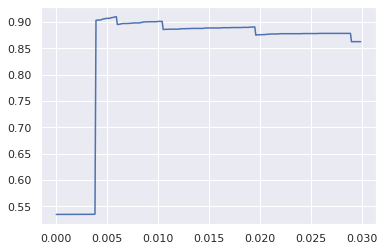

In [ ]:
#ベストな閾値を探す
alpha_list = []
f_beta_score_list = []
for i in range(300):
    alpha = i*0.0001
    predictions = np.where(y_prob < alpha, 0, 1)
    alpha_list.append(alpha)
    f_beta_score_list.append(fbeta_score(y_eval, predictions,beta=7))
sns.set()
plt.plot(alpha_list, f_beta_score_list)
for i,j in zip(alpha_list, f_beta_score_list):
    if j == max(f_beta_score_list):
        print('best alpha :',i)
        print('best f-beta-score :',j)
        break